## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os
from ttictoc import TicToc

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
import hickle as hkl

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
#sys.path.insert(0,'../py-MDNet/modules')
#from sample_generator import *

### Initialize hyper-parameters

In [5]:
learning_rate = 1e-4
batch_size = 500
replay_memory_size = 4000
#epsilon = 0.1
gamma = 0.95

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [6]:
# load dataset
db_no = 4
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 49)
Total number of person in data set:  (1, 49)


In [7]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 100
input_size = h_len*(num_camera) + num_camera+4+1

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

### Model

In [8]:
# Initialize required parameters
hidden_size1 = 4096+2048
hidden_size2 = 2048+1024
hidden_size3 = 256+256

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        #self.fch4 = nn.Linear(hidden_size3, hidden_size4)
        self.fco = nn.Linear(hidden_size3, num_camera)
        self.dropout = nn.Dropout(p=0.3)
        
        # Activation function 
        #self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.dropout(x)
        x = self.relu(self.fch3(x))
        x = self.dropout(x)
        #x = self.relu(self.fch4(x))
        #x = self.dropout(x)
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [9]:
# build the model
if use_cuda:
    policy_net = NextCamera().cuda()
    policy_net.float().cuda()
    criterion = nn.MSELoss().cuda()
else:
    policy_net = NextCamera()
    policy_net.float()
    criterion = nn.MSELoss()
# use ADAM as optimizer since we can load the whole data to train
#cls_weights = [1.0,1.0,1.0,1.0,0.1 ]
#cls_weights = torch.FloatTensor(cls_weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [10]:
def backward_network(replay_memory):
    # sample random minibatch
    minibatch = random.sample(replay_memory, min(len(replay_memory), batch_size))
    
    # unpack minibatch
    state = torch.cat(tuple(d[0] for d in minibatch))
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    nSteps_boot = tuple(d[4] for d in minibatch)
    
    #print (state.size(), next_state.size(), reward.size(), action.size())

    if use_cuda:  # put on GPU if CUDA is available
        state = state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        next_state = next_state.cuda()

    # get output for the next state
    next_output = policy_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4]
                              else reward[i] + (gamma**(nSteps_boot[i])) * torch.max(next_output[i])
                              for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()
    
    return loss.data


### Testing functions

In [11]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0.1
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        occ_len = 0.0001
        # Make initial state
        _,state,rt = make_state_vector(ped, curr_camera,curr_frame, ch,occ_len)
        #print (state.size())
        num_steps = 0
        #prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())


        while(curr_frame <= ped[-1,1]): # alltime-6):
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            if req_inc:
                if inc==1 and y!=num_camera-1:
                     # inside a camera
                    accP.append((y,y))
                elif inc==0 and y==c.item(0) and y!=num_camera-1:
                    # transitioning to second camera
                    accP.append((y,c.item(0)))
                    inc = 1
                elif inc==1 and y==num_camera-1:
                    # moving out of a camera FOV
                    inc = 0
                    accP.append((y,c.item(0)))
                else:
                    # Making transition
                    accP.append((y,c.item(0)))
                    #print ('Another case',y,c.item(0))
                    
            else:
                    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                curr_camera = c
                
                ispresent = 1
                
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += fpsc
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
                
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            hcount = occ_len #np.array(np.log(occ_len))
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
                
            if isdebug:
                print ('x_t: ', curr_camera,rt)
                print ( np.where(ch))
                print ('Q values: ', value_c)
                print (c, curr_frame, hcount)
                print ('isPresent', ispresent)
                print ('')
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))
            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get next state
            #next_state,reward,y,ispresent = get_next_step(ped,c,curr_frame, state)
            
            # store current reward
            reward_sum += reward
                        
            state = next_state
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        
    return rsT, accT

### Run episodes

In [12]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory = []
M = np.zeros((num_camera,num_camera))

In [13]:
# Load model if required
resume = False
backup_fname = './models/Q_db4_xywh_10log'
if resume:
    policy_net = torch.load(backup_fname)
    policy_net.eval()
    print ('Model loaded')
    #episode_reward,running_reward = hkl.load(backup_fname+'_variables.hkl')
    print ('episodic reward loaded')

In [14]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    #print (img.size)
    #hc = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
    #hc = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
    hc = occ_len #np.array(np.log(occ_len))
    
    if p:
        ## Draw samples
        #examples = gen_samples(SampleGenerator('gaussian', img.size, 0.1, 1.2),
        #                       bbox, numSamples, overlap_thres)  # 50 samples with 0.8 overlap
        ##print (examples.shape)
        #samples = examples[np.random.randint(len(examples))].reshape(1,4)
        ##print (samples)
        ##rt = afc.find_curr_rt(samples[0])
        #bbox = samples[0]
        rt = np.zeros((4))
        rt[0] = bbox[0]/imw
        rt[1] = bbox[1]/imh
        rt[2] = bbox[2]/imw
        rt[3] = bbox[3]/imh
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        this_cam = np.zeros((num_camera+1))
        this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
        this_cam[num_camera] = hc
        state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc)) #.ravel()))
        state = np.concatenate((state, ch.ravel()))
        state = state.reshape(1,-1)
        
        if use_cuda:
            state = torch.from_numpy(state).float().cuda()
        else:
            state = torch.from_numpy(state).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        state = []
    
    return p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs


In [15]:
epoch = 0
occ_max_val = 50
NBoot = 20
t = TicToc('episodic')
t.tic()

In [16]:
policy_net.train()
max_ep_len = 200

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
     
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < 2*max_ep_len:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2: # and np.random.rand() < 0.9:
            continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        #tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        #startIDX = np.random.choice(tranIDX) if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len )
        startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam)]
        print ('startIDX: ',startIDX)
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        tmp_ep = []
        rs = []
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.0001
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        _,state,rt=make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        stCam = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
                       
        while(curr_frame <= ped[-1,1]):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            
            # epsilon annealing
            epsilon = 1 / np.log(epoch + 0.0000001)
                 
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                            if random_action
                            else torch.argmax(value_c)][0]

            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # generate random steps
            if np.random.rand(1) < 0.2:
                rsteps = np.random.randint(5)
            else:
                rsteps = fpsc
            
            # find target for the next frame
            curr_frame += rsteps #fpsc
            num_steps += 1
            M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                #print (rt, np.where(rt))
                curr_camera = c
                #ch = np.zeros((h_len,num_camera))
                #num_steps = 0
                ispresent = 1
                stCam = c
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += rsteps
            if occ_len > occ_max_val:
                occ_len = occ_max_val+1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = occ_len #np.array(np.log(occ_len))
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))

            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.1
            elif y == c:
                reward = 1
            else:
                reward = -1
                 
            if np.random.rand() < 0.2 and epoch > 50000:
                print (epoch, p, random_action, rsteps)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch))
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
            reward_sum += reward
            rs.append(reward)
                
            # save transition to replay memory
            tmp_ep.append((state, one_hot_action, reward, next_state, ispresent))
            
            state = next_state
            
            if num_steps >= max_ep_len and c!=num_camera-1 and y == c:  # break the episode
                #replay_memory.append((state, one_hot_action, reward, next_state, ispresent))
                print (epoch, p, random_action)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch)[1])
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
                # Append to the experience buffer
                for tmp_i in range(0,len(tmp_ep)):
                    this_tmp = tmp_ep[tmp_i]
                    # compute n-step return
                    rew = 0
                    for ni in range(NBoot):
                        if (tmp_i+ni) < len(tmp_ep):
                            rew += rs[tmp_i+ni]*(gamma**ni)
                    if use_cuda:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0).cuda()
                    else:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0)
                    # get the next state
                    next_state = tmp_ep[np.min([tmp_i+NBoot-1,len(tmp_ep)-1])]
                    next_state = next_state[3]
                    
                    replay_memory.append((this_tmp[0],this_tmp[1],reward,next_state,np.min([NBoot,len(tmp_ep)-tmp_i])))
                    if len(replay_memory) > replay_memory_size:
                        replay_memory.pop(0)
                tmp_ep = []
                break
        
        # update value_function
        if len(replay_memory) > 0:
            loss = backward_network(replay_memory)
        
        # store episodic reward
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        if epoch % 2 == 0:
            print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        #if epoch % 1000 == 1: 
        #    torch.save(policy_net, backup_fname)
        #    #hkl.dump([[episode_reward,validation_reward, running_reward]], backup_fname+'_variables.hkl')
            
        reward_sum = 0
        num_steps = 0
        rs = []
        
    #print (M)
    epoch += 1
    if epoch % 10 == 0:
        t.toc()
        print('Time elapsed: ', t.elapsed)
        

startIDX:  2303
0 0 False
x_t:  3 [0.09375    0.24166667 0.0625     0.24166667]
Q values:  tensor([[-0.2304, -0.0820, -0.0703,  0.1484, -0.1338,  0.0575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26102 1246 0.0001
isPresent 1

ep 0: ep_len:1246 episode reward: total was -536.700000. running mean: -536.700000
startIDX:  1045
ep 0: ep_len:243 episode reward: total was -215.000000. running mean: -533.483000
startIDX:  2334
0 5 False
x_t:  1 [0.30625    0.325      0.109375   0.53333333]
Q values:  tensor([[-0.4268, -0.1413, -0.4748, -1.5464, -0.3028, -2.5114]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22131 1258 0.0001
isPresent 1

ep 0: ep_len:1258 episode reward: total was -1210.000000. running mean: -540.248170
startIDX:  1472
0 10 False
x_t:  4 [0.103125   0.36666667 0.10625    0.26666667]
Q values:  tensor([[-0.6460, -0.7748, -0.6707, -1.8460, -0.4488, -3.5308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15721 500 0.0001
isPresent 1

ep 0: ep_len:50

ep 4: ep_len:501 episode reward: total was -317.700000. running mean: -507.675252
startIDX:  1150
4 10 True
x_t:  2 [0.8625     0.39583333 0.08125    0.24583333]
Q values:  tensor([[-8.9846, -8.7262, -9.4159, -9.8340, -8.3814, -9.1484]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12052 324 0.0001
isPresent 1

ep 4: ep_len:324 episode reward: total was -224.300000. running mean: -504.841499
startIDX:  692
4 12 True
x_t:  1 [0.003125   0.39583333 0.153125   0.47083333]
Q values:  tensor([[ -6.9789,  -9.5981,  -8.9354, -10.0129,  -8.0429,  -7.9604]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10304 218 0.0001
isPresent 1

ep 4: ep_len:218 episode reward: total was -162.900000. running mean: -501.422084
startIDX:  61
4 15 False
x_t:  3 [0.85       0.35416667 0.146875   0.42916667]
Q values:  tensor([[-9.5517, -7.2235, -9.7953, -7.0778, -7.4569, -8.8180]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 517 222 0.0001
isPresent 1

ep 4: ep_len:222 episode reward: to

ep 8: ep_len:1009 episode reward: total was -610.100000. running mean: -483.379033
startIDX:  2089
8 15 True
x_t:  2 [0.828125   0.37916667 0.071875   0.25416667]
Q values:  tensor([[-7.2120, -6.2762, -8.1669, -7.0303, -7.4697, -6.1600]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15561 357 0.0001
isPresent 1

ep 8: ep_len:357 episode reward: total was -238.900000. running mean: -480.934243
startIDX:  2927
ep 8: ep_len:46 episode reward: total was -34.000000. running mean: -476.464900
startIDX:  818
9 0 False
x_t:  1 [0.01875    0.36666667 0.13125    0.4       ]
Q values:  tensor([[-7.6620, -7.3093, -8.7107, -7.7729, -8.7450, -7.6302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9408 217 0.0001
isPresent 1

startIDX:  490
9 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-6.3354, -6.6644, -8.1695, -5.6733, -7.5862, -8.2664]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 760 0.0001
isPresent 1

startIDX:  1586
9 5 False


ep 12: ep_len:760 episode reward: total was -389.800000. running mean: -425.156314
startIDX:  1649
13 0 False
x_t:  3 [0.365625   0.29166667 0.11875    0.32083333]
Q values:  tensor([[-5.8231, -6.0238, -5.4275, -3.8626, -5.5836, -5.5120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16882 201 0.0001
isPresent 1

startIDX:  475
13 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-4.4930, -4.5334, -4.9123, -4.0598, -4.9355, -4.6265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 781 0.0001
isPresent 1

startIDX:  2273
13 5 True
x_t:  3 [0.446875   0.29583333 0.15       0.375     ]
Q values:  tensor([[-5.1149, -5.6390, -4.6841, -4.9944, -5.7928, -5.3711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19930 203 0.0001
isPresent 1

startIDX:  1600
13 10 False
x_t:  3 [0.828125   0.33333333 0.165625   0.39583333]
Q values:  tensor([[-4.7273, -5.6946, -5.1810, -4.2914, -4.5622, -5.2865]],
       device='cuda:0', grad_fn=<AddmmBack

startIDX:  511
17 1 True
x_t:  1 [0.73125    0.27916667 0.121875   0.44583333]
Q values:  tensor([[-5.5932, -5.4511, -5.3472, -4.6278, -7.6672, -4.7851]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30697 771 0.0001
isPresent 1

startIDX:  840
17 5 True
x_t:  4 [0.003125   0.41666667 0.13125    0.37083333]
Q values:  tensor([[-5.7331, -6.1888, -4.5433, -4.9019, -5.7227, -3.0836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10012 592 0.0001
isPresent 1

startIDX:  2402
17 10 True
x_t:  1 [0.684375 0.2875   0.128125 0.325   ]
Q values:  tensor([[-5.4998, -4.7181, -4.3033, -5.0791, -5.9937, -2.8247]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22489 1199 0.0001
isPresent 1

startIDX:  1420
17 12 False
x_t:  3 [0.3875   0.3      0.109375 0.35    ]
Q values:  tensor([[-3.5388, -3.3817, -3.6283, -2.5338, -2.9054, -3.2723]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17907 200 0.0001
isPresent 1

startIDX:  240
17 15 True
x_t:  2 [0.31875 0.4     0.10625

startIDX:  1569
21 10 True
x_t:  3 [0.640625   0.3        0.13125    0.36666667]
Q values:  tensor([[-10.7477, -12.1850, -13.3082, -14.0256,  -9.7987, -14.8625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16430 316 0.0001
isPresent 1

startIDX:  389
21 12 True
x_t:  3 [0.9125     0.36666667 0.084375   0.425     ]
Q values:  tensor([[-12.4456, -11.1480, -10.6218, -12.6589,  -9.9354, -11.5127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7709 249 0.0001
isPresent 1

startIDX:  40
21 15 True
x_t:  3 [0.371875   0.30416667 0.103125   0.32916667]
Q values:  tensor([[-11.8578, -14.6542,  -8.7432, -13.5025,  -9.6275, -12.1143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 593 261 0.0001
isPresent 1

startIDX:  66
21 22 False
x_t:  1 [0.8375     0.29583333 0.075      0.40416667]
Q values:  tensor([[-11.6857,  -9.5221, -11.3191, -14.9756, -10.4557, -11.3894]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1585 694 0.0001
isPresent 1

startIDX:  564
22 0 Fals

startIDX:  2390
26 0 True
x_t:  3 [0.221875   0.25833333 0.08125    0.27916667]
Q values:  tensor([[-4.2967, -4.5045, -3.8308, -5.5586, -5.6428, -0.9740]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26137 1233 0.0001
isPresent 1

ep 26: ep_len:1233 episode reward: total was -239.400000. running mean: -346.517692
startIDX:  887
26 1 True
x_t:  4 [0.10625    0.37916667 0.13125    0.4125    ]
Q values:  tensor([[-3.2431, -3.3680, -3.0692, -4.3741, -4.0554, -1.0427]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35440 535 0.0001
isPresent 1

ep 26: ep_len:535 episode reward: total was -108.600000. running mean: -344.138515
startIDX:  1167
26 5 True
x_t:  2 [0.003125   0.4        0.09375    0.26666667]
Q values:  tensor([[-3.1252, -4.7281, -2.8735, -3.6046, -3.8500, -2.2892]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12003 869 0.0001
isPresent 1

ep 26: ep_len:869 episode reward: total was -136.400000. running mean: -342.061129
startIDX:  2052
26 10 True
x_t:  

ep 30: ep_len:776 episode reward: total was -402.600000. running mean: -340.654313
startIDX:  1353
30 10 False
x_t:  4 [0.103125   0.36666667 0.10625    0.26666667]
Q values:  tensor([[ -9.5842,  -8.2200, -11.0898, -13.1084,  -7.4475,  -7.6087]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15721 549 0.0001
isPresent 1

ep 30: ep_len:549 episode reward: total was -194.500000. running mean: -339.192770
startIDX:  133
30 12 True
x_t:  2 [0.240625   0.40833333 0.1        0.24583333]
Q values:  tensor([[ -8.3403,  -6.8876, -11.9664, -13.6969,  -7.8185,  -6.8838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2890 339 0.0001
isPresent 1

ep 30: ep_len:339 episode reward: total was -162.300000. running mean: -337.423842
startIDX:  1182
30 15 True
x_t:  4 [0.046875   0.3875     0.06875    0.30416667]
Q values:  tensor([[ -8.3937,  -7.9968, -10.1572,  -9.4031,  -6.7238,  -5.9904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9819 530 0.0001
isPresent 1

ep 30: ep_len:5

34 22 True
x_t:  1 [0.003125   0.375      0.140625   0.40416667]
Q values:  tensor([[-6.0464, -6.8880, -6.6542, -6.0981, -5.7188, -6.3685]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18990 236 0.0001
isPresent 1

ep 34: ep_len:236 episode reward: total was -170.900000. running mean: -303.333847
startIDX:  105
35 0 False
x_t:  1 [0.85625    0.30416667 0.140625   0.43333333]
Q values:  tensor([[-7.8004, -5.3518, -7.1119, -9.2034, -8.5625, -6.6069]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1611 708 0.0001
isPresent 1

startIDX:  620
35 1 False
x_t:  2 [0.8125     0.38333333 0.1125     0.30833333]
Q values:  tensor([[-8.1086, -7.2923, -6.5684, -8.1233, -7.5257, -8.5920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31459 365 0.0001
isPresent 1

startIDX:  2417
35 5 False
x_t:  2 [0.03125    0.39583333 0.090625   0.26666667]
Q values:  tensor([[ -9.9249, -12.7928,  -7.9749,  -9.6328, -10.4041,  -9.3731]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 

startIDX:  354
39 1 False
x_t:  0 [0.934375   0.37083333 0.059375   0.40833333]
Q values:  tensor([[-5.7599, -7.6309, -7.9475, -6.8305, -8.7949, -6.0141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29088 788 0.0001
isPresent 1

startIDX:  343
39 5 False
x_t:  1 [0.74375    0.28333333 0.0625     0.36666667]
Q values:  tensor([[ -6.3474,  -5.5930,  -8.1628,  -8.4169, -10.0156,  -6.3624]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5046 718 0.0001
isPresent 1

startIDX:  1881
39 10 True
x_t:  2 [0.5        0.39583333 0.078125   0.25      ]
Q values:  tensor([[ -7.2258,  -6.8319,  -9.4954,  -8.0492, -10.0294,  -6.6153]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18233 858 0.0001
isPresent 1

startIDX:  613
39 12 True
x_t:  2 [0.015625   0.41666667 0.1        0.24583333]
Q values:  tensor([[-7.5014, -8.2782, -9.0826, -6.8993, -9.4614, -6.6175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9832 1003 0.0001
isPresent 1

startIDX:  1861
39 15 False
x_t:

startIDX:  1331
43 12 True
x_t:  3 [0.365625 0.3      0.1125   0.3375  ]
Q values:  tensor([[-3.1708, -2.4417, -4.3659, -3.3834, -3.1421, -1.0919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17911 248 0.0001
isPresent 1

startIDX:  1081
43 15 True
x_t:  4 [0.046875   0.3875     0.06875    0.30416667]
Q values:  tensor([[-3.7787, -2.7167, -4.0533, -3.5540, -3.4135, -1.8721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9819 595 0.0001
isPresent 1

startIDX:  454
43 22 True
x_t:  4 [0.01875    0.41666667 0.090625   0.37083333]
Q values:  tensor([[-4.4564, -2.5783, -4.1560, -3.2391, -3.9420, -1.5750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6633 846 0.0001
isPresent 1

startIDX:  277
44 0 True
x_t:  3 [0.4        0.27916667 0.065625   0.31666667]
Q values:  tensor([[-3.8053, -3.9377, -3.8330, -3.2796, -3.4254, -1.1525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4933 1282 0.0001
isPresent 1

ep 44: ep_len:1282 episode reward: total was -241.400

ep 48: ep_len:308 episode reward: total was -137.000000. running mean: -239.514449
startIDX:  403
48 1 False
x_t:  0 [0.91875    0.375      0.0625     0.39583333]
Q values:  tensor([[-4.5863, -5.2668, -5.9136, -6.0170, -5.5364, -5.0298]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29091 490 0.0001
isPresent 1

ep 48: ep_len:490 episode reward: total was -261.900000. running mean: -239.738304
startIDX:  2518
48 5 False
x_t:  2 [0.06875 0.4     0.09375 0.2625 ]
Q values:  tensor([[-4.9719, -4.7741, -4.4300, -5.5270, -5.3827, -5.2602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21559 814 0.0001
isPresent 1

ep 48: ep_len:814 episode reward: total was -477.300000. running mean: -242.113921
startIDX:  630
48 10 False
x_t:  2 [0.071875   0.4        0.065625   0.26666667]
Q values:  tensor([[-5.4996, -5.8382, -5.0016, -6.3060, -5.4860, -5.0536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6596 714 0.0001
isPresent 1

ep 48: ep_len:714 episode reward: total was -

52 10 True
x_t:  1 [0.88125    0.28333333 0.078125   0.34583333]
Q values:  tensor([[-10.0394,  -7.4743,  -7.0398,  -7.8199,  -7.6078,  -5.6150]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22471 1230 0.0001
isPresent 1

ep 52: ep_len:1230 episode reward: total was -432.200000. running mean: -287.550060
startIDX:  1031
52 12 False
x_t:  2 [0.790625   0.4125     0.071875   0.24583333]
Q values:  tensor([[-9.6005, -6.6140, -6.1557, -6.5264, -8.6409, -6.2118]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13578 303 0.0001
isPresent 1

ep 52: ep_len:303 episode reward: total was -116.400000. running mean: -285.838559
startIDX:  2550
52 15 True
x_t:  3 [0.359375   0.27916667 0.1        0.27916667]
Q values:  tensor([[-1.6275, -2.5208, -2.2939, -2.8455, -2.6709, -2.2237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19748 200 0.0001
isPresent 1

ep 52: ep_len:200 episode reward: total was -92.600000. running mean: -283.906174
startIDX:  173
52 22 True
x_t:  2 [0.81

56 15 True
x_t:  2 [0.065625 0.4      0.065625 0.3375  ]
Q values:  tensor([[-2.6751, -3.0279, -3.1679, -3.5577, -2.5682, -1.9276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21481 832 0.0001
isPresent 1

ep 56: ep_len:832 episode reward: total was -136.900000. running mean: -248.124187
startIDX:  1013
56 22 True
x_t:  0 [0.5875     0.40833333 0.065625   0.32916667]
Q values:  tensor([[-3.8780, -3.4759, -3.7517, -3.8335, -3.7227, -2.0632]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10497 479 0.0001
isPresent 1

ep 56: ep_len:479 episode reward: total was -126.800000. running mean: -246.910945
startIDX:  218
57 0 True
x_t:  2 [0.209375   0.40416667 0.075      0.3       ]
Q values:  tensor([[-2.9313, -2.6024, -2.8253, -2.8723, -2.5184, -0.7721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2410 370 0.0001
isPresent 1

startIDX:  15
57 1 False
x_t:  3 [0.415625 0.2625   0.115625 0.35    ]
Q values:  tensor([[-2.7371, -2.1874, -1.8505, -0.7740, -2.2459, -1.88

60 22 False
x_t:  4 [0.003125   0.39583333 0.09375    0.30416667]
Q values:  tensor([[-11.1533, -10.3948, -10.3768, -12.0577,  -9.6198, -10.6565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16324 561 0.0001
isPresent 1

ep 60: ep_len:561 episode reward: total was -339.100000. running mean: -270.856396
startIDX:  920
61 0 False
x_t:  0 [0.884375   0.40416667 0.10625    0.35833333]
Q values:  tensor([[ -7.8622, -12.9036, -10.7189, -10.8974, -11.0075, -10.3355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10329 428 0.0001
isPresent 1

startIDX:  586
61 1 False
x_t:  2 [0.8125     0.38333333 0.1125     0.30833333]
Q values:  tensor([[-10.4453, -11.2597, -10.1574, -10.9692, -11.5035, -10.9394]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31459 389 0.0001
isPresent 1

startIDX:  370
61 5 True
x_t:  1 [0.740625   0.2875     0.121875   0.37083333]
Q values:  tensor([[-10.2442, -10.3957, -11.0134, -11.8777,  -9.6514,  -8.2873]],
       device='cuda:0', grad_fn=<Ad

startIDX:  29
65 12 True
x_t:  1 [0.790625 0.3125   0.078125 0.425   ]
Q values:  tensor([[-4.4030, -2.9831, -2.8840, -3.0164, -2.4546, -1.1778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2226 641 0.0001
isPresent 1

startIDX:  1652
65 15 True
x_t:  1 [0.63125    0.3125     0.090625   0.35833333]
Q values:  tensor([[-3.7576, -2.5305, -1.9992, -2.1374, -1.9762, -1.1701]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12514 291 0.0001
isPresent 1

startIDX:  2890
startIDX:  2147
66 0 True
x_t:  2 [0.7125     0.41666667 0.090625   0.23333333]
Q values:  tensor([[-3.8895, -2.6285, -2.7059, -2.7971, -2.4120, -1.2944]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23604 1478 0.0001
isPresent 1

ep 66: ep_len:1478 episode reward: total was -200.600000. running mean: -225.551583
startIDX:  264
66 1 True
x_t:  2 [0.003125 0.375    0.15625  0.4375  ]
Q values:  tensor([[-3.5453, -3.1024, -2.2160, -2.4990, -2.3587, -1.8112]],
       device='cuda:0', grad_fn=<AddmmBackwa

ep 70: ep_len:972 episode reward: total was -720.900000. running mean: -224.442629
startIDX:  1618
70 10 True
x_t:  3 [0.553125   0.3        0.125      0.35833333]
Q values:  tensor([[-10.1771, -10.9976, -11.2805, -10.5104,  -9.3552, -10.3160]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16445 309 0.0001
isPresent 1

ep 70: ep_len:309 episode reward: total was -134.400000. running mean: -223.542203
startIDX:  2065
ep 70: ep_len:2 episode reward: total was 0.000000. running mean: -221.306781
startIDX:  2896
70 15 False
x_t:  0 [0.925   0.4     0.06875 0.35   ]
Q values:  tensor([[ -8.8921, -11.4401, -11.3599, -10.0514,  -9.2258, -10.1188]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23069 492 0.0001
isPresent 1

ep 70: ep_len:492 episode reward: total was -325.400000. running mean: -222.347713
startIDX:  58
70 22 False
x_t:  1 [0.90625  0.2875   0.090625 0.4125  ]
Q values:  tensor([[-12.3348, -11.2344, -11.8345, -11.2728, -13.6058, -13.4131]],
       device='cuda:0'

ep 74: ep_len:625 episode reward: total was -96.500000. running mean: -209.203571
startIDX:  351
74 15 True
x_t:  1 [0.0875     0.37916667 0.140625   0.49166667]
Q values:  tensor([[-4.3470, -3.4463, -3.1393, -3.8041, -3.8999, -1.2779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2758 242 0.0001
isPresent 1

ep 74: ep_len:242 episode reward: total was -32.200000. running mean: -207.433535
startIDX:  1705
74 22 True
x_t:  3 [0.721875   0.3375     0.1        0.38333333]
Q values:  tensor([[-3.9641, -4.1076, -3.7834, -2.8648, -4.4914, -1.4161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16864 203 0.0001
isPresent 1

ep 74: ep_len:203 episode reward: total was 9.300000. running mean: -205.266200
startIDX:  865
75 0 True
x_t:  0 [0.74375  0.4      0.115625 0.4125  ]
Q values:  tensor([[-2.8971, -3.3366, -2.8997, -2.8766, -4.0805, -1.2608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10435 501 0.0001
isPresent 1

startIDX:  585
75 1 True
x_t:  2 [0.734375   0.3

79 5 True
x_t:  1 [0.775      0.28333333 0.0875     0.50416667]
Q values:  tensor([[-3.0445, -2.9914, -3.2477, -2.7795, -2.8905, -2.0858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22172 265 0.0001
isPresent 1

startIDX:  1635
79 10 False
x_t:  3 [0.81875 0.3125  0.1125  0.4    ]
Q values:  tensor([[-3.1875, -3.0788, -2.9796, -2.3410, -2.9425, -2.6445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16409 277 0.0001
isPresent 1

startIDX:  1249
79 12 True
x_t:  4 [0.134375   0.42083333 0.075      0.37083333]
Q values:  tensor([[-3.1078, -2.5625, -2.8167, -2.5477, -2.1608, -1.8676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17403 476 0.0001
isPresent 1

startIDX:  2519
79 15 False
x_t:  3 [0.4625     0.29166667 0.10625    0.3125    ]
Q values:  tensor([[1.7011, 1.3699, 1.0961, 3.1319, 2.6918, 2.2032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19724 200 0.0001
isPresent 1

startIDX:  2983
Time elapsed:  1204.4823443889618
startIDX:  2173
80 0 Fa

startIDX:  2132
83 22 True
x_t:  0 [0.940625   0.39583333 0.05625    0.35      ]
Q values:  tensor([[-7.7964, -8.7520, -7.2022, -9.4955, -8.8653, -6.3896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20682 833 0.0001
isPresent 1

startIDX:  1532
84 0 False
x_t:  3 [0.80625    0.33333333 0.090625   0.42083333]
Q values:  tensor([[ -9.0660,  -9.7908, -10.2877,  -7.0995, -10.6946,  -9.6596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16822 246 0.0001
isPresent 1

ep 84: ep_len:246 episode reward: total was -12.800000. running mean: -203.044286
startIDX:  448
84 1 False
x_t:  1 [0.753125 0.275    0.165625 0.45    ]
Q values:  tensor([[-10.4037,  -8.7897, -10.8218, -10.3509, -10.8243,  -9.1604]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30690 791 0.0001
isPresent 1

ep 84: ep_len:791 episode reward: total was -369.100000. running mean: -204.704844
startIDX:  1141
84 5 True
x_t:  2 [0.259375   0.39583333 0.10625    0.29166667]
Q values:  tensor([[-7.2516, -7.

ep 88: ep_len:997 episode reward: total was -118.300000. running mean: -178.622491
startIDX:  194
88 1 True
x_t:  2 [0.084375   0.36666667 0.1        0.45      ]
Q values:  tensor([[-2.4519, -2.7402, -2.1642, -2.2430, -2.0843, -0.9238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27443 846 0.0001
isPresent 1

ep 88: ep_len:846 episode reward: total was -74.600000. running mean: -177.582266
startIDX:  1934
88 5 True
x_t:  3 [0.078125   0.25416667 0.096875   0.29583333]
Q values:  tensor([[-2.2005, -2.9875, -2.2939, -1.8327, -2.6073, -1.1478]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18209 1258 0.0001
isPresent 1

ep 88: ep_len:1258 episode reward: total was -44.700000. running mean: -176.253443
startIDX:  2541
ep 88: ep_len:48 episode reward: total was 34.000000. running mean: -174.150909
startIDX:  489
88 12 True
x_t:  3 [0.684375   0.32916667 0.09375    0.3875    ]
Q values:  tensor([[-1.7629, -2.3265, -1.3610, -1.3507, -1.7490, -0.2363]],
       device='cuda:0'

92 12 False
x_t:  2 [0.53125    0.40833333 0.046875   0.25416667]
Q values:  tensor([[-3.3230, -3.3338, -2.6865, -2.8035, -4.1262, -3.1729]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13619 338 0.0001
isPresent 1

ep 92: ep_len:338 episode reward: total was -165.500000. running mean: -162.637874
startIDX:  449
92 15 False
x_t:  0 [0.903125   0.40416667 0.0625     0.33333333]
Q values:  tensor([[-3.8677, -4.7775, -4.9036, -4.3999, -4.8627, -4.0650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3656 412 0.0001
isPresent 1

ep 92: ep_len:412 episode reward: total was -243.200000. running mean: -163.443495
startIDX:  109
92 22 False
x_t:  1 [0.75       0.30416667 0.13125    0.4       ]
Q values:  tensor([[-4.0508, -3.6632, -4.2624, -5.1981, -3.9619, -4.2800]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1590 675 0.0001
isPresent 1

ep 92: ep_len:675 episode reward: total was -434.200000. running mean: -166.151060
startIDX:  1986
93 0 False
x_t:  1 [0.003125   0

ep 96: ep_len:685 episode reward: total was -255.700000. running mean: -207.381703
startIDX:  2187
97 0 True
x_t:  1 [0.696875   0.325      0.215625   0.50833333]
Q values:  tensor([[-5.7472, -6.1748, -4.5300, -6.0774, -5.4968, -5.1080]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22930 1119 0.0001
isPresent 1

startIDX:  828
97 1 True
x_t:  4 [0.040625   0.39166667 0.090625   0.40833333]
Q values:  tensor([[-5.9652, -4.0536, -4.7252, -6.5664, -3.8509, -3.5799]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35428 546 0.0001
isPresent 1

startIDX:  1349
97 5 True
x_t:  1 [0.03125    0.34583333 0.128125   0.41666667]
Q values:  tensor([[-4.9230, -4.4167, -4.9664, -6.4554, -5.1433, -3.9742]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12508 239 0.0001
isPresent 1

startIDX:  303
97 10 True
x_t:  3 [0.828125   0.3375     0.15625    0.36666667]
Q values:  tensor([[-4.5245, -4.4458, -5.6976, -5.9471, -4.8593, -4.1769]],
       device='cuda:0', grad_fn=<AddmmBackwa

startIDX:  646
101 1 False
x_t:  2 [0.809375   0.38333333 0.071875   0.30833333]
Q values:  tensor([[ -9.6374, -11.0517,  -8.8162,  -9.3506,  -8.9848,  -9.8230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31465 351 0.0001
isPresent 1

startIDX:  994
101 5 False
x_t:  3 [0.684375   0.3        0.1375     0.39583333]
Q values:  tensor([[1.1294, 0.5316, 1.0428, 3.7723, 1.6291, 1.7034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10502 200 0.0001
isPresent 1

startIDX:  348
101 10 False
x_t:  3 [0.815625   0.32916667 0.140625   0.36666667]
Q values:  tensor([[-7.3629, -8.6861, -9.1488, -5.8225, -7.4507, -7.5267]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5040 211 0.0001
isPresent 1

startIDX:  1023
101 12 True
x_t:  2 [0.7125     0.40833333 0.10625    0.24583333]
Q values:  tensor([[-9.1789, -8.3333, -9.7344, -9.2707, -7.8452, -7.7783]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13586 312 0.0001
isPresent 1

startIDX:  1721
101 15 True
x_t:  1 [0.

startIDX:  1822
105 15 True
x_t:  0 [0.53125    0.40833333 0.1        0.34583333]
Q values:  tensor([[-1.9302, -2.5024, -2.7848, -2.2620, -2.2868, -1.3344]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13421 462 0.0001
isPresent 1

startIDX:  2323
105 22 True
x_t:  1 [0.7625     0.31666667 0.13125    0.45416667]
Q values:  tensor([[-2.1949, -2.6751, -2.7464, -2.1955, -2.8460, -1.5976]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22941 1061 0.0001
isPresent 1

startIDX:  2357
106 0 True
x_t:  3 [0.09375    0.24166667 0.0625     0.24166667]
Q values:  tensor([[-2.8869, -2.8568, -3.0633, -2.6012, -2.9604, -1.4117]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26102 1218 0.0001
isPresent 1

ep 106: ep_len:1218 episode reward: total was -88.200000. running mean: -189.072952
startIDX:  657
106 1 True
x_t:  2 [0.3875     0.37916667 0.103125   0.325     ]
Q values:  tensor([[-2.4558, -2.4825, -2.3942, -2.7749, -2.7572, -1.2205]],
       device='cuda:0', grad_fn=<Add

ep 110: ep_len:1048 episode reward: total was -151.200000. running mean: -163.731264
startIDX:  1145
ep 110: ep_len:33 episode reward: total was 9.000000. running mean: -162.003952
startIDX:  2090
110 5 True
x_t:  4 [0.134375   0.42916667 0.146875   0.4       ]
Q values:  tensor([[-1.9576, -2.4169, -3.0380, -3.0169, -2.1543, -1.9982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19478 632 0.0001
isPresent 1

ep 110: ep_len:632 episode reward: total was -136.300000. running mean: -161.746912
startIDX:  2179
110 10 False
x_t:  0 [0.64375    0.40416667 0.084375   0.3       ]
Q values:  tensor([[-1.5247, -2.3623, -2.1234, -1.9997, -2.1279, -1.6634]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19992 550 0.0001
isPresent 1

ep 110: ep_len:550 episode reward: total was -80.100000. running mean: -160.930443
startIDX:  787
110 12 True
x_t:  0 [0.9125  0.4125  0.08125 0.3    ]
Q values:  tensor([[-2.2487, -2.2019, -3.0805, -2.1960, -2.6107, -2.0454]],
       device='cuda:0', g

114 12 True
x_t:  1 [0.340625   0.35833333 0.121875   0.5125    ]
Q values:  tensor([[-2.9762, -2.9371, -3.1206, -2.4180, -3.2014, -2.4372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10326 207 0.0001
isPresent 1

ep 114: ep_len:207 episode reward: total was -46.800000. running mean: -144.672914
startIDX:  771
114 15 True
x_t:  2 [0.80625    0.40416667 0.075      0.29583333]
Q values:  tensor([[-2.6960, -3.8476, -3.3156, -2.6818, -3.3405, -2.2356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5966 350 0.0001
isPresent 1

ep 114: ep_len:350 episode reward: total was -98.600000. running mean: -144.212185
startIDX:  1610
114 22 True
x_t:  3 [0.7625     0.32916667 0.071875   0.39166667]
Q values:  tensor([[-3.6659, -3.6990, -3.3999, -3.6283, -4.2627, -2.9204]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16861 254 0.0001
isPresent 1

ep 114: ep_len:254 episode reward: total was -151.800000. running mean: -144.288063
startIDX:  1628
115 0 False
x_t:  3 [0.584375

118 15 False
x_t:  2 [0.38125    0.4        0.06875    0.34583333]
Q values:  tensor([[-6.7983, -6.0895, -5.8351, -7.2338, -8.0268, -6.1232]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2239 823 0.0001
isPresent 1

ep 118: ep_len:823 episode reward: total was -219.500000. running mean: -193.139146
startIDX:  713
118 22 False
x_t:  2 [0.0625     0.41666667 0.1125     0.2625    ]
Q values:  tensor([[-6.0125, -6.8908, -4.5626, -5.4477, -5.9017, -5.0577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8928 878 0.0001
isPresent 1

ep 118: ep_len:878 episode reward: total was -137.700000. running mean: -192.584755
startIDX:  1234
119 0 True
x_t:  3 [0.403125   0.29583333 0.10625    0.3375    ]
Q values:  tensor([[-4.6587, -4.6109, -4.6329, -4.1264, -4.3925, -3.2975]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15244 1290 0.0001
isPresent 1

startIDX:  602
119 1 True
x_t:  2 [0.809375   0.38333333 0.071875   0.30833333]
Q values:  tensor([[-3.9331, -3.5938, -2.8599,

startIDX:  740
123 5 False
x_t:  3 [0.084375   0.25833333 0.0875     0.32083333]
Q values:  tensor([[-5.8626, -5.2060, -6.8143, -5.1418, -6.6676, -6.4445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8756 1306 0.0001
isPresent 1

startIDX:  615
123 10 False
x_t:  2 [0.3        0.4        0.059375   0.25416667]
Q values:  tensor([[-7.0115, -6.8638, -4.9652, -8.0166, -7.2654, -5.6335]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6631 742 0.0001
isPresent 1

startIDX:  1271
123 12 False
x_t:  4 [0.01875    0.42916667 0.10625    0.37083333]
Q values:  tensor([[-10.2308, -11.2593, -11.0752, -10.4192,  -9.3122, -11.5364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17391 463 0.0001
isPresent 1

startIDX:  719
123 15 False
x_t:  2 [0.75       0.40416667 0.065625   0.29583333]
Q values:  tensor([[-10.2960, -10.1578,  -8.2500,  -8.3773, -11.0148, -10.0960]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5977 380 0.0001
isPresent 1

startIDX:  1530
123 22 Fal

127 15 False
x_t:  3 [0.7125     0.325      0.096875   0.37083333]
Q values:  tensor([[-5.0793, -4.0975, -4.1170, -2.2836, -3.5985, -2.8006]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10359 219 0.0001
isPresent 1

startIDX:  1984
127 22 True
x_t:  1 [0.140625   0.35       0.10625    0.38333333]
Q values:  tensor([[-5.0430, -4.3202, -4.4549, -4.1765, -4.1719, -2.9970]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19005 278 0.0001
isPresent 1

startIDX:  851
128 0 True
x_t:  1 [0.146875   0.35833333 0.128125   0.38333333]
Q values:  tensor([[-5.7012, -4.5680, -4.3127, -4.6450, -4.4038, -2.7557]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9425 210 0.0001
isPresent 1

ep 128: ep_len:210 episode reward: total was -41.900000. running mean: -228.800665
startIDX:  301
128 1 True
x_t:  1 [0.771875   0.27916667 0.159375   0.59583333]
Q values:  tensor([[-3.9023, -3.7017, -3.2274, -2.7706, -3.2239, -2.5572]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 281

ep 132: ep_len:40 episode reward: total was 20.000000. running mean: -193.072646
startIDX:  660
132 5 False
x_t:  3 [0.075  0.2625 0.0875 0.3125]
Q values:  tensor([[-2.3309, -2.1833, -2.1587, -1.7323, -2.1980, -1.7364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8752 1337 0.0001
isPresent 1

ep 132: ep_len:1337 episode reward: total was -112.500000. running mean: -192.266919
startIDX:  2354
132 10 True
x_t:  1 [0.846875   0.275      0.078125   0.34583333]
Q values:  tensor([[-3.0773, -2.6131, -2.8927, -1.9538, -2.7769, -1.8812]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22474 1207 0.0001
isPresent 1

ep 132: ep_len:1207 episode reward: total was -181.000000. running mean: -192.154250
startIDX:  670
132 12 True
x_t:  1 [0.0125     0.39583333 0.23125    0.475     ]
Q values:  tensor([[-3.0669, -2.3466, -3.6816, -3.0840, -2.5496, -1.7472]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10306 226 0.0001
isPresent 1

ep 132: ep_len:226 episode reward: total wa

136 10 True
x_t:  3 [0.334375   0.27083333 0.10625    0.3125    ]
Q values:  tensor([[-1.6264, -2.4095, -1.5918, -1.9004, -2.2733, -1.2980]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16484 324 0.0001
isPresent 1

ep 136: ep_len:324 episode reward: total was -126.000000. running mean: -166.013453
startIDX:  2065
ep 136: ep_len:2 episode reward: total was 0.000000. running mean: -164.353318
startIDX:  559
136 15 True
x_t:  1 [0.93125    0.29583333 0.05625    0.27916667]
Q values:  tensor([[-2.8774, -2.8147, -2.2948, -2.9129, -2.2262, -1.4787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5163 708 0.0001
isPresent 1

ep 136: ep_len:708 episode reward: total was -121.400000. running mean: -163.923785
startIDX:  1131
136 22 True
x_t:  1 [0.753125   0.32083333 0.140625   0.475     ]
Q values:  tensor([[-2.4273, -2.6103, -2.7146, -2.7913, -2.1281, -1.5584]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11926 739 0.0001
isPresent 1

ep 136: ep_len:739 episode rewar

140 22 True
x_t:  2 [0.446875   0.40416667 0.04375    0.25833333]
Q values:  tensor([[-2.2370, -2.0742, -2.0701, -2.1365, -2.2851, -1.2411]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8985 924 0.0001
isPresent 1

ep 140: ep_len:924 episode reward: total was -103.300000. running mean: -143.053383
startIDX:  2583
startIDX:  436
141 1 True
x_t:  1 [0.38125    0.29166667 0.153125   0.49583333]
Q values:  tensor([[-2.5880, -2.6427, -2.7410, -2.5161, -2.6476, -2.0666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30730 817 0.0001
isPresent 1

startIDX:  805
141 5 False
x_t:  4 [0.003125   0.41666667 0.1625     0.36666667]
Q values:  tensor([[-2.5097, -2.2408, -2.7132, -2.4998, -1.5479, -1.6219]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10015 617 0.0001
isPresent 1

startIDX:  2181
141 10 False
x_t:  0 [0.884375   0.39166667 0.103125   0.36666667]
Q values:  tensor([[-1.4306, -2.3831, -2.4177, -2.1206, -2.3296, -1.5336]],
       device='cuda:0', grad_fn=<Addmm

145 10 True
x_t:  4 [0.284375 0.35     0.090625 0.225   ]
Q values:  tensor([[-2.0379, -1.9112, -1.9235, -2.1180, -1.8905, -1.5697]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4593 1531 0.0001
isPresent 1

startIDX:  1767
145 12 True
x_t:  0 [0.784375   0.40833333 0.09375    0.27916667]
Q values:  tensor([[-2.2973, -2.2576, -2.1840, -2.6180, -2.1537, -1.5220]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23103 1613 0.0001
isPresent 1

startIDX:  86
145 15 True
x_t:  3 [0.44375    0.30833333 0.090625   0.35416667]
Q values:  tensor([[-2.1044, -2.2732, -1.7709, -1.8076, -1.7450, -1.3831]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 582 231 0.0001
isPresent 1

startIDX:  2251
145 22 True
x_t:  1 [0.596875   0.33333333 0.171875   0.4375    ]
Q values:  tensor([[-2.3052, -2.2160, -2.3193, -2.3893, -2.0679, -1.5460]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22956 1113 0.0001
isPresent 1

startIDX:  161
146 0 True
x_t:  1 [0.01875    0.375      0.2  

149 22 False
x_t:  3 [0.784375   0.34166667 0.121875   0.4125    ]
Q values:  tensor([[-4.7946, -5.5938, -5.1443, -3.6234, -4.4406, -4.3556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16856 229 0.0001
isPresent 1

Time elapsed:  2334.7408151626587
startIDX:  2076
150 0 False
x_t:  0 [0.675      0.39166667 0.09375    0.37916667]
Q values:  tensor([[-3.1800, -3.3596, -4.5530, -4.8557, -4.2561, -3.5330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20705 856 0.0001
isPresent 1

ep 150: ep_len:856 episode reward: total was -559.600000. running mean: -129.582472
startIDX:  1057
150 1 False
x_t:  3 [0.6375     0.29166667 0.1        0.375     ]
Q values:  tensor([[-5.4415, -6.2129, -4.8827, -4.5723, -5.8388, -5.1631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35934 224 0.0001
isPresent 1

ep 150: ep_len:224 episode reward: total was -109.500000. running mean: -129.381648
startIDX:  1696
150 5 False
x_t:  1 [0.815625   0.28333333 0.071875   0.3125    ]
Q values

ep 154: ep_len:1199 episode reward: total was -487.200000. running mean: -181.075445
startIDX:  360
154 1 False
x_t:  0 [0.65625    0.37916667 0.09375    0.40833333]
Q values:  tensor([[-6.3152, -7.3294, -8.3947, -7.8662, -6.4451, -6.4933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29134 830 0.0001
isPresent 1

ep 154: ep_len:830 episode reward: total was -305.200000. running mean: -182.316691
startIDX:  303
154 5 True
x_t:  0 [0.890625   0.3875     0.06875    0.36666667]
Q values:  tensor([[-8.0891, -7.9732, -7.5697, -8.0771, -6.8246, -5.3745]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3561 506 0.0001
isPresent 1

ep 154: ep_len:506 episode reward: total was -181.900000. running mean: -182.312524
startIDX:  109
154 10 True
x_t:  3 [0.209375   0.26666667 0.1        0.29166667]
Q values:  tensor([[-5.5559, -6.8034, -6.5496, -4.3865, -5.5246, -4.4236]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3626 1076 0.0001
isPresent 1

ep 154: ep_len:1076 episode r

ep 158: ep_len:2072 episode reward: total was -259.100000. running mean: -165.035016
startIDX:  1894
158 12 True
x_t:  0 [0.421875   0.42083333 0.10625    0.3625    ]
Q values:  tensor([[-1.7529, -2.5518, -1.7537, -1.4942, -1.7222, -0.8026]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23019 945 0.0001
isPresent 1

ep 158: ep_len:945 episode reward: total was -106.100000. running mean: -164.445665
startIDX:  1348
158 15 True
x_t:  3 [0.746875   0.3375     0.140625   0.37083333]
Q values:  tensor([[-1.9313, -2.7275, -2.2498, -1.9706, -1.4939, -0.7492]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10351 214 0.0001
isPresent 1

ep 158: ep_len:214 episode reward: total was 1.900000. running mean: -162.782209
startIDX:  2388
158 22 True
x_t:  1 [0.6625     0.3125     0.10625    0.45416667]
Q values:  tensor([[-3.3734, -2.5144, -2.4450, -2.3384, -2.0849, -1.3052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22953 1027 0.0001
isPresent 1

ep 158: ep_len:1027 episod

ep 162: ep_len:614 episode reward: total was -197.900000. running mean: -158.285876
startIDX:  976
162 22 False
x_t:  0 [0.834375   0.40416667 0.10625    0.34166667]
Q values:  tensor([[-3.0543, -4.2302, -3.4945, -3.5891, -3.7235, -3.2199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10411 459 0.0001
isPresent 1

ep 162: ep_len:459 episode reward: total was -184.800000. running mean: -158.551017
startIDX:  2063
163 0 False
x_t:  0 [0.909375   0.40833333 0.06875    0.3375    ]
Q values:  tensor([[-2.9131, -3.6143, -4.5187, -3.6850, -3.5515, -3.5925]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20629 835 0.0001
isPresent 1

startIDX:  56
163 1 False
x_t:  3 [0.334375 0.25     0.08125  0.325   ]
Q values:  tensor([[0.6274, 1.0506, 1.1102, 1.6228, 1.3278, 1.4359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25719 200 0.0001
isPresent 1

startIDX:  301
163 5 False
x_t:  0 [0.803125   0.39583333 0.1        0.36666667]
Q values:  tensor([[-4.7202, -5.4562, -5.727

startIDX:  1143
startIDX:  568
167 5 False
x_t:  2 [0.859375   0.37083333 0.08125    0.24166667]
Q values:  tensor([[-9.0408, -8.4074, -6.8321, -7.5371, -8.8006, -8.3124]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6022 467 0.0001
isPresent 1

startIDX:  1214
167 10 False
x_t:  3 [0.121875   0.225      0.059375   0.26666667]
Q values:  tensor([[-6.7654, -7.0372, -7.4965, -6.0341, -7.7024, -6.3199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14595 1245 0.0001
isPresent 1

startIDX:  1454
167 12 False
x_t:  3 [0.378125   0.28333333 0.065625   0.32916667]
Q values:  tensor([[0.9482, 1.3740, 0.5272, 2.7038, 1.6239, 1.7669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17916 200 0.0001
isPresent 1

startIDX:  308
167 15 False
x_t:  1 [0.14375    0.375      0.115625   0.49166667]
Q values:  tensor([[-6.0435, -5.6168, -7.0417, -6.3152, -6.4505, -6.0744]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2762 275 0.0001
isPresent 1

startIDX:  1464
167 22 Fal

startIDX:  1719
171 12 True
x_t:  1 [0.7875   0.3      0.165625 0.4125  ]
Q values:  tensor([[-3.4881, -4.1244, -3.1793, -3.4433, -4.4060, -2.2497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19949 244 0.0001
isPresent 1

startIDX:  87
171 15 True
x_t:  3 [0.8375     0.36666667 0.159375   0.42083333]
Q values:  tensor([[-3.9453, -3.4180, -4.1796, -3.7938, -3.7221, -1.7186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 519 219 0.0001
isPresent 1

startIDX:  204
171 22 False
x_t:  2 [0.74375    0.40833333 0.071875   0.24166667]
Q values:  tensor([[-4.5702, -4.4186, -3.1507, -4.2017, -5.5402, -3.1683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2289 325 0.0001
isPresent 1

startIDX:  494
172 0 True
x_t:  3 [0.671875   0.37916667 0.18125    0.4375    ]
Q values:  tensor([[-4.3355, -3.2204, -3.3916, -2.7610, -4.8291, -1.7574]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7004 1023 0.0001
isPresent 1

ep 172: ep_len:1023 episode reward: total was -83.2

startIDX:  1705
176 0 False
x_t:  3 [0.1625     0.25416667 0.06875    0.275     ]
Q values:  tensor([[0.8020, 0.4453, 0.1494, 0.9163, 0.4963, 0.5405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16931 200 0.0001
isPresent 1

ep 176: ep_len:200 episode reward: total was -43.800000. running mean: -167.520230
startIDX:  110
176 1 False
x_t:  3 [0.096875   0.225      0.084375   0.28333333]
Q values:  tensor([[0.7345, 0.7015, 0.6070, 1.4564, 0.5844, 0.8001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25780 200 0.0001
isPresent 1

ep 176: ep_len:200 episode reward: total was -35.000000. running mean: -166.195028
startIDX:  693
176 5 False
x_t:  3 [0.09375    0.2625     0.084375   0.31666667]
Q values:  tensor([[-3.2294, -3.4808, -2.9877, -2.5240, -3.6287, -2.5682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8757 1342 0.0001
isPresent 1

ep 176: ep_len:1342 episode reward: total was -360.500000. running mean: -168.138078
startIDX:  928
176 10 False
x_t:  1 [0.6

ep 180: ep_len:371 episode reward: total was -228.800000. running mean: -219.413051
startIDX:  1284
180 5 False
x_t:  2 [0.071875 0.4      0.125    0.275   ]
Q values:  tensor([[-7.0543, -6.8920, -6.6472, -8.3841, -8.2382, -7.2666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12016 715 0.0001
isPresent 1

ep 180: ep_len:715 episode reward: total was -454.800000. running mean: -221.766920
startIDX:  1622
180 10 False
x_t:  3 [0.86875    0.32916667 0.125      0.4       ]
Q values:  tensor([[ -9.6472,  -8.8049, -10.2546,  -6.8667,  -9.4524,  -8.3834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16401 278 0.0001
isPresent 1

ep 180: ep_len:278 episode reward: total was -61.100000. running mean: -220.160251
startIDX:  1393
180 12 False
x_t:  3 [0.590625   0.32916667 0.084375   0.38333333]
Q values:  tensor([[-4.4285, -5.1474, -3.8067, -3.5413, -4.0402, -4.0933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17877 200 0.0001
isPresent 1

ep 180: ep_len:200 episode

ep 184: ep_len:703 episode reward: total was -110.200000. running mean: -216.539620
startIDX:  1673
184 10 True
x_t:  3 [0.81875 0.3125  0.1125  0.4    ]
Q values:  tensor([[-3.5613, -4.3021, -4.0042, -3.3103, -4.3898, -3.0825]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16409 260 0.0001
isPresent 1

ep 184: ep_len:260 episode reward: total was -2.400000. running mean: -214.398224
startIDX:  1266
184 12 True
x_t:  4 [0.396875   0.3625     0.05625    0.24166667]
Q values:  tensor([[-4.9294, -4.5676, -4.3122, -4.5906, -4.4399, -3.0720]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17482 512 0.0001
isPresent 1

ep 184: ep_len:512 episode reward: total was -127.200000. running mean: -213.526242
startIDX:  70
184 15 True
x_t:  3 [0.653125   0.33333333 0.140625   0.40833333]
Q values:  tensor([[-5.7028, -5.0285, -4.5242, -4.5083, -4.8139, -3.5851]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 543 216 0.0001
isPresent 1

ep 184: ep_len:216 episode reward: total wa

188 22 True
x_t:  2 [0.003125   0.40833333 0.053125   0.25833333]
Q values:  tensor([[-2.5643, -2.0081, -2.7398, -2.1490, -2.4960, -0.8138]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18452 782 0.0001
isPresent 1

ep 188: ep_len:782 episode reward: total was -87.800000. running mean: -171.425830
startIDX:  2427
189 0 True
x_t:  3 [0.090625   0.24166667 0.0625     0.25      ]
Q values:  tensor([[-2.5639, -2.3700, -2.2915, -2.2030, -2.0010, -1.0678]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26100 1210 0.0001
isPresent 1

startIDX:  339
189 1 True
x_t:  1 [0.6375     0.2875     0.175      0.58333333]
Q values:  tensor([[-2.6748, -2.8176, -2.5703, -2.2845, -2.4869, -1.1116]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28107 307 0.0001
isPresent 1

startIDX:  3013
startIDX:  372
189 10 False
x_t:  3 [0.703125   0.3        0.134375   0.37916667]
Q values:  tensor([[1.3251, 1.6855, 1.3442, 7.9262, 2.4932, 4.4480]], device='cuda:0',
       grad_fn=<AddmmBackwa

startIDX:  1025
193 5 False
x_t:  3 [0.690625   0.29166667 0.09375    0.38333333]
Q values:  tensor([[3.5212, 5.8297, 5.7732, 6.7944, 4.6011, 4.1314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10504 200 0.0001
isPresent 1

startIDX:  2042
193 10 False
x_t:  1 [0.15625    0.3375     0.090625   0.36666667]
Q values:  tensor([[-2.6402, -2.2164, -2.9245, -2.7258, -2.7775, -2.3192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18829 296 0.0001
isPresent 1

startIDX:  1014
193 12 True
x_t:  2 [0.48125    0.41666667 0.09375    0.24583333]
Q values:  tensor([[-3.3042, -2.3455, -2.7293, -2.5059, -2.5963, -2.0310]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13622 332 0.0001
isPresent 1

startIDX:  2864
193 15 False
x_t:  1 [0.296875   0.3625     0.165625   0.50833333]
Q values:  tensor([[-4.1709, -3.0868, -3.8042, -3.8953, -4.3712, -3.3766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22061 233 0.0001
isPresent 1

startIDX:  2070
193 22 True
x_t:  1 [0.0

197 15 False
x_t:  3 [0.553125   0.29583333 0.115625   0.35      ]
Q values:  tensor([[2.4314, 1.8013, 2.3067, 3.9624, 1.7645, 2.2278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10386 200 0.0001
isPresent 1

startIDX:  163
197 22 False
x_t:  2 [0.53125    0.40833333 0.096875   0.25      ]
Q values:  tensor([[-8.4292, -9.5317, -7.6152, -8.3303, -9.0248, -7.6867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2326 359 0.0001
isPresent 1

startIDX:  1672
198 0 False
x_t:  3 [0.275      0.26666667 0.075      0.3125    ]
Q values:  tensor([[3.4486, 3.2109, 3.6663, 4.4491, 2.5870, 3.4242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16904 200 0.0001
isPresent 1

ep 198: ep_len:200 episode reward: total was -22.300000. running mean: -189.188432
startIDX:  85
198 1 False
x_t:  3 [0.20625    0.23333333 0.084375   0.30416667]
Q values:  tensor([[3.0643, 1.1289, 2.3679, 3.4302, 2.1962, 2.6799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25749 200 0.0001
is

202 1 False
x_t:  3 [0.31875    0.24583333 0.0875     0.32916667]
Q values:  tensor([[1.8031, 1.9554, 1.9420, 2.4837, 1.4275, 2.2611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25721 200 0.0001
isPresent 1

ep 202: ep_len:200 episode reward: total was -41.900000. running mean: -168.615518
startIDX:  2600
202 5 True
x_t:  0 [0.940625 0.3875   0.05     0.3125  ]
Q values:  tensor([[-2.0236, -2.2120, -1.8550, -2.7132, -2.4246, -0.8149]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23148 811 0.0001
isPresent 1

ep 202: ep_len:811 episode reward: total was -35.000000. running mean: -167.279363
startIDX:  8
202 10 True
x_t:  3 [0.2        0.2375     0.078125   0.30416667]
Q values:  tensor([[-3.4644, -2.7116, -2.5452, -2.7949, -2.8287, -1.4012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3621 1120 0.0001
isPresent 1

ep 202: ep_len:1120 episode reward: total was -63.600000. running mean: -166.242570
startIDX:  1678
202 12 True
x_t:  1 [0.109375   0.35833333 0.

206 5 False
x_t:  3 [0.803125   0.32916667 0.175      0.4125    ]
Q values:  tensor([[-6.0125, -4.5573, -6.2151, -4.1948, -5.7598, -5.8302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10488 235 0.0001
isPresent 1

ep 206: ep_len:235 episode reward: total was -159.900000. running mean: -176.118309
startIDX:  880
206 10 False
x_t:  1 [0.9125     0.275      0.08125    0.34583333]
Q values:  tensor([[-5.6903, -4.0826, -5.7305, -5.1707, -5.0000, -4.7423]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11324 1611 0.0001
isPresent 1

ep 206: ep_len:1611 episode reward: total was -1125.200000. running mean: -185.609126
startIDX:  59
206 12 False
x_t:  1 [0.846875   0.30833333 0.146875   0.425     ]
Q values:  tensor([[-6.1107, -6.0647, -7.9674, -6.5497, -6.8425, -6.4774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2217 623 0.0001
isPresent 1

ep 206: ep_len:623 episode reward: total was -434.700000. running mean: -188.100034
startIDX:  1742
206 15 False
x_t:  1 [0.

ep 210: ep_len:1224 episode reward: total was -542.100000. running mean: -230.172594
startIDX:  823
210 12 False
x_t:  0 [0.59375    0.42083333 0.078125   0.31666667]
Q values:  tensor([[ -7.6393,  -8.7907,  -9.8755, -10.3711, -10.2177,  -8.9158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11692 671 0.0001
isPresent 1

ep 210: ep_len:671 episode reward: total was -356.600000. running mean: -231.436868
startIDX:  1242
210 15 False
x_t:  3 [0.86875    0.35416667 0.125      0.37916667]
Q values:  tensor([[-11.6098,  -9.0832,  -8.4275,  -7.9345,  -9.8401,  -9.7678]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10337 244 0.0001
isPresent 1

ep 210: ep_len:244 episode reward: total was -146.800000. running mean: -230.590499
startIDX:  1497
210 22 False
x_t:  4 [0.390625   0.38333333 0.090625   0.3       ]
Q values:  tensor([[-8.5109, -9.2785, -9.3363, -7.2807, -7.2330, -7.6163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16394 578 0.0001
isPresent 1

ep 210: ep

214 22 True
x_t:  0 [0.76875    0.40416667 0.065625   0.325     ]
Q values:  tensor([[-3.1649, -3.2194, -3.0026, -2.9646, -3.7109, -1.6195]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20731 872 0.0001
isPresent 1

ep 214: ep_len:872 episode reward: total was -53.600000. running mean: -204.671073
startIDX:  1709
215 0 True
x_t:  2 [0.7625     0.40416667 0.1        0.23333333]
Q values:  tensor([[-2.3622, -2.4115, -2.8506, -1.8877, -2.8562, -1.2927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18515 845 0.0001
isPresent 1

startIDX:  14
215 1 True
x_t:  3 [0.103125   0.22916667 0.08125    0.27916667]
Q values:  tensor([[-2.9013, -2.3027, -2.9427, -2.4296, -2.7984, -1.7070]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25779 249 0.0001
isPresent 1

startIDX:  2732
215 5 True
x_t:  1 [0.203125   0.34166667 0.15625    0.5125    ]
Q values:  tensor([[-3.8081, -2.9336, -3.8667, -2.8295, -3.0160, -2.1492]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2212

startIDX:  753
219 1 False
x_t:  3 [0.071875   0.22916667 0.065625   0.29166667]
Q values:  tensor([[-6.5282, -6.2614, -6.1279, -5.0922, -6.0173, -5.2942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34306 1377 0.0001
isPresent 1

startIDX:  458
219 5 False
x_t:  1 [0.646875   0.29166667 0.075      0.3625    ]
Q values:  tensor([[-7.0933, -6.1629, -7.0480, -6.3716, -6.8502, -7.1603]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5058 667 0.0001
isPresent 1

startIDX:  2440
219 10 True
x_t:  1 [0.846875   0.275      0.078125   0.34583333]
Q values:  tensor([[-5.9888, -6.2257, -5.7452, -7.6423, -5.0462, -5.3508]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22474 1181 0.0001
isPresent 1

startIDX:  790
219 12 False
x_t:  0 [0.9125  0.4125  0.08125 0.3    ]
Q values:  tensor([[-5.9291, -7.1824, -9.2317, -7.7472, -7.3149, -6.5798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11628 667 0.0001
isPresent 1

startIDX:  1279
219 15 False
x_t:  3 [0.896875   

startIDX:  2709
223 22 True
x_t:  4 [0.075      0.3875     0.08125    0.33333333]
Q values:  tensor([[-6.6980, -6.4936, -5.2186, -5.6605, -5.3255, -4.8432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27273 504 0.0001
isPresent 1

startIDX:  924
224 0 False
x_t:  0 [0.8625     0.40416667 0.103125   0.35833333]
Q values:  tensor([[-5.0173, -6.1409, -6.0029, -5.3453, -5.3189, -5.0694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10338 438 0.0001
isPresent 1

ep 224: ep_len:438 episode reward: total was -85.900000. running mean: -209.054396
startIDX:  613
224 1 False
x_t:  2 [0.78125    0.37083333 0.084375   0.33333333]
Q values:  tensor([[-6.1374, -5.9252, -5.4710, -6.0197, -6.7791, -5.6043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31468 378 0.0001
isPresent 1

ep 224: ep_len:378 episode reward: total was -73.900000. running mean: -207.702852
startIDX:  2246
224 5 False
x_t:  3 [0.621875 0.3125   0.13125  0.4125  ]
Q values:  tensor([[-4.5775, -5.2626, -

228 1 True
x_t:  0 [0.48125    0.375      0.115625   0.48333333]
Q values:  tensor([[-2.5867, -2.7626, -2.9450, -2.9166, -2.5825, -1.5400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29182 840 0.0001
isPresent 1

ep 228: ep_len:840 episode reward: total was -95.600000. running mean: -171.795378
startIDX:  2766
228 5 True
x_t:  0 [0.640625   0.40416667 0.078125   0.29583333]
Q values:  tensor([[-2.5528, -2.6083, -2.1288, -2.5143, -2.5454, -1.3429]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23214 538 0.0001
isPresent 1

ep 228: ep_len:538 episode reward: total was -72.300000. running mean: -170.800424
startIDX:  907
228 10 True
x_t:  1 [0.559375   0.29583333 0.125      0.35833333]
Q values:  tensor([[-2.0060, -2.3493, -2.6734, -2.3251, -2.1139, -1.3580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11368 1596 0.0001
isPresent 1

ep 228: ep_len:1596 episode reward: total was -197.200000. running mean: -171.064420
startIDX:  876
228 12 True
x_t:  1 [0.746875

232 5 True
x_t:  4 [0.515625   0.375      0.096875   0.33333333]
Q values:  tensor([[-2.4186, -1.9605, -1.7282, -1.6595, -1.8955, -1.5357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10084 651 0.0001
isPresent 1

ep 232: ep_len:651 episode reward: total was -97.800000. running mean: -149.041632
startIDX:  1740
232 10 False
x_t:  3 [0.6375     0.3        0.115625   0.36666667]
Q values:  tensor([[-2.1734, -2.2299, -2.7360, -1.5681, -2.4215, -1.8468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16435 234 0.0001
isPresent 1

ep 232: ep_len:234 episode reward: total was -54.800000. running mean: -148.099216
startIDX:  1881
232 12 True
x_t:  0 [0.34375    0.425      0.08125    0.26666667]
Q values:  tensor([[-2.6687, -2.7074, -2.6624, -3.1915, -2.8878, -2.0667]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23007 943 0.0001
isPresent 1

ep 232: ep_len:943 episode reward: total was -170.700000. running mean: -148.325224
startIDX:  2428
232 15 True
x_t:  4 [0.2593

ep 236: ep_len:862 episode reward: total was -529.800000. running mean: -165.854210
startIDX:  1105
236 12 True
x_t:  3 [0.0625     0.26666667 0.065625   0.23333333]
Q values:  tensor([[-10.2306,  -8.0585,  -7.6069, -10.4024,  -8.4285,  -6.7915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16371 1374 0.0001
isPresent 1

ep 236: ep_len:1374 episode reward: total was -993.800000. running mean: -174.133668
startIDX:  612
236 15 False
x_t:  1 [0.86875    0.29583333 0.053125   0.27916667]
Q values:  tensor([[-8.8337, -7.3115, -9.9678, -8.3059, -9.5483, -8.4245]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5171 660 0.0001
isPresent 1

ep 236: ep_len:660 episode reward: total was -461.100000. running mean: -177.003331
startIDX:  2932
ep 236: ep_len:42 episode reward: total was 20.000000. running mean: -175.033298
startIDX:  654
237 0 False
x_t:  2 [0.003125   0.40833333 0.059375   0.275     ]
Q values:  tensor([[-10.6284, -10.9017,  -8.4189, -11.3644,  -9.3634,  -9.9917]],

240 22 False
x_t:  2 [0.890625 0.3875   0.078125 0.1875  ]
Q values:  tensor([[-7.2736, -7.4834, -6.7438, -6.9851, -8.5991, -6.9526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23623 326 0.0001
isPresent 1

ep 240: ep_len:326 episode reward: total was -153.500000. running mean: -186.387243
startIDX:  167
241 0 False
x_t:  2 [0.70625    0.4        0.059375   0.29583333]
Q values:  tensor([[-7.0354, -7.8443, -6.1377, -6.1482, -6.4477, -6.2216]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2340 361 0.0001
isPresent 1

startIDX:  428
241 1 False
x_t:  1 [0.8625     0.25833333 0.0875     0.47083333]
Q values:  tensor([[-7.6035, -6.5169, -7.6174, -6.5456, -7.3679, -7.2510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30684 809 0.0001
isPresent 1

startIDX:  2410
241 5 False
x_t:  2 [0.096875   0.39166667 0.06875    0.27083333]
Q values:  tensor([[-8.2208, -7.2272, -6.1388, -6.9703, -7.9856, -6.5079]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21562 94

startIDX:  324
245 5 True
x_t:  1 [0.38125    0.3125     0.13125    0.37083333]
Q values:  tensor([[-3.1515, -3.7012, -4.0637, -4.7331, -4.8286, -1.8311]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5090 765 0.0001
isPresent 1

startIDX:  136
245 10 True
x_t:  4 [0.409375   0.34166667 0.05       0.2375    ]
Q values:  tensor([[-2.3905, -3.8794, -3.5999, -4.0688, -3.7286, -1.6514]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4700 573 0.0001
isPresent 1

startIDX:  1428
245 12 True
x_t:  3 [0.428125 0.3      0.08125  0.35    ]
Q values:  tensor([[-2.2037, -2.5482, -2.4588, -2.9802, -2.6067, -1.0604]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17903 202 0.0001
isPresent 1

startIDX:  2398
245 15 True
x_t:  4 [0.1625     0.40833333 0.0875     0.32916667]
Q values:  tensor([[-2.8842, -2.6604, -2.0703, -2.6679, -2.8046, -0.8400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19272 503 0.0001
isPresent 1

startIDX:  1314
245 22 True
x_t:  3 [0.1        0

250 0 True
x_t:  3 [0.265625   0.26666667 0.103125   0.2875    ]
Q values:  tensor([[-1.7595, -1.7001, -2.6386, -2.5069, -2.0457, -1.3929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26149 1281 0.0001
isPresent 1

ep 250: ep_len:1281 episode reward: total was -173.300000. running mean: -143.694804
startIDX:  636
250 1 True
x_t:  2 [0.8125     0.38333333 0.1125     0.30833333]
Q values:  tensor([[-2.0110, -2.2823, -2.5528, -1.9468, -2.2353, -1.3704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31459 356 0.0001
isPresent 1

ep 250: ep_len:356 episode reward: total was -38.700000. running mean: -142.644855
startIDX:  192
250 5 True
x_t:  0 [0.48125    0.4        0.13125    0.39166667]
Q values:  tensor([[-3.0606, -2.1949, -2.6951, -2.9096, -3.0783, -1.6742]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3604 773 0.0001
isPresent 1

ep 250: ep_len:773 episode reward: total was -135.600000. running mean: -142.574407
startIDX:  1696
250 10 False
x_t:  3 [0.340625

ep 254: ep_len:813 episode reward: total was -140.900000. running mean: -127.834867
startIDX:  247
254 10 True
x_t:  4 [0.2875     0.35       0.084375   0.22916667]
Q values:  tensor([[-2.8794, -1.6482, -2.4871, -2.6520, -2.6252, -1.5459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4592 452 0.0001
isPresent 1

ep 254: ep_len:452 episode reward: total was -108.100000. running mean: -127.637519
startIDX:  1788
254 12 False
x_t:  0 [0.740625   0.4125     0.115625   0.34583333]
Q values:  tensor([[-2.0388, -2.3408, -2.8605, -2.2375, -2.4933, -2.1421]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21113 596 0.0001
isPresent 1

ep 254: ep_len:596 episode reward: total was -168.900000. running mean: -128.050143
startIDX:  883
254 15 True
x_t:  3 [0.175      0.23333333 0.059375   0.25      ]
Q values:  tensor([[-3.0318, -2.5730, -2.6269, -2.6239, -3.0491, -2.0557]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8563 1256 0.0001
isPresent 1

ep 254: ep_len:1256 episode

ep 258: ep_len:687 episode reward: total was -434.100000. running mean: -170.634043
startIDX:  2042
258 22 False
x_t:  1 [0.128125   0.35833333 0.11875    0.37916667]
Q values:  tensor([[-11.2465,  -9.7389, -10.3329, -13.4020, -10.1583,  -9.7854]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19004 242 0.0001
isPresent 1

ep 258: ep_len:242 episode reward: total was -182.700000. running mean: -170.754703
startIDX:  771
259 0 False
x_t:  1 [0.26875    0.34583333 0.1        0.40416667]
Q values:  tensor([[-11.4467,  -8.7727, -12.2362,  -9.5541,  -9.0139,  -9.4277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9438 259 0.0001
isPresent 1

startIDX:  1083
259 1 True
x_t:  3 [0.65       0.3        0.1125     0.36666667]
Q values:  tensor([[-4.0505, -5.8201, -5.0441, -4.1591, -3.9141, -4.8255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35931 203 0.0001
isPresent 1

startIDX:  1016
259 5 False
x_t:  3 [0.5375     0.2875     0.153125   0.35833333]
Q values:  tensor

startIDX:  1438
263 5 True
x_t:  0 [0.734375 0.3875   0.071875 0.3375  ]
Q values:  tensor([[-3.8427, -4.8623, -4.7877, -5.7933, -4.3851, -2.8082]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13527 494 0.0001
isPresent 1

startIDX:  2580
startIDX:  487
263 12 True
x_t:  3 [0.59375    0.32083333 0.103125   0.37083333]
Q values:  tensor([[-2.3877, -2.8171, -4.5771, -4.0013, -4.0020, -1.6205]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7745 228 0.0001
isPresent 1

startIDX:  1699
263 15 True
x_t:  1 [0.834375   0.30416667 0.090625   0.35416667]
Q values:  tensor([[-5.2262, -4.3962, -4.2707, -4.3639, -4.6110, -2.9131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12539 264 0.0001
isPresent 1

startIDX:  50
263 22 False
x_t:  1 [0.85       0.30833333 0.14375    0.40833333]
Q values:  tensor([[-4.2715, -2.8453, -3.5996, -3.8378, -4.6734, -2.8832]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1581 723 0.0001
isPresent 1

startIDX:  2285
264 0 True
x_t:  

268 1 True
x_t:  2 [0.75625    0.37916667 0.09375    0.32916667]
Q values:  tensor([[-2.8026, -2.7653, -2.2875, -3.1575, -2.7844, -1.9677]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31470 380 0.0001
isPresent 1

ep 268: ep_len:380 episode reward: total was -131.700000. running mean: -147.151863
startIDX:  1692
268 5 True
x_t:  1 [0.903125   0.27916667 0.0875     0.325     ]
Q values:  tensor([[-2.4111, -2.6549, -2.2640, -2.7174, -2.5901, -2.1822]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14920 633 0.0001
isPresent 1

ep 268: ep_len:633 episode reward: total was -188.100000. running mean: -147.561345
startIDX:  939
268 10 False
x_t:  1 [0.8625     0.28333333 0.128125   0.3375    ]
Q values:  tensor([[-3.2630, -1.9806, -2.7357, -2.0691, -2.5857, -2.1761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11328 1585 0.0001
isPresent 1

ep 268: ep_len:1585 episode reward: total was -393.100000. running mean: -150.016731
startIDX:  1429
268 12 False
x_t:  3 [0.4

272 12 False
x_t:  0 [0.6        0.41666667 0.06875    0.325     ]
Q values:  tensor([[-5.8482, -6.9331, -8.7205, -7.4707, -7.5861, -7.8156]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11691 677 0.0001
isPresent 1

ep 272: ep_len:677 episode reward: total was -449.200000. running mean: -187.961461
startIDX:  885
272 15 False
x_t:  3 [0.10625    0.23333333 0.05       0.24583333]
Q values:  tensor([[-10.1364, -10.4391,  -8.4256,  -8.1735, -11.0907,  -8.8293]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8515 1224 0.0001
isPresent 1

ep 272: ep_len:1224 episode reward: total was -773.200000. running mean: -193.813847
startIDX:  2998
ep 272: ep_len:10 episode reward: total was 0.000000. running mean: -191.875708
startIDX:  2030
273 0 False
x_t:  0 [0.9375     0.40416667 0.05625    0.35      ]
Q values:  tensor([[ -7.7036, -10.5835, -12.1306, -10.1721,  -9.2447,  -9.1611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20627 838 0.0001
isPresent 1

startIDX:  617


ep 276: ep_len:259 episode reward: total was -80.100000. running mean: -199.285447
startIDX:  2361
276 22 False
x_t:  1 [0.8375     0.30833333 0.1        0.45      ]
Q values:  tensor([[-6.7703, -5.8677, -8.1313, -6.7018, -7.5779, -6.1546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22937 1036 0.0001
isPresent 1

ep 276: ep_len:1036 episode reward: total was -503.600000. running mean: -202.328592
startIDX:  552
277 0 False
x_t:  3 [0.415625   0.32916667 0.125      0.39166667]
Q values:  tensor([[-5.8442, -6.3702, -4.5644, -4.2432, -4.6389, -4.3141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7046 1017 0.0001
isPresent 1

startIDX:  540
277 1 False
x_t:  1 [0.765625   0.275      0.15625    0.45416667]
Q values:  tensor([[-7.3280, -6.5691, -7.3811, -7.5472, -6.8137, -6.6285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30689 743 0.0001
isPresent 1

startIDX:  2904
startIDX:  2288
277 10 False
x_t:  1 [0.884375   0.2875     0.1125     0.34166667]
Q values: 

startIDX:  1236
281 10 False
x_t:  3 [0.09375    0.225      0.059375   0.24583333]
Q values:  tensor([[-6.5920, -6.9761, -7.2338, -5.5807, -6.2280, -5.7165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14584 1220 0.0001
isPresent 1

startIDX:  838
281 12 False
x_t:  0 [0.75       0.40833333 0.08125    0.30416667]
Q values:  tensor([[-4.1100, -6.2330, -5.7777, -4.6463, -4.6221, -4.7051]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11659 648 0.0001
isPresent 1

startIDX:  2281
281 15 False
x_t:  3 [0.115625   0.28333333 0.09375    0.3       ]
Q values:  tensor([[-6.5418, -6.1428, -4.8516, -4.8028, -5.7022, -5.0120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18186 1266 0.0001
isPresent 1

startIDX:  2616
281 22 True
x_t:  3 [0.103125   0.24583333 0.0625     0.24583333]
Q values:  tensor([[-6.2789, -6.9564, -7.0017, -7.5335, -5.7612, -5.3796]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26185 1219 0.0001
isPresent 1

startIDX:  375
282 0 True
x_t: 

startIDX:  2153
285 15 False
x_t:  2 [0.753125   0.40416667 0.05       0.2625    ]
Q values:  tensor([[-4.6793, -5.1756, -4.3389, -6.2849, -5.7619, -4.7936]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15575 332 0.0001
isPresent 1

startIDX:  1510
285 22 True
x_t:  4 [0.08125    0.39583333 0.09375    0.2875    ]
Q values:  tensor([[-4.8525, -4.7437, -4.1812, -5.7005, -6.0177, -4.5597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16337 521 0.0001
isPresent 1

startIDX:  2453
ep 286: ep_len:65 episode reward: total was -45.900000. running mean: -217.227129
startIDX:  543
286 1 False
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-5.8434, -5.1097, -5.3341, -6.0737, -6.4323, -5.2374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 736 0.0001
isPresent 1

ep 286: ep_len:736 episode reward: total was -240.100000. running mean: -217.455858
startIDX:  2909
ep 286: ep_len:86 episode reward: total was 68.000000. running mean: -214.60129

290 10 True
x_t:  3 [0.11875    0.225      0.059375   0.27083333]
Q values:  tensor([[-2.1784, -1.9490, -1.7403, -1.7833, -1.9253, -0.4670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14594 1230 0.0001
isPresent 1

ep 290: ep_len:1230 episode reward: total was -64.100000. running mean: -183.572391
startIDX:  2053
ep 290: ep_len:7 episode reward: total was 5.000000. running mean: -181.686667
startIDX:  438
290 15 True
x_t:  0 [0.78125    0.40416667 0.10625    0.34166667]
Q values:  tensor([[-1.7881, -1.9303, -1.3866, -1.5337, -1.8021, -0.4993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3672 438 0.0001
isPresent 1

ep 290: ep_len:438 episode reward: total was -25.800000. running mean: -180.127800
startIDX:  39
290 22 True
x_t:  1 [0.625      0.32083333 0.14375    0.39583333]
Q values:  tensor([[-1.9987, -1.9466, -1.5019, -1.8095, -1.9147, -0.5458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1603 721 0.0001
isPresent 1

ep 290: ep_len:721 episode reward: 

ep 294: ep_len:963 episode reward: total was -246.500000. running mean: -165.747837
startIDX:  2263
294 15 False
x_t:  3 [0.140625   0.275      0.078125   0.31666667]
Q values:  tensor([[-3.4923, -3.6885, -3.3235, -3.0658, -3.6408, -3.3459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18190 1274 0.0001
isPresent 1

ep 294: ep_len:1274 episode reward: total was -354.100000. running mean: -167.631359
startIDX:  1755
294 22 False
x_t:  3 [0.584375 0.3125   0.071875 0.3625  ]
Q values:  tensor([[-2.2507, -2.1429, -2.5419, -1.7090, -1.9057, -2.2387]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16887 200 0.0001
isPresent 1

ep 294: ep_len:200 episode reward: total was -19.100000. running mean: -166.146045
startIDX:  1970
295 0 True
x_t:  1 [0.421875   0.325      0.14375    0.37916667]
Q values:  tensor([[-4.0007, -4.1259, -3.6838, -3.7408, -3.2498, -3.0106]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18968 232 0.0001
isPresent 1

startIDX:  415
295 1 False
x_t:

299 1 False
x_t:  3 [0.753125   0.29166667 0.103125   0.40833333]
Q values:  tensor([[1.8158, 3.5230, 3.1877, 3.8072, 2.4910, 2.6080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35916 200 0.0001
isPresent 1

startIDX:  2446
299 5 True
x_t:  2 [0.496875   0.39166667 0.05625    0.27916667]
Q values:  tensor([[-1.9071, -1.6545, -1.7201, -2.0068, -1.3648, -0.7742]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21626 952 0.0001
isPresent 1

startIDX:  2405
startIDX:  1681
299 12 True
x_t:  1 [0.646875 0.3125   0.1125   0.3875  ]
Q values:  tensor([[-2.0249, -2.1525, -1.9174, -2.0760, -1.5767, -1.1137]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19934 270 0.0001
isPresent 1

startIDX:  2244
299 15 True
x_t:  3 [0.825      0.36666667 0.09375    0.45      ]
Q values:  tensor([[-1.6015, -1.5663, -1.5228, -1.6962, -1.4293, -0.8651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18289 1312 0.0001
isPresent 1

startIDX:  2833
Time elapsed:  4714.828922986984
s

303 22 True
x_t:  2 [0.8        0.40416667 0.071875   0.25833333]
Q values:  tensor([[-1.9393, -1.8832, -2.1960, -1.4704, -2.0825, -1.3437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23640 326 0.0001
isPresent 1

startIDX:  1533
304 0 True
x_t:  3 [0.653125   0.32916667 0.096875   0.38333333]
Q values:  tensor([[-2.2931, -2.4102, -1.5797, -1.4753, -1.6600, -1.2533]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16838 245 0.0001
isPresent 1

ep 304: ep_len:245 episode reward: total was -58.100000. running mean: -122.487049
startIDX:  611
304 1 True
x_t:  2 [0.8125     0.38333333 0.1125     0.30833333]
Q values:  tensor([[-2.3620, -2.1967, -2.0198, -2.1574, -2.3457, -1.2879]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31459 371 0.0001
isPresent 1

ep 304: ep_len:371 episode reward: total was 0.000000. running mean: -121.262178
startIDX:  1623
304 5 True
x_t:  1 [0.90625    0.27916667 0.090625   0.325     ]
Q values:  tensor([[-2.3985, -2.3198, -2.4949, -1.8

ep 308: ep_len:366 episode reward: total was -52.500000. running mean: -103.424432
startIDX:  1122
ep 308: ep_len:44 episode reward: total was 22.000000. running mean: -102.170188
startIDX:  2161
308 5 True
x_t:  4 [0.196875   0.35833333 0.09375    0.27083333]
Q values:  tensor([[-1.6924, -1.8141, -1.6882, -1.9513, -1.5903, -0.9518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19676 701 0.0001
isPresent 1

ep 308: ep_len:701 episode reward: total was -112.700000. running mean: -102.275486
startIDX:  1901
308 10 True
x_t:  2 [0.7125     0.39166667 0.046875   0.24583333]
Q values:  tensor([[-1.5384, -1.6842, -1.8842, -1.5417, -2.0724, -1.0326]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18271 864 0.0001
isPresent 1

ep 308: ep_len:864 episode reward: total was -98.100000. running mean: -102.233731
startIDX:  811
308 12 True
x_t:  0 [0.728125   0.4125     0.140625   0.39166667]
Q values:  tensor([[-2.0460, -1.8791, -1.5040, -1.7780, -1.8299, -1.1617]],
       device='

ep 312: ep_len:763 episode reward: total was -97.000000. running mean: -88.376942
startIDX:  1270
312 15 True
x_t:  3 [0.215625   0.25       0.096875   0.27083333]
Q values:  tensor([[-2.0658, -2.1472, -2.0786, -2.3418, -2.2904, -1.3451]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10460 297 0.0001
isPresent 1

ep 312: ep_len:297 episode reward: total was -17.300000. running mean: -87.666173
startIDX:  1077
312 22 True
x_t:  2 [0.553125   0.40833333 0.0875     0.25833333]
Q values:  tensor([[-2.1865, -2.1863, -2.2108, -2.4617, -2.0206, -1.3209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12627 1111 0.0001
isPresent 1

ep 312: ep_len:1111 episode reward: total was -119.900000. running mean: -87.988511
startIDX:  1031
313 0 True
x_t:  1 [0.665625   0.30833333 0.146875   0.45833333]
Q values:  tensor([[-2.4145, -2.3087, -2.1476, -2.2235, -2.3765, -1.4511]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11968 767 0.0001
isPresent 1

startIDX:  127
313 1 True
x_t

ep 316: ep_len:286 episode reward: total was 24.300000. running mean: -77.175349
startIDX:  1091
317 0 True
x_t:  1 [0.365625   0.34166667 0.184375   0.46666667]
Q values:  tensor([[-1.8095, -1.5683, -1.8444, -1.5066, -1.7350, -0.9045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11994 766 0.0001
isPresent 1

startIDX:  898
317 1 True
x_t:  4 [0.328125   0.36666667 0.1        0.40833333]
Q values:  tensor([[-2.0761, -1.7698, -2.1409, -1.9180, -1.8667, -1.1651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35470 524 0.0001
isPresent 1

startIDX:  682
317 5 True
x_t:  3 [0.325      0.28333333 0.103125   0.37083333]
Q values:  tensor([[-1.8690, -1.4724, -1.6402, -1.9481, -1.8487, -1.0000]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8811 1369 0.0001
isPresent 1

startIDX:  1153
317 10 True
x_t:  2 [0.290625   0.39583333 0.046875   0.24583333]
Q values:  tensor([[-1.8157, -1.9893, -1.9811, -1.6805, -2.1368, -1.2513]],
       device='cuda:0', grad_fn=<AddmmBackw

startIDX:  232
321 5 True
x_t:  1 [0.003125   0.37083333 0.190625   0.49583333]
Q values:  tensor([[-1.8555, -1.5930, -1.4763, -1.3695, -1.4565, -1.0115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2516 211 0.0001
isPresent 1

startIDX:  506
321 10 True
x_t:  2 [0.3        0.4        0.059375   0.25416667]
Q values:  tensor([[-2.2254, -2.0752, -2.4469, -2.1206, -1.9867, -1.1016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6631 798 0.0001
isPresent 1

startIDX:  2048
startIDX:  1567
321 15 True
x_t:  1 [0.009375   0.36666667 0.13125    0.40833333]
Q values:  tensor([[-2.8302, -2.7323, -2.4030, -2.2533, -2.9377, -1.6053]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12447 989 0.0001
isPresent 1

startIDX:  2230
321 22 True
x_t:  1 [0.4625     0.34166667 0.171875   0.42916667]
Q values:  tensor([[-2.6144, -2.7769, -2.6385, -2.6780, -2.4670, -1.7747]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22969 1124 0.0001
isPresent 1

startIDX:  1795
322 0 Tr

326 1 True
x_t:  1 [0.590625   0.28333333 0.084375   0.47083333]
Q values:  tensor([[-2.3285, -2.6959, -2.1496, -1.8967, -2.0535, -1.5217]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30713 776 0.0001
isPresent 1

ep 326: ep_len:776 episode reward: total was -44.500000. running mean: -62.334969
startIDX:  426
326 5 True
x_t:  1 [0.646875   0.29166667 0.075      0.3625    ]
Q values:  tensor([[-2.3376, -2.2655, -2.2728, -1.8121, -2.4540, -1.3755]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5058 679 0.0001
isPresent 1

ep 326: ep_len:679 episode reward: total was -39.300000. running mean: -62.104619
startIDX:  2344
326 10 True
x_t:  1 [0.75       0.28333333 0.06875    0.33333333]
Q values:  tensor([[-2.2555, -2.7302, -1.9542, -2.0072, -2.4816, -1.4906]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22485 1222 0.0001
isPresent 1

ep 326: ep_len:1222 episode reward: total was -11.300000. running mean: -61.596573
startIDX:  355
326 12 True
x_t:  3 [0.796875   0.

ep 330: ep_len:547 episode reward: total was -51.600000. running mean: -56.855144
startIDX:  1831
330 10 True
x_t:  2 [0.028125   0.39583333 0.05       0.25      ]
Q values:  tensor([[-1.9371, -1.9192, -2.2919, -1.7694, -2.0544, -1.2917]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18147 831 0.0001
isPresent 1

ep 330: ep_len:831 episode reward: total was -23.300000. running mean: -56.519592
startIDX:  507
330 12 True
x_t:  3 [0.34375    0.29166667 0.109375   0.32916667]
Q values:  tensor([[-2.4987, -2.3819, -1.8862, -1.7141, -1.9684, -1.2392]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7779 238 0.0001
isPresent 1

ep 330: ep_len:238 episode reward: total was -49.400000. running mean: -56.448397
startIDX:  2468
330 15 True
x_t:  3 [0.571875 0.3      0.065625 0.3375  ]
Q values:  tensor([[-2.2720, -2.1542, -2.5510, -2.1916, -2.5477, -1.2990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19706 222 0.0001
isPresent 1

ep 330: ep_len:222 episode reward: total 

334 22 True
x_t:  1 [0.221875   0.34583333 0.090625   0.3875    ]
Q values:  tensor([[-1.6126, -1.8322, -1.6701, -2.1859, -1.9077, -1.0865]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9505 238 0.0001
isPresent 1

ep 334: ep_len:238 episode reward: total was -24.800000. running mean: -52.725925
startIDX:  1738
335 0 True
x_t:  1 [0.146875   0.35833333 0.1625     0.4125    ]
Q values:  tensor([[-1.8091, -1.9739, -2.2054, -1.9600, -2.0222, -1.1587]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18938 1035 0.0001
isPresent 1

startIDX:  295
335 1 True
x_t:  0 [0.61875    0.36666667 0.121875   0.55833333]
Q values:  tensor([[-2.0009, -1.9102, -1.8815, -2.1815, -2.2717, -1.1233]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29209 883 0.0001
isPresent 1

startIDX:  2686
335 5 True
x_t:  0 [0.365625   0.40416667 0.071875   0.29583333]
Q values:  tensor([[-1.6749, -1.8626, -1.3137, -1.2730, -1.5769, -0.9485]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 2326

339 10 True
x_t:  2 [0.575      0.4        0.0875     0.24583333]
Q values:  tensor([[-1.3749, -1.7393, -1.8529, -1.6761, -1.5543, -0.9867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18247 916 0.0001
isPresent 1

startIDX:  1064
339 12 True
x_t:  3 [0.528125   0.325      0.096875   0.39166667]
Q values:  tensor([[-2.1499, -1.9748, -2.1033, -2.2181, -2.3261, -1.2487]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16462 1437 0.0001
isPresent 1

startIDX:  1303
339 15 True
x_t:  3 [0.084375   0.24166667 0.06875    0.24583333]
Q values:  tensor([[-2.4519, -2.4179, -2.5128, -2.3112, -3.1623, -1.5173]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10502 303 0.0001
isPresent 1

startIDX:  1752
339 22 True
x_t:  3 [0.515625   0.30416667 0.096875   0.35      ]
Q values:  tensor([[2.7045, 3.3611, 2.6827, 8.4394, 2.0937, 5.2161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16897 200 0.0001
isPresent 1

Time elapsed:  5428.725395202637
startIDX:  863
340 0 Tru

startIDX:  151
343 22 True
x_t:  2 [0.81875    0.40833333 0.08125    0.24583333]
Q values:  tensor([[-1.7050, -1.9459, -2.2871, -2.3242, -2.0133, -1.3605]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2276 352 0.0001
isPresent 1

startIDX:  288
344 0 True
x_t:  3 [0.203125   0.25       0.071875   0.27083333]
Q values:  tensor([[-2.9728, -2.5555, -2.3717, -2.5050, -2.1433, -1.5214]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4883 1270 0.0001
isPresent 1

ep 344: ep_len:1270 episode reward: total was -51.700000. running mean: -61.209320
startIDX:  765
344 1 True
x_t:  3 [0.403125   0.28333333 0.1125     0.375     ]
Q values:  tensor([[-1.9418, -2.3702, -1.7049, -1.7014, -1.8587, -1.2573]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34397 1413 0.0001
isPresent 1

ep 344: ep_len:1413 episode reward: total was -99.900000. running mean: -61.596227
startIDX:  1721
344 5 True
x_t:  1 [0.459375   0.30416667 0.0875     0.3       ]
Q values:  tensor([[-2.2821, -1.778

348 5 True
x_t:  2 [0.0375     0.39583333 0.10625    0.27916667]
Q values:  tensor([[-1.5252, -1.6871, -1.9588, -1.6047, -1.8439, -1.2235]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21553 973 0.0001
isPresent 1

ep 348: ep_len:973 episode reward: total was -145.100000. running mean: -60.535434
startIDX:  1316
348 10 True
x_t:  4 [0.00625    0.36666667 0.1125     0.275     ]
Q values:  tensor([[-2.0907, -1.9516, -1.8436, -2.0295, -2.3047, -0.9942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15705 563 0.0001
isPresent 1

ep 348: ep_len:563 episode reward: total was 44.100000. running mean: -59.489080
startIDX:  933
348 12 True
x_t:  1 [0.071875   0.3875     0.171875   0.48333333]
Q values:  tensor([[-2.3579, -2.5205, -1.8792, -2.3723, -2.5059, -1.3369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12969 630 0.0001
isPresent 1

ep 348: ep_len:630 episode reward: total was -57.500000. running mean: -59.469189
startIDX:  1375
348 15 False
x_t:  3 [0.678125   

352 22 True
x_t:  3 [0.796875   0.3375     0.128125   0.39583333]
Q values:  tensor([[-1.9365, -1.8091, -1.4706, -1.8028, -1.7493, -1.0295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7058 206 0.0001
isPresent 1

ep 352: ep_len:206 episode reward: total was -17.700000. running mean: -53.876764
startIDX:  2369
353 0 True
x_t:  3 [0.06875    0.23333333 0.065625   0.24166667]
Q values:  tensor([[-2.0441, -1.8235, -2.0448, -2.0118, -1.7313, -0.9907]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26094 1217 0.0001
isPresent 1

startIDX:  680
353 1 True
x_t:  3 [0.0875     0.23333333 0.08125    0.29583333]
Q values:  tensor([[-2.1995, -1.9613, -2.1982, -2.0801, -1.6900, -1.1719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34311 1434 0.0001
isPresent 1

startIDX:  2592
353 5 True
x_t:  2 [0.340625   0.3875     0.053125   0.28333333]
Q values:  tensor([[-1.9812, -2.1512, -1.9430, -1.9693, -1.9447, -1.1498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 216

357 10 True
x_t:  1 [0.671875   0.29583333 0.134375   0.325     ]
Q values:  tensor([[-1.8475, -2.3070, -2.1424, -1.8531, -1.7192, -1.3187]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22491 1209 0.0001
isPresent 1

startIDX:  920
357 12 True
x_t:  2 [0.46875    0.4125     0.103125   0.24583333]
Q values:  tensor([[-2.5424, -2.3683, -2.4494, -2.1144, -1.7696, -1.3322]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13624 963 0.0001
isPresent 1

startIDX:  2883
357 15 True
x_t:  0 [0.675      0.4125     0.128125   0.35416667]
Q values:  tensor([[-2.5889, -2.6344, -2.3075, -2.1979, -2.4515, -1.3965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23103 537 0.0001
isPresent 1

startIDX:  490
357 22 True
x_t:  2 [0.00625    0.40833333 0.084375   0.2625    ]
Q values:  tensor([[-2.2245, -2.0816, -1.8655, -2.2307, -2.4218, -1.2357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8918 1976 0.0001
isPresent 1

startIDX:  2346
358 0 True
x_t:  3 [0.15       0.2458

361 15 True
x_t:  2 [0.19375 0.4125  0.125   0.325  ]
Q values:  tensor([[-1.8785, -2.0765, -2.0836, -1.6196, -2.0461, -1.0531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21500 934 0.0001
isPresent 1

startIDX:  2010
361 22 True
x_t:  1 [0.003125   0.375      0.140625   0.40416667]
Q values:  tensor([[-2.3973, -2.1891, -1.6826, -1.7997, -1.7014, -0.8748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18990 236 0.0001
isPresent 1

startIDX:  634
362 0 True
x_t:  2 [0.309375   0.40833333 0.10625    0.25416667]
Q values:  tensor([[-1.9323, -2.0450, -2.0807, -1.5278, -1.7201, -1.0196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8916 933 0.0001
isPresent 1

ep 362: ep_len:933 episode reward: total was -73.200000. running mean: -47.637937
startIDX:  596
362 1 True
x_t:  2 [0.734375   0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-1.9692, -2.0100, -2.0131, -2.0798, -1.8348, -1.1671]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31475 386 0.0001


ep 366: ep_len:1010 episode reward: total was -59.500000. running mean: -50.617288
startIDX:  241
366 1 True
x_t:  2 [0.54375    0.37916667 0.14375    0.42916667]
Q values:  tensor([[-1.9794, -1.8777, -2.4473, -2.1355, -1.7244, -1.2777]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27511 894 0.0001
isPresent 1

ep 366: ep_len:894 episode reward: total was -71.700000. running mean: -50.828115
startIDX:  1741
366 5 True
x_t:  1 [0.728125   0.29166667 0.109375   0.29583333]
Q values:  tensor([[-2.8384, -2.4442, -2.2648, -2.4105, -2.4188, -1.2431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14941 599 0.0001
isPresent 1

ep 366: ep_len:599 episode reward: total was -41.300000. running mean: -50.732834
startIDX:  1152
366 10 True
x_t:  2 [0.784375   0.40416667 0.09375    0.24166667]
Q values:  tensor([[-2.3021, -2.5003, -2.0603, -2.1232, -2.2660, -1.3425]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12063 325 0.0001
isPresent 1

ep 366: ep_len:325 episode reward

ep 370: ep_len:637 episode reward: total was -78.300000. running mean: -53.316150
startIDX:  933
370 10 True
x_t:  1 [0.771875   0.2875     0.11875    0.33333333]
Q values:  tensor([[-2.2285, -2.1919, -1.7470, -1.9933, -2.0835, -1.2442]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11340 1591 0.0001
isPresent 1

ep 370: ep_len:1591 episode reward: total was -84.600000. running mean: -53.628989
startIDX:  1162
370 12 True
x_t:  3 [0.234375   0.28333333 0.06875    0.325     ]
Q values:  tensor([[-1.7502, -1.9646, -1.7998, -1.5105, -1.7250, -1.0631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16412 1356 0.0001
isPresent 1

ep 370: ep_len:1356 episode reward: total was -113.700000. running mean: -54.229699
startIDX:  483
370 15 True
x_t:  1 [0.8        0.30416667 0.09375    0.26666667]
Q values:  tensor([[-2.1838, -2.0940, -1.8014, -2.0244, -2.1038, -1.3297]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5179 746 0.0001
isPresent 1

ep 370: ep_len:746 episode re

374 12 True
x_t:  4 [0.36875    0.40833333 0.090625   0.35      ]
Q values:  tensor([[-1.7970, -1.8559, -1.5547, -1.5554, -1.4127, -0.8465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7220 770 0.0001
isPresent 1

ep 374: ep_len:770 episode reward: total was 0.600000. running mean: -52.112334
startIDX:  677
374 15 True
x_t:  2 [0.36875    0.40416667 0.059375   0.30833333]
Q values:  tensor([[-2.0569, -1.7247, -1.9000, -1.9432, -1.6799, -0.8224]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6035 444 0.0001
isPresent 1

ep 374: ep_len:444 episode reward: total was -11.300000. running mean: -51.704210
startIDX:  2239
374 22 True
x_t:  2 [0.71875    0.40416667 0.078125   0.25416667]
Q values:  tensor([[-1.9245, -1.6217, -1.7568, -1.5072, -1.7538, -0.8376]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23653 1469 0.0001
isPresent 1

ep 374: ep_len:1469 episode reward: total was -204.400000. running mean: -53.231168
startIDX:  2175
375 0 True
x_t:  2 [0.721875   0.

ep 378: ep_len:501 episode reward: total was -33.900000. running mean: -49.013229
startIDX:  1739
378 22 True
x_t:  3 [0.51875    0.32083333 0.1125     0.33333333]
Q values:  tensor([[-2.2079, -2.3049, -2.3479, -1.9074, -2.4121, -1.3621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16895 203 0.0001
isPresent 1

ep 378: ep_len:203 episode reward: total was -30.800000. running mean: -48.831096
startIDX:  916
379 0 True
x_t:  0 [0.884375   0.40416667 0.10625    0.35833333]
Q values:  tensor([[-2.2926, -2.3194, -2.4447, -2.0696, -2.6868, -1.3623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10329 437 0.0001
isPresent 1

startIDX:  49
379 1 False
x_t:  3 [0.41875    0.2625     0.115625   0.35416667]
Q values:  tensor([[4.1781, 4.3053, 3.1130, 6.1081, 3.1522, 4.4854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25699 200 0.0001
isPresent 1

startIDX:  1120
379 5 False
x_t:  3 [0.059375   0.22083333 0.059375   0.25416667]
Q values:  tensor([[4.1216, 3.6275, 4.552

startIDX:  2591
startIDX:  1227
383 12 True
x_t:  4 [0.3        0.39583333 0.1125     0.375     ]
Q values:  tensor([[-1.9868, -1.9507, -1.9466, -2.2332, -2.3085, -1.2112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17424 512 0.0001
isPresent 1

startIDX:  809
383 15 True
x_t:  3 [0.15       0.2375     0.05       0.24166667]
Q values:  tensor([[-1.7175, -2.0567, -2.2215, -1.8303, -2.3550, -1.2265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8539 1290 0.0001
isPresent 1

startIDX:  2114
383 22 True
x_t:  0 [0.6625     0.4        0.084375   0.34166667]
Q values:  tensor([[-2.2351, -1.7878, -1.5377, -2.2865, -1.8892, -0.9915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20803 900 0.0001
isPresent 1

startIDX:  1501
384 0 True
x_t:  3 [0.496875   0.3        0.08125    0.35416667]
Q values:  tensor([[-1.4457, -1.4664, -2.0254, -1.5727, -1.7041, -0.8854]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16862 293 0.0001
isPresent 1

ep 384: ep_len:293 epi

ep 388: ep_len:741 episode reward: total was -59.400000. running mean: -49.009229
startIDX:  594
388 1 True
x_t:  2 [0.24375    0.37916667 0.096875   0.3125    ]
Q values:  tensor([[-2.5758, -2.5600, -2.3622, -2.3596, -2.7289, -1.4431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31552 433 0.0001
isPresent 1

ep 388: ep_len:433 episode reward: total was -49.900000. running mean: -49.018136
startIDX:  2733
388 5 True
x_t:  0 [0.71875    0.3875     0.075      0.32083333]
Q values:  tensor([[-2.4964, -2.3640, -2.2350, -2.2021, -2.3962, -1.4034]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23197 750 0.0001
isPresent 1

ep 388: ep_len:750 episode reward: total was -130.000000. running mean: -49.827955
startIDX:  74
388 10 True
x_t:  3 [0.275      0.26666667 0.08125    0.32083333]
Q values:  tensor([[-2.4903, -2.3319, -2.2753, -2.3369, -2.5351, -1.5471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3642 1115 0.0001
isPresent 1

ep 388: ep_len:1115 episode reward:

ep 392: ep_len:743 episode reward: total was 16.000000. running mean: -50.739408
startIDX:  2530
392 22 True
x_t:  4 [0.3375     0.37916667 0.084375   0.31666667]
Q values:  tensor([[-1.7414, -1.7467, -1.8905, -1.8364, -1.5706, -0.9675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27314 1842 0.0001
isPresent 1

ep 392: ep_len:1842 episode reward: total was -173.900000. running mean: -51.971014
startIDX:  1243
393 0 True
x_t:  3 [0.53125    0.31666667 0.128125   0.37083333]
Q values:  tensor([[-2.1042, -1.9051, -1.7002, -1.9364, -2.5152, -1.2451]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15267 1294 0.0001
isPresent 1

startIDX:  949
393 1 True
x_t:  3 [0.56875    0.28333333 0.084375   0.35416667]
Q values:  tensor([[-1.9130, -2.5799, -2.1113, -1.8654, -2.2540, -1.3237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35947 754 0.0001
isPresent 1

startIDX:  1910
393 5 True
x_t:  2 [0.028125   0.40416667 0.1        0.23333333]
Q values:  tensor([[-2.1946, -2.

startIDX:  100
397 1 False
x_t:  3 [0.11875    0.225      0.06875    0.28333333]
Q values:  tensor([[3.1995, 2.7642, 3.7311, 6.4955, 2.1327, 3.0010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25776 200 0.0001
isPresent 1

startIDX:  374
397 5 True
x_t:  1 [0.165625   0.3375     0.1375     0.32083333]
Q values:  tensor([[-2.6476, -2.3633, -2.3276, -2.5277, -2.2204, -1.4759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5118 743 0.0001
isPresent 1

startIDX:  445
397 10 False
x_t:  3 [0.35625    0.2625     0.075      0.30833333]
Q values:  tensor([[5.3323, 3.7881, 4.1626, 7.6803, 1.6589, 5.0748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5107 200 0.0001
isPresent 1

startIDX:  804
397 12 True
x_t:  0 [0.653125   0.40833333 0.0875     0.2875    ]
Q values:  tensor([[-1.9420, -1.9234, -2.0502, -1.9034, -2.3118, -1.2231]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11671 661 0.0001
isPresent 1

startIDX:  588
397 15 True
x_t:  1 [0.5625 0.3125 0.08

401 15 True
x_t:  3 [0.11875    0.2375     0.053125   0.25416667]
Q values:  tensor([[-2.2673, -2.1716, -1.9433, -2.1688, -1.8814, -1.2357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10492 240 0.0001
isPresent 1

startIDX:  1028
401 22 True
x_t:  1 [0.259375 0.3625   0.184375 0.5125  ]
Q values:  tensor([[-1.3743, -1.5588, -1.7909, -1.7877, -1.4150, -0.9368]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 1190 0.0001
isPresent 1

startIDX:  2264
402 0 True
x_t:  2 [0.71875    0.4125     0.09375    0.23333333]
Q values:  tensor([[-2.0142, -1.9285, -1.7680, -1.6666, -2.0281, -1.0368]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23603 327 0.0001
isPresent 1

ep 402: ep_len:327 episode reward: total was -33.300000. running mean: -52.271305
startIDX:  270
402 1 True
x_t:  2 [0.1125     0.35833333 0.1125     0.45416667]
Q values:  tensor([[-1.9237, -1.7848, -1.5201, -1.3859, -1.7601, -1.0255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27447 834 

406 5 True
x_t:  2 [0.84375    0.40416667 0.071875   0.25416667]
Q values:  tensor([[-1.8570, -2.1637, -1.7346, -1.8093, -1.9218, -1.2478]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15642 1053 0.0001
isPresent 1

ep 406: ep_len:1053 episode reward: total was -108.600000. running mean: -54.169314
startIDX:  479
406 10 False
x_t:  3 [0.21875 0.25    0.0875  0.275  ]
Q values:  tensor([[3.6658, 4.0383, 3.6311, 9.0410, 2.9049, 4.8776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5139 200 0.0001
isPresent 1

ep 406: ep_len:200 episode reward: total was -45.800000. running mean: -54.085621
startIDX:  1005
406 12 True
x_t:  2 [0.390625   0.4125     0.096875   0.25416667]
Q values:  tensor([[-2.1800, -2.3338, -2.2852, -2.0441, -2.0816, -1.3433]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13635 336 0.0001
isPresent 1

ep 406: ep_len:336 episode reward: total was -56.300000. running mean: -54.107765
startIDX:  2924
406 15 True
x_t:  0 [0.65625    0.40833333 0.065

ep 410: ep_len:1262 episode reward: total was 61.900000. running mean: -52.154809
startIDX:  1012
410 12 True
x_t:  2 [0.5375     0.40416667 0.04375    0.25833333]
Q values:  tensor([[-2.5089, -2.6349, -1.9745, -1.6633, -1.9886, -1.3040]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13618 335 0.0001
isPresent 1

ep 410: ep_len:335 episode reward: total was -33.500000. running mean: -51.968261
startIDX:  2132
410 15 True
x_t:  2 [0.74375    0.40833333 0.059375   0.25833333]
Q values:  tensor([[-2.3534, -2.0202, -1.8406, -1.8546, -1.8599, -1.2838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15576 346 0.0001
isPresent 1

ep 410: ep_len:346 episode reward: total was 2.900000. running mean: -51.419578
startIDX:  498
410 22 True
x_t:  3 [0.475      0.28333333 0.084375   0.32083333]
Q values:  tensor([[-1.4750, -1.5568, -1.8943, -1.5888, -1.9282, -1.1357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7121 1074 0.0001
isPresent 1

ep 410: ep_len:1074 episode reward

startIDX:  1037
415 1 True
x_t:  3 [0.803125   0.3        0.103125   0.42083333]
Q values:  tensor([[-2.0759, -2.1423, -1.5901, -1.8565, -2.4515, -1.2975]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35907 205 0.0001
isPresent 1

startIDX:  361
415 5 True
x_t:  1 [0.909375   0.27083333 0.0875     0.40416667]
Q values:  tensor([[-2.4022, -1.9546, -1.9226, -2.2910, -2.3433, -1.2075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5023 711 0.0001
isPresent 1

startIDX:  1006
415 10 True
x_t:  1 [0.646875   0.29166667 0.0875     0.34166667]
Q values:  tensor([[-2.1712, -2.2763, -2.0916, -2.3253, -2.4942, -1.2575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11360 1544 0.0001
isPresent 1

startIDX:  1641
415 12 True
x_t:  1 [0.159375   0.35833333 0.140625   0.36666667]
Q values:  tensor([[-2.2834, -2.1164, -1.9868, -2.2477, -2.4612, -1.1898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19887 255 0.0001
isPresent 1

startIDX:  2985
startIDX:  2698
415 22 

ep 420: ep_len:1285 episode reward: total was -55.500000. running mean: -40.772659
startIDX:  471
420 1 True
x_t:  1 [0.609375   0.275      0.184375   0.47916667]
Q values:  tensor([[-2.1361, -2.4063, -1.9527, -1.8785, -2.1289, -1.3576]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30705 793 0.0001
isPresent 1

ep 420: ep_len:793 episode reward: total was -17.700000. running mean: -40.541933
startIDX:  1930
420 5 False
x_t:  3 [0.171875   0.2625     0.090625   0.32083333]
Q values:  tensor([[-1.8384, -2.2202, -2.3088, -1.5247, -2.3388, -1.5322]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18231 1315 0.0001
isPresent 1

ep 420: ep_len:1315 episode reward: total was -33.300000. running mean: -40.469513
startIDX:  463
420 10 True
x_t:  0 [0.809375   0.39583333 0.109375   0.325     ]
Q values:  tensor([[-2.4712, -2.5449, -2.3462, -2.0621, -2.2019, -1.6333]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8118 1682 0.0001
isPresent 1

ep 420: ep_len:1682 episode rew

424 15 True
x_t:  0 [0.78125    0.39583333 0.09375    0.34583333]
Q values:  tensor([[-1.9682, -2.4678, -2.5282, -2.1163, -1.9027, -1.3194]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13382 1450 0.0001
isPresent 1

ep 424: ep_len:1450 episode reward: total was -188.900000. running mean: -40.607068
startIDX:  1269
424 22 True
x_t:  2 [0.65       0.40416667 0.071875   0.2625    ]
Q values:  tensor([[-2.5004, -2.9770, -2.1214, -1.8439, -2.9304, -1.5544]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12613 323 0.0001
isPresent 1

ep 424: ep_len:323 episode reward: total was -38.600000. running mean: -40.586997
startIDX:  609
425 0 True
x_t:  2 [0.23125  0.4      0.096875 0.2625  ]
Q values:  tensor([[-2.2491, -2.2554, -2.1223, -2.4602, -2.3570, -1.5802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8905 924 0.0001
isPresent 1

startIDX:  404
425 1 True
x_t:  0 [0.496875 0.375    0.14375  0.45    ]
Q values:  tensor([[-2.2156, -2.0328, -1.8445, -1.3878, -2.5465, 

429 5 False
x_t:  3 [0.153125 0.25     0.09375  0.3     ]
Q values:  tensor([[3.2529, 3.4351, 2.9075, 6.0092, 3.1852, 3.8508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19989 200 0.0001
isPresent 1

startIDX:  453
429 10 True
x_t:  3 [0.175  0.2375 0.0875 0.275 ]
Q values:  tensor([[-2.4032, -2.9333, -2.6821, -1.9151, -2.7925, -1.6730]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5152 208 0.0001
isPresent 1

startIDX:  1817
429 12 True
x_t:  0 [0.484375 0.4125   0.14375  0.35    ]
Q values:  tensor([[-2.4362, -2.1381, -2.3322, -2.8409, -2.4117, -1.5078]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21140 581 0.0001
isPresent 1

startIDX:  902
429 15 True
x_t:  3 [0.1625     0.2375     0.053125   0.24583333]
Q values:  tensor([[-2.1013, -2.2025, -1.7724, -2.1568, -2.1343, -1.1455]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8551 1250 0.0001
isPresent 1

startIDX:  2537
429 22 True
x_t:  3 [0.540625   0.29166667 0.10625    0.35416667]
Q values:  

startIDX:  146
434 0 True
x_t:  1 [0.1625     0.3625     0.146875   0.44583333]
Q values:  tensor([[-2.2228, -2.1953, -1.9283, -1.7495, -2.4146, -1.0878]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1682 720 0.0001
isPresent 1

ep 434: ep_len:720 episode reward: total was -68.400000. running mean: -45.290191
startIDX:  145
434 1 True
x_t:  0 [0.740625   0.38333333 0.140625   0.39166667]
Q values:  tensor([[-2.3592, -2.2235, -1.9409, -1.4472, -2.0033, -1.0138]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29113 1741 0.0001
isPresent 1

ep 434: ep_len:1741 episode reward: total was -116.700000. running mean: -46.004289
startIDX:  113
434 5 True
x_t:  2 [0.68125    0.37916667 0.11875    0.47083333]
Q values:  tensor([[-1.9781, -1.9754, -1.8676, -2.1881, -1.9824, -1.0753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2114 906 0.0001
isPresent 1

ep 434: ep_len:906 episode reward: total was -44.800000. running mean: -45.992246
startIDX:  1204
434 10 True
x_t:  4 

438 5 True
x_t:  2 [0.621875 0.4      0.096875 0.25    ]
Q values:  tensor([[-2.1173, -1.9778, -1.9903, -2.1811, -2.1110, -1.0562]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15677 351 0.0001
isPresent 1

ep 438: ep_len:351 episode reward: total was -19.100000. running mean: -42.818060
startIDX:  540
438 10 True
x_t:  2 [0.58125    0.39166667 0.103125   0.26666667]
Q values:  tensor([[-2.5195, -2.2430, -2.1508, -2.0437, -2.3850, -1.3092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6680 827 0.0001
isPresent 1

ep 438: ep_len:827 episode reward: total was -53.900000. running mean: -42.928880
startIDX:  1411
438 12 True
x_t:  3 [0.484375 0.3125   0.0875   0.3625  ]
Q values:  tensor([[-1.5979, -1.4899, -1.6272, -1.6325, -1.7275, -1.0416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17892 200 0.0001
isPresent 1

ep 438: ep_len:200 episode reward: total was -14.100000. running mean: -42.640591
startIDX:  2129
438 15 True
x_t:  2 [0.775      0.40833333 0.09062

442 22 True
x_t:  3 [0.446875   0.28333333 0.09375    0.29583333]
Q values:  tensor([[-1.8677, -1.7233, -1.8722, -1.7222, -2.1109, -1.0216]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7130 1071 0.0001
isPresent 1

ep 442: ep_len:1071 episode reward: total was -102.900000. running mean: -46.567202
startIDX:  1546
443 0 True
x_t:  0 [0.759375   0.40416667 0.11875    0.34166667]
Q values:  tensor([[-2.3580, -2.0986, -1.8122, -1.6553, -2.2698, -1.2806]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20652 2110 0.0001
isPresent 1

startIDX:  13
443 1 True
x_t:  3 [0.3625     0.25833333 0.09375    0.33333333]
Q values:  tensor([[-2.3859, -2.1426, -1.8887, -1.8243, -2.0198, -1.1820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25713 216 0.0001
isPresent 1

startIDX:  177
443 5 True
x_t:  1 [0.790625   0.28333333 0.121875   0.58333333]
Q values:  tensor([[-1.6968, -1.6903, -1.6540, -1.6909, -1.9954, -1.0230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 256

startIDX:  1017
447 1 True
x_t:  3 [0.83125    0.30416667 0.125      0.41666667]
Q values:  tensor([[-2.4727, -2.5572, -2.1306, -2.1323, -2.3153, -1.4999]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35902 220 0.0001
isPresent 1

startIDX:  2714
447 5 True
x_t:  0 [0.20625    0.40416667 0.09375    0.36666667]
Q values:  tensor([[-2.3478, -2.0959, -2.1297, -2.1101, -2.1750, -1.3577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23295 810 0.0001
isPresent 1

startIDX:  1576
447 10 False
x_t:  3 [0.64375    0.30416667 0.128125   0.36666667]
Q values:  tensor([[-2.8452, -2.5480, -2.4175, -1.6847, -2.8796, -1.7599]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16429 319 0.0001
isPresent 1

startIDX:  1405
447 12 False
x_t:  3 [0.446875   0.30833333 0.11875    0.3625    ]
Q values:  tensor([[3.2097, 3.7954, 3.9243, 5.4055, 2.7443, 5.3483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17896 200 0.0001
isPresent 1

startIDX:  1667
447 15 True
x_t:  1 [0.246

startIDX:  395
451 12 True
x_t:  3 [0.878125   0.35833333 0.10625    0.42916667]
Q values:  tensor([[-2.7966, -2.5061, -2.7752, -2.9006, -2.5093, -1.7093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7711 264 0.0001
isPresent 1

startIDX:  2377
451 15 True
x_t:  4 [0.246875   0.38333333 0.084375   0.29583333]
Q values:  tensor([[-1.9512, -1.8937, -2.0627, -1.8086, -1.8425, -1.1735]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19292 526 0.0001
isPresent 1

startIDX:  2332
451 22 True
x_t:  3 [0.396875   0.29166667 0.090625   0.3125    ]
Q values:  tensor([[-1.8081, -1.8320, -1.9494, -2.0975, -2.3558, -1.2442]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26260 2743 0.0001
isPresent 1

startIDX:  1483
452 0 False
x_t:  3 [0.2      0.2625   0.071875 0.2875  ]
Q values:  tensor([[-2.7879, -2.4515, -2.3526, -1.5610, -2.4138, -1.5719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16920 321 0.0001
isPresent 1

ep 452: ep_len:321 episode reward: total was 

456 1 False
x_t:  3 [0.48125    0.28333333 0.078125   0.32916667]
Q values:  tensor([[3.0606, 3.0914, 3.0473, 4.6900, 2.4207, 2.6936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35966 200 0.0001
isPresent 1

ep 456: ep_len:200 episode reward: total was -31.900000. running mean: -46.403365
startIDX:  3027
ep 456: ep_len:25 episode reward: total was 17.000000. running mean: -45.769331
startIDX:  1055
456 10 True
x_t:  1 [0.74375    0.28333333 0.059375   0.33333333]
Q values:  tensor([[-1.9764, -1.9511, -2.0865, -1.9748, -2.4555, -1.2930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11348 1535 0.0001
isPresent 1

ep 456: ep_len:1535 episode reward: total was -96.800000. running mean: -46.279638
startIDX:  168
456 12 True
x_t:  2 [0.4        0.40833333 0.084375   0.25      ]
Q values:  tensor([[-2.2466, -2.1409, -2.5115, -1.9635, -2.3341, -1.3700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2870 291 0.0001
isPresent 1

ep 456: ep_len:291 episode reward: tota

ep 460: ep_len:393 episode reward: total was 18.900000. running mean: -45.464288
startIDX:  1301
460 22 True
x_t:  4 [0.365625   0.375      0.109375   0.30833333]
Q values:  tensor([[-2.5249, -2.5834, -2.8890, -2.6831, -2.6957, -1.9119]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16388 1904 0.0001
isPresent 1

ep 460: ep_len:1904 episode reward: total was -159.900000. running mean: -46.608645
startIDX:  99
461 0 True
x_t:  1 [0.71875    0.30416667 0.15       0.42083333]
Q values:  tensor([[-2.8979, -2.7590, -2.8848, -2.3398, -3.2225, -2.0199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1626 726 0.0001
isPresent 1

startIDX:  429
461 1 True
x_t:  1 [0.484375   0.2875     0.184375   0.46666667]
Q values:  tensor([[-2.7930, -2.4658, -2.5695, -2.3027, -2.6183, -1.6413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30719 821 0.0001
isPresent 1

startIDX:  73
461 5 True
x_t:  2 [0.340625   0.39166667 0.1875     0.4375    ]
Q values:  tensor([[-2.8028, -2.4762, 

startIDX:  828
465 1 True
x_t:  4 [0.153125   0.375      0.090625   0.41666667]
Q values:  tensor([[-1.4140, -1.4810, -2.1280, -1.9031, -1.7952, -1.0036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35444 553 0.0001
isPresent 1

startIDX:  1501
465 5 True
x_t:  0 [0.30625    0.40833333 0.115625   0.27916667]
Q values:  tensor([[-2.0783, -2.1870, -2.3341, -2.1681, -2.0956, -1.2967]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13632 540 0.0001
isPresent 1

startIDX:  767
465 10 True
x_t:  1 [0.003125   0.35416667 0.13125    0.36666667]
Q values:  tensor([[-2.2525, -1.8919, -2.2529, -2.0053, -2.1454, -1.3707]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7108 209 0.0001
isPresent 1

startIDX:  402
465 12 True
x_t:  3 [0.15625    0.25833333 0.071875   0.27916667]
Q values:  tensor([[-2.1383, -2.1702, -2.1920, -1.8515, -2.0531, -1.4784]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7820 313 0.0001
isPresent 1

startIDX:  1962
465 15 True
x_t:  1 [0.05  

469 22 True
x_t:  4 [0.021875   0.42083333 0.09375    0.37083333]
Q values:  tensor([[-1.9486, -1.8535, -1.9037, -1.4332, -2.1416, -1.2413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6642 2185 0.0001
isPresent 1

Time elapsed:  7809.513339996338
startIDX:  2289
470 0 True
x_t:  2 [0.3625     0.41666667 0.1125     0.24583333]
Q values:  tensor([[-1.9256, -2.0228, -1.9384, -2.0219, -1.7039, -1.0057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23657 341 0.0001
isPresent 1

ep 470: ep_len:341 episode reward: total was -55.600000. running mean: -45.777814
startIDX:  534
470 1 True
x_t:  1 [0.428125   0.29583333 0.1125     0.475     ]
Q values:  tensor([[-1.7479, -1.7550, -1.9018, -1.9262, -1.8153, -0.8933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30728 760 0.0001
isPresent 1

ep 470: ep_len:760 episode reward: total was -47.100000. running mean: -45.791035
startIDX:  935
470 5 True
x_t:  3 [0.059375   0.22916667 0.096875   0.25      ]
Q values:  tensor([

ep 474: ep_len:581 episode reward: total was -40.300000. running mean: -43.930280
startIDX:  2062
ep 474: ep_len:3 episode reward: total was 2.100000. running mean: -43.469977
startIDX:  1953
474 15 True
x_t:  1 [0.434375 0.325    0.115625 0.3     ]
Q values:  tensor([[-1.8645, -1.4529, -1.4855, -1.3807, -1.5694, -0.9179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14899 712 0.0001
isPresent 1

ep 474: ep_len:712 episode reward: total was -14.300000. running mean: -43.178278
startIDX:  261
474 22 True
x_t:  3 [0.0625  0.2375  0.05625 0.2375 ]
Q values:  tensor([[-1.7595, -1.9469, -1.8413, -1.5400, -1.9539, -1.0908]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4871 1304 0.0001
isPresent 1

ep 474: ep_len:1304 episode reward: total was -111.100000. running mean: -43.857495
startIDX:  503
475 0 True
x_t:  3 [0.4625     0.34583333 0.134375   0.40416667]
Q values:  tensor([[-2.0201, -1.9922, -1.8861, -1.6730, -1.8523, -1.1585]],
       device='cuda:0', grad_fn=<AddmmBac

startIDX:  1606
479 5 True
x_t:  1 [0.54375    0.2875     0.06875    0.29583333]
Q values:  tensor([[-1.6429, -1.5310, -1.6317, -1.6782, -1.8147, -1.1333]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14973 702 0.0001
isPresent 1

startIDX:  2372
479 10 True
x_t:  1 [0.34375    0.31666667 0.1375     0.34166667]
Q values:  tensor([[-1.5076, -1.6635, -1.4571, -1.5095, -1.5876, -0.8839]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22526 1222 0.0001
isPresent 1

startIDX:  813
479 12 True
x_t:  0 [0.890625   0.4125     0.10625    0.30416667]
Q values:  tensor([[-1.9064, -1.5309, -1.7204, -1.6354, -1.9201, -0.8916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11633 661 0.0001
isPresent 1

startIDX:  1860
479 15 True
x_t:  1 [0.190625   0.34583333 0.075      0.325     ]
Q values:  tensor([[-2.2097, -1.6053, -1.8534, -1.9109, -1.8948, -0.9708]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14932 792 0.0001
isPresent 1

startIDX:  2270
479 22 True
x_t:  1 [

483 12 True
x_t:  0 [0.2        0.42916667 0.05       0.35833333]
Q values:  tensor([[-1.4711, -1.6042, -1.6652, -1.4712, -1.8168, -0.9694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21192 634 0.0001
isPresent 1

startIDX:  2251
483 15 True
x_t:  3 [0.83125    0.37083333 0.1        0.44166667]
Q values:  tensor([[-1.5964, -1.7477, -1.5544, -1.5050, -1.8800, -1.0407]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18290 1329 0.0001
isPresent 1

startIDX:  2417
483 22 True
x_t:  2 [0.88125 0.4     0.08125 0.2125 ]
Q values:  tensor([[-1.8220, -1.8381, -1.2420, -1.3691, -1.6990, -0.9628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23628 346 0.0001
isPresent 1

startIDX:  1713
484 0 True
x_t:  2 [0.39375    0.39583333 0.08125    0.25833333]
Q values:  tensor([[-2.1816, -1.6706, -1.8759, -1.6833, -2.2286, -1.1577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18451 820 0.0001
isPresent 1

ep 484: ep_len:820 episode reward: total was -13.100000. running

startIDX:  1110
488 0 True
x_t:  2 [0.390625   0.40833333 0.09375    0.30416667]
Q values:  tensor([[-2.1726, -2.1350, -2.0972, -1.8589, -2.2844, -1.4256]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12691 381 0.0001
isPresent 1

ep 488: ep_len:381 episode reward: total was -49.400000. running mean: -42.947360
startIDX:  736
488 1 True
x_t:  4 [0.096875   0.37916667 0.134375   0.4125    ]
Q values:  tensor([[-2.2773, -2.2792, -2.4041, -2.0091, -2.3744, -1.6617]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35439 1953 0.0001
isPresent 1

ep 488: ep_len:1953 episode reward: total was -224.600000. running mean: -44.763886
startIDX:  538
488 5 True
x_t:  2 [0.859375   0.37916667 0.06875    0.24166667]
Q values:  tensor([[-2.3931, -2.1528, -2.3612, -2.0395, -2.7136, -1.6186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6025 480 0.0001
isPresent 1

ep 488: ep_len:480 episode reward: total was 5.000000. running mean: -44.266247
startIDX:  1003
488 10 True
x_t:  1 

ep 492: ep_len:619 episode reward: total was -65.600000. running mean: -48.733158
startIDX:  1696
492 10 False
x_t:  3 [0.571875   0.29166667 0.109375   0.35416667]
Q values:  tensor([[-2.4939, -2.1598, -2.4093, -1.5467, -2.3151, -1.6033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16443 261 0.0001
isPresent 1

ep 492: ep_len:261 episode reward: total was -9.200000. running mean: -48.337826
startIDX:  1819
492 12 True
x_t:  0 [0.90625    0.40416667 0.0875     0.3625    ]
Q values:  tensor([[-2.5625, -2.7214, -2.6326, -3.0246, -2.7552, -1.7834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21091 563 0.0001
isPresent 1

ep 492: ep_len:563 episode reward: total was -38.600000. running mean: -48.240448
startIDX:  236
492 15 True
x_t:  1 [0.85625  0.3      0.134375 0.5125  ]
Q values:  tensor([[-1.8561, -1.9169, -1.7501, -2.0241, -1.9593, -1.2982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2822 1088 0.0001
isPresent 1

ep 492: ep_len:1088 episode reward: tota

ep 496: ep_len:769 episode reward: total was -51.400000. running mean: -53.609425
startIDX:  2167
496 15 True
x_t:  2 [0.36875    0.41666667 0.096875   0.25      ]
Q values:  tensor([[-2.5253, -2.6412, -2.7115, -3.2046, -2.7348, -2.2761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15632 351 0.0001
isPresent 1

ep 496: ep_len:351 episode reward: total was -52.700000. running mean: -53.600330
startIDX:  2511
496 22 False
x_t:  3 [0.1        0.24583333 0.059375   0.24583333]
Q values:  tensor([[-2.8697, -2.9706, -2.5530, -1.8597, -2.7715, -1.9274]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26184 1263 0.0001
isPresent 1

ep 496: ep_len:1263 episode reward: total was -90.800000. running mean: -53.972327
startIDX:  1699
497 0 False
x_t:  3 [0.234375   0.275      0.121875   0.29166667]
Q values:  tensor([[3.3060, 3.0387, 2.5608, 5.0052, 2.8901, 3.8401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16909 200 0.0001
isPresent 1

startIDX:  647
497 1 True
x_t:  2 

501 0 True
x_t:  3 [0.1125     0.2375     0.046875   0.24166667]
Q values:  tensor([[-1.4560, -1.8039, -1.3925, -1.5248, -1.5490, -0.8384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4852 2364 0.0001
isPresent 1

startIDX:  517
501 1 True
x_t:  1 [0.8625     0.25833333 0.0875     0.47083333]
Q values:  tensor([[-1.6549, -1.4938, -1.4290, -1.8219, -1.8617, -0.9229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30684 757 0.0001
isPresent 1

startIDX:  691
501 5 False
x_t:  3 [0.425      0.30416667 0.125      0.39166667]
Q values:  tensor([[-2.6080, -2.5950, -2.5959, -1.7369, -2.4900, -1.8115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8835 1380 0.0001
isPresent 1

startIDX:  981
501 10 True
x_t:  1 [0.653125   0.29166667 0.125      0.33333333]
Q values:  tensor([[-2.0914, -2.1437, -2.0694, -2.1638, -2.4583, -1.4912]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11357 1579 0.0001
isPresent 1

startIDX:  1767
501 12 False
x_t:  0 [0.809375   0.40833

startIDX:  996
505 12 True
x_t:  3 [0.81875    0.37083333 0.171875   0.43333333]
Q values:  tensor([[-1.9729, -1.6818, -1.8181, -1.9667, -1.9422, -1.0659]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17844 2452 0.0001
isPresent 1

startIDX:  598
505 15 True
x_t:  1 [0.409375   0.32916667 0.09375    0.3       ]
Q values:  tensor([[-1.7457, -1.8152, -1.3947, -1.5555, -1.8004, -1.0783]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5238 715 0.0001
isPresent 1

startIDX:  927
505 22 True
x_t:  1 [0.490625   0.3125     0.08125    0.41666667]
Q values:  tensor([[-2.1053, -1.9592, -1.9738, -1.7969, -1.9328, -1.2012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9532 245 0.0001
isPresent 1

startIDX:  1634
506 0 False
x_t:  3 [0.5875     0.3125     0.109375   0.38333333]
Q values:  tensor([[2.9553, 2.5303, 3.4143, 5.2606, 3.2123, 3.8202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16847 200 0.0001
isPresent 1

ep 506: ep_len:200 episode reward: total was 2

startIDX:  893
509 22 True
x_t:  0 [0.81875    0.39583333 0.059375   0.32916667]
Q values:  tensor([[-1.6926, -1.8326, -1.4499, -1.5605, -1.6268, -0.7223]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10417 715 0.0001
isPresent 1

Time elapsed:  8563.727671384811
startIDX:  2210
510 0 True
x_t:  2 [0.81875    0.4        0.08125    0.24166667]
Q values:  tensor([[-1.8520, -1.6321, -1.4192, -1.6322, -1.3772, -0.8361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23584 1431 0.0001
isPresent 1

ep 510: ep_len:1431 episode reward: total was -109.100000. running mean: -64.483783
startIDX:  724
510 1 True
x_t:  3 [0.10625    0.22916667 0.08125    0.30416667]
Q values:  tensor([[-1.9380, -1.6466, -1.4754, -1.7973, -1.5976, -0.6690]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34318 1375 0.0001
isPresent 1

ep 510: ep_len:1375 episode reward: total was -63.800000. running mean: -64.476945
startIDX:  1022
510 5 False
x_t:  3 [0.61875    0.28333333 0.090625   0.3666666

514 10 False
x_t:  3 [0.6625  0.3     0.10625 0.375  ]
Q values:  tensor([[-2.9665, -2.3387, -2.5172, -1.8292, -2.6596, -1.9564]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16428 284 0.0001
isPresent 1

ep 514: ep_len:284 episode reward: total was 15.800000. running mean: -55.506234
startIDX:  1661
514 12 True
x_t:  0 [0.228125   0.42916667 0.084375   0.34166667]
Q values:  tensor([[-3.1663, -2.6839, -2.4938, -3.0235, -2.4812, -1.7764]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21182 895 0.0001
isPresent 1

ep 514: ep_len:895 episode reward: total was -105.800000. running mean: -56.009172
startIDX:  1159
514 15 True
x_t:  4 [0.38125    0.36666667 0.0625     0.2875    ]
Q values:  tensor([[-2.5079, -2.6231, -2.8291, -3.1128, -2.5000, -1.5828]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9882 586 0.0001
isPresent 1

ep 514: ep_len:586 episode reward: total was -53.600000. running mean: -55.985080
startIDX:  2184
514 22 True
x_t:  0 [0.859375   0.4        

ep 518: ep_len:925 episode reward: total was 15.400000. running mean: -56.623895
startIDX:  5
519 0 True
x_t:  1 [0.43125    0.32083333 0.084375   0.43333333]
Q values:  tensor([[-1.7273, -1.3618, -1.5596, -1.8011, -1.8447, -0.9043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1658 787 0.0001
isPresent 1

startIDX:  617
519 1 True
x_t:  2 [0.75625    0.37916667 0.09375    0.32916667]
Q values:  tensor([[-1.4873, -1.8255, -2.0098, -1.7599, -1.8509, -0.9914]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31470 375 0.0001
isPresent 1

startIDX:  284
519 5 True
x_t:  0 [0.2        0.40416667 0.0625     0.35833333]
Q values:  tensor([[-1.5336, -1.7113, -1.7914, -1.8202, -1.9133, -0.9785]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3668 560 0.0001
isPresent 1

startIDX:  832
519 10 True
x_t:  0 [0.865625   0.3875     0.06875    0.32916667]
Q values:  tensor([[-2.1342, -2.1636, -2.2069, -1.9892, -2.0947, -1.1325]],
       device='cuda:0', grad_fn=<AddmmBackward>)


startIDX:  1345
523 15 True
x_t:  3 [0.425      0.2875     0.084375   0.30833333]
Q values:  tensor([[-2.3836, -2.6648, -2.3109, -2.1982, -2.2859, -1.5146]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10416 249 0.0001
isPresent 1

startIDX:  1036
523 22 True
x_t:  1 [0.46875    0.34583333 0.178125   0.49166667]
Q values:  tensor([[-2.0790, -1.9433, -1.7741, -1.8309, -2.2157, -1.0392]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11949 1185 0.0001
isPresent 1

startIDX:  2435
ep 524: ep_len:1244 episode reward: total was -127.700000. running mean: -55.552315
startIDX:  490
524 1 True
x_t:  1 [0.59375    0.28333333 0.15       0.46666667]
Q values:  tensor([[-2.1751, -1.7830, -1.9667, -1.8142, -2.1651, -1.1313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30709 776 0.0001
isPresent 1

ep 524: ep_len:776 episode reward: total was -30.900000. running mean: -55.305792
startIDX:  1591
524 5 True
x_t:  1 [0.803125   0.27916667 0.071875   0.31666667]
Q values:  tens

528 1 True
x_t:  2 [0.00625    0.37083333 0.178125   0.44166667]
Q values:  tensor([[-2.1038, -1.7577, -1.7516, -1.9840, -2.2384, -1.0938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27439 858 0.0001
isPresent 1

ep 528: ep_len:858 episode reward: total was -13.700000. running mean: -56.499791
startIDX:  290
528 5 True
x_t:  0 [0.2        0.40416667 0.08125    0.38333333]
Q values:  tensor([[-1.8505, -2.0470, -2.2394, -1.7053, -2.0766, -1.0649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3673 554 0.0001
isPresent 1

ep 528: ep_len:554 episode reward: total was -80.300000. running mean: -56.737793
startIDX:  2242
528 10 True
x_t:  1 [0.740625   0.28333333 0.06875    0.32916667]
Q values:  tensor([[-1.3814, -1.8354, -1.5865, -1.3565, -2.0416, -1.0253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22486 1297 0.0001
isPresent 1

ep 528: ep_len:1297 episode reward: total was 54.500000. running mean: -55.625415
startIDX:  1336
528 12 True
x_t:  3 [0.0875     0.

532 15 True
x_t:  1 [0.484375   0.3375     0.16875    0.47916667]
Q values:  tensor([[-1.4540, -1.3091, -1.2818, -1.5895, -1.6451, -0.6289]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22079 297 0.0001
isPresent 1

ep 532: ep_len:297 episode reward: total was -38.200000. running mean: -47.664841
startIDX:  2469
532 22 True
x_t:  2 [0.684375 0.4125   0.09375  0.25    ]
Q values:  tensor([[-1.4394, -1.5511, -1.8411, -1.7949, -1.4978, -0.7253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23659 333 0.0001
isPresent 1

ep 532: ep_len:333 episode reward: total was -45.000000. running mean: -47.638192
startIDX:  195
533 0 True
x_t:  2 [0.6875     0.40416667 0.0625     0.29166667]
Q values:  tensor([[-2.2079, -1.7948, -1.8331, -1.9342, -2.0093, -0.9872]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2343 356 0.0001
isPresent 1

startIDX:  1186
startIDX:  1206
533 5 True
x_t:  2 [0.5125  0.3875  0.05625 0.3125 ]
Q values:  tensor([[-1.9539, -1.9478, -1.7314, -1.8797,

startIDX:  1660
537 5 True
x_t:  1 [0.515625   0.29583333 0.065625   0.2875    ]
Q values:  tensor([[-2.3134, -2.1339, -2.0851, -1.8868, -2.1069, -1.1875]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14977 672 0.0001
isPresent 1

startIDX:  2597
startIDX:  1766
537 12 True
x_t:  0 [0.215625   0.43333333 0.08125    0.34583333]
Q values:  tensor([[-2.7820, -2.5596, -2.2473, -2.6396, -2.4574, -1.6494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22992 1560 0.0001
isPresent 1

startIDX:  1771
537 15 True
x_t:  0 [0.83125    0.40416667 0.1        0.3375    ]
Q values:  tensor([[-1.6613, -1.8053, -1.7665, -1.5304, -1.7749, -1.1794]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13375 457 0.0001
isPresent 1

startIDX:  1238
537 22 True
x_t:  2 [0.78125    0.40833333 0.09375    0.2625    ]
Q values:  tensor([[-2.4548, -2.2620, -2.4924, -2.2138, -2.2683, -1.4648]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12589 328 0.0001
isPresent 1

startIDX:  2246
538 

541 22 True
x_t:  3 [0.175      0.25       0.05625    0.26666667]
Q values:  tensor([[-2.0800, -1.9273, -1.6068, -1.5510, -1.7616, -0.9615]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26206 1596 0.0001
isPresent 1

startIDX:  604
542 0 True
x_t:  2 [0.390625   0.4        0.103125   0.25833333]
Q values:  tensor([[-1.4044, -1.9021, -1.9145, -1.4540, -1.4597, -0.7955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8927 937 0.0001
isPresent 1

ep 542: ep_len:937 episode reward: total was -40.600000. running mean: -52.193833
startIDX:  287
542 1 True
x_t:  1 [0.515625   0.3        0.24375    0.57916667]
Q values:  tensor([[-1.7937, -1.9444, -1.5551, -1.6867, -1.8132, -0.9904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28100 331 0.0001
isPresent 1

ep 542: ep_len:331 episode reward: total was 6.000000. running mean: -51.611894
startIDX:  2727
542 5 True
x_t:  1 [0.225      0.34166667 0.165625   0.50416667]
Q values:  tensor([[-1.8084, -1.8465, -1.8746, -1.7376

ep 546: ep_len:974 episode reward: total was -34.400000. running mean: -50.013039
startIDX:  1136
546 10 True
x_t:  2 [0.2375   0.4      0.096875 0.25    ]
Q values:  tensor([[-2.2192, -2.3517, -2.7386, -2.0038, -2.4435, -1.6791]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12150 374 0.0001
isPresent 1

ep 546: ep_len:374 episode reward: total was -78.100000. running mean: -50.293908
startIDX:  1747
546 12 True
x_t:  0 [0.9125     0.40833333 0.08125    0.37083333]
Q values:  tensor([[-2.6700, -2.2114, -2.7001, -2.6072, -3.3890, -2.2284]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21089 602 0.0001
isPresent 1

ep 546: ep_len:602 episode reward: total was -45.200000. running mean: -50.242969
startIDX:  1901
546 15 True
x_t:  1 [0.4125     0.32083333 0.059375   0.30833333]
Q values:  tensor([[-2.1256, -1.9419, -2.7369, -2.0963, -2.2111, -1.5304]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14905 743 0.0001
isPresent 1

ep 546: ep_len:743 episode reward: tota

ep 550: ep_len:843 episode reward: total was -18.900000. running mean: -48.231097
startIDX:  2806
ep 550: ep_len:105 episode reward: total was 69.000000. running mean: -47.058786
startIDX:  2247
551 0 True
x_t:  2 [0.534375   0.40416667 0.071875   0.25833333]
Q values:  tensor([[-1.8094, -1.8245, -2.0046, -1.8366, -2.2681, -1.2289]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23636 342 0.0001
isPresent 1

startIDX:  477
551 1 True
x_t:  2 [0.4125     0.38333333 0.103125   0.31666667]
Q values:  tensor([[-1.7322, -1.6430, -2.1755, -1.9687, -2.0228, -1.3199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31525 1193 0.0001
isPresent 1

startIDX:  2550
551 5 True
x_t:  2 [0.809375 0.3875   0.096875 0.275   ]
Q values:  tensor([[-2.2220, -2.0211, -2.0706, -2.4226, -2.7922, -1.6719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21684 864 0.0001
isPresent 1

startIDX:  2391
551 10 True
x_t:  1 [0.825      0.28333333 0.096875   0.3375    ]
Q values:  tensor([[-1.9386

startIDX:  1827
555 10 True
x_t:  2 [0.41875    0.39583333 0.04375    0.24583333]
Q values:  tensor([[-2.1051, -1.8111, -1.5765, -1.6224, -1.6824, -0.8123]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18216 873 0.0001
isPresent 1

startIDX:  699
555 12 True
x_t:  1 [0.190625 0.375    0.15     0.5     ]
Q values:  tensor([[-2.0912, -1.5922, -1.4283, -1.9118, -2.0517, -0.9864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10317 227 0.0001
isPresent 1

startIDX:  1452
555 15 True
x_t:  2 [0.29375    0.40833333 0.078125   0.2625    ]
Q values:  tensor([[-1.9512, -2.1563, -1.9623, -1.5091, -2.0623, -1.1109]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11954 800 0.0001
isPresent 1

startIDX:  136
555 22 True
x_t:  2 [0.603125   0.40833333 0.06875    0.25416667]
Q values:  tensor([[-1.3982, -1.2679, -1.4644, -1.7353, -1.9593, -0.7766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2317 1017 0.0001
isPresent 1

startIDX:  1108
556 0 True
x_t:  2 [0.75      

Time elapsed:  9426.27546620369
startIDX:  1561
560 0 True
x_t:  3 [0.584375   0.325      0.140625   0.37916667]
Q values:  tensor([[-2.4573, -2.3323, -2.4928, -2.4973, -2.7966, -1.5203]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16844 234 0.0001
isPresent 1

ep 560: ep_len:234 episode reward: total was 9.200000. running mean: -39.009021
startIDX:  412
560 1 True
x_t:  0 [0.65       0.37083333 0.125      0.55833333]
Q values:  tensor([[-2.6089, -2.5828, -1.8951, -2.6192, -2.1836, -1.4824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29212 550 0.0001
isPresent 1

ep 560: ep_len:550 episode reward: total was -74.000000. running mean: -39.358931
startIDX:  2390
560 5 True
x_t:  2 [0.209375   0.39166667 0.096875   0.275     ]
Q values:  tensor([[-2.5041, -2.1886, -2.2091, -2.4377, -3.0303, -1.7411]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21582 970 0.0001
isPresent 1

ep 560: ep_len:970 episode reward: total was -52.500000. running mean: -39.490342
start

ep 564: ep_len:861 episode reward: total was -71.500000. running mean: -44.165185
startIDX:  828
564 5 True
x_t:  4 [0.003125   0.41666667 0.13125    0.37083333]
Q values:  tensor([[-1.8804, -1.5988, -1.9727, -1.8639, -2.2354, -1.3240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10012 592 0.0001
isPresent 1

ep 564: ep_len:592 episode reward: total was 15.000000. running mean: -43.573533
startIDX:  2210
564 10 True
x_t:  0 [0.4875     0.39583333 0.075      0.3       ]
Q values:  tensor([[-2.1427, -2.0774, -2.3000, -1.8079, -2.3776, -1.3324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20063 576 0.0001
isPresent 1

ep 564: ep_len:576 episode reward: total was -94.400000. running mean: -44.081798
startIDX:  1748
564 12 True
x_t:  0 [0.64375    0.41666667 0.10625    0.3375    ]
Q values:  tensor([[-2.3235, -2.1909, -2.3942, -2.2012, -2.5188, -1.4364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21125 623 0.0001
isPresent 1

ep 564: ep_len:623 episode reward:

568 15 True
x_t:  0 [0.909375   0.40416667 0.05       0.32083333]
Q values:  tensor([[-2.2834, -1.5575, -1.8456, -1.8618, -2.0732, -1.0835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13367 661 0.0001
isPresent 1

ep 568: ep_len:661 episode reward: total was -75.300000. running mean: -39.636114
startIDX:  2894
ep 568: ep_len:63 episode reward: total was 47.000000. running mean: -38.769752
startIDX:  1625
569 0 True
x_t:  2 [0.603125   0.4        0.040625   0.24166667]
Q values:  tensor([[-1.9146, -2.2546, -2.3747, -1.9207, -2.1497, -1.4062]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18481 1000 0.0001
isPresent 1

startIDX:  300
569 1 True
x_t:  0 [0.765625   0.375      0.109375   0.39166667]
Q values:  tensor([[-1.7627, -1.9138, -1.7751, -1.6918, -2.0663, -1.0688]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29109 842 0.0001
isPresent 1

startIDX:  1540
569 5 True
x_t:  1 [0.36875    0.31666667 0.11875    0.29583333]
Q values:  tensor([[-1.9960, -1.8837

startIDX:  797
573 1 True
x_t:  3 [0.10625    0.22916667 0.08125    0.30416667]
Q values:  tensor([[-1.5494, -1.5928, -1.3693, -1.6408, -1.3888, -0.8088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34318 1359 0.0001
isPresent 1

startIDX:  1005
573 5 False
x_t:  3 [0.61875    0.28333333 0.090625   0.36666667]
Q values:  tensor([[5.1029, 5.5970, 5.1130, 9.4767, 5.3706, 6.3833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10515 200 0.0001
isPresent 1

startIDX:  1479
573 10 True
x_t:  3 [0.553125   0.3        0.125      0.35833333]
Q values:  tensor([[-1.9584, -1.9112, -1.8489, -1.9481, -2.2948, -1.0145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16445 362 0.0001
isPresent 1

startIDX:  1884
573 12 True
x_t:  0 [0.6        0.40833333 0.0875     0.325     ]
Q values:  tensor([[-1.8677, -1.9944, -1.7999, -1.8623, -1.7084, -0.9254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23054 940 0.0001
isPresent 1

startIDX:  2600
573 15 True
x_t:  2 [0.5125

577 12 True
x_t:  3 [0.6625     0.3375     0.09375    0.40833333]
Q values:  tensor([[-2.9536, -2.8778, -2.5639, -2.8381, -3.4017, -1.7630]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17867 238 0.0001
isPresent 1

startIDX:  61
577 15 True
x_t:  3 [0.365625   0.29583333 0.084375   0.32916667]
Q values:  tensor([[-2.4498, -2.3898, -2.4186, -2.6154, -2.8393, -1.4855]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 599 258 0.0001
isPresent 1

startIDX:  1949
577 22 True
x_t:  2 [0.0125     0.4125     0.1125     0.27083333]
Q values:  tensor([[-1.9175, -2.1528, -2.2349, -2.2947, -2.1310, -1.1421]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18458 733 0.0001
isPresent 1

startIDX:  1581
578 0 True
x_t:  3 [0.146875   0.25       0.084375   0.27916667]
Q values:  tensor([[-3.1084, -2.9452, -2.8447, -2.5532, -2.9933, -1.4960]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16934 275 0.0001
isPresent 1

ep 578: ep_len:275 episode reward: total was -108.400000.

582 1 True
x_t:  2 [0.553125   0.38333333 0.125      0.31666667]
Q values:  tensor([[-2.0187, -1.8663, -2.0352, -1.8330, -1.8684, -0.9701]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31500 383 0.0001
isPresent 1

ep 582: ep_len:383 episode reward: total was -14.900000. running mean: -36.427625
startIDX:  138
582 5 True
x_t:  2 [0.4625     0.3875     0.184375   0.44166667]
Q values:  tensor([[-1.5368, -1.7752, -2.0195, -1.4239, -1.4576, -0.9611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2097 909 0.0001
isPresent 1

ep 582: ep_len:909 episode reward: total was -53.500000. running mean: -36.598349
startIDX:  1357
582 10 True
x_t:  4 [0.1875     0.3625     0.103125   0.27083333]
Q values:  tensor([[-1.9494, -2.0417, -1.9655, -2.0242, -2.0096, -1.1071]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15735 557 0.0001
isPresent 1

ep 582: ep_len:557 episode reward: total was -13.500000. running mean: -36.367365
startIDX:  1272
582 12 True
x_t:  4 [0.265625   0.4

ep 586: ep_len:561 episode reward: total was -92.900000. running mean: -38.636152
startIDX:  1209
586 12 True
x_t:  4 [0.134375   0.42083333 0.075      0.37083333]
Q values:  tensor([[-2.1446, -2.0836, -2.2876, -1.4271, -2.0319, -1.0937]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17403 495 0.0001
isPresent 1

ep 586: ep_len:495 episode reward: total was 19.700000. running mean: -38.052791
startIDX:  1774
586 15 True
x_t:  0 [0.196875   0.42083333 0.09375    0.37083333]
Q values:  tensor([[-1.7467, -1.7016, -2.0278, -1.7222, -2.1339, -1.0953]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13488 510 0.0001
isPresent 1

ep 586: ep_len:510 episode reward: total was -51.000000. running mean: -38.182263
startIDX:  2997
ep 586: ep_len:9 episode reward: total was 5.000000. running mean: -37.750440
startIDX:  358
587 0 True
x_t:  3 [0.378125   0.28333333 0.084375   0.32083333]
Q values:  tensor([[-1.7502, -1.6427, -1.7394, -1.6533, -1.7534, -0.8861]],
       device='cuda:0',

startIDX:  584
591 1 True
x_t:  2 [0.45       0.37916667 0.065625   0.30833333]
Q values:  tensor([[-1.7723, -1.9281, -1.7607, -2.1346, -1.6714, -1.0754]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31522 416 0.0001
isPresent 1

startIDX:  260
591 5 True
x_t:  0 [0.378125   0.40416667 0.140625   0.39166667]
Q values:  tensor([[-2.3070, -2.6951, -2.2437, -2.1790, -2.6018, -1.4384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3615 533 0.0001
isPresent 1

startIDX:  864
591 10 True
x_t:  0 [0.6625     0.40833333 0.103125   0.29166667]
Q values:  tensor([[-2.1177, -2.3795, -2.3332, -2.2887, -1.8028, -1.3397]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8144 475 0.0001
isPresent 1

startIDX:  486
591 12 True
x_t:  3 [0.58125    0.32916667 0.1625     0.37083333]
Q values:  tensor([[-2.7068, -2.9077, -2.5489, -2.6365, -3.2190, -2.0752]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7740 233 0.0001
isPresent 1

startIDX:  2129
591 15 True
x_t:  2 [0.53125 

596 0 False
x_t:  3 [0.41875    0.29583333 0.071875   0.325     ]
Q values:  tensor([[4.4834, 5.3545, 4.7734, 6.8286, 4.5003, 4.5062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16876 200 0.0001
isPresent 1

ep 596: ep_len:200 episode reward: total was 17.000000. running mean: -36.126369
startIDX:  61
596 1 False
x_t:  3 [0.26875    0.2375     0.090625   0.31666667]
Q values:  tensor([[1.9332, 2.9452, 3.0947, 5.4879, 2.4934, 3.5121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25731 200 0.0001
isPresent 1

ep 596: ep_len:200 episode reward: total was 33.700000. running mean: -35.428106
startIDX:  2786
596 5 True
x_t:  0 [0.840625   0.3875     0.084375   0.30833333]
Q values:  tensor([[-1.6459, -1.7762, -1.8420, -1.4348, -2.2918, -1.3374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23169 510 0.0001
isPresent 1

ep 596: ep_len:510 episode reward: total was -31.600000. running mean: -35.389825
startIDX:  2262
596 10 True
x_t:  1 [0.184375   0.33333333 0.068

ep 600: ep_len:536 episode reward: total was -41.600000. running mean: -38.663380
startIDX:  75
600 10 True
x_t:  3 [0.10625    0.24166667 0.06875    0.275     ]
Q values:  tensor([[-1.8174, -1.8909, -2.0305, -1.9233, -2.1285, -1.1054]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3596 1097 0.0001
isPresent 1

ep 600: ep_len:1097 episode reward: total was -40.900000. running mean: -38.685746
startIDX:  276
600 12 True
x_t:  4 [0.309375   0.41666667 0.121875   0.3625    ]
Q values:  tensor([[-1.8119, -1.5974, -1.6133, -1.5531, -1.5325, -0.9529]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7215 774 0.0001
isPresent 1

ep 600: ep_len:774 episode reward: total was -20.000000. running mean: -38.498888
startIDX:  1
600 15 True
x_t:  3 [0.659375   0.33333333 0.115625   0.39583333]
Q values:  tensor([[-2.9523, -2.8390, -3.2243, -2.8577, -3.3153, -2.0924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 547 257 0.0001
isPresent 1

ep 600: ep_len:257 episode reward: tota

ep 604: ep_len:1021 episode reward: total was -88.400000. running mean: -35.908259
startIDX:  3058
ep 604: ep_len:53 episode reward: total was 39.000000. running mean: -35.159176
startIDX:  191
604 22 True
x_t:  2 [0.546875   0.40416667 0.084375   0.24583333]
Q values:  tensor([[-2.3756, -2.3647, -2.0056, -2.0447, -2.4771, -1.4441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2324 348 0.0001
isPresent 1

ep 604: ep_len:348 episode reward: total was -60.600000. running mean: -35.413585
startIDX:  2253
605 0 True
x_t:  2 [0.24375    0.40416667 0.053125   0.26666667]
Q values:  tensor([[-1.7561, -1.7038, -1.7441, -1.3044, -1.8561, -0.9468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23678 363 0.0001
isPresent 1

startIDX:  209
605 1 True
x_t:  2 [0.1125     0.35833333 0.1125     0.45416667]
Q values:  tensor([[-1.6262, -1.8727, -1.5994, -1.5202, -1.7568, -0.8844]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27447 856 0.0001
isPresent 1

startIDX:  393
605 5 

startIDX:  506
609 1 True
x_t:  1 [0.20625    0.3125     0.19375    0.50833333]
Q values:  tensor([[-1.6298, -1.4266, -1.6030, -1.6201, -1.7162, -0.9597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30747 785 0.0001
isPresent 1

startIDX:  647
609 5 True
x_t:  3 [0.075      0.2625     0.090625   0.31666667]
Q values:  tensor([[-1.6922, -1.7172, -1.5368, -1.6359, -1.6288, -0.9254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8753 1363 0.0001
isPresent 1

startIDX:  3
609 10 False
x_t:  3 [0.303125   0.26666667 0.090625   0.3375    ]
Q values:  tensor([[-2.4775, -2.2894, -1.8536, -1.4144, -2.2469, -1.4400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3647 1145 0.0001
isPresent 1

startIDX:  972
609 12 True
x_t:  2 [0.734375   0.4125     0.0875     0.24583333]
Q values:  tensor([[-2.1791, -2.3623, -2.1307, -2.2625, -2.5000, -1.2957]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13584 338 0.0001
isPresent 1

startIDX:  2705
609 15 True
x_t:  2 [0.7812

613 10 True
x_t:  2 [0.2        0.40416667 0.103125   0.24583333]
Q values:  tensor([[-1.8276, -2.0361, -1.9935, -1.9095, -1.7830, -1.0659]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18181 826 0.0001
isPresent 1

startIDX:  638
613 12 True
x_t:  2 [0.659375   0.40416667 0.053125   0.2625    ]
Q values:  tensor([[-1.6511, -1.7716, -1.7024, -1.2296, -1.6409, -0.8934]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9925 1046 0.0001
isPresent 1

startIDX:  1938
613 15 True
x_t:  1 [0.584375   0.30833333 0.053125   0.3       ]
Q values:  tensor([[-1.3894, -1.4580, -1.7056, -1.6224, -1.4122, -0.8575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14884 700 0.0001
isPresent 1

startIDX:  2694
613 22 True
x_t:  4 [0.36875    0.38333333 0.08125    0.30416667]
Q values:  tensor([[-2.0304, -1.5215, -1.6688, -1.8157, -1.6808, -0.9655]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27322 529 0.0001
isPresent 1

startIDX:  1205
614 0 True
x_t:  4 [0.403125   0.3666

startIDX:  497
618 0 True
x_t:  3 [0.41875  0.325    0.121875 0.4     ]
Q values:  tensor([[-2.3243, -2.0297, -2.1346, -1.8650, -2.1038, -1.4598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7045 1050 0.0001
isPresent 1

ep 618: ep_len:1050 episode reward: total was -47.600000. running mean: -49.463553
startIDX:  288
618 1 True
x_t:  0 [0.56875    0.3625     0.146875   0.55416667]
Q values:  tensor([[-2.0616, -2.0394, -2.0928, -1.9981, -2.5140, -1.2080]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29204 885 0.0001
isPresent 1

ep 618: ep_len:885 episode reward: total was -70.900000. running mean: -49.677917
startIDX:  1900
618 5 True
x_t:  3 [0.559375   0.32916667 0.125      0.45416667]
Q values:  tensor([[-2.8956, -2.4349, -2.4644, -2.2930, -2.8205, -1.4693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18305 1651 0.0001
isPresent 1

ep 618: ep_len:1651 episode reward: total was -208.800000. running mean: -51.269138
startIDX:  2322
618 10 True
x_t:  1 [0.5

ep 622: ep_len:724 episode reward: total was -74.900000. running mean: -45.336325
startIDX:  11
622 10 True
x_t:  3 [0.5875     0.29583333 0.0625     0.36666667]
Q values:  tensor([[-1.7443, -1.3500, -1.9877, -1.5898, -1.4933, -0.9568]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3682 1153 0.0001
isPresent 1

ep 622: ep_len:1153 episode reward: total was -70.900000. running mean: -45.591962
startIDX:  1971
ep 622: ep_len:61 episode reward: total was -13.500000. running mean: -45.271042
startIDX:  2558
622 15 False
x_t:  3 [0.3125     0.2625     0.075      0.27916667]
Q values:  tensor([[1.7337, 2.2061, 1.9350, 2.8108, 1.5248, 2.2916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19763 200 0.0001
isPresent 1

ep 622: ep_len:200 episode reward: total was -4.100000. running mean: -44.859332
startIDX:  1000
622 22 True
x_t:  0 [0.753125   0.40416667 0.109375   0.37083333]
Q values:  tensor([[-2.0248, -1.5897, -1.8383, -2.0449, -1.8710, -1.2091]],
       device='cuda:0', 

626 22 True
x_t:  2 [0.6375     0.40416667 0.065625   0.25416667]
Q values:  tensor([[-2.0497, -1.8487, -2.0857, -1.9280, -2.0580, -1.1643]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2310 344 0.0001
isPresent 1

ep 626: ep_len:344 episode reward: total was -29.800000. running mean: -44.667112
startIDX:  738
627 0 True
x_t:  1 [0.003125   0.36666667 0.0875     0.39583333]
Q values:  tensor([[-1.7983, -1.7519, -1.6161, -1.7618, -1.6480, -0.7204]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9404 254 0.0001
isPresent 1

startIDX:  839
627 1 True
x_t:  4 [0.309375   0.37916667 0.10625    0.37916667]
Q values:  tensor([[-1.5670, -1.7214, -1.3704, -1.6333, -1.4011, -0.8158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35507 589 0.0001
isPresent 1

startIDX:  2004
627 5 False
x_t:  3 [0.059375   0.24583333 0.090625   0.26666667]
Q values:  tensor([[-2.1176, -2.2248, -1.8401, -1.2390, -2.2319, -1.4308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18203 

startIDX:  644
631 1 True
x_t:  2 [0.384375   0.3875     0.121875   0.31666667]
Q values:  tensor([[-2.0691, -2.0396, -2.0085, -1.8001, -1.8693, -1.1865]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31528 393 0.0001
isPresent 1

startIDX:  2796
631 5 True
x_t:  0 [0.875  0.3875 0.0625 0.3125]
Q values:  tensor([[-2.0439, -2.2275, -1.9611, -1.9459, -2.0651, -1.2297]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23162 501 0.0001
isPresent 1

startIDX:  1152
631 10 True
x_t:  3 [0.115625   0.24166667 0.0625     0.24583333]
Q values:  tensor([[-2.2640, -2.8489, -2.3557, -2.3423, -2.0165, -1.5972]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14593 1584 0.0001
isPresent 1

startIDX:  1753
631 12 True
x_t:  0 [0.90625    0.40833333 0.0875     0.3625    ]
Q values:  tensor([[-1.9021, -2.0943, -1.7689, -2.1379, -1.7678, -0.9960]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21093 616 0.0001
isPresent 1

startIDX:  1555
631 15 True
x_t:  2 [0.115625   0.4083

635 12 False
x_t:  3 [0.315625   0.27916667 0.078125   0.3125    ]
Q values:  tensor([[3.5248, 2.7494, 3.4483, 4.3896, 2.8942, 3.3119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17928 200 0.0001
isPresent 1

startIDX:  1148
635 15 True
x_t:  4 [0.003125   0.39583333 0.084375   0.29166667]
Q values:  tensor([[-2.0805, -2.2726, -1.8966, -2.0459, -2.5530, -1.5099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9810 533 0.0001
isPresent 1

startIDX:  2408
635 22 True
x_t:  2 [0.59375    0.40833333 0.09375    0.25833333]
Q values:  tensor([[-1.9919, -2.3936, -1.9033, -1.6377, -1.8250, -1.2787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23672 355 0.0001
isPresent 1

startIDX:  1364
636 0 True
x_t:  4 [0.55       0.35416667 0.065625   0.26666667]
Q values:  tensor([[-2.0307, -1.9141, -1.8202, -1.9473, -2.1394, -1.0358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16404 600 0.0001
isPresent 1

ep 636: ep_len:600 episode reward: total was -33.700000. ru

startIDX:  2169
639 22 True
x_t:  0 [0.828125   0.39583333 0.0625     0.36666667]
Q values:  tensor([[-1.8303, -2.1913, -2.0903, -2.1257, -2.0187, -1.1478]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20847 881 0.0001
isPresent 1

Time elapsed:  10906.882732868195
startIDX:  2027
640 0 True
x_t:  0 [0.6875   0.4      0.084375 0.375   ]
Q values:  tensor([[-2.2564, -2.5448, -2.2704, -1.9899, -2.1628, -1.3372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20704 875 0.0001
isPresent 1

ep 640: ep_len:875 episode reward: total was -69.700000. running mean: -40.444039
startIDX:  684
640 1 True
x_t:  3 [0.18125    0.24583333 0.09375    0.31666667]
Q values:  tensor([[-1.8375, -1.8189, -1.8450, -2.0469, -1.6910, -0.9938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34342 1458 0.0001
isPresent 1

ep 640: ep_len:1458 episode reward: total was -30.700000. running mean: -40.346599
startIDX:  2659
640 5 True
x_t:  0 [0.278125 0.4      0.075    0.2875  ]
Q values:  tens

ep 644: ep_len:525 episode reward: total was -6.300000. running mean: -37.935835
startIDX:  2526
644 10 True
x_t:  1 [0.88125    0.28333333 0.103125   0.35      ]
Q values:  tensor([[-2.2086, -2.1941, -2.1541, -1.8104, -2.0616, -1.1418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22470 1138 0.0001
isPresent 1

ep 644: ep_len:1138 episode reward: total was -50.900000. running mean: -38.065477
startIDX:  1237
644 12 True
x_t:  4 [0.409375   0.3625     0.06875    0.25416667]
Q values:  tensor([[-1.8074, -1.9621, -2.0480, -1.9375, -1.9834, -1.1843]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17479 521 0.0001
isPresent 1

ep 644: ep_len:521 episode reward: total was -42.800000. running mean: -38.112822
startIDX:  2597
644 15 True
x_t:  2 [0.165625   0.40416667 0.08125    0.33333333]
Q values:  tensor([[-1.6436, -1.8400, -1.9270, -1.6183, -1.8988, -1.0504]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21494 897 0.0001
isPresent 1

ep 644: ep_len:897 episode rew

648 12 True
x_t:  2 [0.403125   0.40416667 0.075      0.29583333]
Q values:  tensor([[-2.0778, -1.9039, -1.8918, -1.9410, -1.8494, -0.9916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19433 724 0.0001
isPresent 1

ep 648: ep_len:724 episode reward: total was -37.800000. running mean: -40.201801
startIDX:  3040
ep 648: ep_len:62 episode reward: total was 42.000000. running mean: -39.379783
startIDX:  164
648 22 True
x_t:  2 [0.640625   0.40416667 0.059375   0.25833333]
Q values:  tensor([[-2.0679, -2.3474, -1.8209, -1.8645, -2.6249, -1.2193]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2309 357 0.0001
isPresent 1

ep 648: ep_len:357 episode reward: total was -9.000000. running mean: -39.075985
startIDX:  2349
649 0 True
x_t:  3 [0.16875    0.25416667 0.084375   0.26666667]
Q values:  tensor([[-1.8145, -1.8215, -1.8028, -1.7006, -1.6208, -0.9358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26123 1241 0.0001
isPresent 1

startIDX:  1179
startIDX:  1540
649 

653 0 True
x_t:  2 [0.328125   0.40416667 0.090625   0.32083333]
Q values:  tensor([[-3.1559, -3.3939, -2.5532, -3.0058, -3.0922, -1.7991]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12698 1179 0.0001
isPresent 1

startIDX:  67
653 1 False
x_t:  3 [0.275      0.24166667 0.103125   0.31666667]
Q values:  tensor([[4.0756, 3.7314, 4.4557, 5.9065, 4.1394, 3.4111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25729 200 0.0001
isPresent 1

startIDX:  1559
653 5 True
x_t:  1 [0.35   0.3125 0.0625 0.3125]
Q values:  tensor([[-2.6726, -2.7280, -2.7276, -2.4125, -3.0747, -1.9749]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15002 745 0.0001
isPresent 1

startIDX:  925
653 10 True
x_t:  1 [0.725   0.2875  0.06875 0.3375 ]
Q values:  tensor([[-2.4062, -2.7190, -2.8376, -2.4004, -2.6598, -1.7867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11350 1587 0.0001
isPresent 1

startIDX:  1049
653 12 True
x_t:  3 [0.146875   0.27916667 0.09375    0.3       ]
Q value

startIDX:  335
657 10 True
x_t:  3 [0.84375    0.33333333 0.146875   0.3875    ]
Q values:  tensor([[-2.5747, -2.4396, -2.8251, -2.5677, -2.5806, -1.7171]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5035 215 0.0001
isPresent 1

startIDX:  703
657 12 True
x_t:  1 [0.1        0.37916667 0.15       0.49583333]
Q values:  tensor([[-2.2722, -2.2924, -2.0059, -2.4113, -2.0976, -1.2798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10312 213 0.0001
isPresent 1

startIDX:  1444
657 15 True
x_t:  2 [0.003125   0.4125     0.08125    0.25416667]
Q values:  tensor([[-1.9389, -1.7733, -1.7530, -1.8808, -1.8105, -0.9979]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11910 782 0.0001
isPresent 1

startIDX:  2926
startIDX:  1952
658 0 True
x_t:  1 [0.153125   0.35416667 0.1625     0.4       ]
Q values:  tensor([[-1.9797, -2.0076, -1.7361, -1.7351, -1.9401, -0.9427]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18941 235 0.0001
isPresent 1

ep 658: ep_len:235 episo

662 0 True
x_t:  2 [0.53125    0.40416667 0.11875    0.29583333]
Q values:  tensor([[-2.1836, -1.9886, -1.8549, -1.9016, -1.8362, -0.9969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2361 342 0.0001
isPresent 1

ep 662: ep_len:342 episode reward: total was -26.900000. running mean: -38.608354
startIDX:  898
662 1 True
x_t:  4 [0.346875   0.36666667 0.08125    0.40833333]
Q values:  tensor([[-2.1582, -1.4665, -1.7118, -1.9522, -1.7191, -0.8882]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35471 546 0.0001
isPresent 1

ep 662: ep_len:546 episode reward: total was -23.700000. running mean: -38.459271
startIDX:  2340
662 5 False
x_t:  3 [0.184375 0.25     0.134375 0.3375  ]
Q values:  tensor([[4.6811, 7.3381, 5.7606, 8.7275, 5.6447, 6.4107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19978 200 0.0001
isPresent 1

ep 662: ep_len:200 episode reward: total was 36.700000. running mean: -37.707678
startIDX:  459
662 10 False
x_t:  3 [0.271875   0.25       0.09062

ep 666: ep_len:526 episode reward: total was -1.600000. running mean: -38.165264
startIDX:  1844
666 12 True
x_t:  0 [0.55625    0.40416667 0.096875   0.3375    ]
Q values:  tensor([[-2.4632, -2.0848, -2.0864, -1.8574, -1.9073, -1.1778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23047 967 0.0001
isPresent 1

ep 666: ep_len:967 episode reward: total was -53.400000. running mean: -38.317611
startIDX:  1399
666 15 False
x_t:  3 [0.525      0.3        0.078125   0.31666667]
Q values:  tensor([[4.7706, 7.3786, 5.0018, 9.4088, 4.3101, 5.9208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10397 200 0.0001
isPresent 1

ep 666: ep_len:200 episode reward: total was -25.200000. running mean: -38.186435
startIDX:  1232
666 22 True
x_t:  2 [0.46875    0.41666667 0.09375    0.25      ]
Q values:  tensor([[-2.3521, -2.3192, -1.9712, -2.2240, -2.5446, -1.2736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12642 350 0.0001
isPresent 1

ep 666: ep_len:350 episode reward: to

ep 670: ep_len:625 episode reward: total was -20.200000. running mean: -38.985707
startIDX:  1997
670 15 True
x_t:  1 [0.003125   0.36666667 0.06875    0.35416667]
Q values:  tensor([[-2.0288, -2.5244, -2.2057, -2.1580, -2.1368, -1.3463]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14953 712 0.0001
isPresent 1

ep 670: ep_len:712 episode reward: total was -64.900000. running mean: -39.244850
startIDX:  1945
670 22 True
x_t:  2 [0.6375     0.4        0.053125   0.26666667]
Q values:  tensor([[-2.2763, -1.9428, -2.6443, -2.5015, -2.2442, -1.3427]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18549 790 0.0001
isPresent 1

ep 670: ep_len:790 episode reward: total was -75.500000. running mean: -39.607401
startIDX:  892
671 0 True
x_t:  1 [0.915625   0.29166667 0.08125    0.4375    ]
Q values:  tensor([[-2.1008, -2.7823, -2.6550, -2.0493, -1.8875, -1.1880]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11944 1259 0.0001
isPresent 1

startIDX:  640
671 1 True
x_t:  

ep 674: ep_len:858 episode reward: total was -5.400000. running mean: -36.414333
startIDX:  2198
675 0 True
x_t:  1 [0.68125    0.325      0.21875    0.50833333]
Q values:  tensor([[-1.4152, -1.2849, -1.6109, -1.2564, -1.2272, -0.6597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22931 1108 0.0001
isPresent 1

startIDX:  531
675 1 True
x_t:  1 [0.396875   0.29583333 0.14375    0.47916667]
Q values:  tensor([[-1.7796, -1.6467, -1.7197, -1.6559, -1.3100, -0.7458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30729 771 0.0001
isPresent 1

startIDX:  1357
675 5 True
x_t:  1 [0.634375   0.3        0.13125    0.37916667]
Q values:  tensor([[-1.4143, -1.2096, -1.3626, -1.4645, -1.3215, -0.6346]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12572 262 0.0001
isPresent 1

startIDX:  1944
675 10 True
x_t:  1 [0.353125   0.30833333 0.078125   0.34583333]
Q values:  tensor([[-1.6430, -1.5015, -1.6314, -1.5668, -1.7067, -0.8265]],
       device='cuda:0', grad_fn=<AddmmBac

startIDX:  2429
679 10 True
x_t:  1 [0.89375    0.27916667 0.103125   0.34166667]
Q values:  tensor([[-2.1536, -2.0278, -2.3445, -2.0715, -1.8838, -1.1485]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22466 1165 0.0001
isPresent 1

startIDX:  444
679 12 False
x_t:  3 [0.846875   0.3625     0.13125    0.42083333]
Q values:  tensor([[-2.8011, -3.2281, -2.4060, -2.0969, -3.3868, -2.2863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7712 240 0.0001
isPresent 1

startIDX:  1150
679 15 True
x_t:  4 [0.0875   0.3875   0.096875 0.3     ]
Q values:  tensor([[-1.9417, -1.8436, -1.9721, -1.6621, -1.7314, -1.0640]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9829 541 0.0001
isPresent 1

startIDX:  2453
679 22 True
x_t:  2 [0.2375     0.40833333 0.075      0.2625    ]
Q values:  tensor([[-2.6055, -2.8562, -2.8390, -2.1551, -2.9410, -1.7071]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23730 358 0.0001
isPresent 1

Time elapsed:  11613.475138902664
startIDX:  

683 15 True
x_t:  2 [0.2875  0.4     0.08125 0.3375 ]
Q values:  tensor([[-1.9208, -2.0444, -1.8785, -1.5896, -1.9360, -0.9166]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21510 891 0.0001
isPresent 1

startIDX:  441
683 22 True
x_t:  3 [0.3375     0.24583333 0.0625     0.25      ]
Q values:  tensor([[-1.6570, -1.5192, -1.6528, -1.5281, -1.9095, -0.8944]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7191 1140 0.0001
isPresent 1

startIDX:  42
684 0 True
x_t:  1 [0.71875    0.3125     0.13125    0.40833333]
Q values:  tensor([[-1.5185, -1.7506, -1.5281, -1.7068, -1.5065, -0.8499]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1627 744 0.0001
isPresent 1

ep 684: ep_len:744 episode reward: total was -11.800000. running mean: -36.569200
startIDX:  968
684 1 True
x_t:  3 [0.828125   0.30833333 0.14375    0.4125    ]
Q values:  tensor([[-1.6415, -1.4120, -1.5496, -1.5465, -1.5294, -0.7160]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35901 713 0.0001
is

ep 688: ep_len:765 episode reward: total was -70.300000. running mean: -36.706119
startIDX:  1022
688 10 True
x_t:  1 [0.834375   0.27916667 0.059375   0.3375    ]
Q values:  tensor([[-2.1221, -1.8301, -2.0510, -2.0235, -1.9982, -1.0625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11336 1551 0.0001
isPresent 1

ep 688: ep_len:1551 episode reward: total was -59.300000. running mean: -36.932058
startIDX:  1599
688 12 True
x_t:  2 [0.078125 0.4125   0.1      0.2875  ]
Q values:  tensor([[-1.8412, -1.4476, -1.3813, -1.4857, -1.6379, -0.8706]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19391 704 0.0001
isPresent 1

ep 688: ep_len:704 episode reward: total was -29.600000. running mean: -36.858738
startIDX:  1635
688 15 True
x_t:  1 [0.53125    0.32083333 0.084375   0.35833333]
Q values:  tensor([[-1.8715, -1.8350, -1.8581, -1.4684, -2.0786, -0.9062]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12503 289 0.0001
isPresent 1

ep 688: ep_len:289 episode reward: to

ep 692: ep_len:1291 episode reward: total was -71.200000. running mean: -39.623183
startIDX:  1703
692 12 True
x_t:  1 [0.2875     0.35       0.146875   0.35833333]
Q values:  tensor([[-2.1577, -2.1354, -2.2761, -2.0401, -2.1490, -1.1811]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19902 230 0.0001
isPresent 1

ep 692: ep_len:230 episode reward: total was -7.400000. running mean: -39.300951
startIDX:  1538
692 15 True
x_t:  1 [0.6625     0.3125     0.065625   0.35416667]
Q values:  tensor([[-2.4945, -2.3347, -2.3076, -2.0036, -2.2566, -1.3672]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12517 1043 0.0001
isPresent 1

ep 692: ep_len:1043 episode reward: total was -110.300000. running mean: -40.010942
startIDX:  127
692 22 True
x_t:  2 [0.59375    0.40416667 0.0375     0.25      ]
Q values:  tensor([[-2.0446, -2.4858, -2.0473, -1.9242, -2.1092, -1.3377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2320 1040 0.0001
isPresent 1

ep 692: ep_len:1040 episode r

ep 696: ep_len:727 episode reward: total was -39.500000. running mean: -36.610859
startIDX:  2320
697 0 False
x_t:  3 [0.396875   0.29166667 0.115625   0.31666667]
Q values:  tensor([[-1.5878, -1.8919, -1.7436, -1.0369, -1.4713, -1.1079]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26177 1297 0.0001
isPresent 1

startIDX:  796
697 1 True
x_t:  3 [0.20625    0.25       0.1125     0.32916667]
Q values:  tensor([[-1.6019, -1.4451, -1.4861, -1.4697, -1.5412, -0.8743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34353 1403 0.0001
isPresent 1

startIDX:  1501
697 5 True
x_t:  0 [0.4375     0.4        0.1        0.31666667]
Q values:  tensor([[-2.3495, -2.2356, -2.8241, -2.3551, -2.7160, -1.7586]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13582 507 0.0001
isPresent 1

startIDX:  629
697 10 True
x_t:  2 [0.55625    0.39166667 0.05       0.25833333]
Q values:  tensor([[-1.6992, -1.5871, -1.8259, -2.3016, -1.8462, -1.4579]],
       device='cuda:0', grad_fn=<AddmmB

startIDX:  427
701 1 True
x_t:  1 [0.734375   0.27916667 0.171875   0.45      ]
Q values:  tensor([[-1.5561, -1.4197, -1.6999, -1.7391, -1.7152, -0.8235]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30694 803 0.0001
isPresent 1

startIDX:  2680
701 5 True
x_t:  0 [0.66875    0.39583333 0.0625     0.30416667]
Q values:  tensor([[-1.7501, -1.8312, -2.0673, -1.7581, -2.2210, -1.1084]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23211 780 0.0001
isPresent 1

startIDX:  822
701 10 True
x_t:  0 [0.865625   0.3875     0.06875    0.32916667]
Q values:  tensor([[-1.8244, -1.9626, -1.9847, -1.6399, -2.0074, -1.0802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8112 491 0.0001
isPresent 1

startIDX:  1390
701 12 False
x_t:  3 [0.59375    0.32916667 0.115625   0.39583333]
Q values:  tensor([[5.7750, 5.2587, 5.1173, 6.4256, 4.3874, 4.9706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17875 200 0.0001
isPresent 1

startIDX:  2571
701 15 False
x_t:  3 [0.25    

startIDX:  1089
705 12 True
x_t:  3 [0.30625 0.3     0.08125 0.3375 ]
Q values:  tensor([[-1.6202, -1.6679, -1.9858, -1.8147, -1.4588, -0.9753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16426 1411 0.0001
isPresent 1

startIDX:  2027
705 15 True
x_t:  1 [0.525      0.31666667 0.1        0.30833333]
Q values:  tensor([[-2.2520, -2.2938, -2.0453, -2.5260, -2.0954, -1.1101]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14890 669 0.0001
isPresent 1

startIDX:  2067
705 22 True
x_t:  1 [0.721875   0.30833333 0.178125   0.45416667]
Q values:  tensor([[-1.7723, -1.6210, -1.8792, -2.1287, -1.4574, -0.8870]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22943 2219 0.0001
isPresent 1

startIDX:  862
706 0 True
x_t:  0 [0.859375   0.40833333 0.10625    0.35      ]
Q values:  tensor([[-2.1346, -2.1594, -2.2027, -2.1845, -2.2948, -1.3462]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10336 466 0.0001
isPresent 1

ep 706: ep_len:466 episode reward: total was 25.

710 1 True
x_t:  3 [0.8375     0.30833333 0.15       0.41666667]
Q values:  tensor([[-3.2844, -3.4775, -2.7413, -2.9854, -2.9087, -2.1628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35899 230 0.0001
isPresent 1

ep 710: ep_len:230 episode reward: total was 32.700000. running mean: -40.219766
startIDX:  1483
710 5 True
x_t:  0 [0.328125 0.4125   0.096875 0.275   ]
Q values:  tensor([[-2.3920, -2.2213, -2.2043, -2.5391, -2.6611, -1.3592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13629 527 0.0001
isPresent 1

ep 710: ep_len:527 episode reward: total was -75.500000. running mean: -40.572568
startIDX:  969
710 10 True
x_t:  2 [0.63125 0.4     0.05625 0.2375 ]
Q values:  tensor([[-2.6909, -2.2171, -2.3418, -2.3815, -2.3012, -1.1299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12090 1955 0.0001
isPresent 1

ep 710: ep_len:1955 episode reward: total was -96.600000. running mean: -41.132843
startIDX:  915
710 12 True
x_t:  1 [0.2625     0.38333333 0.134375   

714 15 True
x_t:  0 [0.928125   0.4        0.0625     0.35416667]
Q values:  tensor([[-2.3288, -2.0360, -2.3958, -2.3329, -2.3820, -1.2012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23068 785 0.0001
isPresent 1

ep 714: ep_len:785 episode reward: total was -40.700000. running mean: -43.529766
startIDX:  2321
714 22 True
x_t:  1 [0.159375 0.375    0.13125  0.4625  ]
Q values:  tensor([[-1.9823, -2.1554, -2.2234, -1.8053, -1.9042, -1.0480]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22998 1115 0.0001
isPresent 1

ep 714: ep_len:1115 episode reward: total was -67.700000. running mean: -43.771468
startIDX:  674
715 0 True
x_t:  2 [0.121875   0.4125     0.1125     0.25833333]
Q values:  tensor([[-2.5563, -2.2408, -2.4684, -1.9717, -1.9638, -1.3927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8890 903 0.0001
isPresent 1

startIDX:  653
715 1 True
x_t:  2 [0.190625   0.37916667 0.0875     0.30833333]
Q values:  tensor([[-2.1361, -2.0541, -2.2171, -2.0545, -1

719 0 True
x_t:  3 [0.290625   0.25416667 0.065625   0.29166667]
Q values:  tensor([[-1.8092, -1.7488, -1.8005, -2.1538, -1.6721, -0.9617]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4906 1268 0.0001
isPresent 1

startIDX:  345
719 1 True
x_t:  0 [0.840625   0.37916667 0.13125    0.4       ]
Q values:  tensor([[-1.8796, -1.9686, -1.3839, -1.4350, -1.7027, -1.0306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29099 787 0.0001
isPresent 1

startIDX:  2652
719 5 True
x_t:  1 [0.703125   0.29583333 0.146875   0.5125    ]
Q values:  tensor([[-1.8305, -1.9610, -1.7998, -2.0054, -1.8753, -1.0060]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22169 284 0.0001
isPresent 1

startIDX:  874
719 10 True
x_t:  0 [0.821875   0.3875     0.109375   0.32916667]
Q values:  tensor([[-2.1427, -1.9045, -1.9846, -2.1105, -2.0603, -1.0173]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8114 457 0.0001
isPresent 1

startIDX:  1871
719 12 True
x_t:  0 [0.61875  0.4125   0.0

723 5 True
x_t:  4 [0.3875     0.39583333 0.153125   0.38333333]
Q values:  tensor([[-1.8784, -1.5527, -1.3683, -1.8298, -1.6610, -0.6982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19500 602 0.0001
isPresent 1

startIDX:  670
723 10 True
x_t:  1 [0.003125   0.35416667 0.13125    0.36666667]
Q values:  tensor([[-1.9259, -2.0310, -1.6945, -1.9495, -2.2277, -0.9268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7108 259 0.0001
isPresent 1

startIDX:  297
723 12 True
x_t:  4 [0.046875   0.44583333 0.14375    0.3625    ]
Q values:  tensor([[-1.5064, -1.7749, -1.3068, -1.4443, -1.5605, -0.7780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7189 745 0.0001
isPresent 1

startIDX:  2231
723 15 True
x_t:  3 [0.084375   0.27083333 0.065625   0.30833333]
Q values:  tensor([[-1.6162, -1.7445, -1.5560, -1.6214, -1.7904, -0.9026]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18177 1281 0.0001
isPresent 1

startIDX:  1567
723 22 True
x_t:  4 [0.003125   0.395833

startIDX:  2970
startIDX:  2679
727 22 True
x_t:  4 [0.003125   0.40833333 0.090625   0.29583333]
Q values:  tensor([[-1.5285, -1.7122, -1.6326, -1.6567, -1.6398, -0.7866]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27262 531 0.0001
isPresent 1

startIDX:  1546
728 0 True
x_t:  3 [0.140625   0.25416667 0.0875     0.27916667]
Q values:  tensor([[-3.7450, -3.1672, -3.2271, -3.1845, -3.8709, -2.3369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16936 290 0.0001
isPresent 1

ep 728: ep_len:290 episode reward: total was -47.000000. running mean: -33.761903
startIDX:  1039
728 1 True
x_t:  3 [0.7        0.3        0.096875   0.39166667]
Q values:  tensor([[-2.4209, -2.1026, -1.5786, -2.1097, -2.4687, -1.2582]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35922 216 0.0001
isPresent 1

ep 728: ep_len:216 episode reward: total was -5.500000. running mean: -33.479284
startIDX:  573
728 5 True
x_t:  2 [0.29375    0.4        0.121875   0.29583333]
Q values:  tensor([[

ep 732: ep_len:337 episode reward: total was 4.400000. running mean: -33.228820
startIDX:  1787
732 10 True
x_t:  2 [0.55       0.4        0.053125   0.24583333]
Q values:  tensor([[-1.8736, -1.6074, -1.3258, -1.3368, -1.5417, -0.8668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18242 904 0.0001
isPresent 1

ep 732: ep_len:904 episode reward: total was -32.100000. running mean: -33.217532
startIDX:  834
732 12 True
x_t:  0 [0.8875     0.40833333 0.08125    0.30833333]
Q values:  tensor([[-2.6774, -2.9802, -2.6132, -2.2606, -2.8622, -1.7625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11638 635 0.0001
isPresent 1

ep 732: ep_len:635 episode reward: total was -28.800000. running mean: -33.173357
startIDX:  58
732 15 False
x_t:  3 [0.725    0.325    0.078125 0.4125  ]
Q values:  tensor([[-2.8109, -3.6089, -3.7330, -2.3535, -3.5203, -2.6374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 539 233 0.0001
isPresent 1

ep 732: ep_len:233 episode reward: total was 

736 22 True
x_t:  2 [0.878125 0.3875   0.06875  0.175   ]
Q values:  tensor([[-2.2019, -2.1441, -2.0735, -2.0299, -2.0243, -1.1773]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12577 1033 0.0001
isPresent 1

ep 736: ep_len:1033 episode reward: total was -77.800000. running mean: -34.147326
startIDX:  819
737 0 True
x_t:  1 [0.003125   0.36666667 0.125      0.39166667]
Q values:  tensor([[-1.8734, -2.1007, -1.8539, -1.8947, -1.9989, -1.0295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9406 222 0.0001
isPresent 1

startIDX:  49
737 1 False
x_t:  3 [0.346875   0.25833333 0.08125    0.31666667]
Q values:  tensor([[2.8594, 2.5851, 2.7416, 3.3356, 2.2378, 2.6672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25717 200 0.0001
isPresent 1

startIDX:  128
737 5 True
x_t:  2 [0.475      0.3875     0.178125   0.44166667]
Q values:  tensor([[-2.0805, -2.2838, -1.9967, -2.0604, -2.1442, -1.1561]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2098 887 0.0001
isP

startIDX:  516
741 5 True
x_t:  2 [0.74375    0.39166667 0.08125    0.3       ]
Q values:  tensor([[-2.2816, -2.9108, -2.3352, -2.4782, -2.5487, -2.1019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6048 497 0.0001
isPresent 1

startIDX:  2372
741 10 True
x_t:  1 [0.896875   0.28333333 0.1        0.3375    ]
Q values:  tensor([[-2.5439, -2.4722, -2.5263, -2.1966, -2.3258, -1.3824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22465 1204 0.0001
isPresent 1

startIDX:  277
741 12 True
x_t:  4 [0.428125   0.39583333 0.090625   0.32916667]
Q values:  tensor([[-2.3368, -1.9589, -1.8373, -2.1247, -2.0860, -1.1613]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7236 788 0.0001
isPresent 1

startIDX:  301
741 15 True
x_t:  1 [0.715625   0.32083333 0.165625   0.5125    ]
Q values:  tensor([[-2.0356, -1.9656, -1.9907, -2.2563, -2.0220, -1.1903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2809 307 0.0001
isPresent 1

startIDX:  2470
741 22 True
x_t:  2 [0.684

startIDX:  13
745 22 True
x_t:  2 [0.05       0.42083333 0.096875   0.25      ]
Q values:  tensor([[-1.6338, -1.3842, -1.8275, -1.3803, -1.2649, -0.7490]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2407 1133 0.0001
isPresent 1

startIDX:  1875
746 0 True
x_t:  1 [0.359375   0.32916667 0.090625   0.37916667]
Q values:  tensor([[-2.1363, -2.1400, -2.2017, -1.9412, -2.4154, -1.5342]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18958 271 0.0001
isPresent 1

ep 746: ep_len:271 episode reward: total was 22.900000. running mean: -33.559292
startIDX:  151
746 1 True
x_t:  2 [0.103125   0.36666667 0.109375   0.44583333]
Q values:  tensor([[-2.2399, -2.2708, -2.9198, -1.9023, -2.4021, -1.7675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27446 888 0.0001
isPresent 1

ep 746: ep_len:888 episode reward: total was -15.300000. running mean: -33.376700
startIDX:  458
746 5 True
x_t:  2 [0.75625    0.4        0.096875   0.29166667]
Q values:  tensor([[-1.7062, -1.6768, -

750 10 True
x_t:  0 [0.671875 0.4      0.08125  0.3     ]
Q values:  tensor([[-2.4555, -2.2606, -1.9787, -2.2294, -2.2534, -1.2961]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8238 1608 0.0001
isPresent 1

ep 750: ep_len:1608 episode reward: total was -178.200000. running mean: -35.738169
startIDX:  1780
750 12 True
x_t:  0 [0.74375    0.41666667 0.1125     0.3375    ]
Q values:  tensor([[-2.0747, -2.1576, -1.7626, -1.9233, -2.0354, -1.1076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21111 599 0.0001
isPresent 1

ep 750: ep_len:599 episode reward: total was -30.300000. running mean: -35.683788
startIDX:  865
750 15 True
x_t:  3 [0.146875   0.2375     0.053125   0.24166667]
Q values:  tensor([[-1.9411, -1.8171, -2.2622, -1.9528, -2.2266, -1.1142]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8535 1247 0.0001
isPresent 1

ep 750: ep_len:1247 episode reward: total was -60.800000. running mean: -35.934950
startIDX:  1355
750 22 True
x_t:  3 [0.159375   0.266

754 15 True
x_t:  1 [0.778125 0.3      0.065625 0.275   ]
Q values:  tensor([[-1.7957, -1.4450, -1.8075, -1.6542, -2.0118, -0.9328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5184 741 0.0001
isPresent 1

ep 754: ep_len:741 episode reward: total was -16.000000. running mean: -30.282607
startIDX:  3004
ep 754: ep_len:6 episode reward: total was 2.000000. running mean: -29.959781
startIDX:  1831
755 0 True
x_t:  2 [0.028125   0.40833333 0.1        0.25      ]
Q values:  tensor([[-1.8854, -2.0278, -1.8575, -1.8769, -2.0574, -0.9881]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18397 731 0.0001
isPresent 1

startIDX:  413
755 1 True
x_t:  0 [0.503125 0.375    0.121875 0.5     ]
Q values:  tensor([[-2.2748, -2.2129, -1.8826, -1.7691, -2.0578, -1.2592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29190 544 0.0001
isPresent 1

startIDX:  2654
755 5 True
x_t:  1 [0.109375 0.35     0.16875  0.5     ]
Q values:  tensor([[-1.9699, -1.9961, -2.0075, -2.1825, -2.1662,

759 0 True
x_t:  3 [0.80625    0.33333333 0.090625   0.42083333]
Q values:  tensor([[-2.3860, -2.1801, -1.8074, -1.8672, -2.0746, -1.4705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16822 253 0.0001
isPresent 1

startIDX:  550
759 1 True
x_t:  2 [0.003125   0.38333333 0.0875     0.30833333]
Q values:  tensor([[-1.2657, -1.2399, -1.4250, -1.4026, -1.3542, -0.4897]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31593 1188 0.0001
isPresent 1

startIDX:  2120
759 5 True
x_t:  4 [0.509375   0.39166667 0.11875    0.375     ]
Q values:  tensor([[-2.1468, -1.9531, -1.9532, -1.7766, -2.2687, -1.2339]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19512 632 0.0001
isPresent 1

startIDX:  1064
759 10 True
x_t:  2 [0.665625   0.39166667 0.06875    0.25      ]
Q values:  tensor([[-2.0893, -2.2879, -2.1308, -1.8645, -2.2168, -1.5653]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12085 377 0.0001
isPresent 1

startIDX:  497
759 12 False
x_t:  3 [0.68125    0.32916

startIDX:  1219
763 12 True
x_t:  4 [0.0625     0.43333333 0.146875   0.3625    ]
Q values:  tensor([[-2.0659, -1.6273, -1.7788, -1.6088, -1.8810, -1.0301]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17398 501 0.0001
isPresent 1

startIDX:  1859
763 15 True
x_t:  1 [0.703125   0.3        0.115625   0.30416667]
Q values:  tensor([[-1.4055, -1.6215, -2.0529, -1.8913, -1.4959, -0.8663]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14864 746 0.0001
isPresent 1

startIDX:  2195
763 22 False
x_t:  0 [0.8625     0.4        0.075      0.32916667]
Q values:  tensor([[-1.6195, -2.5158, -2.0650, -1.7573, -2.3119, -1.6949]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20701 812 0.0001
isPresent 1

startIDX:  2089
764 0 True
x_t:  2 [0.359375 0.4125   0.103125 0.25    ]
Q values:  tensor([[-2.4176, -1.8976, -2.1561, -2.3290, -2.6006, -1.5609]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23660 2341 0.0001
isPresent 1

ep 764: ep_len:2341 episode reward: total w

ep 768: ep_len:1298 episode reward: total was -164.800000. running mean: -37.847210
startIDX:  1106
768 1 False
x_t:  3 [0.596875 0.3      0.096875 0.3625  ]
Q values:  tensor([[3.2146, 3.4600, 3.1231, 4.2711, 2.4863, 3.6250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35942 200 0.0001
isPresent 1

ep 768: ep_len:200 episode reward: total was -36.100000. running mean: -37.829738
startIDX:  516
768 5 False
x_t:  2 [0.85625    0.37916667 0.078125   0.24166667]
Q values:  tensor([[-1.9879, -3.1149, -1.7805, -2.4839, -2.9657, -2.0474]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6024 490 0.0001
isPresent 1

ep 768: ep_len:490 episode reward: total was -65.200000. running mean: -38.103440
startIDX:  2602
ep 768: ep_len:17 episode reward: total was 7.000000. running mean: -37.652406
startIDX:  832
768 12 False
x_t:  0 [0.79375    0.40833333 0.0875     0.30833333]
Q values:  tensor([[-2.5809, -3.0225, -2.8052, -2.7636, -3.3498, -2.6337]],
       device='cuda:0', grad_fn=<

772 12 False
x_t:  0 [0.359375   0.41666667 0.075      0.275     ]
Q values:  tensor([[-2.8300, -3.9035, -3.5314, -3.6975, -3.8737, -3.4265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23009 962 0.0001
isPresent 1

ep 772: ep_len:962 episode reward: total was -193.200000. running mean: -52.841177
startIDX:  1913
772 15 False
x_t:  1 [0.69375    0.29583333 0.059375   0.32083333]
Q values:  tensor([[-4.4594, -3.6663, -3.7467, -4.3298, -4.7897, -3.7208]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14870 715 0.0001
isPresent 1

ep 772: ep_len:715 episode reward: total was -98.800000. running mean: -53.300766
startIDX:  853
772 22 True
x_t:  1 [0.5        0.3125     0.084375   0.41666667]
Q values:  tensor([[-3.9463, -3.9781, -3.7412, -3.8632, -4.0383, -2.5605]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9533 288 0.0001
isPresent 1

ep 772: ep_len:288 episode reward: total was -28.800000. running mean: -53.055758
startIDX:  2466
startIDX:  612
773 1 False
x_t

ep 776: ep_len:1058 episode reward: total was -215.500000. running mean: -74.630767
startIDX:  364
777 0 True
x_t:  3 [0.059375   0.23333333 0.059375   0.23333333]
Q values:  tensor([[-3.1890, -4.7190, -3.3889, -3.2962, -3.7186, -2.9469]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4829 1210 0.0001
isPresent 1

startIDX:  786
777 1 False
x_t:  3 [0.134375   0.2375     0.084375   0.30833333]
Q values:  tensor([[-4.0105, -4.1663, -4.3555, -3.5151, -4.3293, -4.0205]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34329 1387 0.0001
isPresent 1

startIDX:  725
777 5 True
x_t:  3 [0.325      0.28333333 0.103125   0.37083333]
Q values:  tensor([[-4.9929, -4.7556, -4.0016, -5.1484, -5.0612, -3.5891]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8811 1342 0.0001
isPresent 1

startIDX:  1389
777 10 False
x_t:  4 [0.18125    0.3625     0.103125   0.26666667]
Q values:  tensor([[-3.7988, -3.4624, -3.2809, -3.3106, -3.0743, -3.2894]],
       device='cuda:0', grad_fn=<Addmm

startIDX:  518
781 12 False
x_t:  2 [0.003125   0.41666667 0.1        0.24583333]
Q values:  tensor([[-2.8746, -3.5190, -2.6040, -2.9896, -3.0922, -2.8482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9828 1056 0.0001
isPresent 1

startIDX:  489
781 15 True
x_t:  1 [0.5375  0.3125  0.05625 0.2875 ]
Q values:  tensor([[-2.4905, -2.3387, -2.4751, -2.5467, -2.5336, -1.9536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5220 757 0.0001
isPresent 1

startIDX:  1028
781 22 True
x_t:  0 [0.834375   0.40416667 0.10625    0.33333333]
Q values:  tensor([[-3.2220, -3.2338, -2.7403, -2.6952, -2.5684, -2.4434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10410 441 0.0001
isPresent 1

startIDX:  445
782 0 True
x_t:  3 [0.571875   0.35833333 0.1625     0.44583333]
Q values:  tensor([[-2.8552, -3.0247, -3.1055, -3.1552, -3.1600, -2.7801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7019 1066 0.0001
isPresent 1

ep 782: ep_len:1066 episode reward: total was -215.1

ep 786: ep_len:1223 episode reward: total was -411.000000. running mean: -128.982356
startIDX:  835
786 1 False
x_t:  4 [0.328125   0.36666667 0.1        0.40833333]
Q values:  tensor([[-5.5155, -5.5165, -5.9633, -4.8421, -3.6428, -4.2244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35470 570 0.0001
isPresent 1

ep 786: ep_len:570 episode reward: total was -145.700000. running mean: -129.149533
startIDX:  669
786 5 False
x_t:  3 [0.0625     0.25833333 0.075      0.3125    ]
Q values:  tensor([[-4.2947, -5.2185, -4.2009, -2.9900, -4.5640, -3.7306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8746 1328 0.0001
isPresent 1

ep 786: ep_len:1328 episode reward: total was -404.200000. running mean: -131.900037
startIDX:  1929
786 10 False
x_t:  2 [0.003125 0.4      0.06875  0.25    ]
Q values:  tensor([[-4.9924, -4.8784, -3.8437, -4.0234, -5.2647, -4.0951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18142 771 0.0001
isPresent 1

ep 786: ep_len:771 episode rewar

ep 790: ep_len:698 episode reward: total was -267.500000. running mean: -162.821574
startIDX:  1787
790 10 True
x_t:  2 [0.01875    0.39583333 0.05625    0.25      ]
Q values:  tensor([[ -8.6704, -10.3367,  -7.9883,  -6.6480,  -8.3363,  -7.7297]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18145 857 0.0001
isPresent 1

ep 790: ep_len:857 episode reward: total was -361.200000. running mean: -164.805358
startIDX:  959
790 12 False
x_t:  1 [0.78125    0.35416667 0.14375    0.51666667]
Q values:  tensor([[-7.4735, -6.4457, -7.5948, -7.1429, -7.2941, -6.6222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12919 575 0.0001
isPresent 1

ep 790: ep_len:575 episode reward: total was -238.500000. running mean: -165.542305
startIDX:  2543
790 15 False
x_t:  3 [0.359375   0.27083333 0.06875    0.27916667]
Q values:  tensor([[4.5248, 4.4778, 5.4378, 7.7242, 4.6721, 4.2516]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19752 200 0.0001
isPresent 1

ep 790: ep_len:200 episo

ep 794: ep_len:633 episode reward: total was -267.100000. running mean: -164.496705
startIDX:  1359
794 15 False
x_t:  3 [0.8375     0.33333333 0.08125    0.3875    ]
Q values:  tensor([[1.6858, 1.2412, 1.9042, 4.7959, 1.9064, 1.1873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10344 200 0.0001
isPresent 1

ep 794: ep_len:200 episode reward: total was -51.900000. running mean: -163.370738
startIDX:  251
794 22 True
x_t:  3 [0.1875   0.25     0.053125 0.275   ]
Q values:  tensor([[-4.4399, -4.2971, -4.7918, -3.9945, -5.1462, -4.0173]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4907 1298 0.0001
isPresent 1

ep 794: ep_len:1298 episode reward: total was -491.100000. running mean: -166.648030
startIDX:  2380
795 0 True
x_t:  3 [0.165625   0.25416667 0.084375   0.25833333]
Q values:  tensor([[-4.6648, -4.4560, -3.8779, -4.1154, -4.5797, -4.2027]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26122 1255 0.0001
isPresent 1

startIDX:  558
795 1 True
x_t:  1 [0.73

ep 798: ep_len:687 episode reward: total was -332.100000. running mean: -193.900833
startIDX:  376
799 0 True
x_t:  3 [0.059375   0.23333333 0.059375   0.23333333]
Q values:  tensor([[-7.7225, -7.1992, -6.9608, -8.0376, -7.5854, -6.7400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4829 1193 0.0001
isPresent 1

startIDX:  633
799 1 False
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-7.7289, -8.7387, -7.6643, -8.2140, -7.9744, -7.9885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31471 369 0.0001
isPresent 1

startIDX:  259
799 5 True
x_t:  0 [0.44375    0.39583333 0.075      0.39166667]
Q values:  tensor([[-8.9071, -7.7622, -9.3609, -7.4066, -6.4058, -7.9913]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3611 534 0.0001
isPresent 1

startIDX:  2565
startIDX:  1412
799 12 False
x_t:  3 [0.4125     0.30416667 0.0875     0.34166667]
Q values:  tensor([[4.9237, 4.4875, 4.8223, 7.2414, 5.4756, 4.6509]], device='cuda:0',
       grad_f

startIDX:  479
803 5 False
x_t:  1 [0.440625   0.30416667 0.08125    0.37916667]
Q values:  tensor([[-8.4296, -6.5613, -7.2050, -8.0535, -7.9791, -6.5666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5084 685 0.0001
isPresent 1

startIDX:  1401
803 10 True
x_t:  4 [0.259375   0.3625     0.1        0.24166667]
Q values:  tensor([[-6.7652, -7.4259, -7.1375, -6.3902, -8.1649, -6.9214]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15750 535 0.0001
isPresent 1

startIDX:  620
803 12 True
x_t:  2 [0.5     0.4125  0.10625 0.25   ]
Q values:  tensor([[-7.7795, -7.4107, -7.5240, -8.1742, -7.6838, -6.5969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9905 1049 0.0001
isPresent 1

startIDX:  354
803 15 False
x_t:  0 [0.784375   0.40416667 0.10625    0.3375    ]
Q values:  tensor([[-7.7334, -9.0199, -9.5842, -8.0420, -8.8000, -8.0334]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3673 692 0.0001
isPresent 1

startIDX:  840
803 22 False
x_t:  1 [0.5        0.31

startIDX:  566
807 15 True
x_t:  1 [0.871875   0.29583333 0.065625   0.275     ]
Q values:  tensor([[-4.6724, -4.7987, -4.2929, -4.3239, -4.2783, -3.7502]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5170 692 0.0001
isPresent 1

startIDX:  939
807 22 True
x_t:  1 [0.384375   0.33333333 0.153125   0.4       ]
Q values:  tensor([[-4.8509, -5.2801, -4.8008, -4.1753, -4.7411, -4.2864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9523 240 0.0001
isPresent 1

startIDX:  998
808 0 True
x_t:  1 [0.671875   0.31666667 0.15625    0.45416667]
Q values:  tensor([[-4.2654, -5.8538, -5.1776, -4.4863, -4.2473, -4.1699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11967 795 0.0001
isPresent 1

ep 808: ep_len:795 episode reward: total was -268.100000. running mean: -208.643410
startIDX:  738
808 1 False
x_t:  3 [0.09375    0.2375     0.08125    0.29583333]
Q values:  tensor([[-4.6661, -5.3488, -5.8621, -4.5743, -4.7478, -4.7574]],
       device='cuda:0', grad_fn=<AddmmBack

811 22 False
x_t:  4 [0.384375 0.375    0.065625 0.3125  ]
Q values:  tensor([[-6.2462, -6.1795, -7.3404, -5.9866, -5.3666, -6.1762]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27324 514 0.0001
isPresent 1

startIDX:  1638
812 0 False
x_t:  3 [0.51875  0.3125   0.121875 0.375   ]
Q values:  tensor([[4.7171, 3.9701, 3.5010, 5.9886, 4.7982, 4.8573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16855 201 0.0001
isPresent 1

ep 812: ep_len:201 episode reward: total was -35.400000. running mean: -222.988732
startIDX:  1111
812 1 False
x_t:  3 [0.48125    0.28333333 0.078125   0.32916667]
Q values:  tensor([[4.3139, 3.2859, 2.9849, 4.5055, 3.9907, 4.4292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35966 200 0.0001
isPresent 1

ep 812: ep_len:200 episode reward: total was -39.800000. running mean: -221.156844
startIDX:  1185
812 5 False
x_t:  2 [0.065625   0.4        0.090625   0.27083333]
Q values:  tensor([[-7.8666, -6.9804, -5.1663, -6.2151, -7.3174, -5.7342

ep 816: ep_len:456 episode reward: total was -171.300000. running mean: -200.596108
startIDX:  1790
816 12 False
x_t:  0 [0.9125     0.40833333 0.08125    0.37083333]
Q values:  tensor([[-3.5759, -4.0647, -3.7462, -3.7199, -4.0795, -3.6102]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21089 589 0.0001
isPresent 1

ep 816: ep_len:589 episode reward: total was -204.700000. running mean: -200.637147
startIDX:  374
816 15 True
x_t:  1 [0.759375   0.31666667 0.115625   0.50416667]
Q values:  tensor([[-5.3934, -4.7642, -4.1491, -5.1040, -5.1943, -4.1603]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2811 262 0.0001
isPresent 1

ep 816: ep_len:262 episode reward: total was -103.300000. running mean: -199.663776
startIDX:  32
816 22 False
x_t:  1 [0.6125     0.32916667 0.1125     0.3875    ]
Q values:  tensor([[-3.6589, -3.1250, -3.8341, -3.7164, -4.1340, -3.8470]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1607 740 0.0001
isPresent 1

ep 816: ep_len:740 episode r

ep 820: ep_len:664 episode reward: total was -343.100000. running mean: -205.444396
startIDX:  632
820 15 False
x_t:  1 [0.8   0.3   0.1   0.275]
Q values:  tensor([[-5.5702, -4.8612, -6.6965, -5.9549, -5.2995, -5.4382]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5178 662 0.0001
isPresent 1

ep 820: ep_len:662 episode reward: total was -302.000000. running mean: -206.409952
startIDX:  20
820 22 True
x_t:  1 [0.85       0.30416667 0.13125    0.40416667]
Q values:  tensor([[-6.5477, -7.3870, -6.8523, -6.2895, -6.2156, -6.2776]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1582 724 0.0001
isPresent 1

ep 820: ep_len:724 episode reward: total was -353.500000. running mean: -207.880853
startIDX:  4
821 0 True
x_t:  1 [0.690625   0.30833333 0.078125   0.41666667]
Q values:  tensor([[-6.3258, -6.6700, -6.1559, -6.7125, -6.9354, -5.5929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1631 776 0.0001
isPresent 1

startIDX:  314
821 1 False
x_t:  0 [0.85625    0.375  

startIDX:  1719
825 5 False
x_t:  1 [0.90625    0.27916667 0.090625   0.325     ]
Q values:  tensor([[-7.4005, -6.7407, -7.3173, -7.4418, -7.3240, -7.2787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14917 611 0.0001
isPresent 1

startIDX:  1217
825 10 True
x_t:  3 [0.0875     0.22916667 0.059375   0.24583333]
Q values:  tensor([[-6.2326, -6.2157, -6.1361, -5.0555, -5.9823, -6.2779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14580 1240 0.0001
isPresent 1

startIDX:  1816
825 12 True
x_t:  0 [0.74375 0.4125  0.1125  0.3375 ]
Q values:  tensor([[-7.0702, -6.1383, -6.3393, -5.8122, -5.5273, -5.8787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21112 589 0.0001
isPresent 1

startIDX:  705
825 15 False
x_t:  2 [0.79375 0.4125  0.08125 0.2875 ]
Q values:  tensor([[-7.0252, -7.2301, -5.6830, -6.8045, -6.7672, -6.9479]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5967 381 0.0001
isPresent 1

startIDX:  2447
825 22 False
x_t:  2 [0.7875     0.40416667 

829 22 False
x_t:  1 [0.021875 0.3625   0.165625 0.3875  ]
Q values:  tensor([[-5.9721, -5.4296, -6.5692, -6.5245, -5.9015, -5.4426]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9488 247 0.0001
isPresent 1

Time elapsed:  14250.333242177963
startIDX:  492
830 0 False
x_t:  3 [0.821875   0.40416667 0.175      0.41666667]
Q values:  tensor([[-7.6156, -7.3084, -7.6015, -6.4158, -6.9030, -6.7411]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6992 1007 0.0001
isPresent 1

ep 830: ep_len:1007 episode reward: total was -467.600000. running mean: -224.936033
startIDX:  1127
ep 830: ep_len:42 episode reward: total was 8.000000. running mean: -222.606673
startIDX:  396
830 5 False
x_t:  1 [0.875   0.2875  0.11875 0.375  ]
Q values:  tensor([[-5.3940, -4.9934, -5.5133, -6.1142, -5.0241, -5.0138]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5025 688 0.0001
isPresent 1

ep 830: ep_len:688 episode reward: total was -229.900000. running mean: -222.679606
startIDX:  405
83

ep 834: ep_len:352 episode reward: total was -161.100000. running mean: -223.310112
startIDX:  1547
834 10 True
x_t:  3 [0.834375   0.33333333 0.15       0.3875    ]
Q values:  tensor([[-6.1917, -6.8975, -6.6410, -5.5138, -7.1105, -5.9323]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16405 330 0.0001
isPresent 1

ep 834: ep_len:330 episode reward: total was -56.300000. running mean: -221.640011
startIDX:  1785
834 12 False
x_t:  0 [0.80625    0.4125     0.1        0.34583333]
Q values:  tensor([[-7.1596, -8.0977, -8.0717, -8.3789, -8.0487, -7.7441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21105 601 0.0001
isPresent 1

ep 834: ep_len:601 episode reward: total was -280.100000. running mean: -222.224611
startIDX:  1163
834 15 False
x_t:  4 [0.290625   0.37916667 0.103125   0.29166667]
Q values:  tensor([[-7.3139, -7.6721, -7.4378, -7.6746, -6.9304, -7.0541]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9865 563 0.0001
isPresent 1

ep 834: ep_len:563 episod

ep 838: ep_len:801 episode reward: total was -273.800000. running mean: -218.946404
startIDX:  120
838 22 False
x_t:  1 [0.821875 0.3      0.075    0.3875  ]
Q values:  tensor([[-5.9355, -4.8630, -5.6887, -5.5230, -6.1590, -5.2749]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1586 666 0.0001
isPresent 1

ep 838: ep_len:666 episode reward: total was -224.400000. running mean: -219.000940
startIDX:  685
839 0 True
x_t:  2 [0.01875    0.40416667 0.1125     0.275     ]
Q values:  tensor([[-8.1212, -7.6386, -7.7326, -8.3906, -8.2771, -7.0333]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8874 890 0.0001
isPresent 1

startIDX:  126
839 1 True
x_t:  0 [0.85625    0.375      0.09375    0.40416667]
Q values:  tensor([[-7.8762, -6.8444, -7.5899, -7.6156, -7.2144, -6.6645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29102 1722 0.0001
isPresent 1

startIDX:  930
839 5 False
x_t:  3 [0.803125   0.32916667 0.165625   0.4       ]
Q values:  tensor([[-6.6131, -6.3578, -6.

startIDX:  1727
843 5 True
x_t:  1 [0.265625   0.325      0.0625     0.31666667]
Q values:  tensor([[-1.1821, -1.0572, -1.1227, -0.9462, -0.9287, -0.4384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15013 647 0.0001
isPresent 1

startIDX:  919
843 10 True
x_t:  1 [0.46875    0.3125     0.11875    0.34166667]
Q values:  tensor([[-1.3836, -1.2305, -1.1280, -1.1625, -1.0843, -0.5753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11380 1617 0.0001
isPresent 1

startIDX:  1327
843 12 True
x_t:  3 [0.79375    0.37083333 0.165625   0.425     ]
Q values:  tensor([[-1.8182, -1.6573, -1.5162, -1.5162, -1.4723, -0.9170]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17849 220 0.0001
isPresent 1

startIDX:  1839
843 15 True
x_t:  0 [0.83125    0.39583333 0.059375   0.33333333]
Q values:  tensor([[-1.8983, -1.3408, -1.3490, -1.6191, -1.6446, -0.9135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13380 411 0.0001
isPresent 1

startIDX:  126
843 22 True
x_t:  1 [0

847 12 True
x_t:  0 [0.790625 0.4125   0.128125 0.3     ]
Q values:  tensor([[-1.4788, -1.3085, -1.3864, -1.5194, -1.4479, -0.5606]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11649 872 0.0001
isPresent 1

startIDX:  1264
847 15 True
x_t:  3 [0.5625     0.30833333 0.103125   0.32916667]
Q values:  tensor([[-2.4698, -2.2827, -1.8171, -2.0560, -2.2889, -1.2351]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10385 270 0.0001
isPresent 1

startIDX:  2526
847 22 True
x_t:  3 [0.359375   0.27916667 0.0875     0.30833333]
Q values:  tensor([[-1.9468, -1.6956, -1.8682, -1.9725, -1.5475, -0.8231]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26253 1279 0.0001
isPresent 1

startIDX:  220
848 0 True
x_t:  2 [0.446875   0.40833333 0.1125     0.3       ]
Q values:  tensor([[-2.5442, -2.1038, -2.1637, -2.3808, -2.2008, -1.1844]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2374 353 0.0001
isPresent 1

ep 848: ep_len:353 episode reward: total was -20.700000. runni

ep 852: ep_len:1155 episode reward: total was -39.400000. running mean: -119.372227
startIDX:  629
852 1 True
x_t:  2 [0.384375   0.3875     0.121875   0.31666667]
Q values:  tensor([[-2.9813, -2.8543, -2.5669, -2.5632, -2.7869, -1.6733]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31528 392 0.0001
isPresent 1

ep 852: ep_len:392 episode reward: total was -38.800000. running mean: -118.566505
startIDX:  1490
852 5 True
x_t:  0 [0.446875   0.39583333 0.090625   0.32083333]
Q values:  tensor([[-2.6764, -2.3147, -2.2706, -2.1885, -2.2300, -1.4278]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13581 514 0.0001
isPresent 1

ep 852: ep_len:514 episode reward: total was -57.500000. running mean: -117.955840
startIDX:  53
852 10 True
x_t:  3 [0.48125    0.2875     0.08125    0.35416667]
Q values:  tensor([[-2.2796, -2.0011, -2.1701, -1.9863, -1.8615, -1.1239]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3670 1115 0.0001
isPresent 1

ep 852: ep_len:1115 episode rewa

ep 856: ep_len:369 episode reward: total was -12.700000. running mean: -102.120678
startIDX:  1934
856 5 True
x_t:  3 [0.190625   0.26666667 0.1        0.33333333]
Q values:  tensor([[-1.7389, -1.4760, -1.6281, -1.6652, -1.7933, -0.9176]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18237 1320 0.0001
isPresent 1

ep 856: ep_len:1320 episode reward: total was -6.600000. running mean: -101.165471
startIDX:  2145
856 10 True
x_t:  0 [0.871875   0.38333333 0.075      0.3625    ]
Q values:  tensor([[-1.7694, -1.4485, -1.5135, -1.7796, -1.6680, -0.9590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19940 541 0.0001
isPresent 1

ep 856: ep_len:541 episode reward: total was -3.000000. running mean: -100.183817
startIDX:  514
856 12 True
x_t:  2 [0.003125   0.41666667 0.090625   0.24583333]
Q values:  tensor([[-1.5853, -1.4883, -1.4330, -1.5527, -1.6344, -0.8768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9826 1058 0.0001
isPresent 1

ep 856: ep_len:1058 episode re

860 15 True
x_t:  1 [0.103125   0.35416667 0.08125    0.39166667]
Q values:  tensor([[-1.8356, -1.5983, -1.6786, -1.8580, -1.7354, -0.9536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12456 270 0.0001
isPresent 1

ep 860: ep_len:270 episode reward: total was 17.800000. running mean: -81.056332
startIDX:  2529
860 22 True
x_t:  3 [0.10625    0.25       0.0625     0.24583333]
Q values:  tensor([[-2.0502, -1.7772, -1.7754, -1.9869, -1.8171, -1.0630]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26188 1262 0.0001
isPresent 1

ep 860: ep_len:1262 episode reward: total was -34.300000. running mean: -80.588769
startIDX:  326
861 0 True
x_t:  3 [0.36875    0.2875     0.0875     0.30833333]
Q values:  tensor([[-1.8302, -1.6513, -1.9240, -1.8450, -1.7279, -1.0220]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4927 1255 0.0001
isPresent 1

startIDX:  499
861 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.47083333]
Q values:  tensor([[-1.8567, -1.5872, -1.9122, -2.

ep 864: ep_len:1308 episode reward: total was -29.500000. running mean: -69.533742
startIDX:  161
865 0 True
x_t:  2 [0.528125   0.40416667 0.11875    0.30833333]
Q values:  tensor([[-1.6081, -1.8908, -1.9653, -1.8986, -1.7999, -0.9518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2363 1050 0.0001
isPresent 1

startIDX:  742
865 1 True
x_t:  3 [0.0875     0.23333333 0.08125    0.29583333]
Q values:  tensor([[-2.1762, -2.0337, -2.0804, -2.1674, -1.9780, -1.0928]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34311 1392 0.0001
isPresent 1

startIDX:  1483
865 5 True
x_t:  0 [0.234375   0.40833333 0.075      0.3125    ]
Q values:  tensor([[-2.3411, -2.1359, -2.0069, -2.1363, -2.0170, -1.1858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13652 551 0.0001
isPresent 1

startIDX:  1742
865 10 True
x_t:  3 [0.15       0.23333333 0.071875   0.275     ]
Q values:  tensor([[-1.8072, -1.9379, -1.9568, -1.6584, -1.8881, -1.1875]],
       device='cuda:0', grad_fn=<AddmmBa

startIDX:  2204
869 22 True
x_t:  0 [0.878125 0.4      0.0625   0.3375  ]
Q values:  tensor([[-3.1290, -3.2486, -3.0509, -3.1079, -3.1617, -2.3780]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20699 806 0.0001
isPresent 1

Time elapsed:  14970.077108621597
startIDX:  263
870 0 True
x_t:  3 [0.19375    0.24166667 0.06875    0.27083333]
Q values:  tensor([[-2.5470, -2.5924, -2.3927, -2.2775, -2.4762, -1.6454]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4881 1283 0.0001
isPresent 1

ep 870: ep_len:1283 episode reward: total was -1.300000. running mean: -64.162470
startIDX:  455
870 1 True
x_t:  2 [0.003125   0.38333333 0.0875     0.30833333]
Q values:  tensor([[-2.3791, -1.8597, -1.8852, -2.0099, -2.0788, -1.3248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31593 1237 0.0001
isPresent 1

ep 870: ep_len:1237 episode reward: total was -199.600000. running mean: -65.516845
startIDX:  1400
870 5 True
x_t:  0 [0.7625     0.39166667 0.071875   0.34166667]
Q value

ep 874: ep_len:730 episode reward: total was -72.600000. running mean: -63.207441
startIDX:  73
874 1 False
x_t:  3 [0.184375   0.2375     0.096875   0.29583333]
Q values:  tensor([[3.3306, 2.8430, 2.7581, 4.5245, 2.3744, 2.2773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25752 200 0.0001
isPresent 1

ep 874: ep_len:200 episode reward: total was 16.100000. running mean: -62.414366
startIDX:  1756
874 5 True
x_t:  2 [0.690625 0.4      0.09375  0.25    ]
Q values:  tensor([[-1.5900, -1.3444, -1.5072, -1.6057, -1.4710, -0.7436]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15667 960 0.0001
isPresent 1

ep 874: ep_len:960 episode reward: total was -128.600000. running mean: -63.076222
startIDX:  1957
874 10 True
x_t:  0 [0.515625   0.40416667 0.090625   0.29166667]
Q values:  tensor([[-1.3996, -1.2994, -1.5478, -1.5061, -1.3762, -0.6112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20151 1002 0.0001
isPresent 1

ep 874: ep_len:1002 episode reward: total was -

878 10 True
x_t:  3 [0.8375     0.30833333 0.075      0.40833333]
Q values:  tensor([[-1.7809, -1.5227, -1.5134, -1.7990, -1.9202, -0.8319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3707 1119 0.0001
isPresent 1

ep 878: ep_len:1119 episode reward: total was -116.300000. running mean: -58.026607
startIDX:  720
878 12 True
x_t:  0 [0.821875   0.40416667 0.1        0.30833333]
Q values:  tensor([[-1.8616, -1.7532, -1.9455, -1.9684, -2.0540, -0.8631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11644 867 0.0001
isPresent 1

ep 878: ep_len:867 episode reward: total was -50.600000. running mean: -57.952341
startIDX:  3047
ep 878: ep_len:56 episode reward: total was -54.900000. running mean: -57.921818
startIDX:  2716
878 22 True
x_t:  4 [0.30625    0.38333333 0.08125    0.3125    ]
Q values:  tensor([[-1.4561, -1.4974, -1.5068, -1.7192, -1.7749, -0.8350]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27309 510 0.0001
isPresent 1

ep 878: ep_len:510 episode rewa

startIDX:  425
883 1 True
x_t:  0 [0.9375     0.37083333 0.05625    0.4       ]
Q values:  tensor([[-2.6993, -2.9059, -2.7615, -2.6209, -2.7320, -1.8788]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29089 483 0.0001
isPresent 1

startIDX:  2603
883 5 True
x_t:  1 [0.140625   0.34166667 0.1375     0.49166667]
Q values:  tensor([[-2.0989, -1.9833, -1.9601, -2.1086, -2.2152, -1.2393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22117 272 0.0001
isPresent 1

startIDX:  1553
883 10 True
x_t:  3 [0.5375     0.29583333 0.06875    0.34166667]
Q values:  tensor([[-3.0831, -3.0970, -2.6295, -2.5680, -3.2651, -1.9740]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16451 344 0.0001
isPresent 1

startIDX:  996
883 12 True
x_t:  2 [0.2125     0.41666667 0.084375   0.24583333]
Q values:  tensor([[-1.8116, -2.1448, -1.8709, -1.8420, -1.8842, -1.3047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13665 363 0.0001
isPresent 1

startIDX:  783
883 15 True
x_t:  2 [0.61

887 10 True
x_t:  2 [0.196875   0.40416667 0.10625    0.24166667]
Q values:  tensor([[-1.1166, -1.2650, -1.3267, -1.3553, -1.3696, -0.7475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18182 876 0.0001
isPresent 1

startIDX:  132
887 12 True
x_t:  1 [0.528125   0.3375     0.075      0.43333333]
Q values:  tensor([[-1.1897, -1.0598, -1.1883, -1.2790, -1.1838, -0.6416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2245 587 0.0001
isPresent 1

startIDX:  2499
887 15 True
x_t:  2 [0.41875    0.40416667 0.0875     0.325     ]
Q values:  tensor([[-1.8951, -1.5133, -1.5939, -1.3897, -1.5921, -1.0559]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21529 1104 0.0001
isPresent 1

startIDX:  2831
startIDX:  1574
888 0 True
x_t:  3 [0.471875   0.3        0.078125   0.35833333]
Q values:  tensor([[-1.9642, -1.9621, -1.9000, -1.6455, -1.7606, -1.1579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16865 238 0.0001
isPresent 1

ep 888: ep_len:238 episode reward: tot

892 10 True
x_t:  3 [0.06875    0.22083333 0.065625   0.25      ]
Q values:  tensor([[-1.2033, -1.2607, -1.2026, -1.1084, -1.1915, -0.5528]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14575 1226 0.0001
isPresent 1

ep 892: ep_len:1226 episode reward: total was -38.300000. running mean: -42.351463
startIDX:  872
892 12 True
x_t:  2 [0.4625     0.4125     0.084375   0.24583333]
Q values:  tensor([[-1.0584, -1.0322, -1.0156, -1.1338, -0.9716, -0.4832]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13627 1007 0.0001
isPresent 1

ep 892: ep_len:1007 episode reward: total was -148.300000. running mean: -43.410949
startIDX:  1749
892 15 True
x_t:  0 [0.209375   0.42083333 0.071875   0.35416667]
Q values:  tensor([[-1.5918, -1.5017, -1.4884, -1.4160, -1.4550, -0.7699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13492 526 0.0001
isPresent 1

ep 892: ep_len:526 episode reward: total was -107.100000. running mean: -44.047839
startIDX:  2834
ep 892: ep_len:90 episode 

ep 896: ep_len:828 episode reward: total was 15.500000. running mean: -42.931998
startIDX:  2106
896 22 True
x_t:  0 [0.75625    0.39583333 0.08125    0.3625    ]
Q values:  tensor([[-1.7276, -1.7342, -1.4863, -1.3711, -1.7716, -1.0404]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20832 929 0.0001
isPresent 1

ep 896: ep_len:929 episode reward: total was -68.800000. running mean: -43.190678
startIDX:  1118
897 0 True
x_t:  2 [0.396875   0.40833333 0.121875   0.29583333]
Q values:  tensor([[-1.8805, -1.6687, -1.7433, -1.9071, -1.7493, -1.1173]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12686 362 0.0001
isPresent 1

startIDX:  377
897 1 True
x_t:  1 [0.740625   0.28333333 0.16875    0.59166667]
Q values:  tensor([[-2.0860, -1.9183, -1.8955, -2.1782, -1.8826, -1.1358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28116 294 0.0001
isPresent 1

startIDX:  2455
897 5 True
x_t:  2 [0.06875 0.4     0.09375 0.2625 ]
Q values:  tensor([[-1.6191, -1.6930, -1.6993, -

startIDX:  1751
901 5 True
x_t:  2 [0.015625   0.40416667 0.09375    0.23333333]
Q values:  tensor([[-1.5163, -1.7031, -1.5586, -1.5075, -1.6047, -0.8619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15780 1035 0.0001
isPresent 1

startIDX:  1341
901 10 True
x_t:  4 [0.321875   0.34583333 0.1        0.25416667]
Q values:  tensor([[-2.3743, -2.0506, -1.9332, -1.9075, -2.2442, -1.2257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15760 574 0.0001
isPresent 1

startIDX:  94
901 12 True
x_t:  1 [0.81875 0.3125  0.125   0.425  ]
Q values:  tensor([[-1.5101, -1.5398, -1.3782, -1.5312, -1.6411, -0.8542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2222 611 0.0001
isPresent 1

startIDX:  387
901 15 True
x_t:  0 [0.678125 0.4125   0.128125 0.3375  ]
Q values:  tensor([[-3.1627, -3.1685, -3.0355, -2.4343, -2.8996, -1.8408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3689 470 0.0001
isPresent 1

startIDX:  440
901 22 True
x_t:  3 [0.365625 0.25     0.075  

startIDX:  257
905 22 True
x_t:  3 [0.2        0.26666667 0.090625   0.275     ]
Q values:  tensor([[-2.0557, -2.1299, -2.0469, -1.6432, -1.7407, -1.0635]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4916 1333 0.0001
isPresent 1

startIDX:  1005
906 0 True
x_t:  2 [0.621875   0.40416667 0.090625   0.29166667]
Q values:  tensor([[-1.6764, -1.6964, -1.8438, -1.5768, -1.9073, -0.9178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12656 1141 0.0001
isPresent 1

ep 906: ep_len:1141 episode reward: total was -132.700000. running mean: -50.543951
startIDX:  503
906 1 True
x_t:  1 [0.478125   0.3        0.15625    0.46666667]
Q values:  tensor([[-2.0295, -1.8173, -1.7157, -1.8554, -1.9779, -1.0644]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30722 788 0.0001
isPresent 1

ep 906: ep_len:788 episode reward: total was -80.200000. running mean: -50.840511
startIDX:  2798
906 5 True
x_t:  0 [0.8375 0.3875 0.0875 0.3125]
Q values:  tensor([[-2.8091, -3.0892, -3.1467, -2

ep 910: ep_len:807 episode reward: total was -103.400000. running mean: -47.527965
startIDX:  967
910 1 True
x_t:  4 [0.15       0.37916667 0.11875    0.36666667]
Q values:  tensor([[-1.9689, -1.9698, -2.0006, -1.4959, -1.8680, -0.9919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35537 544 0.0001
isPresent 1

ep 910: ep_len:544 episode reward: total was -79.300000. running mean: -47.845686
startIDX:  1923
910 5 True
x_t:  2 [0.76875    0.4        0.084375   0.24583333]
Q values:  tensor([[-2.0912, -2.1832, -2.2393, -1.8784, -1.9221, -1.1779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15655 313 0.0001
isPresent 1

ep 910: ep_len:313 episode reward: total was -20.600000. running mean: -47.573229
startIDX:  1411
910 10 True
x_t:  4 [0.003125   0.36666667 0.090625   0.27916667]
Q values:  tensor([[-2.0689, -1.9880, -2.0124, -1.8475, -1.8320, -1.1981]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15703 517 0.0001
isPresent 1

ep 910: ep_len:517 episode reward

ep 914: ep_len:498 episode reward: total was -23.700000. running mean: -44.653343
startIDX:  1773
914 12 True
x_t:  0 [0.903125   0.40833333 0.05625    0.26666667]
Q values:  tensor([[-1.9722, -1.7730, -1.8191, -1.5144, -1.7359, -0.9130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23127 1603 0.0001
isPresent 1

ep 914: ep_len:1603 episode reward: total was -158.700000. running mean: -45.793810
startIDX:  1165
914 15 True
x_t:  4 [0.0625     0.39166667 0.096875   0.29583333]
Q values:  tensor([[-1.6403, -1.5849, -1.6350, -1.4960, -1.5769, -0.8903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9822 540 0.0001
isPresent 1

ep 914: ep_len:540 episode reward: total was -27.800000. running mean: -45.613872
startIDX:  964
914 22 True
x_t:  0 [0.615625   0.41666667 0.059375   0.3       ]
Q values:  tensor([[-2.2296, -2.1823, -2.6709, -2.0224, -2.0422, -1.2569]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10459 490 0.0001
isPresent 1

ep 914: ep_len:490 episode rew

919 0 True
x_t:  0 [0.853125   0.40416667 0.121875   0.34583333]
Q values:  tensor([[-1.5539, -1.5708, -1.4150, -1.3958, -1.4889, -0.8693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20632 818 0.0001
isPresent 1

startIDX:  243
919 1 True
x_t:  2 [0.43125    0.375      0.13125    0.42916667]
Q values:  tensor([[-1.4715, -1.3783, -1.3202, -1.4042, -1.4360, -0.7836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27492 865 0.0001
isPresent 1

startIDX:  1623
919 5 True
x_t:  1 [0.2        0.31666667 0.11875    0.33333333]
Q values:  tensor([[-1.3903, -1.3969, -1.3789, -1.2747, -1.2910, -0.7449]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15017 705 0.0001
isPresent 1

startIDX:  764
919 10 True
x_t:  1 [0.096875   0.35416667 0.1375     0.35833333]
Q values:  tensor([[-1.4307, -1.4315, -1.5548, -1.4488, -1.5398, -0.8862]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7116 216 0.0001
isPresent 1

startIDX:  222
919 12 True
x_t:  3 [0.64375    0.32083333 

startIDX:  761
923 10 True
x_t:  0 [0.728125   0.4        0.115625   0.30416667]
Q values:  tensor([[-0.9682, -1.3221, -1.3078, -1.1622, -1.2552, -0.6620]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8131 717 0.0001
isPresent 1

startIDX:  924
923 12 True
x_t:  1 [0.025      0.3875     0.16875    0.47916667]
Q values:  tensor([[-0.9005, -1.2858, -1.1980, -1.0938, -1.1978, -0.5277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12974 630 0.0001
isPresent 1

startIDX:  1242
923 15 True
x_t:  3 [0.225  0.25   0.0875 0.275 ]
Q values:  tensor([[-1.3687, -1.8781, -1.9220, -1.6409, -1.8396, -1.0553]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10459 316 0.0001
isPresent 1

startIDX:  471
923 22 True
x_t:  3 [0.265625   0.22916667 0.059375   0.24583333]
Q values:  tensor([[-0.9248, -1.5276, -1.5808, -1.3167, -1.5491, -0.7483]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7223 1136 0.0001
isPresent 1

startIDX:  1560
924 0 True
x_t:  3 [0.2875     0.2791666

startIDX:  2481
927 15 False
x_t:  3 [0.64375    0.30833333 0.071875   0.35      ]
Q values:  tensor([[-4.5350, -4.3507, -5.0516, -3.4277, -5.1864, -3.5570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19692 200 0.0001
isPresent 1

startIDX:  730
927 22 True
x_t:  2 [0.003125   0.41666667 0.065625   0.25      ]
Q values:  tensor([[-2.4583, -3.1882, -2.7217, -2.2323, -2.6805, -1.6242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8913 861 0.0001
isPresent 1

startIDX:  1021
928 0 True
x_t:  3 [0.0625     0.24166667 0.0625     0.25833333]
Q values:  tensor([[-2.3528, -2.5210, -2.2084, -2.0756, -2.5459, -1.3414]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15157 2407 0.0001
isPresent 1

ep 928: ep_len:2407 episode reward: total was -140.600000. running mean: -49.698247
startIDX:  917
928 1 True
x_t:  4 [0.30625    0.38333333 0.109375   0.37083333]
Q values:  tensor([[-1.8285, -1.6294, -1.8049, -1.6168, -1.7789, -0.9950]],
       device='cuda:0', grad_fn=<Addmm

ep 932: ep_len:784 episode reward: total was 8.500000. running mean: -47.085692
startIDX:  2356
932 5 False
x_t:  3 [0.075      0.24166667 0.078125   0.27083333]
Q values:  tensor([[3.6874, 2.7203, 4.5152, 5.5624, 4.0837, 4.4461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 20010 200 0.0001
isPresent 1

ep 932: ep_len:200 episode reward: total was 82.700000. running mean: -45.787835
startIDX:  1204
932 10 True
x_t:  3 [0.728125 0.3      0.075    0.3875  ]
Q values:  tensor([[-2.2811, -1.9472, -2.0500, -2.0016, -1.9847, -1.0608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14716 1332 0.0001
isPresent 1

ep 932: ep_len:1332 episode reward: total was -71.100000. running mean: -46.040957
startIDX:  300
932 12 True
x_t:  3 [0.7875     0.3375     0.0875     0.42083333]
Q values:  tensor([[-2.2124, -1.9590, -2.1089, -1.8975, -1.8563, -0.9027]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7722 1015 0.0001
isPresent 1

ep 932: ep_len:1015 episode reward: total was -

936 15 True
x_t:  1 [0.615625   0.3125     0.046875   0.27083333]
Q values:  tensor([[-1.9849, -1.7771, -1.7579, -1.6905, -2.0203, -0.9012]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5209 782 0.0001
isPresent 1

ep 936: ep_len:782 episode reward: total was -28.600000. running mean: -46.031187
startIDX:  94
936 22 True
x_t:  1 [0.90625  0.2875   0.090625 0.4125  ]
Q values:  tensor([[-1.9339, -1.8119, -1.8700, -1.5991, -1.8356, -0.8602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1576 679 0.0001
isPresent 1

ep 936: ep_len:679 episode reward: total was -4.400000. running mean: -45.614875
startIDX:  330
937 0 True
x_t:  3 [0.1625     0.24583333 0.0625     0.25416667]
Q values:  tensor([[-2.0993, -2.1233, -2.1018, -1.8748, -2.0467, -1.0201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4869 1234 0.0001
isPresent 1

startIDX:  135
937 1 True
x_t:  2 [0.003125 0.375    0.15625  0.4375  ]
Q values:  tensor([[-2.4921, -2.0617, -2.3770, -2.1657, -2.3527, -1.2418

startIDX:  3064
startIDX:  2452
941 10 True
x_t:  1 [0.39375    0.30833333 0.090625   0.34166667]
Q values:  tensor([[-1.9842, -2.0734, -1.9263, -1.7843, -1.9803, -1.0367]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22523 1200 0.0001
isPresent 1

startIDX:  1723
941 12 True
x_t:  0 [0.590625   0.4125     0.071875   0.32916667]
Q values:  tensor([[-2.1136, -1.9810, -2.3040, -1.9134, -2.0955, -1.1937]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23053 1822 0.0001
isPresent 1

startIDX:  3153
startIDX:  523
941 22 True
x_t:  3 [0.765625   0.32916667 0.09375    0.37916667]
Q values:  tensor([[-2.1459, -2.0221, -2.0840, -1.9905, -2.1423, -1.1161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7066 1028 0.0001
isPresent 1

startIDX:  2014
942 0 True
x_t:  0 [0.80625 0.4     0.1125  0.4    ]
Q values:  tensor([[-2.2436, -1.7506, -2.2606, -1.7672, -2.2378, -1.1625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20732 893 0.0001
isPresent 1

ep 942: ep_len:8

946 1 True
x_t:  2 [0.490625   0.38333333 0.103125   0.30833333]
Q values:  tensor([[-1.9331, -1.7082, -1.9119, -1.6974, -1.9560, -0.9653]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31512 422 0.0001
isPresent 1

ep 946: ep_len:422 episode reward: total was -71.500000. running mean: -41.919644
startIDX:  347
946 5 True
x_t:  2 [0.74375    0.39166667 0.08125    0.3       ]
Q values:  tensor([[-1.7192, -1.6308, -1.8682, -1.7174, -1.7843, -0.9481]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6048 1223 0.0001
isPresent 1

ep 946: ep_len:1223 episode reward: total was -92.800000. running mean: -42.428448
startIDX:  915
946 10 True
x_t:  1 [0.8125     0.27916667 0.08125    0.34166667]
Q values:  tensor([[-1.9209, -1.5377, -1.9053, -1.8893, -2.2342, -1.0108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11337 1571 0.0001
isPresent 1

ep 946: ep_len:1571 episode reward: total was -16.700000. running mean: -42.171163
startIDX:  1963
ep 946: ep_len:66 episode reward

ep 950: ep_len:1261 episode reward: total was -45.400000. running mean: -40.693864
startIDX:  1047
950 12 True
x_t:  3 [0.11875    0.27083333 0.0625     0.29583333]
Q values:  tensor([[-1.4099, -1.3148, -1.4815, -1.6747, -1.5379, -0.7242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16385 1392 0.0001
isPresent 1

ep 950: ep_len:1392 episode reward: total was -21.100000. running mean: -40.497925
startIDX:  1292
950 15 True
x_t:  3 [0.55       0.29583333 0.115625   0.34166667]
Q values:  tensor([[-1.9869, -1.9090, -2.2221, -2.0160, -2.1941, -1.1910]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10387 245 0.0001
isPresent 1

ep 950: ep_len:245 episode reward: total was -0.800000. running mean: -40.100946
startIDX:  2368
950 22 True
x_t:  1 [0.003125   0.37916667 0.1125     0.49166667]
Q values:  tensor([[-1.4817, -1.4223, -1.7790, -1.6302, -1.7394, -0.8043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23012 1078 0.0001
isPresent 1

ep 950: ep_len:1078 episode 

startIDX:  1105
955 1 False
x_t:  3 [0.528125   0.28333333 0.10625    0.35416667]
Q values:  tensor([[4.5572, 3.9675, 5.3535, 7.3175, 5.5427, 5.5713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35952 200 0.0001
isPresent 1

startIDX:  2022
955 5 True
x_t:  3 [0.109375   0.25833333 0.090625   0.3       ]
Q values:  tensor([[-1.5101, -1.4794, -1.7853, -1.7139, -1.7397, -0.8457]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18215 1241 0.0001
isPresent 1

startIDX:  1158
955 10 True
x_t:  2 [0.76875    0.39583333 0.046875   0.25      ]
Q values:  tensor([[-1.6142, -1.6472, -2.0854, -1.6019, -1.6867, -0.9361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12070 326 0.0001
isPresent 1

startIDX:  813
955 12 True
x_t:  0 [0.709375 0.4125   0.11875  0.3     ]
Q values:  tensor([[-2.0214, -1.6331, -1.7622, -1.7499, -2.1779, -0.9956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11662 659 0.0001
isPresent 1

startIDX:  138
955 15 True
x_t:  2 [0.346875   0.4 

startIDX:  2430
959 22 True
x_t:  2 [0.275      0.40416667 0.059375   0.2625    ]
Q values:  tensor([[-2.6081, -2.6020, -2.9806, -2.3308, -2.9054, -1.8440]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23726 378 0.0001
isPresent 1

Time elapsed:  16669.022927045822
startIDX:  196
960 0 True
x_t:  2 [0.234375 0.4125   0.128125 0.3     ]
Q values:  tensor([[-2.2733, -2.1608, -2.4499, -2.0545, -2.0321, -1.3969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2403 373 0.0001
isPresent 1

ep 960: ep_len:373 episode reward: total was -78.400000. running mean: -37.844461
startIDX:  138
960 1 True
x_t:  2 [0.171875   0.35416667 0.10625    0.45      ]
Q values:  tensor([[-2.7554, -2.5731, -2.5595, -2.2035, -2.6627, -1.6478]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27458 887 0.0001
isPresent 1

ep 960: ep_len:887 episode reward: total was -32.800000. running mean: -37.794016
startIDX:  509
960 5 True
x_t:  2 [0.465625 0.3875   0.05     0.3     ]
Q values:  tensor([[

ep 964: ep_len:1195 episode reward: total was -83.300000. running mean: -39.809899
startIDX:  424
964 5 True
x_t:  1 [0.75    0.2875  0.14375 0.375  ]
Q values:  tensor([[-1.2303, -1.2829, -1.2832, -1.2075, -1.2602, -0.6956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5041 677 0.0001
isPresent 1

ep 964: ep_len:677 episode reward: total was -12.400000. running mean: -39.535800
startIDX:  895
964 10 True
x_t:  1 [0.771875   0.2875     0.11875    0.33333333]
Q values:  tensor([[-1.3147, -1.4537, -1.3887, -1.3913, -1.4273, -0.6982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11340 1588 0.0001
isPresent 1

ep 964: ep_len:1588 episode reward: total was 2.600000. running mean: -39.114442
startIDX:  1418
964 12 True
x_t:  2 [0.478125 0.4125   0.096875 0.3     ]
Q values:  tensor([[-3.0308, -3.0041, -2.9014, -2.6739, -2.9643, -2.0518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19444 988 0.0001
isPresent 1

ep 964: ep_len:988 episode reward: total was -120.2000

ep 968: ep_len:1598 episode reward: total was -17.200000. running mean: -42.553081
startIDX:  1948
ep 968: ep_len:72 episode reward: total was -9.200000. running mean: -42.219550
startIDX:  1187
968 15 True
x_t:  4 [0.3        0.35833333 0.06875    0.22083333]
Q values:  tensor([[-1.3782, -1.5757, -1.4747, -1.4052, -1.4285, -0.7580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9959 588 0.0001
isPresent 1

ep 968: ep_len:588 episode reward: total was -80.200000. running mean: -42.599354
startIDX:  995
968 22 True
x_t:  0 [0.615625   0.41666667 0.08125    0.3125    ]
Q values:  tensor([[-1.8305, -1.7400, -1.6613, -1.5063, -1.5579, -0.8948]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10455 477 0.0001
isPresent 1

ep 968: ep_len:477 episode reward: total was -55.900000. running mean: -42.732361
startIDX:  2098
969 0 True
x_t:  0 [0.8375     0.39583333 0.065625   0.35      ]
Q values:  tensor([[-2.0266, -1.8315, -1.9646, -1.8779, -1.9924, -1.0377]],
       device='cuda:

ep 972: ep_len:1282 episode reward: total was -55.900000. running mean: -39.580187
startIDX:  1578
973 0 False
x_t:  3 [0.653125   0.32916667 0.096875   0.38333333]
Q values:  tensor([[-3.7317, -3.9573, -3.5135, -2.6287, -4.0729, -2.7088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16838 221 0.0001
isPresent 1

startIDX:  353
973 1 True
x_t:  1 [0.865625   0.2625     0.128125   0.60833333]
Q values:  tensor([[-2.1074, -1.9843, -2.1818, -2.0126, -2.1485, -1.2441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28124 308 0.0001
isPresent 1

startIDX:  1716
973 5 True
x_t:  1 [0.18125    0.3375     0.13125    0.30416667]
Q values:  tensor([[-1.5743, -1.4477, -1.2845, -1.3237, -1.4990, -0.7894]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15020 646 0.0001
isPresent 1

startIDX:  1598
973 10 False
x_t:  3 [0.721875   0.3        0.09375    0.37916667]
Q values:  tensor([[-4.2576, -3.7203, -4.0413, -2.8146, -3.6267, -2.9002]],
       device='cuda:0', grad_fn=<Addmm

977 12 True
x_t:  1 [0.378125 0.35     0.1125   0.525   ]
Q values:  tensor([[-1.2458, -1.1699, -1.2542, -1.1857, -1.1497, -0.5699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10328 243 0.0001
isPresent 1

startIDX:  2333
977 15 True
x_t:  4 [0.05       0.425      0.10625    0.36666667]
Q values:  tensor([[-1.5529, -1.5093, -1.4103, -1.3643, -1.6030, -0.6623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19254 539 0.0001
isPresent 1

startIDX:  463
977 22 True
x_t:  3 [0.784375   0.35       0.140625   0.38333333]
Q values:  tensor([[-1.5140, -1.4435, -1.5783, -1.4816, -1.4384, -0.6612]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7060 1058 0.0001
isPresent 1

startIDX:  456
978 0 True
x_t:  3 [0.434375 0.325    0.10625  0.4     ]
Q values:  tensor([[-1.7017, -1.4398, -1.5654, -1.6841, -1.6234, -0.7434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7041 1063 0.0001
isPresent 1

ep 978: ep_len:1063 episode reward: total was -2.800000. running mean: 

startIDX:  1617
982 0 True
x_t:  3 [0.428125   0.29166667 0.0875     0.35416667]
Q values:  tensor([[-3.2636, -3.2147, -3.3615, -2.8156, -3.1449, -2.3889]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16874 221 0.0001
isPresent 1

ep 982: ep_len:221 episode reward: total was -2.600000. running mean: -31.597749
startIDX:  770
982 1 True
x_t:  3 [0.196875 0.25     0.10625  0.325   ]
Q values:  tensor([[-2.0220, -1.8587, -1.9019, -2.0077, -2.0025, -1.0359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34351 1389 0.0001
isPresent 1

ep 982: ep_len:1389 episode reward: total was -60.800000. running mean: -31.889771
startIDX:  2875
ep 982: ep_len:105 episode reward: total was 82.100000. running mean: -30.749873
startIDX:  717
982 10 True
x_t:  1 [0.178125   0.33333333 0.06875    0.35833333]
Q values:  tensor([[-2.2286, -1.9614, -2.0377, -2.0404, -1.9373, -1.0656]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7122 246 0.0001
isPresent 1

ep 982: ep_len:246 episode r

ep 986: ep_len:952 episode reward: total was 41.700000. running mean: -33.560445
startIDX:  2340
986 10 True
x_t:  1 [0.2875     0.32083333 0.078125   0.34583333]
Q values:  tensor([[-1.5107, -1.3407, -1.7084, -1.7092, -1.4168, -0.8368]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22535 1274 0.0001
isPresent 1

ep 986: ep_len:1274 episode reward: total was 20.600000. running mean: -33.018840
startIDX:  519
986 12 True
x_t:  2 [0.45       0.40833333 0.075      0.25      ]
Q values:  tensor([[-1.8944, -2.1411, -2.0500, -2.1637, -1.8747, -1.1051]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9895 1085 0.0001
isPresent 1

ep 986: ep_len:1085 episode reward: total was -19.700000. running mean: -32.885652
startIDX:  1546
986 15 True
x_t:  2 [0.290625   0.4        0.075      0.27083333]
Q values:  tensor([[-1.7672, -1.6020, -1.5357, -1.7182, -1.6290, -0.9126]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11953 763 0.0001
isPresent 1

ep 986: ep_len:763 episode rewa

990 22 True
x_t:  4 [0.015625 0.4125   0.0875   0.375   ]
Q values:  tensor([[-1.5811, -1.5964, -1.5147, -1.5433, -1.4343, -0.9039]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6627 886 0.0001
isPresent 1

ep 990: ep_len:886 episode reward: total was 34.600000. running mean: -35.160004
startIDX:  1695
991 0 False
x_t:  3 [0.2      0.2625   0.071875 0.2875  ]
Q values:  tensor([[4.6751, 3.5078, 4.6624, 5.5543, 4.4249, 4.7663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16920 200 0.0001
isPresent 1

startIDX:  455
991 1 True
x_t:  1 [0.603125   0.27916667 0.190625   0.47083333]
Q values:  tensor([[-1.6058, -1.5163, -1.7529, -1.7036, -1.6380, -0.7871]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30706 797 0.0001
isPresent 1

startIDX:  3050
startIDX:  653
991 10 True
x_t:  2 [0.003125   0.40833333 0.115625   0.2625    ]
Q values:  tensor([[-1.5867, -1.5961, -1.6022, -1.4569, -1.4633, -0.8764]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6589 710 0.

startIDX:  1360
995 15 True
x_t:  3 [0.159375   0.24583333 0.065625   0.25833333]
Q values:  tensor([[-2.2182, -2.1157, -2.5904, -1.8100, -2.5386, -1.7308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10479 266 0.0001
isPresent 1

startIDX:  1221
995 22 True
x_t:  2 [0.69375    0.40416667 0.046875   0.2625    ]
Q values:  tensor([[-1.9685, -1.9714, -2.0906, -1.8386, -1.8305, -1.1606]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12609 330 0.0001
isPresent 1

startIDX:  2161
996 0 True
x_t:  2 [0.90625    0.39583333 0.053125   0.1625    ]
Q values:  tensor([[-1.8854, -1.6461, -1.9658, -1.7469, -1.6289, -0.9885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23570 1420 0.0001
isPresent 1

ep 996: ep_len:1420 episode reward: total was -70.000000. running mean: -33.613875
startIDX:  614
996 1 True
x_t:  2 [0.575      0.37916667 0.103125   0.30833333]
Q values:  tensor([[-1.7461, -1.7247, -1.9162, -1.8803, -1.6248, -1.1566]],
       device='cuda:0', grad_fn=<Addmm

1000 1 True
x_t:  3 [0.18125    0.25       0.090625   0.30833333]
Q values:  tensor([[-1.5565, -1.5910, -1.5454, -1.2678, -1.6188, -0.8795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34339 1406 0.0001
isPresent 1

ep 1000: ep_len:1406 episode reward: total was -37.000000. running mean: -36.314347
startIDX:  213
1000 5 True
x_t:  1 [0.80625    0.29166667 0.146875   0.575     ]
Q values:  tensor([[-1.7920, -1.8947, -1.9285, -1.7039, -1.7040, -1.0705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2564 240 0.0001
isPresent 1

ep 1000: ep_len:240 episode reward: total was -14.500000. running mean: -36.096203
startIDX:  2336
ep 1000: ep_len:1278 episode reward: total was 0.600000. running mean: -35.729241
startIDX:  483
1000 12 False
x_t:  3 [0.759375   0.34166667 0.090625   0.40833333]
Q values:  tensor([[-2.5655, -2.5862, -2.4199, -1.4889, -2.4735, -1.7876]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7725 223 0.0001
isPresent 1

ep 1000: ep_len:223 episode r

ep 1004: ep_len:1091 episode reward: total was -25.600000. running mean: -30.967382
startIDX:  1522
1004 12 True
x_t:  2 [0.3375     0.40833333 0.053125   0.3       ]
Q values:  tensor([[-2.2252, -2.0636, -2.0564, -2.0962, -1.9673, -1.2171]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19423 769 0.0001
isPresent 1

ep 1004: ep_len:769 episode reward: total was -60.000000. running mean: -31.257708
startIDX:  2261
1004 15 True
x_t:  3 [0.646875   0.35416667 0.125      0.41666667]
Q values:  tensor([[-1.9108, -1.7882, -1.7135, -1.4476, -1.6702, -0.8320]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18272 1335 0.0001
isPresent 1

ep 1004: ep_len:1335 episode reward: total was -64.700000. running mean: -31.592131
startIDX:  2263
1004 22 True
x_t:  1 [0.715625 0.325    0.16875  0.4375  ]
Q values:  tensor([[-1.5543, -1.6128, -1.5756, -1.3826, -1.5597, -0.6538]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22945 1110 0.0001
isPresent 1

ep 1004: ep_len:1110 episode 

1008 22 True
x_t:  4 [0.25625    0.37916667 0.078125   0.30416667]
Q values:  tensor([[-1.6529, -1.6974, -1.7894, -1.5544, -1.6735, -0.8355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16366 552 0.0001
isPresent 1

ep 1008: ep_len:552 episode reward: total was 4.500000. running mean: -30.941849
startIDX:  2120
1009 0 True
x_t:  2 [0.884375   0.39166667 0.0625     0.17916667]
Q values:  tensor([[-1.5975, -1.5008, -1.4800, -1.4019, -1.5474, -0.6132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23572 1460 0.0001
isPresent 1

startIDX:  768
1009 1 True
x_t:  3 [0.153125   0.24166667 0.078125   0.30833333]
Q values:  tensor([[-1.5373, -1.4583, -1.6433, -1.6838, -1.4417, -0.7949]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34332 1405 0.0001
isPresent 1

startIDX:  637
1009 5 True
x_t:  3 [0.25625    0.27916667 0.0875     0.35833333]
Q values:  tensor([[-1.5837, -1.5422, -1.6004, -1.5554, -1.5059, -0.7529]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 

startIDX:  804
1013 1 True
x_t:  3 [0.753125   0.29166667 0.103125   0.40833333]
Q values:  tensor([[-1.9830, -2.2320, -2.0375, -1.6010, -2.0187, -1.1435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35916 813 0.0001
isPresent 1

startIDX:  203
1013 5 True
x_t:  0 [0.35       0.40416667 0.071875   0.27916667]
Q values:  tensor([[-1.5434, -1.7605, -1.7102, -1.6811, -1.7534, -0.9276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3622 771 0.0001
isPresent 1

startIDX:  940
1013 10 True
x_t:  1 [0.65       0.29583333 0.1        0.33333333]
Q values:  tensor([[-1.4016, -1.5003, -1.6668, -1.4585, -1.4657, -0.8353]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11359 1606 0.0001
isPresent 1

startIDX:  1238
1013 12 True
x_t:  3 [0.284375   0.27083333 0.0625     0.29166667]
Q values:  tensor([[-1.9587, -2.0638, -2.0991, -1.9642, -2.2060, -1.1075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17940 757 0.0001
isPresent 1

startIDX:  14
1013 15 False
x_t:  3 [

startIDX:  186
1017 22 True
x_t:  2 [0.378125   0.4125     0.08125    0.24583333]
Q values:  tensor([[-2.1447, -1.9088, -2.0833, -1.5466, -2.0392, -1.2179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2354 374 0.0001
isPresent 1

startIDX:  1569
1018 0 False
x_t:  3 [0.684375   0.33333333 0.15       0.40416667]
Q values:  tensor([[-2.8921, -2.6243, -2.7748, -1.8839, -2.8026, -1.9305]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16832 225 0.0001
isPresent 1

ep 1018: ep_len:225 episode reward: total was 42.100000. running mean: -29.742610
startIDX:  980
1018 1 False
x_t:  3 [0.659375   0.29583333 0.13125    0.39166667]
Q values:  tensor([[-3.0594, -2.9254, -3.2265, -2.0347, -3.0588, -2.1023]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35926 243 0.0001
isPresent 1

ep 1018: ep_len:243 episode reward: total was 25.500000. running mean: -29.190184
startIDX:  2635
1018 5 True
x_t:  1 [0.51875    0.31666667 0.20625    0.5       ]
Q values:  tensor([[-1.7064, -1

1022 1 True
x_t:  1 [0.396875   0.29583333 0.14375    0.47916667]
Q values:  tensor([[-2.0390, -1.5465, -1.9046, -1.8535, -2.0533, -0.9704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30729 780 0.0001
isPresent 1

ep 1022: ep_len:780 episode reward: total was -52.500000. running mean: -26.657881
startIDX:  529
1022 5 True
x_t:  2 [0.725      0.39583333 0.071875   0.3       ]
Q values:  tensor([[-2.2400, -1.9365, -2.4969, -2.1166, -2.3621, -1.4462]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6052 497 0.0001
isPresent 1

ep 1022: ep_len:497 episode reward: total was -23.900000. running mean: -26.630303
startIDX:  1711
1022 10 True
x_t:  3 [0.80625  0.3      0.078125 0.4     ]
Q values:  tensor([[-2.9156, -2.2544, -2.9420, -1.8832, -2.9960, -2.1207]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16412 231 0.0001
isPresent 1

ep 1022: ep_len:231 episode reward: total was -15.600000. running mean: -26.520000
startIDX:  1019
1022 12 True
x_t:  3 [0.240625   0.27

ep 1026: ep_len:950 episode reward: total was -48.500000. running mean: -31.277648
startIDX:  205
1026 15 True
x_t:  1 [0.334375   0.34583333 0.115625   0.52083333]
Q values:  tensor([[-1.8578, -1.9254, -2.0766, -1.8114, -1.9933, -1.0273]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2775 1090 0.0001
isPresent 1

ep 1026: ep_len:1090 episode reward: total was -85.300000. running mean: -31.817871
startIDX:  2008
1026 22 True
x_t:  1 [0.20625    0.35       0.14375    0.37916667]
Q values:  tensor([[-2.1795, -2.2165, -2.4037, -2.2779, -2.2536, -1.1730]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19013 251 0.0001
isPresent 1

ep 1026: ep_len:251 episode reward: total was -0.700000. running mean: -31.506693
startIDX:  1087
1027 0 True
x_t:  2 [0.490625   0.40833333 0.103125   0.29583333]
Q values:  tensor([[-1.6317, -1.6060, -1.7091, -1.7434, -1.8044, -0.9115]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12676 1118 0.0001
isPresent 1

startIDX:  120
1027 1 True

ep 1030: ep_len:328 episode reward: total was -31.600000. running mean: -37.408550
startIDX:  17
1031 0 True
x_t:  1 [0.8875     0.29166667 0.109375   0.43333333]
Q values:  tensor([[-1.4072, -1.3104, -1.3483, -1.4371, -1.3701, -0.6760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1606 747 0.0001
isPresent 1

startIDX:  1161
startIDX:  636
1031 5 True
x_t:  3 [0.10625  0.2625   0.078125 0.3125  ]
Q values:  tensor([[-1.5901, -1.7574, -1.7337, -1.6317, -1.7274, -0.7997]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8762 1374 0.0001
isPresent 1

startIDX:  2210
1031 10 True
x_t:  0 [0.690625   0.40416667 0.078125   0.30833333]
Q values:  tensor([[-2.1407, -2.0721, -2.0012, -2.0613, -1.8926, -1.0650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19984 546 0.0001
isPresent 1

startIDX:  867
1031 12 True
x_t:  1 [0.684375   0.375      0.16875    0.49583333]
Q values:  tensor([[-1.4938, -1.5794, -1.5831, -1.6114, -1.5822, -0.7652]],
       device='cuda:0', grad_fn

startIDX:  2143
1035 10 True
x_t:  0 [0.55625    0.39583333 0.0625     0.30416667]
Q values:  tensor([[-2.8341, -3.1873, -3.0383, -2.8648, -2.8211, -2.0653]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20025 569 0.0001
isPresent 1

startIDX:  1991
startIDX:  13
1035 15 True
x_t:  3 [0.8375     0.36666667 0.159375   0.42083333]
Q values:  tensor([[-3.0081, -3.4341, -3.1638, -2.5205, -3.1017, -2.1599]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 519 243 0.0001
isPresent 1

startIDX:  991
1035 22 True
x_t:  0 [0.56875    0.40416667 0.075      0.32916667]
Q values:  tensor([[-2.8304, -3.0757, -2.9394, -2.1870, -2.8217, -1.9022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10466 478 0.0001
isPresent 1

startIDX:  1526
1036 0 False
x_t:  3 [0.68125    0.33333333 0.11875    0.375     ]
Q values:  tensor([[-3.0972, -3.6097, -3.7706, -2.1261, -3.7577, -2.8192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16834 243 0.0001
isPresent 1

ep 1036: ep_len:243 e

startIDX:  1602
1039 22 False
x_t:  3 [0.615625   0.32083333 0.14375    0.37916667]
Q values:  tensor([[-2.3419, -2.8238, -2.4210, -1.7628, -2.2563, -1.8949]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16879 268 0.0001
isPresent 1

Time elapsed:  18203.043902158737
startIDX:  132
1040 0 True
x_t:  1 [0.296875   0.34166667 0.096875   0.44166667]
Q values:  tensor([[-1.3067, -1.3635, -1.2879, -1.2808, -1.3807, -0.6868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1671 726 0.0001
isPresent 1

ep 1040: ep_len:726 episode reward: total was -43.500000. running mean: -40.187475
startIDX:  440
1040 1 True
x_t:  1 [0.84375    0.26666667 0.084375   0.45833333]
Q values:  tensor([[-1.3625, -1.2150, -1.2874, -1.2944, -1.2119, -0.6530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30686 793 0.0001
isPresent 1

ep 1040: ep_len:793 episode reward: total was -87.000000. running mean: -40.655601
startIDX:  295
1040 5 True
x_t:  0 [0.58125    0.40416667 0.159375   0.3791666

ep 1044: ep_len:1408 episode reward: total was -45.700000. running mean: -35.552959
startIDX:  1351
1044 15 False
x_t:  3 [0.609375   0.31666667 0.10625    0.34583333]
Q values:  tensor([[-2.1986, -2.2535, -1.6126, -1.3197, -2.2835, -1.3539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10374 218 0.0001
isPresent 1

ep 1044: ep_len:218 episode reward: total was -10.800000. running mean: -35.305429
startIDX:  1257
1044 22 True
x_t:  2 [0.221875   0.4125     0.1        0.26666667]
Q values:  tensor([[-1.4846, -1.5033, -1.6160, -1.5597, -1.4004, -0.8109]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12681 359 0.0001
isPresent 1

ep 1044: ep_len:359 episode reward: total was -75.600000. running mean: -35.708375
startIDX:  545
1045 0 True
x_t:  3 [0.821875   0.40416667 0.175      0.41666667]
Q values:  tensor([[-1.7111, -1.4870, -1.7964, -1.6463, -1.5975, -0.7381]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6992 994 0.0001
isPresent 1

startIDX:  440
1045 1 True

ep 1048: ep_len:506 episode reward: total was -90.900000. running mean: -35.226187
startIDX:  1039
1049 0 True
x_t:  2 [0.578125   0.40416667 0.05625    0.29166667]
Q values:  tensor([[-1.6822, -1.7578, -1.8391, -1.6148, -1.7608, -1.0099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12666 1127 0.0001
isPresent 1

startIDX:  584
1049 1 True
x_t:  2 [0.634375   0.37916667 0.096875   0.3125    ]
Q values:  tensor([[-2.4898, -2.6257, -2.7536, -2.1829, -2.7425, -1.7488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31491 404 0.0001
isPresent 1

startIDX:  1792
1049 5 True
x_t:  1 [0.703125   0.29166667 0.109375   0.29583333]
Q values:  tensor([[-1.5407, -1.2969, -1.4533, -1.5926, -1.5498, -0.7240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14945 580 0.0001
isPresent 1

startIDX:  1205
1049 10 True
x_t:  3 [0.103125   0.23333333 0.06875    0.25      ]
Q values:  tensor([[-1.6429, -1.5304, -1.5463, -1.6194, -1.8733, -0.8837]],
       device='cuda:0', grad_fn=<Ad

startIDX:  942
1053 10 True
x_t:  1 [0.940625   0.27916667 0.05625    0.34166667]
Q values:  tensor([[-1.5523, -1.0548, -1.4211, -1.4909, -1.6240, -0.6942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11322 1585 0.0001
isPresent 1

startIDX:  1506
1053 12 True
x_t:  2 [0.065625   0.40833333 0.0875     0.29583333]
Q values:  tensor([[-2.2150, -1.8057, -2.0454, -1.4186, -2.2564, -1.6265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19388 762 0.0001
isPresent 1

startIDX:  441
1053 15 True
x_t:  0 [0.85625    0.4        0.134375   0.51666667]
Q values:  tensor([[-2.4037, -1.7546, -2.1928, -1.8244, -2.3546, -1.4644]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3875 525 0.0001
isPresent 1

startIDX:  1619
1053 22 False
x_t:  3 [0.878125   0.35416667 0.11875    0.40833333]
Q values:  tensor([[-2.6971, -2.3502, -2.7495, -2.0399, -3.3827, -2.0728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16842 241 0.0001
isPresent 1

startIDX:  1027
1054 0 True
x_t: 

startIDX:  2188
1057 22 True
x_t:  0 [0.771875   0.40833333 0.05625    0.31666667]
Q values:  tensor([[-3.2571, -2.6447, -2.8672, -2.9254, -3.3006, -1.7736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20729 827 0.0001
isPresent 1

startIDX:  2260
1058 0 True
x_t:  3 [0.665625   0.30833333 0.075      0.37083333]
Q values:  tensor([[-2.6952, -2.1942, -2.5669, -2.2599, -2.5814, -1.6593]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26211 1615 0.0001
isPresent 1

ep 1058: ep_len:1615 episode reward: total was -154.700000. running mean: -49.683027
startIDX:  734
1058 1 True
x_t:  4 [0.3        0.38333333 0.128125   0.39166667]
Q values:  tensor([[-2.2927, -1.8474, -2.0862, -2.1991, -2.2566, -1.2145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35466 1996 0.0001
isPresent 1

ep 1058: ep_len:1996 episode reward: total was -143.400000. running mean: -50.620196
startIDX:  2252
1058 5 True
x_t:  3 [0.54375    0.30416667 0.134375   0.39166667]
Q values:  tensor([[-3.

ep 1062: ep_len:503 episode reward: total was 10.300000. running mean: -43.677501
startIDX:  2982
ep 1062: ep_len:43 episode reward: total was -41.900000. running mean: -43.659726
startIDX:  1111
1062 10 True
x_t:  2 [0.08125    0.4        0.096875   0.24583333]
Q values:  tensor([[-2.3912, -2.4473, -2.4162, -2.4162, -2.5863, -1.7302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12174 404 0.0001
isPresent 1

ep 1062: ep_len:404 episode reward: total was -61.600000. running mean: -43.839129
startIDX:  1737
1062 12 True
x_t:  1 [0.678125   0.325      0.15       0.37083333]
Q values:  tensor([[-2.0700, -1.8348, -1.8282, -2.0555, -2.0884, -0.9626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19939 237 0.0001
isPresent 1

ep 1062: ep_len:237 episode reward: total was -40.000000. running mean: -43.800737
startIDX:  2494
1062 15 False
x_t:  3 [0.58125    0.3        0.08125    0.33333333]
Q values:  tensor([[3.4230, 4.3290, 3.8858, 5.5911, 4.3571, 3.6934]], device='cuda:0',

ep 1066: ep_len:891 episode reward: total was -103.800000. running mean: -36.408447
startIDX:  1184
1066 15 True
x_t:  4 [0.409375   0.35833333 0.059375   0.23333333]
Q values:  tensor([[-2.5251, -2.5299, -2.3817, -2.3605, -2.7110, -1.3372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9927 577 0.0001
isPresent 1

ep 1066: ep_len:577 episode reward: total was -55.300000. running mean: -36.597363
startIDX:  1725
1066 22 False
x_t:  3 [0.584375 0.3125   0.071875 0.3625  ]
Q values:  tensor([[7.5275, 7.8042, 6.7147, 9.1642, 7.4231, 5.7059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16887 200 0.0001
isPresent 1

ep 1066: ep_len:200 episode reward: total was 10.700000. running mean: -36.124389
startIDX:  1468
1067 0 True
x_t:  4 [0.475      0.3625     0.078125   0.29166667]
Q values:  tensor([[-2.0853, -1.8084, -2.1273, -1.9972, -2.2244, -1.3032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16364 537 0.0001
isPresent 1

startIDX:  1121
startIDX:  898
1067 5 Tr

startIDX:  163
1071 10 True
x_t:  4 [0.3625     0.3375     0.078125   0.23333333]
Q values:  tensor([[-1.6540, -1.4814, -1.5591, -1.4386, -1.5791, -0.9005]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4611 500 0.0001
isPresent 1

startIDX:  583
1071 12 True
x_t:  2 [0.415625   0.4125     0.103125   0.24583333]
Q values:  tensor([[-1.7443, -1.7831, -1.9219, -1.6820, -1.8942, -0.9608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9892 1060 0.0001
isPresent 1

startIDX:  2185
1071 15 True
x_t:  2 [0.584375 0.4      0.046875 0.2625  ]
Q values:  tensor([[-1.4798, -1.6444, -1.4259, -1.4618, -1.5195, -0.7590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15601 324 0.0001
isPresent 1

startIDX:  1277
1071 22 True
x_t:  2 [0.696875 0.4125   0.096875 0.25    ]
Q values:  tensor([[-1.8257, -1.7621, -1.6489, -1.5993, -1.8429, -0.9969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12604 318 0.0001
isPresent 1

startIDX:  2113
1072 0 True
x_t:  1 [0.51875    0.3

ep 1076: ep_len:1272 episode reward: total was -106.600000. running mean: -42.165746
startIDX:  636
1076 1 True
x_t:  4 [0.171875   0.375      0.078125   0.42083333]
Q values:  tensor([[-1.2690, -1.4326, -1.3818, -1.4673, -1.3308, -0.7598]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35445 2355 0.0001
isPresent 1

ep 1076: ep_len:2355 episode reward: total was -222.700000. running mean: -43.971089
startIDX:  574
1076 5 True
x_t:  2 [0.725      0.39583333 0.071875   0.3       ]
Q values:  tensor([[-1.6761, -1.8065, -1.8396, -1.7052, -1.8240, -0.9279]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6052 485 0.0001
isPresent 1

ep 1076: ep_len:485 episode reward: total was -13.800000. running mean: -43.669378
startIDX:  994
1076 10 True
x_t:  1 [0.871875   0.28333333 0.121875   0.34583333]
Q values:  tensor([[-1.1877, -1.2369, -1.2136, -1.3060, -1.3845, -0.5510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11326 1555 0.0001
isPresent 1

ep 1076: ep_len:1555 epis

ep 1080: ep_len:944 episode reward: total was -125.800000. running mean: -45.759770
startIDX:  925
1080 15 True
x_t:  4 [0.425      0.36666667 0.05625    0.24583333]
Q values:  tensor([[-1.7070, -1.6371, -1.9883, -2.0886, -2.2023, -1.4028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9919 709 0.0001
isPresent 1

ep 1080: ep_len:709 episode reward: total was -92.600000. running mean: -46.228173
startIDX:  2719
1080 22 True
x_t:  4 [0.025      0.40416667 0.10625    0.31666667]
Q values:  tensor([[-1.4696, -1.5817, -1.9070, -1.9200, -2.0277, -1.0574]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27269 505 0.0001
isPresent 1

ep 1080: ep_len:505 episode reward: total was -6.900000. running mean: -45.834891
startIDX:  45
1081 0 True
x_t:  2 [0.7125     0.40416667 0.1        0.29166667]
Q values:  tensor([[-1.4315, -1.5141, -1.7058, -1.8146, -1.6461, -1.0645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2337 1094 0.0001
isPresent 1

startIDX:  659
1081 1 True
x_t

ep 1084: ep_len:777 episode reward: total was -23.200000. running mean: -46.654379
startIDX:  122
1085 0 True
x_t:  2 [0.4375     0.40833333 0.11875    0.3       ]
Q values:  tensor([[-1.0033, -1.1920, -1.1631, -1.1664, -0.9762, -0.4983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2375 1091 0.0001
isPresent 1

startIDX:  551
1085 1 True
x_t:  2 [0.553125   0.39583333 0.121875   0.3       ]
Q values:  tensor([[-1.3476, -1.5566, -1.2792, -1.4536, -1.4015, -0.5379]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31501 1144 0.0001
isPresent 1

startIDX:  1462
1085 5 True
x_t:  0 [0.415625   0.4        0.103125   0.31666667]
Q values:  tensor([[-1.7999, -1.8645, -1.6612, -1.6730, -1.8552, -0.7692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13590 544 0.0001
isPresent 1

startIDX:  1034
1085 10 True
x_t:  1 [0.73125    0.28333333 0.065625   0.34166667]
Q values:  tensor([[-1.3629, -1.3787, -1.4494, -1.2434, -1.5524, -0.4836]],
       device='cuda:0', grad_fn=<Add

1089 1 True
x_t:  1 [0.484375   0.2875     0.184375   0.46666667]
Q values:  tensor([[-1.6731, -1.9152, -1.3811, -1.6653, -1.6475, -0.7803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30719 776 0.0001
isPresent 1

startIDX:  2118
1089 5 True
x_t:  4 [0.49375 0.3375  0.06875 0.25   ]
Q values:  tensor([[-1.9473, -1.9797, -1.7480, -1.6451, -1.8048, -0.8700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19609 676 0.0001
isPresent 1

startIDX:  1561
1089 10 False
x_t:  3 [0.840625   0.33333333 0.153125   0.4       ]
Q values:  tensor([[-2.6491, -2.5350, -2.5195, -1.7803, -2.5888, -1.8944]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16403 313 0.0001
isPresent 1

startIDX:  2020
startIDX:  709
1089 15 True
x_t:  2 [0.540625   0.40833333 0.096875   0.29166667]
Q values:  tensor([[-1.9476, -1.7756, -1.7997, -1.6971, -1.6103, -0.9432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6008 401 0.0001
isPresent 1

startIDX:  281
1089 22 True
x_t:  3 [0.103125  

1093 15 True
x_t:  2 [0.525      0.40833333 0.08125    0.27083333]
Q values:  tensor([[-1.5982, -1.6920, -1.4589, -1.5261, -1.7209, -0.7820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11989 733 0.0001
isPresent 1

startIDX:  2266
1093 22 True
x_t:  2 [0.515625   0.40416667 0.053125   0.25416667]
Q values:  tensor([[-1.8238, -1.8831, -1.4839, -1.6325, -1.6326, -0.7436]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23688 1476 0.0001
isPresent 1

startIDX:  2368
1094 0 True
x_t:  3 [0.3875     0.28333333 0.1125     0.32083333]
Q values:  tensor([[-1.5791, -1.6572, -1.5515, -1.4871, -1.6700, -0.7464]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26174 1251 0.0001
isPresent 1

ep 1094: ep_len:1251 episode reward: total was -89.800000. running mean: -43.854501
startIDX:  749
1094 1 True
x_t:  3 [0.29375    0.26666667 0.0875     0.3375    ]
Q values:  tensor([[-1.5487, -1.5434, -1.5596, -1.3065, -1.5116, -0.6920]],
       device='cuda:0', grad_fn=<AddmmBackward>)

ep 1098: ep_len:382 episode reward: total was -72.300000. running mean: -44.447425
startIDX:  565
1098 1 True
x_t:  1 [0.603125   0.28333333 0.125      0.47083333]
Q values:  tensor([[-1.6430, -1.8049, -1.3958, -1.5255, -1.4211, -0.6801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30710 755 0.0001
isPresent 1

ep 1098: ep_len:755 episode reward: total was -48.300000. running mean: -44.485951
startIDX:  506
1098 5 True
x_t:  2 [0.859375   0.37083333 0.08125    0.24166667]
Q values:  tensor([[-1.5591, -1.8460, -1.4468, -1.5732, -1.6249, -0.8870]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6022 487 0.0001
isPresent 1

ep 1098: ep_len:487 episode reward: total was 24.800000. running mean: -43.793092
startIDX:  1263
1098 10 True
x_t:  3 [0.178125   0.23333333 0.06875    0.28333333]
Q values:  tensor([[-1.8371, -1.9466, -1.6246, -1.7078, -1.9029, -0.8550]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14613 1236 0.0001
isPresent 1

ep 1098: ep_len:1236 episode r

ep 1102: ep_len:955 episode reward: total was 31.200000. running mean: -44.064853
startIDX:  762
1102 10 True
x_t:  0 [0.678125 0.4      0.09375  0.3     ]
Q values:  tensor([[-1.7036, -2.1656, -1.6013, -1.6871, -1.9714, -1.1920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8140 735 0.0001
isPresent 1

ep 1102: ep_len:735 episode reward: total was -117.200000. running mean: -44.796204
startIDX:  1032
1102 12 True
x_t:  2 [0.725      0.4125     0.096875   0.24166667]
Q values:  tensor([[-2.6281, -2.4336, -2.3423, -1.9896, -2.4060, -1.6043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13585 301 0.0001
isPresent 1

ep 1102: ep_len:301 episode reward: total was -7.400000. running mean: -44.422242
startIDX:  394
1102 15 True
x_t:  0 [0.78125    0.40416667 0.10625    0.34166667]
Q values:  tensor([[-2.6488, -2.4423, -2.1104, -2.3170, -2.3572, -1.3782]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3672 457 0.0001
isPresent 1

ep 1102: ep_len:457 episode reward: to

1106 22 True
x_t:  4 [0.003125 0.425    0.084375 0.35    ]
Q values:  tensor([[-1.4578, -1.7157, -1.4540, -1.4900, -1.7056, -0.8676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6671 843 0.0001
isPresent 1

ep 1106: ep_len:843 episode reward: total was -39.500000. running mean: -38.645334
startIDX:  190
1107 0 True
x_t:  2 [0.6875     0.40416667 0.0625     0.29166667]
Q values:  tensor([[-1.3228, -1.4700, -1.3364, -1.5661, -1.5986, -0.7396]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2343 361 0.0001
isPresent 1

startIDX:  10
1107 1 False
x_t:  3 [0.5625     0.27916667 0.1375     0.37916667]
Q values:  tensor([[ 8.0575,  9.6083,  7.5491, 11.1008,  8.1682,  6.2889]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25673 200 0.0001
isPresent 1

startIDX:  1351
1107 5 True
x_t:  1 [0.1        0.3375     0.1        0.39166667]
Q values:  tensor([[-1.2573, -1.3125, -1.0497, -1.1923, -1.5230, -0.5921]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12515 239 

1111 12 True
x_t:  3 [0.23125 0.275   0.10625 0.3    ]
Q values:  tensor([[-2.1836, -2.3800, -2.0027, -2.1138, -2.3901, -1.2400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5698 1378 0.0001
isPresent 1

startIDX:  604
1111 15 True
x_t:  1 [0.95625    0.29166667 0.040625   0.2875    ]
Q values:  tensor([[-1.4528, -1.8285, -1.6278, -1.6226, -1.4626, -0.9748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5160 674 0.0001
isPresent 1

startIDX:  1803
1111 22 True
x_t:  2 [0.509375   0.4125     0.103125   0.25416667]
Q values:  tensor([[-2.2587, -2.3042, -2.2057, -2.1992, -2.1662, -1.2264]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18533 842 0.0001
isPresent 1

startIDX:  3
1112 0 True
x_t:  3 [0.39375    0.27916667 0.071875   0.32083333]
Q values:  tensor([[-1.8280, -2.0481, -1.5820, -1.8599, -1.9742, -1.0170]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4932 2422 0.0001
isPresent 1

ep 1112: ep_len:2422 episode reward: total was -148.100000. runnin

1115 22 True
x_t:  1 [0.33125    0.35416667 0.165625   0.45416667]
Q values:  tensor([[-1.7564, -1.6233, -1.5560, -1.8677, -1.7868, -0.9987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22982 1081 0.0001
isPresent 1

startIDX:  657
1116 0 True
x_t:  2 [0.75       0.40416667 0.065625   0.25      ]
Q values:  tensor([[-2.3413, -2.3963, -2.3902, -2.3958, -2.4826, -1.5266]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8984 939 0.0001
isPresent 1

ep 1116: ep_len:939 episode reward: total was -40.000000. running mean: -48.051967
startIDX:  1070
1116 1 False
x_t:  3 [0.721875   0.29166667 0.0875     0.40416667]
Q values:  tensor([[4.9059, 6.0069, 6.2219, 7.4049, 6.7047, 4.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35920 200 0.0001
isPresent 1

ep 1116: ep_len:200 episode reward: total was 9.900000. running mean: -47.472447
startIDX:  1105
1116 5 False
x_t:  3 [0.09375    0.23333333 0.084375   0.25833333]
Q values:  tensor([[3.5892, 3.7204, 2.7953, 4.6081,

ep 1120: ep_len:492 episode reward: total was -36.300000. running mean: -45.868843
startIDX:  2598
ep 1120: ep_len:17 episode reward: total was 15.000000. running mean: -45.260154
startIDX:  250
1120 12 True
x_t:  4 [0.2875     0.41666667 0.14375    0.375     ]
Q values:  tensor([[-2.1778, -2.0170, -1.6585, -2.0798, -2.1070, -1.2545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7213 2120 0.0001
isPresent 1

ep 1120: ep_len:2120 episode reward: total was -142.600000. running mean: -46.233553
startIDX:  1280
1120 15 True
x_t:  3 [0.85625    0.34583333 0.128125   0.39166667]
Q values:  tensor([[-3.5575, -3.3583, -3.0951, -2.6248, -3.4858, -2.4104]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10340 232 0.0001
isPresent 1

ep 1120: ep_len:232 episode reward: total was 31.600000. running mean: -45.455217
startIDX:  1111
1120 22 True
x_t:  2 [0.484375   0.40833333 0.078125   0.25416667]
Q values:  tensor([[-2.0415, -1.7411, -1.7789, -2.0108, -2.1627, -0.9906]],
       devi

1124 22 True
x_t:  0 [0.725      0.40833333 0.103125   0.37083333]
Q values:  tensor([[-2.1703, -2.0709, -2.1595, -2.3124, -2.4836, -1.3422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10537 504 0.0001
isPresent 1

ep 1124: ep_len:504 episode reward: total was -72.800000. running mean: -48.282980
startIDX:  2575
startIDX:  655
1125 1 True
x_t:  2 [0.553125   0.39583333 0.121875   0.3       ]
Q values:  tensor([[-1.8453, -1.8539, -1.5911, -1.5240, -1.7087, -1.0005]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31501 368 0.0001
isPresent 1

startIDX:  2313
1125 5 False
x_t:  3 [0.290625   0.27083333 0.1125     0.34166667]
Q values:  tensor([[5.4372, 5.4579, 4.6635, 6.9906, 4.8625, 4.6586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19957 200 0.0001
isPresent 1

startIDX:  2014
1125 10 True
x_t:  1 [0.203125   0.325      0.125      0.37083333]
Q values:  tensor([[-1.8116, -1.6478, -1.6431, -2.0073, -1.8307, -0.9606]],
       device='cuda:0', grad_fn=<AddmmBa

1129 5 True
x_t:  2 [0.146875 0.3625   0.0875   0.4375  ]
Q values:  tensor([[-1.4329, -1.2566, -1.2305, -1.2409, -1.1754, -0.6606]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2066 880 0.0001
isPresent 1

startIDX:  1900
1129 10 True
x_t:  2 [0.0125     0.39583333 0.0625     0.25416667]
Q values:  tensor([[-2.0106, -1.6894, -1.8169, -1.7719, -1.9334, -1.0287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18144 793 0.0001
isPresent 1

startIDX:  1781
1129 12 True
x_t:  0 [0.90625    0.40833333 0.090625   0.37083333]
Q values:  tensor([[-2.2551, -1.9532, -1.8684, -1.8851, -1.8798, -1.0505]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21094 595 0.0001
isPresent 1

startIDX:  506
1129 15 True
x_t:  1 [0.528125   0.32083333 0.0625     0.275     ]
Q values:  tensor([[-1.6152, -1.4120, -1.4169, -1.7138, -1.4846, -0.7157]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5222 753 0.0001
isPresent 1

startIDX:  1751
1129 22 False
x_t:  3 [0.540625   0.30416667

startIDX:  1961
1134 0 True
x_t:  1 [0.303125   0.34166667 0.14375    0.38333333]
Q values:  tensor([[-2.2041, -1.9697, -1.9353, -2.1166, -2.0186, -0.9217]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18955 230 0.0001
isPresent 1

ep 1134: ep_len:230 episode reward: total was -39.900000. running mean: -39.016656
startIDX:  764
1134 1 True
x_t:  3 [0.471875   0.29583333 0.1125     0.4       ]
Q values:  tensor([[-1.7895, -1.6847, -1.6325, -1.6024, -1.6496, -0.7905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34412 1414 0.0001
isPresent 1

ep 1134: ep_len:1414 episode reward: total was -90.900000. running mean: -39.535489
startIDX:  1112
1134 5 False
x_t:  3 [0.065625   0.22083333 0.078125   0.2625    ]
Q values:  tensor([[3.7118, 3.9741, 4.3250, 6.0732, 4.3647, 3.7045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10615 200 0.0001
isPresent 1

ep 1134: ep_len:200 episode reward: total was 63.100000. running mean: -38.509134
startIDX:  2207
1134 10 True
x_t:

ep 1138: ep_len:726 episode reward: total was -148.000000. running mean: -37.901390
startIDX:  702
1138 10 True
x_t:  2 [0.665625   0.39166667 0.06875    0.25      ]
Q values:  tensor([[-1.6840, -1.5419, -1.3547, -1.5390, -1.6944, -0.6682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12085 2722 0.0001
isPresent 1

ep 1138: ep_len:2722 episode reward: total was -350.100000. running mean: -41.023376
startIDX:  1164
1138 12 True
x_t:  3 [0.7125     0.36666667 0.128125   0.42916667]
Q values:  tensor([[-1.5156, -1.2867, -1.2955, -1.4358, -1.5609, -0.5013]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16486 1391 0.0001
isPresent 1

ep 1138: ep_len:1391 episode reward: total was -87.700000. running mean: -41.490142
startIDX:  140
1138 15 True
x_t:  2 [0.2125     0.39583333 0.115625   0.34583333]
Q values:  tensor([[-2.0192, -1.6441, -1.6693, -1.7302, -1.7804, -0.6792]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2222 837 0.0001
isPresent 1

ep 1138: ep_len:837 ep

1142 15 True
x_t:  4 [0.16875    0.36666667 0.05       0.23333333]
Q values:  tensor([[-2.2629, -2.1298, -2.5595, -2.6048, -2.5090, -1.7476]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9995 601 0.0001
isPresent 1

ep 1142: ep_len:601 episode reward: total was -101.900000. running mean: -48.683839
startIDX:  447
1142 22 True
x_t:  4 [0.003125   0.42916667 0.096875   0.35      ]
Q values:  tensor([[-2.2734, -2.2631, -1.8801, -2.0811, -2.1181, -1.5864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6658 860 0.0001
isPresent 1

ep 1142: ep_len:860 episode reward: total was -6.000000. running mean: -48.257001
startIDX:  2066
1143 0 True
x_t:  0 [0.66875    0.40833333 0.1        0.36666667]
Q values:  tensor([[-2.8868, -2.4924, -2.6560, -2.4238, -2.3715, -1.8772]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20700 841 0.0001
isPresent 1

startIDX:  1156
startIDX:  2359
1143 5 False
x_t:  3 [0.078125   0.24583333 0.0875     0.27916667]
Q values:  tensor([[3.3707, 4

startIDX:  696
1147 1 True
x_t:  3 [0.8125   0.325    0.146875 0.4875  ]
Q values:  tensor([[-1.4558, -1.3674, -1.5121, -1.4121, -1.4535, -0.7791]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34461 1504 0.0001
isPresent 1

startIDX:  115
1147 5 True
x_t:  2 [0.45625    0.38333333 0.140625   0.44166667]
Q values:  tensor([[-2.1800, -2.0273, -1.9597, -2.0888, -2.2140, -1.1689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2094 890 0.0001
isPresent 1

startIDX:  1145
1147 10 True
x_t:  3 [0.0875   0.225    0.059375 0.25    ]
Q values:  tensor([[-1.6298, -1.5651, -1.7113, -1.6727, -1.6118, -0.9009]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14582 1584 0.0001
isPresent 1

startIDX:  1636
1147 12 True
x_t:  1 [0.28125    0.35       0.146875   0.35416667]
Q values:  tensor([[-1.5475, -1.4967, -1.3888, -1.5691, -1.6362, -0.8699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19901 958 0.0001
isPresent 1

startIDX:  2566
1147 15 False
x_t:  3 [0.28125    0

1151 12 True
x_t:  2 [0.29375    0.4125     0.059375   0.25833333]
Q values:  tensor([[-1.6263, -1.4546, -1.3757, -1.6544, -1.6338, -0.7168]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9871 1051 0.0001
isPresent 1

startIDX:  3074
startIDX:  1789
1151 22 False
x_t:  3 [0.253125   0.2625     0.0625     0.29583333]
Q values:  tensor([[4.8057, 4.7814, 4.6634, 6.7796, 4.4576, 5.1152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16949 200 0.0001
isPresent 1

startIDX:  1329
1152 0 True
x_t:  4 [0.13125    0.38333333 0.075      0.29583333]
Q values:  tensor([[-1.7186, -1.3303, -1.3857, -1.5475, -1.8176, -0.7531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16304 580 0.0001
isPresent 1

ep 1152: ep_len:580 episode reward: total was 27.200000. running mean: -44.202510
startIDX:  997
1152 1 False
x_t:  3 [0.83125  0.3      0.153125 0.425   ]
Q values:  tensor([[-1.8844, -1.8036, -1.4403, -1.3940, -2.0605, -1.4515]],
       device='cuda:0', grad_fn=<AddmmBackward>)

ep 1156: ep_len:1103 episode reward: total was -52.800000. running mean: -43.530836
startIDX:  1017
1156 1 False
x_t:  3 [0.83125  0.3      0.153125 0.425   ]
Q values:  tensor([[-2.2844, -2.3364, -1.7009, -1.3962, -2.4207, -1.4886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35900 217 0.0001
isPresent 1

ep 1156: ep_len:217 episode reward: total was 15.600000. running mean: -42.939528
startIDX:  89
1156 5 True
x_t:  2 [0.475      0.3875     0.178125   0.44166667]
Q values:  tensor([[-1.8928, -1.8610, -1.5013, -1.6551, -1.8554, -0.9076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2098 908 0.0001
isPresent 1

ep 1156: ep_len:908 episode reward: total was -21.000000. running mean: -42.720133
startIDX:  1875
1156 10 True
x_t:  2 [0.046875 0.4      0.10625  0.25    ]
Q values:  tensor([[-2.2198, -1.8700, -1.7847, -1.9257, -2.0384, -1.0610]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18155 825 0.0001
isPresent 1

ep 1156: ep_len:825 episode reward: total was

1160 12 False
x_t:  3 [0.303125   0.28333333 0.084375   0.30833333]
Q values:  tensor([[2.3272, 3.0763, 2.3241, 3.9915, 2.2362, 2.6239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17930 201 0.0001
isPresent 1

ep 1160: ep_len:201 episode reward: total was -3.800000. running mean: -40.696068
startIDX:  1295
1160 15 False
x_t:  3 [0.815625   0.3375     0.084375   0.37916667]
Q values:  tensor([[-2.0571, -2.2232, -1.5125, -1.4029, -2.4713, -1.6755]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10346 234 0.0001
isPresent 1

ep 1160: ep_len:234 episode reward: total was 10.700000. running mean: -40.182107
startIDX:  2293
1160 22 True
x_t:  1 [0.79375    0.30416667 0.1        0.4625    ]
Q values:  tensor([[-2.0317, -1.6479, -1.5557, -1.8692, -1.7825, -0.7277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22940 1063 0.0001
isPresent 1

ep 1160: ep_len:1063 episode reward: total was -40.700000. running mean: -40.187286
startIDX:  2289
1161 0 False
x_t:  2 [0.75   

ep 1164: ep_len:722 episode reward: total was -54.000000. running mean: -52.986391
startIDX:  321
1165 0 True
x_t:  3 [0.203125   0.25       0.071875   0.27083333]
Q values:  tensor([[-2.5355, -2.3195, -3.2986, -3.1064, -2.6334, -1.2452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4883 1260 0.0001
isPresent 1

startIDX:  1168
startIDX:  1335
1165 5 True
x_t:  0 [0.728125   0.3875     0.075      0.33333333]
Q values:  tensor([[-1.8874, -1.7827, -2.3394, -2.0378, -1.8407, -0.9700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13528 752 0.0001
isPresent 1

startIDX:  333
1165 10 False
x_t:  3 [0.69375    0.29583333 0.090625   0.37083333]
Q values:  tensor([[-4.3055, -4.3733, -4.4744, -2.6256, -3.3891, -2.7019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5055 230 0.0001
isPresent 1

startIDX:  69
1165 12 True
x_t:  2 [0.0125 0.4125 0.075  0.25  ]
Q values:  tensor([[-1.8610, -1.9254, -2.5440, -2.0064, -1.8489, -0.7424]],
       device='cuda:0', grad_fn=<Addmm

startIDX:  1492
1169 10 True
x_t:  2 [0.046875 0.4      0.10625  0.25    ]
Q values:  tensor([[-2.0901, -2.9998, -2.8412, -2.0299, -2.1941, -1.2413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18155 1237 0.0001
isPresent 1

startIDX:  187
1169 12 True
x_t:  3 [0.071875   0.25833333 0.0625     0.26666667]
Q values:  tensor([[-2.0718, -2.5898, -2.4347, -2.1600, -2.0515, -1.0877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5668 1406 0.0001
isPresent 1

startIDX:  2933
1169 15 True
x_t:  0 [0.490625   0.4125     0.1        0.37916667]
Q values:  tensor([[-2.1613, -2.6453, -2.6811, -2.3842, -2.2957, -1.1839]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23132 501 0.0001
isPresent 1

startIDX:  1467
1169 22 True
x_t:  4 [0.54375    0.37916667 0.0625     0.29166667]
Q values:  tensor([[-2.2067, -2.7433, -2.9608, -2.0412, -2.2861, -0.9622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16453 604 0.0001
isPresent 1

Time elapsed:  20458.908831834793
startI

startIDX:  1305
1173 22 True
x_t:  3 [0.178125   0.2625     0.071875   0.30416667]
Q values:  tensor([[-1.2673, -1.5985, -1.7186, -1.4327, -1.2842, -0.7901]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15228 1324 0.0001
isPresent 1

startIDX:  2296
1174 0 True
x_t:  3 [0.1375     0.24583333 0.059375   0.26666667]
Q values:  tensor([[-1.5759, -1.7594, -1.7344, -1.2611, -1.5939, -0.7257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26113 1282 0.0001
isPresent 1

ep 1174: ep_len:1282 episode reward: total was -115.700000. running mean: -58.272645
startIDX:  987
1174 1 True
x_t:  3 [0.73125    0.3        0.0875     0.39583333]
Q values:  tensor([[-2.4469, -2.8627, -2.9146, -2.5141, -2.4434, -1.4746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35919 238 0.0001
isPresent 1

ep 1174: ep_len:238 episode reward: total was 26.100000. running mean: -57.428919
startIDX:  2420
1174 5 True
x_t:  1 [0.809375   0.29583333 0.184375   0.5       ]
Q values:  tensor([[-1.881

ep 1178: ep_len:24 episode reward: total was 18.000000. running mean: -58.693339
startIDX:  599
1178 5 True
x_t:  2 [0.084375 0.3875   0.0875   0.325   ]
Q values:  tensor([[-0.8424, -1.6719, -1.4737, -1.1098, -1.4373, -0.8910]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6136 496 0.0001
isPresent 1

ep 1178: ep_len:496 episode reward: total was -165.800000. running mean: -59.764406
startIDX:  1438
1178 10 True
x_t:  4 [0.53125    0.33333333 0.059375   0.2375    ]
Q values:  tensor([[-1.1579, -1.8088, -1.5431, -1.2548, -1.3286, -0.9358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15824 555 0.0001
isPresent 1

ep 1178: ep_len:555 episode reward: total was -154.500000. running mean: -60.711761
startIDX:  1312
1178 12 False
x_t:  3 [0.80625    0.38333333 0.178125   0.40833333]
Q values:  tensor([[-1.5233, -2.2607, -2.2265, -1.4912, -1.7742, -1.5649]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17846 226 0.0001
isPresent 1

ep 1178: ep_len:226 episode reward:

1182 12 True
x_t:  0 [0.79375    0.40833333 0.059375   0.34166667]
Q values:  tensor([[-2.4785, -1.8712, -1.6236, -1.4174, -1.6971, -0.7102]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21108 1650 0.0001
isPresent 1

ep 1182: ep_len:1650 episode reward: total was -141.900000. running mean: -72.675723
startIDX:  1027
1182 15 True
x_t:  4 [0.346875   0.375      0.05       0.29166667]
Q values:  tensor([[-3.0076, -2.1680, -2.1950, -1.9825, -1.9944, -1.0000]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9872 629 0.0001
isPresent 1

ep 1182: ep_len:629 episode reward: total was 35.700000. running mean: -71.591965
startIDX:  2200
1182 22 True
x_t:  0 [0.703125 0.4      0.071875 0.325   ]
Q values:  tensor([[-2.6782, -2.0644, -2.3251, -1.7962, -2.0836, -0.8798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20751 839 0.0001
isPresent 1

ep 1182: ep_len:839 episode reward: total was -42.100000. running mean: -71.297046
startIDX:  1540
1183 0 True
x_t:  3 [0.353125   

ep 1186: ep_len:1497 episode reward: total was -21.700000. running mean: -65.617016
startIDX:  50
1187 0 True
x_t:  1 [0.54375    0.33333333 0.09375    0.41666667]
Q values:  tensor([[-2.6411, -1.9174, -1.7745, -1.7944, -2.2391, -0.9965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1646 760 0.0001
isPresent 1

startIDX:  1007
startIDX:  519
1187 5 True
x_t:  2 [0.878125   0.3875     0.040625   0.22083333]
Q values:  tensor([[-2.7038, -1.9211, -1.8563, -2.1657, -2.0108, -1.1309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6021 477 0.0001
isPresent 1

startIDX:  2168
1187 10 True
x_t:  0 [0.453125   0.4        0.071875   0.29166667]
Q values:  tensor([[-2.6312, -1.9105, -2.2608, -2.0857, -2.1187, -1.2731]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20129 612 0.0001
isPresent 1

startIDX:  171
1187 12 True
x_t:  4 [0.1375     0.39166667 0.121875   0.29583333]
Q values:  tensor([[-2.5494, -1.9234, -2.2532, -1.8568, -2.1566, -1.2247]],
       device='cuda:0',

startIDX:  1023
1191 12 True
x_t:  2 [0.128125   0.41666667 0.08125    0.25416667]
Q values:  tensor([[-1.8169, -1.6491, -1.5882, -1.5962, -1.5402, -0.7379]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13677 361 0.0001
isPresent 1

startIDX:  1190
1191 15 True
x_t:  4 [0.421875   0.3625     0.06875    0.28333333]
Q values:  tensor([[-1.5004, -1.4589, -1.3263, -1.5124, -1.2353, -0.7689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9895 555 0.0001
isPresent 1

startIDX:  2006
1191 22 True
x_t:  1 [0.434375   0.32083333 0.121875   0.37916667]
Q values:  tensor([[-2.1028, -1.6835, -1.7113, -1.5512, -1.6973, -0.7915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19036 276 0.0001
isPresent 1

startIDX:  1436
1192 0 True
x_t:  4 [0.14375    0.38333333 0.0875     0.2875    ]
Q values:  tensor([[-1.3687, -1.2964, -1.2978, -1.5030, -1.1477, -0.6695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16306 519 0.0001
isPresent 1

ep 1192: ep_len:519 episode reward

ep 1196: ep_len:1597 episode reward: total was -119.500000. running mean: -49.057155
startIDX:  596
1196 1 True
x_t:  2 [0.725      0.37916667 0.0875     0.31666667]
Q values:  tensor([[-1.8624, -1.5992, -1.6096, -1.6561, -1.6510, -1.0250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31478 394 0.0001
isPresent 1

ep 1196: ep_len:394 episode reward: total was 5.200000. running mean: -48.514583
startIDX:  1792
1196 5 True
x_t:  1 [0.36875    0.31666667 0.11875    0.29583333]
Q values:  tensor([[-1.7545, -1.5305, -1.4861, -1.7615, -1.6833, -0.9464]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14996 604 0.0001
isPresent 1

ep 1196: ep_len:604 episode reward: total was -78.400000. running mean: -48.813437
startIDX:  2297
ep 1196: ep_len:1275 episode reward: total was 16.100000. running mean: -48.164303
startIDX:  645
1196 12 True
x_t:  2 [0.675      0.41666667 0.103125   0.25416667]
Q values:  tensor([[-1.8888, -1.4125, -1.6302, -1.6891, -1.6948, -1.0355]],
       device

ep 1200: ep_len:551 episode reward: total was -56.000000. running mean: -45.965991
startIDX:  449
1200 12 True
x_t:  2 [0.15625    0.41666667 0.10625    0.24583333]
Q values:  tensor([[-2.8802, -2.4458, -2.4730, -2.4234, -2.7988, -1.9192]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9853 1296 0.0001
isPresent 1

ep 1200: ep_len:1296 episode reward: total was -125.200000. running mean: -46.758331
startIDX:  549
1200 15 True
x_t:  2 [0.765625   0.40416667 0.084375   0.29583333]
Q values:  tensor([[-2.2671, -1.9162, -1.9249, -1.8988, -1.9913, -1.1319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5972 1103 0.0001
isPresent 1

ep 1200: ep_len:1103 episode reward: total was -55.400000. running mean: -46.844747
startIDX:  1166
1200 22 True
x_t:  1 [0.475      0.34583333 0.178125   0.48333333]
Q values:  tensor([[-1.8773, -1.9052, -1.6363, -1.9294, -1.8141, -1.0535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11948 718 0.0001
isPresent 1

ep 1200: ep_len:718 epis

ep 1204: ep_len:859 episode reward: total was -18.000000. running mean: -49.117104
startIDX:  1402
1205 0 True
x_t:  4 [0.41875    0.35416667 0.065625   0.23333333]
Q values:  tensor([[-2.2599, -2.0299, -1.6693, -1.8730, -2.1217, -1.3771]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16442 610 0.0001
isPresent 1

startIDX:  607
1205 1 False
x_t:  2 [0.478125   0.38333333 0.115625   0.31666667]
Q values:  tensor([[-1.9112, -1.9789, -1.3077, -1.6988, -2.2688, -1.3383]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31513 403 0.0001
isPresent 1

startIDX:  2917
startIDX:  1783
1205 10 True
x_t:  2 [0.1125     0.39583333 0.053125   0.25833333]
Q values:  tensor([[-2.3532, -2.5851, -1.6866, -2.0113, -2.1812, -1.4203]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18163 874 0.0001
isPresent 1

startIDX:  1416
1205 12 False
x_t:  3 [0.5125     0.325      0.121875   0.38333333]
Q values:  tensor([[5.9086, 5.2887, 4.2723, 6.1950, 5.0821, 5.2779]], device='cuda:0',
      

1209 5 True
x_t:  2 [0.7625     0.40416667 0.103125   0.2875    ]
Q values:  tensor([[-2.1920, -2.1200, -1.4573, -1.9866, -2.3326, -1.3147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6042 505 0.0001
isPresent 1

startIDX:  1313
1209 10 True
x_t:  4 [0.0125     0.36666667 0.11875    0.27916667]
Q values:  tensor([[-2.3074, -2.3554, -1.8900, -2.0859, -2.1074, -1.2124]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15708 562 0.0001
isPresent 1

startIDX:  918
1209 12 True
x_t:  1 [0.003125   0.38333333 0.115625   0.48333333]
Q values:  tensor([[-2.4428, -2.3655, -2.2350, -2.2165, -2.3648, -1.0318]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12985 651 0.0001
isPresent 1

startIDX:  2775
1209 15 True
x_t:  0 [0.390625   0.41666667 0.059375   0.29166667]
Q values:  tensor([[-1.8701, -1.9638, -1.4551, -1.6026, -1.8693, -0.8470]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23146 832 0.0001
isPresent 1

startIDX:  2211
1209 22 True
x_t:  1 [0.85625 0.312

startIDX:  1166
1213 22 True
x_t:  1 [0.11875    0.37916667 0.203125   0.49583333]
Q values:  tensor([[-1.2123, -1.3799, -1.1823, -1.2234, -1.3827, -0.3193]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11975 720 0.0001
isPresent 1

startIDX:  1064
1214 0 True
x_t:  1 [0.671875   0.31666667 0.15625    0.45416667]
Q values:  tensor([[-1.4708, -1.4302, -1.4438, -1.5200, -1.4188, -0.4348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11967 768 0.0001
isPresent 1

ep 1214: ep_len:768 episode reward: total was -34.400000. running mean: -41.644587
startIDX:  450
1214 1 True
x_t:  1 [0.75       0.27916667 0.165625   0.45      ]
Q values:  tensor([[-1.3326, -1.3517, -1.3599, -1.3230, -1.5090, -0.3242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30693 801 0.0001
isPresent 1

ep 1214: ep_len:801 episode reward: total was 7.900000. running mean: -41.149141
startIDX:  2655
1214 5 True
x_t:  1 [0.3625     0.33333333 0.184375   0.51666667]
Q values:  tensor([[-2.0380, -2

1218 1 True
x_t:  1 [0.8625  0.2625  0.10625 0.4625 ]
Q values:  tensor([[-1.5320, -1.5995, -1.5386, -1.3921, -1.5455, -0.5330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30683 771 0.0001
isPresent 1

ep 1218: ep_len:771 episode reward: total was 25.200000. running mean: -37.802076
startIDX:  1806
1218 5 True
x_t:  2 [0.834375   0.4        0.053125   0.24166667]
Q values:  tensor([[-1.6008, -1.7518, -1.6213, -1.6106, -1.6034, -1.2561]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15646 360 0.0001
isPresent 1

ep 1218: ep_len:360 episode reward: total was -72.400000. running mean: -38.148056
startIDX:  2230
1218 10 True
x_t:  0 [0.621875   0.40416667 0.078125   0.30833333]
Q values:  tensor([[-2.3031, -2.3435, -2.3682, -2.1408, -2.1005, -1.3625]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20002 536 0.0001
isPresent 1

ep 1218: ep_len:536 episode reward: total was -54.400000. running mean: -38.310575
startIDX:  896
1218 12 True
x_t:  1 [0.7        0.370833

ep 1222: ep_len:754 episode reward: total was -19.100000. running mean: -33.684943
startIDX:  2615
1222 15 True
x_t:  1 [0.446875   0.34583333 0.196875   0.475     ]
Q values:  tensor([[-1.8096, -1.6884, -1.6757, -1.6568, -1.7945, -0.9440]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22076 1189 0.0001
isPresent 1

ep 1222: ep_len:1189 episode reward: total was -67.800000. running mean: -34.026094
startIDX:  1144
1222 22 True
x_t:  1 [0.71875    0.30833333 0.090625   0.49166667]
Q values:  tensor([[-0.9332, -1.1183, -1.0424, -1.2766, -1.1472, -0.2889]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11931 704 0.0001
isPresent 1

ep 1222: ep_len:704 episode reward: total was 1.200000. running mean: -33.673833
startIDX:  2402
1223 0 True
x_t:  3 [0.115625   0.24166667 0.059375   0.25833333]
Q values:  tensor([[-1.5069, -1.6940, -1.3490, -1.4877, -1.6688, -0.7087]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26108 1222 0.0001
isPresent 1

startIDX:  205
1223 1 Tru

1226 22 False
x_t:  3 [0.390625   0.3        0.10625    0.31666667]
Q values:  tensor([[2.4953, 2.8679, 2.6308, 3.4432, 2.2735, 2.3907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16916 200 0.0001
isPresent 1

ep 1226: ep_len:200 episode reward: total was -11.200000. running mean: -32.766189
startIDX:  1867
1227 0 True
x_t:  1 [0.28125    0.34583333 0.146875   0.39166667]
Q values:  tensor([[-1.6692, -1.7085, -1.8172, -1.9406, -1.8177, -0.8293]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18950 283 0.0001
isPresent 1

startIDX:  41
1227 1 False
x_t:  3 [0.315625   0.24583333 0.0875     0.325     ]
Q values:  tensor([[2.5451, 2.7385, 2.3838, 4.0239, 2.1506, 1.6168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25722 200 0.0001
isPresent 1

startIDX:  2494
1227 5 True
x_t:  2 [0.271875   0.39583333 0.103125   0.27083333]
Q values:  tensor([[-1.8485, -1.9309, -1.7980, -2.0321, -1.9221, -0.9135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21592 822 

1231 12 True
x_t:  1 [0.68125    0.32083333 0.0875     0.44166667]
Q values:  tensor([[-1.8392, -1.5678, -1.7335, -1.7518, -2.0416, -0.7560]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2234 611 0.0001
isPresent 1

startIDX:  962
1231 15 True
x_t:  4 [0.4        0.37083333 0.05625    0.2875    ]
Q values:  tensor([[-1.7915, -1.6247, -1.7124, -1.9399, -1.7713, -0.7471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9885 669 0.0001
isPresent 1

startIDX:  2343
1231 22 True
x_t:  1 [0.49375    0.33333333 0.146875   0.44166667]
Q values:  tensor([[-1.8184, -1.4178, -1.9016, -2.0735, -1.8562, -0.5452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22967 1073 0.0001
isPresent 1

startIDX:  1306
1232 0 True
x_t:  3 [0.09375    0.25       0.06875    0.26666667]
Q values:  tensor([[-1.7024, -1.7517, -1.5058, -1.7969, -1.8013, -0.7518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15167 1224 0.0001
isPresent 1

ep 1232: ep_len:1224 episode reward: total was -51

1236 1 False
x_t:  3 [0.83125    0.30416667 0.125      0.41666667]
Q values:  tensor([[-3.1217, -3.0998, -3.2575, -2.9913, -3.3191, -3.2494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35902 222 0.0001
isPresent 1

ep 1236: ep_len:222 episode reward: total was -2.400000. running mean: -30.090409
startIDX:  2204
1236 5 True
x_t:  4 [0.634375   0.35       0.08125    0.33333333]
Q values:  tensor([[-2.0548, -1.9810, -1.7757, -2.0081, -1.7074, -1.0861]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19544 610 0.0001
isPresent 1

ep 1236: ep_len:610 episode reward: total was -48.000000. running mean: -30.269504
startIDX:  1205
1236 10 True
x_t:  3 [0.165625   0.22916667 0.065625   0.27083333]
Q values:  tensor([[-2.2995, -1.9746, -2.2865, -2.1262, -2.0230, -1.1017]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14608 1270 0.0001
isPresent 1

ep 1236: ep_len:1270 episode reward: total was -21.600000. running mean: -30.182809
startIDX:  1883
1236 12 True
x_t:  0 [0.3

1240 12 True
x_t:  2 [0.41875    0.40833333 0.071875   0.25416667]
Q values:  tensor([[-2.3393, -2.2052, -2.0902, -2.1575, -2.0894, -1.3910]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13633 344 0.0001
isPresent 1

ep 1240: ep_len:344 episode reward: total was -21.300000. running mean: -32.050030
startIDX:  189
1240 15 True
x_t:  2 [0.003125   0.40833333 0.09375    0.32916667]
Q values:  tensor([[-1.7216, -1.5726, -1.6518, -1.6685, -1.4534, -1.0993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2193 803 0.0001
isPresent 1

ep 1240: ep_len:803 episode reward: total was 17.900000. running mean: -31.550529
startIDX:  2297
1240 22 True
x_t:  1 [0.0375     0.39166667 0.18125    0.47916667]
Q values:  tensor([[-2.0180, -1.8121, -1.8285, -1.7856, -1.6666, -0.9863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23007 1118 0.0001
isPresent 1

ep 1240: ep_len:1118 episode reward: total was -27.000000. running mean: -31.505024
startIDX:  1268
1241 0 True
x_t:  3 [0.246

1244 15 True
x_t:  1 [0.459375   0.34166667 0.175      0.47916667]
Q values:  tensor([[-1.7705, -1.6823, -1.6589, -1.7836, -1.5445, -0.8926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22075 247 0.0001
isPresent 1

ep 1244: ep_len:247 episode reward: total was -30.500000. running mean: -30.971814
startIDX:  1982
1244 22 True
x_t:  1 [0.4125     0.31666667 0.075      0.37916667]
Q values:  tensor([[-1.8257, -1.9519, -1.5998, -1.7365, -1.8386, -0.7923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19033 277 0.0001
isPresent 1

ep 1244: ep_len:277 episode reward: total was 5.600000. running mean: -30.606096
startIDX:  927
1245 0 True
x_t:  0 [0.81875    0.4        0.084375   0.35416667]
Q values:  tensor([[-2.0259, -1.8261, -1.7999, -1.8562, -1.7814, -0.9759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10344 436 0.0001
isPresent 1

startIDX:  678
1245 1 True
x_t:  3 [0.396875   0.28333333 0.115625   0.375     ]
Q values:  tensor([[-2.2425, -2.1352, -1.6570, 

1249 0 True
x_t:  2 [0.634375 0.4      0.05     0.2625  ]
Q values:  tensor([[-1.6697, -1.8128, -1.6260, -1.6634, -1.6419, -0.8742]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8963 985 0.0001
isPresent 1

startIDX:  491
1249 1 True
x_t:  2 [0.475      0.39166667 0.1125     0.30416667]
Q values:  tensor([[-1.8143, -1.5241, -1.4229, -1.6482, -1.5157, -0.7570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31516 1176 0.0001
isPresent 1

startIDX:  1192
1249 5 True
x_t:  2 [0.265625   0.39583333 0.10625    0.29166667]
Q values:  tensor([[-1.6334, -1.5307, -1.3532, -1.5384, -1.4437, -0.7238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12041 767 0.0001
isPresent 1

startIDX:  1951
1249 10 True
x_t:  1 [0.759375 0.2875   0.1125   0.325   ]
Q values:  tensor([[-1.6774, -1.5413, -1.3352, -1.4897, -1.6328, -0.6303]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18921 376 0.0001
isPresent 1

startIDX:  1339
1249 12 True
x_t:  3 [0.803125   0.37916667 0.184375

1253 22 True
x_t:  3 [0.528125   0.32916667 0.125      0.375     ]
Q values:  tensor([[-1.6365, -1.4761, -1.5802, -1.6713, -1.3605, -0.7319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15301 1296 0.0001
isPresent 1

startIDX:  855
1254 0 True
x_t:  0 [0.859375   0.40416667 0.071875   0.35416667]
Q values:  tensor([[-1.8970, -1.9212, -1.8092, -1.6786, -1.7546, -0.9048]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10340 479 0.0001
isPresent 1

ep 1254: ep_len:479 episode reward: total was 17.300000. running mean: -29.090973
startIDX:  422
1254 1 True
x_t:  0 [0.734375   0.37083333 0.121875   0.4125    ]
Q values:  tensor([[-2.1953, -2.1723, -1.8696, -2.1587, -2.1663, -1.3038]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29115 497 0.0001
isPresent 1

ep 1254: ep_len:497 episode reward: total was -38.700000. running mean: -29.187064
startIDX:  2475
1254 5 True
x_t:  2 [0.815625   0.39583333 0.09375    0.275     ]
Q values:  tensor([[-2.0285, -1.9651, -1.5998,

1258 12 True
x_t:  3 [0.3125     0.30416667 0.10625    0.3375    ]
Q values:  tensor([[-1.1257, -1.3984, -1.2287, -1.3661, -1.5092, -0.7837]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16428 1431 0.0001
isPresent 1

ep 1258: ep_len:1431 episode reward: total was -21.600000. running mean: -30.681776
startIDX:  2379
1258 15 True
x_t:  3 [0.728125   0.32083333 0.06875    0.37083333]
Q values:  tensor([[-1.2888, -1.7204, -1.5033, -1.7064, -1.5960, -1.1556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19679 722 0.0001
isPresent 1

ep 1258: ep_len:722 episode reward: total was -72.300000. running mean: -31.097958
startIDX:  2925
ep 1258: ep_len:44 episode reward: total was 30.000000. running mean: -30.486978
startIDX:  555
1259 0 True
x_t:  3 [0.771875   0.37916667 0.11875    0.44166667]
Q values:  tensor([[-1.9267, -2.0336, -1.7057, -1.7763, -1.8575, -1.3393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6999 999 0.0001
isPresent 1

startIDX:  684
1259 1 True
x

1263 0 False
x_t:  3 [0.503125 0.3125   0.096875 0.35    ]
Q values:  tensor([[3.2075, 3.3102, 3.2591, 4.5265, 3.4439, 2.8964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16860 200 0.0001
isPresent 1

startIDX:  1091
1263 1 False
x_t:  3 [0.590625   0.29166667 0.103125   0.36666667]
Q values:  tensor([[3.2927, 3.1742, 3.5214, 5.6634, 2.8963, 3.2153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35943 200 0.0001
isPresent 1

startIDX:  2685
1263 5 True
x_t:  0 [0.540625   0.40416667 0.0875     0.3       ]
Q values:  tensor([[-2.2176, -2.1000, -1.9361, -1.8145, -2.3089, -1.3309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23232 800 0.0001
isPresent 1

startIDX:  1430
1263 10 False
x_t:  3 [0.846875   0.33333333 0.146875   0.4       ]
Q values:  tensor([[-2.7654, -3.0390, -2.3070, -2.0912, -2.8287, -2.1076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16402 854 0.0001
isPresent 1

startIDX:  354
1263 12 True
x_t:  3 [0.7875     0.3375     0.0875   

startIDX:  550
1267 5 False
x_t:  2 [0.725      0.39583333 0.071875   0.3       ]
Q values:  tensor([[-4.6205, -5.0375, -3.5448, -4.1618, -5.3395, -3.5819]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6052 484 0.0001
isPresent 1

startIDX:  1748
1267 10 False
x_t:  3 [0.803125   0.30416667 0.090625   0.40416667]
Q values:  tensor([[-4.6852, -5.7097, -5.5875, -4.1378, -4.9503, -4.4144]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16411 219 0.0001
isPresent 1

startIDX:  1746
1267 12 True
x_t:  0 [0.603125   0.42083333 0.13125    0.33333333]
Q values:  tensor([[-3.8758, -3.7137, -3.9068, -3.3078, -3.9533, -3.3425]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21128 631 0.0001
isPresent 1

startIDX:  2212
1267 15 True
x_t:  3 [0.19375    0.27916667 0.084375   0.325     ]
Q values:  tensor([[-2.6208, -2.6171, -2.6594, -2.5571, -2.6318, -1.7615]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18202 1322 0.0001
isPresent 1

startIDX:  2655
1267 22 True
x_t

1271 12 True
x_t:  2 [0.203125 0.4125   0.075    0.2875  ]
Q values:  tensor([[-2.1926, -1.9003, -1.9168, -1.9969, -1.8475, -0.7580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19407 750 0.0001
isPresent 1

startIDX:  2940
1271 15 True
x_t:  0 [0.75       0.40416667 0.05625    0.35833333]
Q values:  tensor([[-2.1913, -1.7655, -1.7444, -1.9444, -1.9496, -0.7670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23096 494 0.0001
isPresent 1

startIDX:  2245
1271 22 True
x_t:  1 [0.159375 0.375    0.13125  0.4625  ]
Q values:  tensor([[-1.9104, -1.3127, -1.5770, -1.5399, -1.9383, -0.6581]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22998 1138 0.0001
isPresent 1

startIDX:  136
1272 0 True
x_t:  1 [0.8875     0.29166667 0.109375   0.43333333]
Q values:  tensor([[-1.4518, -1.3892, -1.6524, -1.5692, -1.4595, -0.5465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1606 703 0.0001
isPresent 1

ep 1272: ep_len:703 episode reward: total was 9.900000. running me

startIDX:  1434
1276 0 True
x_t:  4 [0.4625     0.35833333 0.06875    0.2875    ]
Q values:  tensor([[-1.9991, -1.8187, -1.7454, -2.0870, -1.8115, -0.9952]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16361 545 0.0001
isPresent 1

ep 1276: ep_len:545 episode reward: total was -39.100000. running mean: -39.306445
startIDX:  578
1276 1 True
x_t:  2 [0.725      0.37916667 0.0875     0.31666667]
Q values:  tensor([[-2.5254, -2.3504, -2.3565, -2.2269, -2.5985, -1.3043]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31478 399 0.0001
isPresent 1

ep 1276: ep_len:399 episode reward: total was -6.000000. running mean: -38.973381
startIDX:  1672
1276 5 True
x_t:  1 [0.575      0.3        0.0875     0.28333333]
Q values:  tensor([[-1.9250, -1.5416, -1.7727, -1.8918, -1.6858, -0.8075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14966 671 0.0001
isPresent 1

ep 1276: ep_len:671 episode reward: total was -3.100000. running mean: -38.614647
startIDX:  962
1276 10 True
x_t

1280 10 True
x_t:  4 [0.128125   0.35416667 0.08125    0.25      ]
Q values:  tensor([[-1.5355, -1.7564, -1.3500, -1.5138, -1.6606, -0.7857]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4564 484 0.0001
isPresent 1

ep 1280: ep_len:484 episode reward: total was 22.100000. running mean: -34.060099
startIDX:  1013
1280 12 True
x_t:  2 [0.2125     0.41666667 0.084375   0.24583333]
Q values:  tensor([[-2.0834, -1.8389, -2.0892, -2.0122, -2.0237, -0.9997]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13665 344 0.0001
isPresent 1

ep 1280: ep_len:344 episode reward: total was -49.800000. running mean: -34.217498
startIDX:  193
1280 15 True
x_t:  2 [0.296875   0.40416667 0.103125   0.3375    ]
Q values:  tensor([[-1.6515, -1.6489, -1.6838, -2.0772, -1.8733, -0.9055]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2230 821 0.0001
isPresent 1

ep 1280: ep_len:821 episode reward: total was -2.700000. running mean: -33.902324
startIDX:  1703
1280 22 True
x_t:  2 [0.0125  

1285 1 True
x_t:  2 [0.03125    0.3875     0.10625    0.30416667]
Q values:  tensor([[-2.1044, -2.1486, -2.1475, -2.2782, -2.1967, -1.1698]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31586 420 0.0001
isPresent 1

startIDX:  98
1285 5 True
x_t:  2 [0.1875     0.375      0.171875   0.43333333]
Q values:  tensor([[-2.2112, -2.1718, -1.7954, -1.7337, -2.2789, -1.1990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2072 887 0.0001
isPresent 1

startIDX:  586
1285 10 True
x_t:  2 [0.571875   0.39583333 0.10625    0.2625    ]
Q values:  tensor([[-1.9873, -2.0127, -1.7410, -1.9495, -2.2593, -1.2976]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6679 771 0.0001
isPresent 1

startIDX:  1711
1285 12 True
x_t:  1 [0.096875   0.35833333 0.0875     0.36666667]
Q values:  tensor([[-1.9290, -1.8684, -2.0780, -2.1090, -2.1418, -1.0676]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19880 206 0.0001
isPresent 1

startIDX:  1146
1285 15 True
x_t:  4 [0.346875   0.375 

startIDX:  1119
1289 22 True
x_t:  2 [0.65       0.40416667 0.071875   0.2625    ]
Q values:  tensor([[-1.1758, -1.2331, -1.3981, -1.5405, -1.5724, -0.7462]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12613 1069 0.0001
isPresent 1

Time elapsed:  22092.79146361351
startIDX:  582
1290 0 True
x_t:  2 [0.225      0.40833333 0.10625    0.2625    ]
Q values:  tensor([[-1.6363, -1.8007, -1.6213, -1.5090, -1.7903, -0.8645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8904 942 0.0001
isPresent 1

ep 1290: ep_len:942 episode reward: total was -4.300000. running mean: -30.255366
startIDX:  41
1290 1 False
x_t:  3 [0.4375     0.25833333 0.1        0.35416667]
Q values:  tensor([[4.0275, 4.3269, 4.1005, 5.3860, 4.5656, 3.8430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25696 200 0.0001
isPresent 1

ep 1290: ep_len:200 episode reward: total was 27.000000. running mean: -29.682812
startIDX:  1565
1290 5 True
x_t:  1 [0.478125   0.30416667 0.103125   0.29583333]
Q val

ep 1294: ep_len:1355 episode reward: total was -56.000000. running mean: -29.867416
startIDX:  707
1294 10 True
x_t:  1 [0.1      0.35     0.128125 0.375   ]
Q values:  tensor([[-1.2162, -1.1739, -1.2916, -1.3092, -1.2913, -0.5182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7115 242 0.0001
isPresent 1

ep 1294: ep_len:242 episode reward: total was 24.000000. running mean: -29.328742
startIDX:  1813
1294 12 True
x_t:  0 [0.89375    0.40416667 0.05625    0.36666667]
Q values:  tensor([[-1.9307, -1.9031, -1.7448, -1.8788, -2.0507, -0.8900]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21096 586 0.0001
isPresent 1

ep 1294: ep_len:586 episode reward: total was -23.900000. running mean: -29.274455
startIDX:  689
1294 15 True
x_t:  2 [0.003125   0.40833333 0.096875   0.30833333]
Q values:  tensor([[-2.0013, -1.9324, -1.7836, -1.7525, -1.9091, -0.8121]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6083 451 0.0001
isPresent 1

ep 1294: ep_len:451 episode reward: t

1298 22 True
x_t:  2 [0.815625   0.40833333 0.06875    0.25833333]
Q values:  tensor([[-1.7614, -1.7587, -1.7038, -1.6439, -1.5180, -1.0692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18577 827 0.0001
isPresent 1

ep 1298: ep_len:827 episode reward: total was -44.800000. running mean: -31.907063
startIDX:  216
1299 0 True
x_t:  2 [0.7125     0.40416667 0.1        0.29166667]
Q values:  tensor([[-2.2857, -2.1912, -2.2276, -2.3819, -2.3676, -1.4482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2337 340 0.0001
isPresent 1

startIDX:  594
1299 1 True
x_t:  2 [0.2875  0.375   0.06875 0.3    ]
Q values:  tensor([[-2.0921, -2.2698, -1.6247, -2.0151, -1.8211, -1.2218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31548 428 0.0001
isPresent 1

startIDX:  2870
startIDX:  2539
startIDX:  1506
1299 12 True
x_t:  2 [0.1125     0.4125     0.08125    0.29166667]
Q values:  tensor([[-1.7644, -1.9970, -1.6601, -1.6894, -1.7014, -1.0820]],
       device='cuda:0', grad_fn=<

startIDX:  1014
1303 12 True
x_t:  2 [0.865625   0.39166667 0.065625   0.23333333]
Q values:  tensor([[-1.5996, -1.4576, -1.5248, -1.7545, -1.8323, -0.8475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13567 297 0.0001
isPresent 1

startIDX:  2966
startIDX:  1121
1303 22 True
x_t:  1 [0.1875  0.375   0.16875 0.5    ]
Q values:  tensor([[-1.1252, -1.1797, -0.9744, -1.1350, -1.2150, -0.5132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11971 751 0.0001
isPresent 1

startIDX:  499
1304 0 True
x_t:  3 [0.18125    0.27916667 0.096875   0.33333333]
Q values:  tensor([[-1.7686, -1.6958, -1.8172, -1.9522, -1.8185, -0.9447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7101 1064 0.0001
isPresent 1

ep 1304: ep_len:1064 episode reward: total was -69.000000. running mean: -35.748390
startIDX:  482
1304 1 True
x_t:  1 [0.428125   0.29583333 0.1125     0.475     ]
Q values:  tensor([[-1.4876, -1.4211, -1.1354, -1.2360, -1.5003, -0.6535]],
       device='cuda:0', grad_fn

ep 1308: ep_len:280 episode reward: total was 2.000000. running mean: -32.687507
startIDX:  1737
1308 5 True
x_t:  1 [0.18125    0.3375     0.13125    0.30416667]
Q values:  tensor([[-2.2467, -1.7421, -2.0861, -2.1405, -2.0102, -1.1766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15020 667 0.0001
isPresent 1

ep 1308: ep_len:667 episode reward: total was -54.200000. running mean: -32.902632
startIDX:  2039
1308 10 True
x_t:  1 [0.203125   0.325      0.125      0.37083333]
Q values:  tensor([[-2.6029, -2.5209, -2.3942, -2.2885, -2.5079, -1.4020]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18837 296 0.0001
isPresent 1

ep 1308: ep_len:296 episode reward: total was -1.300000. running mean: -32.586606
startIDX:  817
1308 12 True
x_t:  0 [0.89375 0.4125  0.1     0.3    ]
Q values:  tensor([[-1.6973, -1.9225, -1.7332, -1.5399, -1.7012, -1.1560]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11636 645 0.0001
isPresent 1

ep 1308: ep_len:645 episode reward: total 

ep 1312: ep_len:1323 episode reward: total was -55.900000. running mean: -36.472533
startIDX:  212
1312 12 True
x_t:  3 [0.203125   0.27083333 0.078125   0.2875    ]
Q values:  tensor([[-1.4426, -1.5215, -1.6023, -1.4473, -1.6808, -0.7397]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5693 1406 0.0001
isPresent 1

ep 1312: ep_len:1406 episode reward: total was -39.800000. running mean: -36.505808
startIDX:  1684
1312 15 True
x_t:  1 [0.584375   0.3125     0.115625   0.36666667]
Q values:  tensor([[-1.4066, -1.5757, -1.4744, -1.6885, -1.5748, -0.7595]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12508 267 0.0001
isPresent 1

ep 1312: ep_len:267 episode reward: total was -4.500000. running mean: -36.185749
startIDX:  2648
1312 22 True
x_t:  4 [0.409375   0.38333333 0.075      0.30833333]
Q values:  tensor([[-1.8576, -1.6890, -1.5038, -1.6380, -1.8439, -0.8357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27328 571 0.0001
isPresent 1

ep 1312: ep_len:571 episo

ep 1316: ep_len:606 episode reward: total was -35.000000. running mean: -39.947255
startIDX:  347
1316 15 True
x_t:  0 [0.6        0.4125     0.115625   0.33333333]
Q values:  tensor([[-2.2902, -1.9583, -2.1249, -2.2100, -2.4900, -1.1496]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3701 714 0.0001
isPresent 1

ep 1316: ep_len:714 episode reward: total was -61.400000. running mean: -40.161783
startIDX:  677
1316 22 True
x_t:  0 [0.559375   0.4        0.075      0.34166667]
Q values:  tensor([[-1.8557, -1.8516, -1.8485, -1.8101, -2.0036, -1.1501]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10483 1685 0.0001
isPresent 1

ep 1316: ep_len:1685 episode reward: total was -169.300000. running mean: -41.453165
startIDX:  459
1317 0 True
x_t:  3 [0.46875    0.35       0.1375     0.40833333]
Q values:  tensor([[-2.0656, -1.9124, -1.8804, -2.2183, -2.3835, -1.2787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7032 1058 0.0001
isPresent 1

startIDX:  573
1317 1 True


1321 0 True
x_t:  2 [0.49375    0.4125     0.06875    0.29166667]
Q values:  tensor([[-1.6889, -1.5261, -1.6383, -1.7479, -1.6720, -0.8774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2371 379 0.0001
isPresent 1

startIDX:  270
1321 1 True
x_t:  2 [0.146875   0.3625     0.134375   0.44166667]
Q values:  tensor([[-1.5105, -1.6084, -1.6315, -1.5775, -1.7088, -0.8000]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27455 840 0.0001
isPresent 1

startIDX:  218
1321 5 True
x_t:  1 [0.5125 0.3125 0.175  0.5625]
Q values:  tensor([[-1.8893, -1.6950, -1.8613, -1.8168, -2.1059, -0.9463]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2548 226 0.0001
isPresent 1

startIDX:  1740
1321 10 True
x_t:  3 [0.721875   0.30416667 0.128125   0.3875    ]
Q values:  tensor([[-2.2188, -2.1804, -2.0429, -1.7712, -2.3949, -1.4352]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16420 224 0.0001
isPresent 1

startIDX:  1145
1321 12 True
x_t:  3 [0.79375    0.35833333 0.1375     

startIDX:  2840
startIDX:  1744
1325 10 False
x_t:  3 [0.75625    0.30833333 0.115625   0.39583333]
Q values:  tensor([[-2.0321, -2.5286, -2.2371, -1.6082, -2.0500, -1.7755]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16415 224 0.0001
isPresent 1

startIDX:  2017
startIDX:  1349
1325 15 False
x_t:  3 [0.540625   0.2875     0.1        0.34583333]
Q values:  tensor([[-2.6916, -3.2757, -2.6334, -2.0678, -2.8006, -2.1175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10391 228 0.0001
isPresent 1

startIDX:  1215
1325 22 True
x_t:  2 [0.325      0.4125     0.0875     0.25833333]
Q values:  tensor([[-1.9355, -1.8660, -1.7136, -1.7166, -2.0924, -1.3461]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12665 375 0.0001
isPresent 1

startIDX:  603
1326 0 True
x_t:  2 [0.715625   0.4        0.065625   0.25833333]
Q values:  tensor([[-1.7894, -1.7331, -1.8527, -1.6968, -1.7970, -1.0312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8977 970 0.0001
isPresent 1

e

1330 0 True
x_t:  3 [0.80625    0.33333333 0.090625   0.42083333]
Q values:  tensor([[-2.7008, -2.7107, -2.6219, -2.4791, -3.0147, -1.7693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16822 253 0.0001
isPresent 1

ep 1330: ep_len:253 episode reward: total was 58.300000. running mean: -24.945583
startIDX:  846
1330 1 True
x_t:  4 [0.0125     0.39583333 0.109375   0.4       ]
Q values:  tensor([[-1.3417, -1.5811, -1.4742, -1.3211, -1.5165, -0.7754]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35425 539 0.0001
isPresent 1

ep 1330: ep_len:539 episode reward: total was 16.300000. running mean: -24.533128
startIDX:  1189
1330 5 True
x_t:  2 [0.065625   0.4        0.090625   0.27083333]
Q values:  tensor([[-1.7052, -1.5000, -1.8026, -1.8071, -1.7716, -0.7877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12012 742 0.0001
isPresent 1

ep 1330: ep_len:742 episode reward: total was 21.200000. running mean: -24.075796
startIDX:  2455
ep 1330: ep_len:1222 episode rew

1334 12 True
x_t:  3 [0.66875    0.35833333 0.1625     0.425     ]
Q values:  tensor([[-1.8873, -1.7238, -1.7819, -1.6904, -1.8725, -0.6833]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16481 1391 0.0001
isPresent 1

ep 1334: ep_len:1391 episode reward: total was -76.300000. running mean: -24.477395
startIDX:  2599
1334 15 True
x_t:  2 [0.003125   0.4125     0.121875   0.32916667]
Q values:  tensor([[-1.5940, -1.5619, -1.5760, -1.7188, -1.6983, -0.7606]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21474 913 0.0001
isPresent 1

ep 1334: ep_len:913 episode reward: total was 12.500000. running mean: -24.107621
startIDX:  1217
1334 22 True
x_t:  2 [0.303125   0.4125     0.096875   0.25833333]
Q values:  tensor([[-2.6535, -2.5026, -2.5070, -2.3645, -2.6821, -1.3465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12669 376 0.0001
isPresent 1

ep 1334: ep_len:376 episode reward: total was -23.600000. running mean: -24.102545
startIDX:  1331
1335 0 True
x_t:  4 [0.5

1338 15 True
x_t:  2 [0.815625   0.4125     0.08125    0.27916667]
Q values:  tensor([[-2.5738, -2.5398, -2.5343, -2.2596, -2.8178, -1.5479]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15564 326 0.0001
isPresent 1

ep 1338: ep_len:326 episode reward: total was 3.700000. running mean: -30.665093
startIDX:  1331
1338 22 True
x_t:  3 [0.53125    0.325      0.121875   0.37916667]
Q values:  tensor([[-1.9224, -1.8360, -1.7812, -1.7434, -1.9212, -0.8621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15302 1319 0.0001
isPresent 1

ep 1338: ep_len:1319 episode reward: total was -65.400000. running mean: -31.012442
startIDX:  439
1339 0 True
x_t:  3 [0.646875   0.37083333 0.159375   0.44583333]
Q values:  tensor([[-1.6938, -1.5172, -1.7828, -1.8156, -1.9290, -0.8637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7010 1066 0.0001
isPresent 1

startIDX:  335
1339 1 True
x_t:  0 [0.934375   0.37083333 0.059375   0.40833333]
Q values:  tensor([[-1.9972, -1.8547, -1.8595

1343 1 True
x_t:  2 [0.796875   0.37916667 0.075      0.30416667]
Q values:  tensor([[-1.6187, -1.7666, -1.6663, -1.5481, -2.0166, -0.9885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31467 384 0.0001
isPresent 1

startIDX:  1470
1343 5 True
x_t:  0 [0.765625   0.39166667 0.109375   0.34583333]
Q values:  tensor([[-1.5927, -1.5777, -1.5784, -1.6566, -1.8187, -0.8539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13523 492 0.0001
isPresent 1

startIDX:  1015
1343 10 True
x_t:  2 [0.609375   0.39166667 0.046875   0.25      ]
Q values:  tensor([[-1.4683, -1.5193, -1.3489, -1.5766, -1.5860, -0.7210]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12096 1922 0.0001
isPresent 1

startIDX:  1879
startIDX:  1370
1343 15 False
x_t:  3 [0.7125     0.325      0.096875   0.37083333]
Q values:  tensor([[5.9475, 6.3090, 5.8070, 7.1734, 6.2773, 5.5935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10359 200 0.0001
isPresent 1

startIDX:  1896
1343 22 True
x_t:  2 [

1347 15 False
x_t:  3 [0.359375   0.27916667 0.1        0.27916667]
Q values:  tensor([[5.4569, 5.5899, 4.8056, 6.9906, 5.2263, 4.6625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19748 201 0.0001
isPresent 1

startIDX:  1262
1347 22 True
x_t:  4 [0.128125   0.38333333 0.08125    0.3125    ]
Q values:  tensor([[-2.5194, -2.3385, -2.1602, -2.2589, -2.1775, -1.1076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16343 2197 0.0001
isPresent 1

startIDX:  1245
1348 0 True
x_t:  3 [0.26875  0.2625   0.065625 0.3125  ]
Q values:  tensor([[-1.9470, -1.7138, -1.8074, -1.8471, -1.9148, -0.9125]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15214 1263 0.0001
isPresent 1

ep 1348: ep_len:1263 episode reward: total was -38.000000. running mean: -31.326557
startIDX:  630
1348 1 True
x_t:  2 [0.640625   0.37916667 0.1        0.32083333]
Q values:  tensor([[-2.4453, -2.6149, -2.3139, -2.4765, -2.5239, -1.2899]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31490 37

1352 1 True
x_t:  2 [0.3625     0.375      0.0625     0.31666667]
Q values:  tensor([[-1.5511, -1.5233, -1.6321, -1.5404, -1.5182, -0.7623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31536 1178 0.0001
isPresent 1

ep 1352: ep_len:1178 episode reward: total was -133.000000. running mean: -32.271153
startIDX:  1148
1352 5 True
x_t:  2 [0.09375 0.4     0.1     0.275  ]
Q values:  tensor([[-1.1027, -0.9945, -1.1625, -1.1555, -1.2852, -0.6464]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12017 870 0.0001
isPresent 1

ep 1352: ep_len:870 episode reward: total was 28.000000. running mean: -31.668442
startIDX:  381
1352 10 False
x_t:  3 [0.7625     0.30416667 0.1125     0.3875    ]
Q values:  tensor([[-2.4366, -2.5984, -2.0027, -1.7719, -2.6978, -1.8422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5046 201 0.0001
isPresent 1

ep 1352: ep_len:201 episode reward: total was 10.700000. running mean: -31.244757
startIDX:  538
1352 12 True
x_t:  2 [0.08125    0.4125 

ep 1356: ep_len:1766 episode reward: total was -113.600000. running mean: -28.650299
startIDX:  1333
1356 15 False
x_t:  3 [0.734375   0.325      0.078125   0.36666667]
Q values:  tensor([[-2.2862, -2.8804, -2.2257, -1.9525, -2.8085, -1.9887]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10358 219 0.0001
isPresent 1

ep 1356: ep_len:219 episode reward: total was 12.500000. running mean: -28.238796
startIDX:  156
1356 22 True
x_t:  3 [0.2375     0.25833333 0.08125    0.2875    ]
Q values:  tensor([[-2.3212, -2.5509, -2.4469, -2.2592, -2.1624, -1.3161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4922 1675 0.0001
isPresent 1

ep 1356: ep_len:1675 episode reward: total was -106.500000. running mean: -29.021408
startIDX:  2065
1357 0 True
x_t:  0 [0.8375     0.39583333 0.103125   0.34166667]
Q values:  tensor([[-2.1141, -2.2713, -1.8622, -1.7941, -2.0553, -0.9444]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20638 818 0.0001
isPresent 1

startIDX:  875
startIDX

startIDX:  646
1361 1 True
x_t:  2 [0.6375     0.38333333 0.075      0.30416667]
Q values:  tensor([[-1.6365, -1.7501, -1.8939, -1.8368, -1.7889, -0.9344]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31493 378 0.0001
isPresent 1

startIDX:  2036
1361 5 True
x_t:  4 [0.23125    0.35416667 0.0625     0.25      ]
Q values:  tensor([[-1.3286, -1.2990, -1.5195, -1.4590, -1.4162, -0.5464]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19671 1974 0.0001
isPresent 1

startIDX:  458
1361 10 False
x_t:  3 [0.24375    0.24166667 0.065625   0.29166667]
Q values:  tensor([[2.4781, 2.2449, 2.2078, 3.2141, 2.4223, 2.2674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5136 201 0.0001
isPresent 1

startIDX:  682
1361 12 True
x_t:  1 [0.409375   0.3625     0.215625   0.50833333]
Q values:  tensor([[-1.5914, -1.7717, -1.5889, -1.4558, -1.5297, -0.6762]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10332 251 0.0001
isPresent 1

startIDX:  1724
1361 15 True
x_t:  1 [0.11

startIDX:  17
1365 22 True
x_t:  2 [0.6        0.40833333 0.090625   0.25      ]
Q values:  tensor([[-1.6316, -1.5195, -1.5083, -1.4230, -1.4051, -0.6617]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2314 1098 0.0001
isPresent 1

startIDX:  2246
1366 0 True
x_t:  2 [0.878125   0.40416667 0.05625    0.17916667]
Q values:  tensor([[-1.9707, -1.9901, -1.6589, -1.6025, -1.7689, -1.3045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23576 319 0.0001
isPresent 1

ep 1366: ep_len:319 episode reward: total was 4.000000. running mean: -27.498652
startIDX:  903
1366 1 True
x_t:  4 [0.365625   0.37083333 0.096875   0.40833333]
Q values:  tensor([[-1.6402, -1.7518, -1.7526, -1.5625, -1.8046, -0.9215]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35479 535 0.0001
isPresent 1

ep 1366: ep_len:535 episode reward: total was -23.600000. running mean: -27.459666
startIDX:  1486
1366 5 True
x_t:  0 [0.675      0.40833333 0.09375    0.31666667]
Q values:  tensor([[-1.8785, -1.6

ep 1370: ep_len:2286 episode reward: total was -165.900000. running mean: -31.226786
startIDX:  26
1370 1 False
x_t:  3 [0.471875   0.26666667 0.0875     0.35416667]
Q values:  tensor([[7.0240, 5.5156, 5.6457, 7.4285, 6.6976, 6.3694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25692 200 0.0001
isPresent 1

ep 1370: ep_len:200 episode reward: total was 14.100000. running mean: -30.773519
startIDX:  2676
1370 5 True
x_t:  1 [0.321875   0.32916667 0.103125   0.525     ]
Q values:  tensor([[-2.1675, -1.8975, -1.9470, -1.8668, -2.1966, -1.0546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22132 261 0.0001
isPresent 1

ep 1370: ep_len:261 episode reward: total was 8.200000. running mean: -30.383783
startIDX:  2103
1370 10 True
x_t:  0 [0.5875   0.4      0.071875 0.3     ]
Q values:  tensor([[-2.9671, -2.6722, -2.6124, -2.3683, -2.6589, -1.7603]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20014 609 0.0001
isPresent 1

ep 1370: ep_len:609 episode reward: total w

ep 1374: ep_len:100 episode reward: total was 64.000000. running mean: -29.212692
startIDX:  16
1375 0 True
x_t:  1 [0.171875   0.37083333 0.184375   0.43333333]
Q values:  tensor([[-1.8006, -1.4891, -1.4044, -1.5134, -1.5055, -0.8990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1679 802 0.0001
isPresent 1

startIDX:  334
1375 1 True
x_t:  1 [0.771875   0.27916667 0.153125   0.59166667]
Q values:  tensor([[-2.0465, -1.9005, -1.6732, -1.8649, -1.9948, -1.0377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28118 316 0.0001
isPresent 1

startIDX:  2064
1375 5 True
x_t:  4 [0.6375     0.34583333 0.075      0.3375    ]
Q values:  tensor([[-2.0024, -1.9059, -1.9213, -1.9246, -2.1679, -1.0979]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19549 1884 0.0001
isPresent 1

startIDX:  452
1375 10 False
x_t:  3 [0.284375   0.24583333 0.084375   0.30416667]
Q values:  tensor([[6.1036, 5.3574, 5.7597, 7.4179, 5.4237, 5.8228]], device='cuda:0',
       grad_fn=<AddmmBackwar

1379 5 True
x_t:  3 [0.546875   0.325      0.15       0.45833333]
Q values:  tensor([[-1.8936, -1.6919, -1.8993, -2.0880, -2.0064, -0.9929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18304 1305 0.0001
isPresent 1

startIDX:  320
1379 10 False
x_t:  3 [0.7625     0.30416667 0.1125     0.3875    ]
Q values:  tensor([[-2.0975, -2.1121, -1.9035, -1.7047, -2.5728, -1.8662]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5046 232 0.0001
isPresent 1

startIDX:  868
1379 12 True
x_t:  2 [0.83125    0.40833333 0.075      0.25      ]
Q values:  tensor([[-1.5983, -1.1604, -1.3445, -1.4834, -1.4557, -0.6346]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13571 973 0.0001
isPresent 1

startIDX:  685
1379 15 True
x_t:  2 [0.53125    0.40416667 0.053125   0.29583333]
Q values:  tensor([[-1.7143, -1.5139, -1.4134, -1.4610, -1.7227, -0.8802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6012 420 0.0001
isPresent 1

startIDX:  2200
1379 22 True
x_t:  0 [0.65       0.4

1383 12 True
x_t:  2 [0.1375     0.40833333 0.05625    0.25      ]
Q values:  tensor([[-1.8318, -1.3957, -1.8151, -1.7938, -1.9397, -0.9226]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2909 1006 0.0001
isPresent 1

startIDX:  2083
1383 15 True
x_t:  2 [0.7625     0.40833333 0.075      0.26666667]
Q values:  tensor([[-1.9984, -1.7272, -1.9610, -1.8131, -2.1016, -1.1383]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15573 349 0.0001
isPresent 1

startIDX:  1150
1383 22 True
x_t:  2 [0.846875   0.39583333 0.065625   0.23333333]
Q values:  tensor([[-1.5604, -1.1938, -1.5237, -1.5566, -1.5254, -0.7950]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12582 1044 0.0001
isPresent 1

startIDX:  1651
1384 0 False
x_t:  3 [0.3875 0.2875 0.1    0.3375]
Q values:  tensor([[5.6929, 6.1278, 5.8420, 7.3744, 5.9843, 4.6667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16879 200 0.0001
isPresent 1

ep 1384: ep_len:200 episode reward: total was 26.000000. running mean

1388 0 True
x_t:  3 [0.384375   0.30416667 0.09375    0.39166667]
Q values:  tensor([[-2.0426, -1.6823, -1.8232, -1.5884, -2.0821, -1.0306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7052 1039 0.0001
isPresent 1

ep 1388: ep_len:1039 episode reward: total was -42.000000. running mean: -25.873112
startIDX:  659
1388 1 True
x_t:  2 [0.634375   0.37916667 0.084375   0.32083333]
Q values:  tensor([[-2.2225, -1.8645, -2.0178, -1.7996, -2.0525, -1.0738]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31492 364 0.0001
isPresent 1

ep 1388: ep_len:364 episode reward: total was -26.700000. running mean: -25.881381
startIDX:  528
1388 5 True
x_t:  2 [0.853125   0.37916667 0.05625    0.2375    ]
Q values:  tensor([[-1.5169, -1.1510, -1.4996, -1.3661, -1.3848, -0.6221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6026 489 0.0001
isPresent 1

ep 1388: ep_len:489 episode reward: total was 5.300000. running mean: -25.569567
startIDX:  1816
1388 10 True
x_t:  2 [0.046875  

ep 1392: ep_len:84 episode reward: total was 62.000000. running mean: -24.918560
startIDX:  1184
1392 10 True
x_t:  3 [0.078125 0.225    0.059375 0.25    ]
Q values:  tensor([[-1.8439, -1.7488, -1.9312, -1.8232, -1.9689, -0.8704]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14578 1259 0.0001
isPresent 1

ep 1392: ep_len:1259 episode reward: total was 12.500000. running mean: -24.544375
startIDX:  1896
ep 1392: ep_len:1002 episode reward: total was -78.100000. running mean: -25.079931
startIDX:  1239
1392 15 False
x_t:  3 [0.85     0.3375   0.121875 0.4     ]
Q values:  tensor([[-2.3522, -1.9567, -2.1824, -1.6063, -2.2678, -1.6162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10341 252 0.0001
isPresent 1

ep 1392: ep_len:252 episode reward: total was 35.600000. running mean: -24.473131
startIDX:  1523
1392 22 True
x_t:  4 [0.29375    0.38333333 0.08125    0.30416667]
Q values:  tensor([[-2.4146, -2.0593, -2.0241, -2.0954, -2.1757, -1.0973]],
       device='cuda:0', g

1396 22 True
x_t:  1 [0.478125   0.33333333 0.15625    0.39166667]
Q values:  tensor([[-1.7593, -1.5570, -1.5912, -1.4702, -1.8546, -0.8175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1618 681 0.0001
isPresent 1

ep 1396: ep_len:681 episode reward: total was -20.400000. running mean: -25.497743
startIDX:  2172
1397 0 True
x_t:  1 [0.796875   0.30833333 0.13125    0.52916667]
Q values:  tensor([[-1.9541, -1.9210, -2.0916, -1.9261, -2.1000, -0.9905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22925 1106 0.0001
isPresent 1

startIDX:  387
1397 1 True
x_t:  0 [0.50625  0.375    0.121875 0.45    ]
Q values:  tensor([[-2.3405, -1.9451, -2.3353, -2.2293, -2.3021, -1.1280]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29160 816 0.0001
isPresent 1

startIDX:  1168
1397 5 True
x_t:  1 [0.375      0.30416667 0.06875    0.37916667]
Q values:  tensor([[-2.2772, -1.9335, -2.1922, -2.0150, -2.3901, -1.1910]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12542 1

1401 5 True
x_t:  2 [0.1625     0.3875     0.065625   0.27083333]
Q values:  tensor([[-1.8527, -1.3662, -1.8343, -1.4890, -1.7585, -0.7004]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21573 942 0.0001
isPresent 1

startIDX:  938
1401 10 True
x_t:  2 [0.85       0.36666667 0.078125   0.23333333]
Q values:  tensor([[-1.7474, -1.3631, -1.6089, -1.7530, -1.9486, -0.7527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12053 1952 0.0001
isPresent 1

startIDX:  2013
startIDX:  783
1401 15 True
x_t:  2 [0.7        0.40416667 0.109375   0.3       ]
Q values:  tensor([[-1.9714, -1.7795, -2.0383, -1.7814, -1.9209, -0.9841]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5982 358 0.0001
isPresent 1

startIDX:  2830
startIDX:  2443
ep 1402: ep_len:74 episode reward: total was 52.000000. running mean: -22.208323
startIDX:  217
1402 1 True
x_t:  0 [0.50625  0.375    0.109375 0.45    ]
Q values:  tensor([[-1.7657, -1.4977, -1.7485, -1.5670, -1.9322, -0.8190]],
       device='

ep 1406: ep_len:566 episode reward: total was -3.400000. running mean: -24.533713
startIDX:  72
1406 1 False
x_t:  3 [0.25       0.2375     0.090625   0.32083333]
Q values:  tensor([[5.4486, 5.7367, 5.5258, 7.2885, 4.9207, 5.6683]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25736 200 0.0001
isPresent 1

ep 1406: ep_len:200 episode reward: total was 25.000000. running mean: -24.038376
startIDX:  182
1406 5 True
x_t:  2 [0.003125   0.37916667 0.103125   0.43333333]
Q values:  tensor([[-1.9969, -1.8065, -1.6574, -1.6116, -1.9683, -0.8949]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2053 834 0.0001
isPresent 1

ep 1406: ep_len:834 episode reward: total was -23.500000. running mean: -24.032992
startIDX:  2432
ep 1406: ep_len:1217 episode reward: total was -44.200000. running mean: -24.234662
startIDX:  1656
1406 12 True
x_t:  1 [0.79375    0.30416667 0.171875   0.40833333]
Q values:  tensor([[-1.7264, -1.6365, -1.6872, -1.5525, -1.7555, -0.6740]],
       device='cuda:0

ep 1410: ep_len:1289 episode reward: total was -70.900000. running mean: -27.655105
startIDX:  2498
1410 22 True
x_t:  3 [0.5375     0.30833333 0.128125   0.34583333]
Q values:  tensor([[-2.2125, -1.9278, -2.3988, -2.2969, -2.0888, -1.0480]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26287 1322 0.0001
isPresent 1

ep 1410: ep_len:1322 episode reward: total was -127.100000. running mean: -28.649554
startIDX:  795
1411 0 True
x_t:  0 [0.765625 0.4125   0.125    0.35    ]
Q values:  tensor([[-2.1342, -1.9751, -2.2371, -2.0555, -2.2827, -1.0095]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10349 711 0.0001
isPresent 1

startIDX:  1086
1411 1 False
x_t:  3 [0.628125   0.29583333 0.103125   0.3625    ]
Q values:  tensor([[5.2258, 6.6204, 5.5633, 7.4207, 5.5325, 6.9990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35936 200 0.0001
isPresent 1

startIDX:  595
1411 5 True
x_t:  3 [0.06875    0.2625     0.08125    0.31666667]
Q values:  tensor([[-2.3939, -2.1894, -

startIDX:  1122
1415 12 True
x_t:  3 [0.66875    0.37083333 0.171875   0.41666667]
Q values:  tensor([[-1.5008, -1.3809, -1.5071, -1.4590, -1.5641, -0.6536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16482 1419 0.0001
isPresent 1

startIDX:  2729
1415 15 True
x_t:  2 [0.003125   0.4125     0.1125     0.32916667]
Q values:  tensor([[-2.0730, -1.9057, -2.2332, -1.9561, -2.1141, -0.9296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21473 837 0.0001
isPresent 1

startIDX:  1687
1415 22 False
x_t:  3 [0.784375   0.34166667 0.121875   0.4125    ]
Q values:  tensor([[-2.3115, -2.2619, -2.1424, -1.4849, -2.4207, -1.5559]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16856 206 0.0001
isPresent 1

startIDX:  572
1416 0 True
x_t:  2 [0.290625   0.4        0.046875   0.27083333]
Q values:  tensor([[-1.5488, -1.5119, -1.3913, -1.2274, -1.4361, -0.6637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8909 962 0.0001
isPresent 1

ep 1416: ep_len:962 episode rewar

1419 22 True
x_t:  2 [0.371875   0.40833333 0.096875   0.25      ]
Q values:  tensor([[-2.1458, -1.9579, -2.1991, -2.1923, -2.1940, -0.9749]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23709 1443 0.0001
isPresent 1

Time elapsed:  23915.52551841736
startIDX:  2273
1420 0 True
x_t:  2 [0.303125   0.40833333 0.084375   0.25416667]
Q values:  tensor([[-2.5361, -2.4952, -2.1558, -2.2542, -2.6972, -1.5161]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23668 350 0.0001
isPresent 1

ep 1420: ep_len:350 episode reward: total was -48.000000. running mean: -30.126551
startIDX:  585
1420 1 True
x_t:  2 [0.809375   0.38333333 0.06875    0.30833333]
Q values:  tensor([[-2.2686, -2.1078, -1.9914, -1.9593, -2.2111, -1.1143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31466 381 0.0001
isPresent 1

ep 1420: ep_len:381 episode reward: total was 24.100000. running mean: -29.584285
startIDX:  933
1420 5 False
x_t:  3 [0.803125   0.32916667 0.175      0.4125    ]
Q values:  t

1424 1 True
x_t:  3 [0.6125     0.3        0.1        0.42083333]
Q values:  tensor([[-1.8528, -1.8518, -1.8940, -1.8204, -2.0245, -1.0613]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34430 2618 0.0001
isPresent 1

ep 1424: ep_len:2618 episode reward: total was -197.400000. running mean: -31.567184
startIDX:  237
1424 5 True
x_t:  0 [0.81875    0.3875     0.1375     0.37083333]
Q values:  tensor([[-1.5006, -1.5358, -1.5501, -1.6424, -1.9029, -1.0328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3563 725 0.0001
isPresent 1

ep 1424: ep_len:725 episode reward: total was -40.400000. running mean: -31.655512
startIDX:  1670
1424 10 False
x_t:  3 [0.825      0.325      0.146875   0.39166667]
Q values:  tensor([[-2.5018, -2.6106, -2.6898, -1.9942, -3.1612, -2.1101]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16407 255 0.0001
isPresent 1

ep 1424: ep_len:255 episode reward: total was -12.200000. running mean: -31.460957
startIDX:  810
1424 12 True
x_t:  0 [0.66

1428 12 True
x_t:  4 [0.36875    0.40833333 0.090625   0.35      ]
Q values:  tensor([[-1.7756, -1.8783, -1.6858, -2.0342, -2.1313, -0.9760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7220 759 0.0001
isPresent 1

ep 1428: ep_len:759 episode reward: total was -4.800000. running mean: -37.246403
startIDX:  559
1428 15 True
x_t:  1 [0.9375     0.29583333 0.053125   0.27083333]
Q values:  tensor([[-1.6643, -1.3785, -1.5590, -1.5957, -1.4497, -0.7416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5162 727 0.0001
isPresent 1

ep 1428: ep_len:727 episode reward: total was 14.700000. running mean: -36.726939
startIDX:  1631
1428 22 True
x_t:  3 [0.30625    0.28333333 0.1125     0.3       ]
Q values:  tensor([[-3.3467, -4.1148, -3.7034, -3.4272, -3.7687, -2.7363]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16933 287 0.0001
isPresent 1

ep 1428: ep_len:287 episode reward: total was 13.600000. running mean: -36.223669
startIDX:  1078
1429 0 True
x_t:  1 [0.06875   

1432 22 True
x_t:  0 [0.9        0.40416667 0.0875     0.325     ]
Q values:  tensor([[-2.7290, -2.7296, -2.5339, -2.6257, -3.0532, -1.3409]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20693 801 0.0001
isPresent 1

ep 1432: ep_len:801 episode reward: total was -10.200000. running mean: -38.507347
startIDX:  2336
startIDX:  1021
startIDX:  342
1433 5 True
x_t:  1 [0.246875   0.325      0.075      0.34166667]
Q values:  tensor([[-2.3290, -2.2829, -2.2526, -2.3289, -2.3189, -1.1145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5111 762 0.0001
isPresent 1

startIDX:  1500
1433 10 True
x_t:  3 [0.634375   0.29583333 0.0875     0.35833333]
Q values:  tensor([[-3.0457, -3.4670, -3.2507, -3.1867, -3.6578, -2.5899]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16437 367 0.0001
isPresent 1

startIDX:  63
1433 12 True
x_t:  2 [0.521875   0.40416667 0.059375   0.2625    ]
Q values:  tensor([[-2.0123, -2.0575, -2.1469, -2.0730, -2.1712, -0.8642]],
       device='cuda:0

startIDX:  1149
1438 0 True
x_t:  2 [0.775      0.40833333 0.096875   0.27916667]
Q values:  tensor([[-1.5886, -1.4445, -1.6616, -1.8041, -1.6336, -0.8457]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12633 322 0.0001
isPresent 1

ep 1438: ep_len:322 episode reward: total was 2.300000. running mean: -37.566325
startIDX:  558
1438 1 True
x_t:  1 [0.353125   0.3        0.1875     0.49166667]
Q values:  tensor([[-2.0894, -2.1012, -2.1854, -2.3725, -2.2580, -0.9342]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30731 767 0.0001
isPresent 1

ep 1438: ep_len:767 episode reward: total was -40.200000. running mean: -37.592662
startIDX:  1881
1438 5 True
x_t:  2 [0.31875    0.39583333 0.090625   0.2375    ]
Q values:  tensor([[-1.7561, -1.7646, -1.8690, -1.7546, -1.8475, -0.9261]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15726 364 0.0001
isPresent 1

ep 1438: ep_len:364 episode reward: total was -46.600000. running mean: -37.682735
startIDX:  1633
1438 10 True
x_

1442 1 True
x_t:  3 [0.084375   0.23333333 0.0875     0.29583333]
Q values:  tensor([[-1.8593, -1.8571, -1.6762, -1.7787, -1.9028, -0.7773]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34310 1393 0.0001
isPresent 1

ep 1442: ep_len:1393 episode reward: total was -19.700000. running mean: -36.202370
startIDX:  288
1442 5 True
x_t:  1 [0.553125   0.3        0.0875     0.36666667]
Q values:  tensor([[-1.8084, -1.8403, -1.4940, -1.5946, -1.7282, -0.9150]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5070 1277 0.0001
isPresent 1

ep 1442: ep_len:1277 episode reward: total was -148.200000. running mean: -37.322346
startIDX:  2005
1442 10 True
x_t:  1 [0.684375   0.29166667 0.1125     0.32083333]
Q values:  tensor([[-1.7969, -1.9487, -1.7613, -1.7477, -1.8950, -0.7766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18910 347 0.0001
isPresent 1

ep 1442: ep_len:347 episode reward: total was -17.900000. running mean: -37.128123
startIDX:  189
1442 12 True
x_t:  3 [0.3

1446 5 False
x_t:  3 [0.184375 0.25     0.134375 0.3375  ]
Q values:  tensor([[4.2502, 4.7463, 4.8800, 5.6370, 4.7938, 4.8597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19978 200 0.0001
isPresent 1

ep 1446: ep_len:200 episode reward: total was 50.500000. running mean: -35.741907
startIDX:  2487
ep 1446: ep_len:1205 episode reward: total was -66.100000. running mean: -36.045487
startIDX:  1087
1446 12 True
x_t:  3 [0.40625    0.325      0.11875    0.37083333]
Q values:  tensor([[-1.5274, -1.8612, -1.5344, -1.5293, -1.7464, -0.9076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16445 1399 0.0001
isPresent 1

ep 1446: ep_len:1399 episode reward: total was -19.200000. running mean: -35.877033
startIDX:  2124
1446 15 True
x_t:  2 [0.296875   0.40416667 0.09375    0.26666667]
Q values:  tensor([[-1.8793, -1.6651, -1.5879, -1.8714, -2.0468, -0.9504]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15642 367 0.0001
isPresent 1

ep 1446: ep_len:367 episode reward: t

1450 15 False
x_t:  3 [0.35625    0.27083333 0.1        0.29583333]
Q values:  tensor([[2.6218, 2.6271, 2.5537, 4.1146, 2.9666, 2.5858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19749 200 0.0001
isPresent 1

ep 1450: ep_len:200 episode reward: total was 17.000000. running mean: -34.911343
startIDX:  859
1450 22 True
x_t:  0 [0.68125    0.42083333 0.090625   0.29583333]
Q values:  tensor([[-1.6784, -1.7899, -1.7571, -1.5207, -1.7060, -0.8967]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10439 743 0.0001
isPresent 1

ep 1450: ep_len:743 episode reward: total was -34.400000. running mean: -34.906229
startIDX:  1840
1451 0 True
x_t:  2 [0.4375     0.40416667 0.05       0.24583333]
Q values:  tensor([[-2.1429, -2.2558, -1.7902, -1.9187, -2.2572, -1.2568]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18455 746 0.0001
isPresent 1

startIDX:  143
1451 1 True
x_t:  2 [0.1125     0.35833333 0.1125     0.45416667]
Q values:  tensor([[-2.0482, -2.4384, -1.7867, -2.0

startIDX:  1046
1455 1 False
x_t:  3 [0.83125    0.30416667 0.125      0.41666667]
Q values:  tensor([[-2.2144, -2.4184, -2.4029, -1.8814, -2.5818, -1.9846]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35902 205 0.0001
isPresent 1

startIDX:  966
1455 5 False
x_t:  3 [0.5375     0.2875     0.153125   0.35833333]
Q values:  tensor([[-2.1857, -2.7074, -2.1035, -1.8981, -2.1266, -1.9709]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10521 229 0.0001
isPresent 1

startIDX:  2577
startIDX:  625
1455 12 True
x_t:  2 [0.24375    0.4125     0.096875   0.24583333]
Q values:  tensor([[-1.6165, -1.6760, -1.5019, -1.4409, -1.5593, -0.7917]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9865 1021 0.0001
isPresent 1

startIDX:  2809
1455 15 True
x_t:  0 [0.440625 0.4125   0.09375  0.375   ]
Q values:  tensor([[-1.8187, -1.5862, -1.7291, -1.7503, -1.6865, -0.8619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23138 813 0.0001
isPresent 1

startIDX:  734
1455 22 Tru

startIDX:  2225
1459 22 True
x_t:  2 [0.1        0.4125     0.08125    0.26666667]
Q values:  tensor([[-1.5700, -1.7056, -1.6786, -1.4208, -1.7185, -0.7413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23750 1512 0.0001
isPresent 1

Time elapsed:  24490.754202604294
startIDX:  2097
1460 0 True
x_t:  1 [0.8125     0.3        0.11875    0.52916667]
Q values:  tensor([[-2.2362, -2.0597, -2.0767, -1.9898, -2.2107, -1.1242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22924 1966 0.0001
isPresent 1

ep 1460: ep_len:1966 episode reward: total was -132.700000. running mean: -27.531438
startIDX:  1059
1460 1 False
x_t:  3 [0.790625   0.29583333 0.1125     0.42916667]
Q values:  tensor([[-3.2623, -3.3012, -3.2425, -2.3157, -2.9207, -2.4011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35908 200 0.0001
isPresent 1

ep 1460: ep_len:200 episode reward: total was -12.300000. running mean: -27.379124
startIDX:  1266
1460 5 True
x_t:  0 [0.85       0.39166667 0.065625   0

ep 1464: ep_len:1409 episode reward: total was -33.400000. running mean: -30.593855
startIDX:  1630
1464 5 True
x_t:  1 [0.903125   0.275      0.090625   0.32916667]
Q values:  tensor([[-1.7577, -1.7209, -1.6479, -1.4373, -1.7572, -0.7874]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14918 671 0.0001
isPresent 1

ep 1464: ep_len:671 episode reward: total was -61.600000. running mean: -30.903917
startIDX:  1431
1464 10 True
x_t:  4 [0.45625    0.34166667 0.065625   0.24166667]
Q values:  tensor([[-1.5634, -2.0265, -1.9002, -1.6607, -1.8476, -0.9298]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15786 548 0.0001
isPresent 1

ep 1464: ep_len:548 episode reward: total was -37.200000. running mean: -30.966877
startIDX:  155
1464 12 True
x_t:  4 [0.3375     0.40833333 0.096875   0.36666667]
Q values:  tensor([[-2.2476, -2.2355, -2.2415, -1.9405, -2.3186, -1.1452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7216 2493 0.0001
isPresent 1

ep 1464: ep_len:2493 episo

ep 1468: ep_len:508 episode reward: total was -51.500000. running mean: -28.700010
startIDX:  2364
1468 15 True
x_t:  4 [0.075  0.4125 0.1125 0.3625]
Q values:  tensor([[-1.4245, -1.7312, -1.6910, -1.4933, -1.4678, -0.8513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19260 517 0.0001
isPresent 1

ep 1468: ep_len:517 episode reward: total was 20.000000. running mean: -28.213010
startIDX:  1488
1468 22 True
x_t:  4 [0.01875  0.3875   0.078125 0.3125  ]
Q values:  tensor([[-1.5226, -1.4191, -1.7921, -1.3135, -1.4530, -0.7302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16326 546 0.0001
isPresent 1

ep 1468: ep_len:546 episode reward: total was 14.900000. running mean: -27.781880
startIDX:  1485
1469 0 True
x_t:  3 [0.803125   0.34166667 0.159375   0.4125    ]
Q values:  tensor([[-2.0342, -2.1500, -2.0870, -1.6432, -2.0328, -1.5785]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16819 258 0.0001
isPresent 1

startIDX:  642
1469 1 True
x_t:  2 [0.04375    0.387

startIDX:  579
1473 1 True
x_t:  2 [0.809375   0.38333333 0.06875    0.30833333]
Q values:  tensor([[-1.7120, -1.8633, -1.7045, -1.5607, -1.7834, -0.8055]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31466 390 0.0001
isPresent 1

startIDX:  2150
1473 5 True
x_t:  4 [0.209375   0.39583333 0.075      0.43333333]
Q values:  tensor([[-2.0242, -1.9456, -2.2692, -2.0865, -2.0007, -0.9334]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19481 611 0.0001
isPresent 1

startIDX:  945
1473 10 True
x_t:  1 [0.4625     0.30833333 0.125      0.3375    ]
Q values:  tensor([[-1.9375, -1.8391, -2.0594, -1.9238, -2.0094, -0.8166]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11381 1603 0.0001
isPresent 1

startIDX:  108
1473 12 True
x_t:  2 [0.340625   0.4125     0.075      0.24583333]
Q values:  tensor([[-1.9031, -1.9546, -1.9061, -1.8130, -1.8733, -0.8468]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2879 937 0.0001
isPresent 1

startIDX:  901
1473 15 True
x_t:  3 [

startIDX:  513
1477 12 False
x_t:  3 [0.54375    0.3125     0.1        0.36666667]
Q values:  tensor([[-3.1928, -3.2611, -2.6869, -1.9605, -2.7603, -2.0258]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7751 225 0.0001
isPresent 1

startIDX:  1353
1477 15 False
x_t:  3 [0.609375   0.31666667 0.10625    0.34583333]
Q values:  tensor([[-3.6375, -4.0116, -2.9009, -2.7518, -3.0379, -2.7770]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10374 216 0.0001
isPresent 1

startIDX:  2455
1477 22 True
x_t:  2 [0.840625   0.4125     0.103125   0.24583333]
Q values:  tensor([[-1.5358, -1.6273, -1.7449, -1.5720, -1.3610, -0.7540]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23632 319 0.0001
isPresent 1

startIDX:  1048
1478 0 True
x_t:  1 [0.809375   0.30416667 0.175      0.43333333]
Q values:  tensor([[-2.2598, -2.2201, -2.3637, -2.2499, -2.3152, -1.0099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11950 770 0.0001
isPresent 1

ep 1478: ep_len:770 episode rewar

ep 1482: ep_len:1057 episode reward: total was -68.000000. running mean: -26.834788
startIDX:  314
1482 1 True
x_t:  0 [0.640625   0.37916667 0.078125   0.39583333]
Q values:  tensor([[-1.6187, -1.4215, -1.9012, -1.8411, -1.6905, -0.7147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29135 828 0.0001
isPresent 1

ep 1482: ep_len:828 episode reward: total was -17.900000. running mean: -26.745440
startIDX:  417
1482 5 True
x_t:  2 [0.753125   0.4        0.096875   0.29583333]
Q values:  tensor([[-2.0357, -1.7145, -1.8251, -1.7827, -1.9338, -0.8361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6046 1190 0.0001
isPresent 1

ep 1482: ep_len:1190 episode reward: total was -74.500000. running mean: -27.222986
startIDX:  2201
1482 10 True
x_t:  0 [0.490625   0.39583333 0.0625     0.29166667]
Q values:  tensor([[-2.1336, -2.0193, -2.1467, -1.8703, -1.9529, -0.9940]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20061 577 0.0001
isPresent 1

ep 1482: ep_len:577 episode

1486 12 True
x_t:  4 [0.35       0.39583333 0.1        0.32916667]
Q values:  tensor([[-1.5807, -1.4461, -1.6927, -1.4097, -1.4399, -0.6531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17432 1830 0.0001
isPresent 1

ep 1486: ep_len:1830 episode reward: total was -122.100000. running mean: -22.588051
startIDX:  520
1486 15 True
x_t:  1 [0.790625   0.30416667 0.0875     0.2625    ]
Q values:  tensor([[-1.7099, -1.5535, -1.8278, -1.7280, -1.9071, -0.7627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5182 728 0.0001
isPresent 1

ep 1486: ep_len:728 episode reward: total was 30.400000. running mean: -22.058171
startIDX:  1653
1486 22 False
x_t:  3 [0.61875    0.32083333 0.11875    0.37083333]
Q values:  tensor([[-2.5749, -2.5609, -2.5581, -1.7859, -3.1313, -2.0685]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16881 232 0.0001
isPresent 1

ep 1486: ep_len:232 episode reward: total was 28.000000. running mean: -21.557589
startIDX:  1554
1487 0 False
x_t:  3 [0.7

1491 0 True
x_t:  3 [0.259375   0.25416667 0.084375   0.2875    ]
Q values:  tensor([[-2.3732, -2.2027, -2.2946, -1.6799, -2.5006, -1.1993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4898 1639 0.0001
isPresent 1

startIDX:  573
1491 1 True
x_t:  2 [0.734375   0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-2.2745, -2.3745, -1.9323, -1.8656, -2.4141, -1.4065]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31475 403 0.0001
isPresent 1

startIDX:  2129
1491 5 True
x_t:  4 [0.596875 0.3625   0.078125 0.2625  ]
Q values:  tensor([[-1.9715, -2.0555, -2.2290, -1.6956, -2.2377, -1.1432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19568 658 0.0001
isPresent 1

startIDX:  1715
1491 10 False
x_t:  3 [0.83125    0.325      0.14375    0.39583333]
Q values:  tensor([[-2.0091, -2.3158, -2.0182, -1.6499, -2.5894, -1.6607]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16406 238 0.0001
isPresent 1

startIDX:  167
1491 12 True
x_t:  2 [0.20625    0.40833333 

1495 15 True
x_t:  1 [0.4125     0.32083333 0.096875   0.37916667]
Q values:  tensor([[-1.7758, -1.7560, -1.8244, -1.5688, -2.0183, -0.9747]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12491 253 0.0001
isPresent 1

startIDX:  276
1495 22 True
x_t:  3 [0.1625     0.25833333 0.06875    0.2625    ]
Q values:  tensor([[-1.4205, -1.4881, -1.5796, -1.4699, -1.5503, -0.6371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4901 1280 0.0001
isPresent 1

startIDX:  520
1496 0 True
x_t:  3 [0.5875  0.3625  0.15625 0.45   ]
Q values:  tensor([[-2.1629, -1.7929, -1.9159, -1.7876, -2.0886, -1.0593]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7017 1047 0.0001
isPresent 1

ep 1496: ep_len:1047 episode reward: total was -45.000000. running mean: -22.684096
startIDX:  887
1496 1 True
x_t:  4 [0.096875   0.37916667 0.134375   0.4125    ]
Q values:  tensor([[-1.9759, -1.7296, -1.9442, -1.8112, -1.9027, -0.9724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35439 532 0

Time elapsed:  25043.054920196533
startIDX:  593
1500 0 True
x_t:  2 [0.20625  0.4125   0.103125 0.2625  ]
Q values:  tensor([[-2.3719, -2.3829, -1.9640, -1.6739, -2.0623, -1.2240]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8899 928 0.0001
isPresent 1

ep 1500: ep_len:928 episode reward: total was 11.400000. running mean: -24.172264
startIDX:  1018
1500 1 False
x_t:  3 [0.83125  0.3      0.153125 0.425   ]
Q values:  tensor([[-2.5341, -2.8097, -2.7266, -1.9391, -2.6512, -2.0347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35900 220 0.0001
isPresent 1

ep 1500: ep_len:220 episode reward: total was 29.200000. running mean: -23.638542
startIDX:  227
1500 5 True
x_t:  0 [0.690625   0.37916667 0.115625   0.50833333]
Q values:  tensor([[-1.9935, -1.9452, -2.1755, -1.8687, -2.0330, -0.9700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3730 842 0.0001
isPresent 1

ep 1500: ep_len:842 episode reward: total was -128.500000. running mean: -24.687156
startIDX:  116

ep 1504: ep_len:584 episode reward: total was 21.900000. running mean: -22.652904
startIDX:  3069
ep 1504: ep_len:3 episode reward: total was 1.000000. running mean: -22.416375
startIDX:  2523
1504 10 True
x_t:  1 [0.4625     0.3125     0.128125   0.32916667]
Q values:  tensor([[-1.6986, -1.4725, -1.5532, -1.4686, -1.7357, -0.6561]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22513 1142 0.0001
isPresent 1

ep 1504: ep_len:1142 episode reward: total was -56.600000. running mean: -22.758211
startIDX:  932
1504 12 True
x_t:  1 [0.309375   0.38333333 0.11875    0.48333333]
Q values:  tensor([[-1.5591, -1.3539, -1.5837, -1.5314, -1.5466, -0.5554]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12945 610 0.0001
isPresent 1

ep 1504: ep_len:610 episode reward: total was -11.700000. running mean: -22.647629
startIDX:  2567
1504 15 False
x_t:  3 [0.28125    0.25416667 0.08125    0.275     ]
Q values:  tensor([[3.7913, 3.3096, 3.9901, 4.8334, 3.1578, 2.9766]], device='cuda:0',
 

1508 22 True
x_t:  3 [0.190625   0.27083333 0.084375   0.3       ]
Q values:  tensor([[-2.2544, -1.9893, -2.0741, -2.0422, -2.2100, -1.2029]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15234 1309 0.0001
isPresent 1

ep 1508: ep_len:1309 episode reward: total was -27.600000. running mean: -21.365018
startIDX:  1117
1509 0 True
x_t:  2 [0.24375    0.39583333 0.09375    0.3125    ]
Q values:  tensor([[-3.0699, -2.5882, -2.6844, -2.4871, -2.8129, -1.6996]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12712 381 0.0001
isPresent 1

startIDX:  17
1509 1 False
x_t:  3 [0.540625   0.26666667 0.096875   0.375     ]
Q values:  tensor([[5.2246, 5.0065, 5.1042, 6.6874, 5.2305, 3.6420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25679 200 0.0001
isPresent 1

startIDX:  1083
1509 5 False
x_t:  3 [0.25625    0.24166667 0.125      0.30833333]
Q values:  tensor([[4.2343, 4.6197, 4.1154, 5.2937, 4.3416, 3.6090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10568 20

startIDX:  1054
1513 1 False
x_t:  3 [0.54375    0.28333333 0.090625   0.35416667]
Q values:  tensor([[-2.3481, -2.4890, -1.7646, -1.6793, -2.4722, -1.7218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35951 216 0.0001
isPresent 1

startIDX:  32
1513 5 True
x_t:  2 [0.378125   0.39166667 0.15625    0.44166667]
Q values:  tensor([[-1.7200, -1.5716, -1.5844, -1.6302, -1.6139, -0.9567]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2088 927 0.0001
isPresent 1

startIDX:  2190
1513 10 True
x_t:  1 [0.76875    0.2875     0.125      0.33333333]
Q values:  tensor([[-1.9205, -1.8094, -1.5812, -1.5353, -1.7937, -0.9368]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22481 1796 0.0001
isPresent 1

startIDX:  1707
1513 12 True
x_t:  0 [0.2625     0.41666667 0.071875   0.30416667]
Q values:  tensor([[-1.9890, -1.6445, -1.7735, -1.9874, -1.7694, -0.9323]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22998 1806 0.0001
isPresent 1

startIDX:  450
1513 15 True
x_t:  

startIDX:  2159
1517 15 True
x_t:  3 [0.453125   0.32083333 0.09375    0.35833333]
Q values:  tensor([[-1.8992, -1.5775, -1.3710, -1.2226, -1.5261, -0.8875]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18242 1634 0.0001
isPresent 1

startIDX:  936
1517 22 True
x_t:  0 [0.6375 0.4125 0.075  0.3   ]
Q values:  tensor([[-1.9092, -1.9210, -1.8018, -2.0011, -1.9626, -0.9939]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10448 711 0.0001
isPresent 1

startIDX:  906
1518 0 True
x_t:  0 [0.7125     0.40416667 0.096875   0.34583333]
Q values:  tensor([[-1.5286, -1.6345, -1.4752, -1.3600, -1.4981, -0.9037]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10360 453 0.0001
isPresent 1

ep 1518: ep_len:453 episode reward: total was 1.100000. running mean: -21.236695
startIDX:  927
1518 1 True
x_t:  3 [0.8375     0.30833333 0.15       0.41666667]
Q values:  tensor([[-1.6036, -1.3373, -1.4049, -1.2346, -1.5686, -0.7868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3

ep 1522: ep_len:1250 episode reward: total was -37.900000. running mean: -27.059725
startIDX:  440
1522 1 True
x_t:  1 [0.484375   0.29166667 0.11875    0.48333333]
Q values:  tensor([[-2.0844, -1.9444, -1.6987, -1.8021, -2.1010, -1.0535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30724 817 0.0001
isPresent 1

ep 1522: ep_len:817 episode reward: total was 5.900000. running mean: -26.730127
startIDX:  171
1522 5 True
x_t:  2 [0.7        0.375      0.103125   0.46666667]
Q values:  tensor([[-2.5760, -2.7154, -2.2102, -2.1846, -2.6108, -1.7299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2115 871 0.0001
isPresent 1

ep 1522: ep_len:871 episode reward: total was -76.900000. running mean: -27.231826
startIDX:  1408
1522 10 True
x_t:  4 [0.003125   0.36666667 0.075      0.2875    ]
Q values:  tensor([[-2.1009, -2.1307, -2.0316, -1.7527, -2.2011, -1.2473]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15702 529 0.0001
isPresent 1

ep 1522: ep_len:529 episode rew

1526 5 True
x_t:  2 [0.040625   0.3875     0.065625   0.27916667]
Q values:  tensor([[-1.4824, -1.3261, -1.3153, -1.3569, -1.4667, -0.6348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12008 848 0.0001
isPresent 1

ep 1526: ep_len:848 episode reward: total was 25.300000. running mean: -26.296619
startIDX:  1140
1526 10 True
x_t:  2 [0.56875    0.4        0.084375   0.24583333]
Q values:  tensor([[-1.5354, -1.5435, -1.3150, -1.4067, -1.6523, -0.7374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12098 353 0.0001
isPresent 1

ep 1526: ep_len:353 episode reward: total was -25.300000. running mean: -26.286653
startIDX:  22
1526 12 True
x_t:  2 [0.06875    0.41666667 0.090625   0.24166667]
Q values:  tensor([[-1.4269, -1.2277, -1.3227, -1.5686, -1.5776, -0.5692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2918 978 0.0001
isPresent 1

ep 1526: ep_len:978 episode reward: total was -47.300000. running mean: -26.496787
startIDX:  2453
1526 15 False
x_t:  3 [0.81875

1530 15 True
x_t:  1 [0.19375    0.36666667 0.125      0.50416667]
Q values:  tensor([[-1.9712, -1.9045, -1.7388, -1.9435, -2.1813, -1.0239]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2765 285 0.0001
isPresent 1

ep 1530: ep_len:285 episode reward: total was 12.800000. running mean: -31.636771
startIDX:  2004
1530 22 True
x_t:  0 [0.715625   0.4125     0.078125   0.30833333]
Q values:  tensor([[-2.1342, -1.9084, -2.0802, -2.4439, -2.3241, -0.9702]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20746 1129 0.0001
isPresent 1

ep 1530: ep_len:1129 episode reward: total was -72.300000. running mean: -32.043404
startIDX:  1244
1531 0 True
x_t:  3 [0.409375   0.29583333 0.125      0.34166667]
Q values:  tensor([[-2.1763, -1.7344, -2.0498, -1.9985, -2.3725, -1.0973]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15246 1267 0.0001
isPresent 1

startIDX:  445
1531 1 True
x_t:  1 [0.428125   0.29583333 0.1125     0.475     ]
Q values:  tensor([[-1.9521, -1.6800, -1.67

1535 1 True
x_t:  3 [0.21875    0.25       0.103125   0.33333333]
Q values:  tensor([[-1.8208, -1.7736, -1.5254, -1.6387, -2.1957, -1.1409]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34356 1816 0.0001
isPresent 1

startIDX:  2080
1535 5 True
x_t:  4 [0.578125   0.375      0.071875   0.36666667]
Q values:  tensor([[-1.7291, -1.9713, -1.7916, -1.7541, -2.2495, -1.0390]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19518 652 0.0001
isPresent 1

startIDX:  1381
1535 10 True
x_t:  4 [0.490625   0.33333333 0.0625     0.24166667]
Q values:  tensor([[-1.6818, -1.5483, -1.7889, -1.6107, -1.9276, -0.8778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15852 596 0.0001
isPresent 1

startIDX:  194
1535 12 True
x_t:  4 [0.28125  0.425    0.146875 0.375   ]
Q values:  tensor([[-1.5370, -1.3729, -1.3491, -1.4486, -1.7232, -0.7420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7211 2185 0.0001
isPresent 1

startIDX:  365
1535 15 True
x_t:  1 [0.003125   0.38333333

startIDX:  802
1539 12 True
x_t:  0 [0.69375    0.40833333 0.11875    0.30416667]
Q values:  tensor([[-1.6347, -1.6869, -1.6672, -1.5810, -1.7607, -0.9306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11665 671 0.0001
isPresent 1

startIDX:  2889
1539 15 True
x_t:  0 [0.2875     0.425      0.065625   0.26666667]
Q values:  tensor([[-1.5170, -1.5266, -1.5195, -1.4377, -1.6073, -0.9131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23164 549 0.0001
isPresent 1

startIDX:  225
1539 22 True
x_t:  2 [0.04375    0.4125     0.05625    0.25416667]
Q values:  tensor([[-1.6211, -1.4830, -1.5993, -1.5425, -1.5468, -0.8863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2410 378 0.0001
isPresent 1

Time elapsed:  25592.471268177032
startIDX:  821
1540 0 True
x_t:  1 [0.0875     0.35833333 0.0875     0.40416667]
Q values:  tensor([[-1.1469, -1.1107, -1.2016, -1.0999, -1.1922, -0.6141]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9415 222 0.0001
isPresent 1

ep 1

ep 1544: ep_len:17 episode reward: total was 13.000000. running mean: -32.209846
startIDX:  210
1544 12 True
x_t:  3 [0.190625   0.27083333 0.090625   0.28333333]
Q values:  tensor([[-1.7438, -1.6594, -1.8308, -1.6195, -1.6159, -0.7292]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5692 1435 0.0001
isPresent 1

ep 1544: ep_len:1435 episode reward: total was -29.100000. running mean: -32.178748
startIDX:  3069
ep 1544: ep_len:50 episode reward: total was 36.000000. running mean: -31.496960
startIDX:  1649
1544 22 False
x_t:  3 [0.69375    0.34583333 0.128125   0.37916667]
Q values:  tensor([[-2.9643, -3.0485, -2.8513, -2.1205, -3.1526, -2.1543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16866 227 0.0001
isPresent 1

ep 1544: ep_len:227 episode reward: total was -79.200000. running mean: -31.973991
startIDX:  1361
1545 0 True
x_t:  4 [0.5        0.36666667 0.075      0.27083333]
Q values:  tensor([[-1.4645, -1.5256, -1.9130, -1.7189, -1.5299, -0.7018]],
       device

1549 0 True
x_t:  3 [0.1125   0.2375   0.065625 0.25    ]
Q values:  tensor([[-1.3380, -1.0405, -1.2180, -1.1700, -0.8525, -0.5018]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4856 1578 0.0001
isPresent 1

startIDX:  661
1549 1 True
x_t:  4 [0.003125   0.39583333 0.11875    0.4       ]
Q values:  tensor([[-1.3663, -1.1910, -1.5038, -1.2754, -1.0322, -0.5121]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35422 2326 0.0001
isPresent 1

startIDX:  261
1549 5 True
x_t:  0 [0.203125   0.40833333 0.10625    0.3625    ]
Q values:  tensor([[-1.4328, -1.0907, -1.1953, -1.2566, -0.9310, -0.6324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3674 584 0.0001
isPresent 1

startIDX:  918
1549 10 True
x_t:  3 [0.278125   0.25416667 0.075      0.29583333]
Q values:  tensor([[-1.1572, -1.0228, -1.1569, -1.0503, -0.8468, -0.4017]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14641 3229 0.0001
isPresent 1

startIDX:  1951
startIDX:  2690
1549 15 True
x_t:  2 [0.47812

startIDX:  1267
1553 12 True
x_t:  4 [0.184375   0.425      0.140625   0.35416667]
Q values:  tensor([[-2.7031, -2.1968, -2.4892, -2.3112, -3.1744, -0.9437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17411 469 0.0001
isPresent 1

startIDX:  1902
1553 15 True
x_t:  1 [0.41875    0.31666667 0.075      0.31666667]
Q values:  tensor([[-2.1981, -1.8451, -2.1437, -1.8274, -2.6457, -0.7869]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14904 733 0.0001
isPresent 1

startIDX:  1126
1553 22 True
x_t:  2 [0.765625   0.4125     0.09375    0.24583333]
Q values:  tensor([[-1.8159, -1.2675, -1.9437, -1.5626, -2.0484, -0.7041]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12593 1073 0.0001
isPresent 1

startIDX:  1304
1554 0 True
x_t:  4 [0.178125   0.37916667 0.103125   0.2875    ]
Q values:  tensor([[-1.6481, -1.5007, -1.5453, -1.5313, -2.1577, -0.6267]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16315 1786 0.0001
isPresent 1

ep 1554: ep_len:1786 episode re

1558 0 True
x_t:  1 [0.675      0.30833333 0.140625   0.3625    ]
Q values:  tensor([[-2.4272, -2.3528, -2.2346, -2.1342, -3.3773, -1.2104]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18996 291 0.0001
isPresent 1

ep 1558: ep_len:291 episode reward: total was -32.900000. running mean: -51.730123
startIDX:  936
1558 1 True
x_t:  4 [0.153125   0.37083333 0.08125    0.42083333]
Q values:  tensor([[-2.1869, -2.0989, -1.7892, -1.7749, -3.0938, -1.1763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35443 502 0.0001
isPresent 1

ep 1558: ep_len:502 episode reward: total was -36.900000. running mean: -51.581822
startIDX:  2800
1558 5 True
x_t:  0 [0.903125   0.39583333 0.075      0.3       ]
Q values:  tensor([[-2.4054, -2.0888, -1.8501, -1.8967, -3.0998, -1.1364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23153 505 0.0001
isPresent 1

ep 1558: ep_len:505 episode reward: total was -12.900000. running mean: -51.195004
startIDX:  1034
1558 10 True
x_t:  1 [0.85312

1562 1 True
x_t:  2 [0.33125    0.37083333 0.128125   0.42916667]
Q values:  tensor([[-1.6663, -1.6399, -1.5823, -1.5631, -2.5321, -1.1436]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27478 844 0.0001
isPresent 1

ep 1562: ep_len:844 episode reward: total was -83.600000. running mean: -53.207043
startIDX:  2951
ep 1562: ep_len:64 episode reward: total was 50.000000. running mean: -52.174973
startIDX:  2554
ep 1562: ep_len:40 episode reward: total was 28.000000. running mean: -51.373223
startIDX:  975
1562 12 True
x_t:  2 [0.79375    0.40833333 0.078125   0.24583333]
Q values:  tensor([[-1.3813, -1.3605, -1.4672, -1.1499, -1.9999, -0.9213]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13577 342 0.0001
isPresent 1

ep 1562: ep_len:342 episode reward: total was 25.000000. running mean: -50.609491
startIDX:  1371
1562 15 False
x_t:  3 [0.6875     0.33333333 0.1125     0.35833333]
Q values:  tensor([[4.7817, 5.3512, 4.3797, 5.9226, 4.2427, 4.2685]], device='cuda:0',
    

1566 15 True
x_t:  1 [0.86875    0.29583333 0.053125   0.27916667]
Q values:  tensor([[-2.0793, -2.0005, -1.7370, -1.7069, -2.5160, -1.0028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5171 755 0.0001
isPresent 1

ep 1566: ep_len:755 episode reward: total was -101.000000. running mean: -49.541084
startIDX:  1787
1566 22 False
x_t:  3 [0.271875 0.275    0.090625 0.3     ]
Q values:  tensor([[3.7458, 3.3673, 3.3596, 4.6854, 2.9360, 2.7540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16940 200 0.0001
isPresent 1

ep 1566: ep_len:200 episode reward: total was 6.600000. running mean: -48.979673
startIDX:  1013
1567 0 True
x_t:  2 [0.671875   0.4        0.053125   0.30416667]
Q values:  tensor([[-1.7533, -1.7289, -1.6306, -1.7300, -2.2031, -1.0774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12653 1115 0.0001
isPresent 1

startIDX:  43
1567 1 False
x_t:  3 [0.41875    0.2625     0.115625   0.35416667]
Q values:  tensor([[3.7275, 3.2753, 3.4220, 5.4660, 3.3902

1570 22 True
x_t:  1 [0.471875 0.3375   0.16875  0.4375  ]
Q values:  tensor([[-1.8103, -1.9304, -2.0744, -1.9016, -2.7057, -1.2671]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22968 1143 0.0001
isPresent 1

ep 1570: ep_len:1143 episode reward: total was -62.600000. running mean: -53.795097
startIDX:  1108
1571 0 True
x_t:  2 [0.15625    0.4        0.1125     0.31666667]
Q values:  tensor([[-1.9191, -1.7889, -1.8199, -1.5655, -2.3701, -1.1373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12733 400 0.0001
isPresent 1

startIDX:  444
1571 1 True
x_t:  2 [0.553125   0.3875     0.10625    0.30833333]
Q values:  tensor([[-2.4152, -2.2442, -2.2335, -2.0144, -2.8474, -1.3547]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31503 1186 0.0001
isPresent 1

startIDX:  953
1571 5 False
x_t:  3 [0.9125     0.325      0.084375   0.42083333]
Q values:  tensor([[-1.8716, -2.0153, -1.9186, -1.5682, -2.6133, -1.5880]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 1048

startIDX:  2433
1575 5 True
x_t:  2 [0.471875   0.3875     0.05625    0.27916667]
Q values:  tensor([[-2.1045, -1.8635, -2.0492, -1.6984, -2.4381, -1.2675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21624 966 0.0001
isPresent 1

startIDX:  2118
1575 10 True
x_t:  0 [0.690625   0.40833333 0.0875     0.30833333]
Q values:  tensor([[-2.0209, -1.8273, -1.9489, -1.7122, -2.5372, -1.3705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19980 584 0.0001
isPresent 1

startIDX:  1019
1575 12 True
x_t:  2 [0.78125 0.4125  0.05    0.2375 ]
Q values:  tensor([[-1.9732, -1.6907, -1.6721, -1.6067, -2.4332, -1.3152]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13581 306 0.0001
isPresent 1

startIDX:  2651
1575 15 True
x_t:  2 [0.15       0.40416667 0.071875   0.33333333]
Q values:  tensor([[-2.0422, -1.7974, -1.9171, -1.6475, -2.4752, -1.0679]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21492 882 0.0001
isPresent 1

startIDX:  592
1575 22 False
x_t:  3 [0.75625

startIDX:  980
1579 22 True
x_t:  0 [0.59375    0.40833333 0.053125   0.32083333]
Q values:  tensor([[-2.3353, -2.1253, -2.5569, -2.4002, -2.4576, -1.6788]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10460 487 0.0001
isPresent 1

Time elapsed:  26164.5163064003
startIDX:  1744
1580 0 True
x_t:  2 [0.265625   0.4        0.053125   0.24166667]
Q values:  tensor([[-1.8401, -2.0000, -1.9368, -1.8056, -2.4625, -1.1590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18429 797 0.0001
isPresent 1

ep 1580: ep_len:797 episode reward: total was 3.800000. running mean: -49.635628
startIDX:  658
1580 1 True
x_t:  2 [0.734375   0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-2.6948, -2.4517, -2.2224, -2.5870, -3.0612, -1.5885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31475 361 0.0001
isPresent 1

ep 1580: ep_len:361 episode reward: total was -7.800000. running mean: -49.217272
startIDX:  535
1580 5 True
x_t:  2 [0.81875    0.39166667 0.059375   0.28333333]
Q 

1584 5 True
x_t:  1 [0.8625     0.28333333 0.121875   0.39166667]
Q values:  tensor([[-1.5636, -1.6554, -1.6801, -1.8501, -2.1604, -1.0504]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5029 675 0.0001
isPresent 1

ep 1584: ep_len:675 episode reward: total was -0.500000. running mean: -47.446279
startIDX:  2185
1584 10 True
x_t:  0 [0.9    0.3875 0.0875 0.3625]
Q values:  tensor([[-1.6020, -1.8042, -1.4474, -1.7172, -2.1915, -1.1023]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19929 507 0.0001
isPresent 1

ep 1584: ep_len:507 episode reward: total was 9.300000. running mean: -46.878816
startIDX:  209
1584 12 True
x_t:  3 [0.459375   0.30416667 0.109375   0.33333333]
Q values:  tensor([[-1.6578, -2.3450, -1.9949, -2.3398, -2.6797, -1.2375]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5735 1397 0.0001
isPresent 1

ep 1584: ep_len:1397 episode reward: total was -24.800000. running mean: -46.658028
startIDX:  2588
1584 15 True
x_t:  2 [0.3375     0.40833333 0.

1588 15 True
x_t:  1 [0.878125   0.29583333 0.05625    0.30833333]
Q values:  tensor([[-1.6883, -1.5000, -1.4196, -1.8316, -2.0880, -1.0699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14845 722 0.0001
isPresent 1

ep 1588: ep_len:722 episode reward: total was 25.600000. running mean: -48.329191
startIDX:  53
1588 22 True
x_t:  2 [0.00625    0.40833333 0.090625   0.25833333]
Q values:  tensor([[-1.6074, -1.4502, -1.4386, -1.6007, -1.5319, -0.9367]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2414 1122 0.0001
isPresent 1

ep 1588: ep_len:1122 episode reward: total was -169.700000. running mean: -49.542899
startIDX:  1179
1589 0 False
x_t:  2 [0.675      0.40833333 0.109375   0.29583333]
Q values:  tensor([[-2.0689, -2.1100, -1.9370, -2.0018, -2.3930, -2.0084]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12649 308 0.0001
isPresent 1

startIDX:  72
1589 1 False
x_t:  3 [0.2375     0.24166667 0.078125   0.30833333]
Q values:  tensor([[0.9729, 1.1217, 1.0837, 

startIDX:  1846
1593 10 False
x_t:  2 [0.028125   0.39166667 0.059375   0.25833333]
Q values:  tensor([[-5.3911, -5.4379, -5.3056, -6.3250, -6.1268, -5.3266]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18148 811 0.0001
isPresent 1

startIDX:  1924
1593 12 True
x_t:  0 [0.35625    0.41666667 0.078125   0.26666667]
Q values:  tensor([[-6.1430, -5.5255, -4.8930, -6.1820, -5.7845, -4.4580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23010 915 0.0001
isPresent 1

startIDX:  2895
1593 15 True
x_t:  0 [0.846875   0.40833333 0.08125    0.35      ]
Q values:  tensor([[-5.3445, -4.8467, -5.1014, -5.6303, -6.3959, -4.7015]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23081 509 0.0001
isPresent 1

startIDX:  2828
startIDX:  1541
1594 0 True
x_t:  3 [0.503125 0.3125   0.096875 0.35    ]
Q values:  tensor([[-4.8406, -4.3226, -4.0939, -4.8139, -4.8766, -3.3163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16860 251 0.0001
isPresent 1

ep 1594: ep_len:251 epis

startIDX:  228
1597 22 True
x_t:  2 [0.521875   0.40833333 0.0625     0.25      ]
Q values:  tensor([[-1.7588, -1.4707, -1.7549, -1.5111, -1.8721, -0.9947]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2331 325 0.0001
isPresent 1

startIDX:  1719
1598 0 True
x_t:  2 [0.096875   0.4        0.065625   0.25833333]
Q values:  tensor([[-2.4682, -2.1704, -1.8347, -1.9392, -2.0651, -1.1893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18403 798 0.0001
isPresent 1

ep 1598: ep_len:798 episode reward: total was 16.000000. running mean: -76.122953
startIDX:  499
1598 1 True
x_t:  3 [0.596875   0.31666667 0.15       0.44166667]
Q values:  tensor([[-1.6387, -1.2070, -1.3752, -1.3316, -1.3885, -0.8930]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34434 2652 0.0001
isPresent 1

ep 1598: ep_len:2652 episode reward: total was -236.200000. running mean: -77.723723
startIDX:  2396
1598 5 True
x_t:  2 [0.04375    0.40416667 0.109375   0.26666667]
Q values:  tensor([[-2.4584, 

ep 1602: ep_len:588 episode reward: total was -87.700000. running mean: -72.993057
startIDX:  1012
1602 10 True
x_t:  1 [0.225      0.32916667 0.153125   0.375     ]
Q values:  tensor([[-1.7175, -1.7591, -1.6614, -1.5867, -1.3663, -0.9477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11408 1585 0.0001
isPresent 1

ep 1602: ep_len:1585 episode reward: total was -112.900000. running mean: -73.392127
startIDX:  564
1602 12 True
x_t:  2 [0.071875   0.40416667 0.06875    0.2625    ]
Q values:  tensor([[-1.7044, -1.7797, -1.4870, -1.6114, -1.4594, -1.0196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9837 1024 0.0001
isPresent 1

ep 1602: ep_len:1024 episode reward: total was -20.400000. running mean: -72.862206
startIDX:  2157
1602 15 False
x_t:  3 [0.74375    0.3625     0.1375     0.45416667]
Q values:  tensor([[-1.5144, -1.3847, -1.4452, -0.9973, -1.6062, -1.0129]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18283 1682 0.0001
isPresent 1

ep 1602: ep_len:1682

ep 1606: ep_len:1570 episode reward: total was -80.500000. running mean: -76.080092
startIDX:  1254
1606 22 True
x_t:  2 [0.59375    0.40833333 0.053125   0.25416667]
Q values:  tensor([[-1.6069, -1.9723, -1.4262, -1.2796, -2.2225, -0.4317]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12624 332 0.0001
isPresent 1

ep 1606: ep_len:332 episode reward: total was -18.400000. running mean: -75.503291
startIDX:  972
1607 0 True
x_t:  2 [0.5875     0.40833333 0.121875   0.29166667]
Q values:  tensor([[-1.8250, -1.5481, -1.2451, -1.4052, -2.1256, -0.5162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12660 1174 0.0001
isPresent 1

startIDX:  499
1607 1 True
x_t:  2 [0.221875   0.38333333 0.11875    0.3       ]
Q values:  tensor([[-1.5144, -1.6828, -1.3649, -1.2131, -2.1089, -0.4269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31554 1182 0.0001
isPresent 1

startIDX:  1466
1607 5 True
x_t:  0 [0.865625   0.39166667 0.1        0.33333333]
Q values:  tensor([[-1.8432

1611 0 True
x_t:  1 [0.703125   0.3125     0.146875   0.44166667]
Q values:  tensor([[-1.8636, -1.8970, -1.5715, -1.5323, -2.3666, -1.1149]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11962 770 0.0001
isPresent 1

startIDX:  134
1611 1 True
x_t:  2 [0.134375   0.37083333 0.140625   0.44166667]
Q values:  tensor([[-1.4542, -1.5067, -1.3846, -1.0547, -1.6058, -0.9106]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27451 907 0.0001
isPresent 1

startIDX:  1979
1611 5 True
x_t:  3 [0.434375   0.32083333 0.1375     0.4125    ]
Q values:  tensor([[-1.2272, -1.4436, -1.3460, -1.6269, -1.6738, -1.1757]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18290 1272 0.0001
isPresent 1

startIDX:  2245
1611 10 True
x_t:  1 [0.7875     0.29166667 0.134375   0.32916667]
Q values:  tensor([[-1.6107, -1.7946, -1.4972, -1.4184, -2.0796, -0.8759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22477 1276 0.0001
isPresent 1

startIDX:  1902
1611 12 True
x_t:  0 [0.859375   0

startIDX:  1203
1615 22 True
x_t:  3 [0.11875    0.26666667 0.075      0.27916667]
Q values:  tensor([[-1.8077, -1.7935, -1.5244, -1.5249, -1.9595, -0.9214]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15216 2327 0.0001
isPresent 1

startIDX:  1530
1616 0 False
x_t:  3 [0.80625    0.34583333 0.190625   0.42083333]
Q values:  tensor([[-2.2023, -3.3152, -2.1329, -1.8769, -3.0576, -1.9537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16816 236 0.0001
isPresent 1

ep 1616: ep_len:236 episode reward: total was 5.400000. running mean: -75.499496
startIDX:  1021
1616 1 True
x_t:  3 [0.746875   0.3        0.13125    0.40416667]
Q values:  tensor([[-2.0569, -2.5711, -2.3493, -2.2937, -2.7039, -1.6604]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35914 223 0.0001
isPresent 1

ep 1616: ep_len:223 episode reward: total was 13.100000. running mean: -74.613501
startIDX:  1501
1616 5 False
x_t:  0 [0.81875    0.3875     0.078125   0.34166667]
Q values:  tensor([[-1.5904,

1620 12 True
x_t:  2 [0.140625   0.40833333 0.053125   0.2875    ]
Q values:  tensor([[-2.2043, -2.1951, -1.9386, -2.1611, -2.8865, -1.2451]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19397 933 0.0001
isPresent 1

ep 1620: ep_len:933 episode reward: total was -94.700000. running mean: -63.660863
startIDX:  1145
1620 15 True
x_t:  3 [0.553125   0.29583333 0.115625   0.35      ]
Q values:  tensor([[-2.4147, -2.2570, -2.2356, -2.0166, -2.6367, -0.8366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10386 831 0.0001
isPresent 1

ep 1620: ep_len:831 episode reward: total was -110.900000. running mean: -64.133255
startIDX:  1898
1620 22 True
x_t:  1 [0.0375     0.36666667 0.096875   0.39166667]
Q values:  tensor([[-2.3742, -2.2846, -2.0515, -1.9532, -2.2928, -1.0007]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18992 1001 0.0001
isPresent 1

ep 1620: ep_len:1001 episode reward: total was -47.000000. running mean: -63.961922
startIDX:  1805
1621 0 True
x_t:  2 [0

1625 0 True
x_t:  2 [0.559375   0.40416667 0.05625    0.29166667]
Q values:  tensor([[-2.3990, -2.0254, -1.6569, -1.5841, -2.2950, -0.9763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12668 351 0.0001
isPresent 1

startIDX:  1029
1625 1 False
x_t:  3 [0.75625 0.3     0.13125 0.4125 ]
Q values:  tensor([[-2.7982, -2.3224, -1.8708, -1.7174, -2.4585, -1.7591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35911 221 0.0001
isPresent 1

startIDX:  2576
1625 5 True
x_t:  2 [0.5        0.39583333 0.10625    0.27916667]
Q values:  tensor([[-2.4262, -2.1840, -1.7449, -1.6164, -2.0394, -1.1445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21630 792 0.0001
isPresent 1

startIDX:  575
1625 10 True
x_t:  2 [0.009375 0.4125   0.1125   0.25    ]
Q values:  tensor([[-1.9604, -1.8215, -1.7512, -1.6785, -1.7720, -1.0182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6590 758 0.0001
isPresent 1

startIDX:  506
1625 12 False
x_t:  3 [0.58125    0.3125     0.065625   0

1630 0 True
x_t:  3 [0.803125   0.34166667 0.159375   0.4125    ]
Q values:  tensor([[3.2282, 4.6404, 3.5644, 5.1737, 3.4197, 4.2360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16819 200 0.0001
isPresent 1

ep 1630: ep_len:200 episode reward: total was 28.600000. running mean: -52.578047
startIDX:  1205
ep 1630: ep_len:1 episode reward: total was -1.000000. running mean: -52.062266
startIDX:  2374
1630 5 True
x_t:  1 [0.703125   0.29583333 0.146875   0.5125    ]
Q values:  tensor([[-2.1256, -1.9054, -1.8500, -1.7167, -2.0319, -0.9805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22169 1290 0.0001
isPresent 1

ep 1630: ep_len:1290 episode reward: total was -149.200000. running mean: -53.033644
startIDX:  1347
1630 10 True
x_t:  4 [0.2875     0.35       0.06875    0.25416667]
Q values:  tensor([[-2.2076, -1.9814, -1.8071, -2.0556, -2.1208, -0.9311]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15752 590 0.0001
isPresent 1

ep 1630: ep_len:590 episode reward

ep 1634: ep_len:2358 episode reward: total was -252.300000. running mean: -50.983244
startIDX:  959
1634 10 True
x_t:  1 [0.090625   0.34583333 0.16875    0.4       ]
Q values:  tensor([[-1.5922, -1.4138, -1.5400, -1.3534, -1.5746, -0.8526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11421 1608 0.0001
isPresent 1

ep 1634: ep_len:1608 episode reward: total was -131.100000. running mean: -51.784411
startIDX:  409
1634 12 True
x_t:  3 [0.784375   0.34166667 0.071875   0.40833333]
Q values:  tensor([[-2.8170, -2.8698, -2.6333, -2.6217, -2.9230, -1.8670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7723 261 0.0001
isPresent 1

ep 1634: ep_len:261 episode reward: total was 8.700000. running mean: -51.179567
startIDX:  1192
1634 15 True
x_t:  4 [0.0625     0.39166667 0.096875   0.29583333]
Q values:  tensor([[-1.6246, -1.8173, -1.5742, -1.6342, -1.6304, -1.1582]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9822 536 0.0001
isPresent 1

ep 1634: ep_len:536 episod

1639 0 True
x_t:  3 [0.178125 0.2625   0.078125 0.275   ]
Q values:  tensor([[-2.2569, -1.8506, -1.8797, -1.9880, -2.0015, -1.4901]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15190 1589 0.0001
isPresent 1

startIDX:  627
1639 1 True
x_t:  2 [0.653125   0.37916667 0.115625   0.32083333]
Q values:  tensor([[-2.8739, -2.4325, -2.5973, -2.5956, -2.9014, -1.5917]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31485 384 0.0001
isPresent 1

startIDX:  1086
1639 5 False
x_t:  3 [0.1875     0.24166667 0.096875   0.27916667]
Q values:  tensor([[5.1226, 6.3512, 5.7130, 7.1201, 3.8103, 5.8124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10585 200 0.0001
isPresent 1

startIDX:  2261
1639 10 True
x_t:  1 [0.88125    0.28333333 0.078125   0.34583333]
Q values:  tensor([[-1.6656, -1.5166, -1.4805, -1.5976, -1.7078, -0.8935]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22471 1264 0.0001
isPresent 1

startIDX:  1784
1639 12 True
x_t:  0 [0.6875     0.41666667 0.1

startIDX:  2191
1643 10 True
x_t:  0 [0.875      0.39166667 0.103125   0.35833333]
Q values:  tensor([[-1.8022, -1.6042, -1.6386, -1.5356, -1.7547, -0.7694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19937 515 0.0001
isPresent 1

startIDX:  1525
1643 12 True
x_t:  0 [0.840625   0.40833333 0.103125   0.35833333]
Q values:  tensor([[-1.8382, -1.5927, -1.4625, -1.6018, -1.6231, -0.7848]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21098 1609 0.0001
isPresent 1

startIDX:  214
1643 15 True
x_t:  2 [0.003125   0.40833333 0.09375    0.32916667]
Q values:  tensor([[-1.8943, -1.4554, -1.4082, -1.4163, -1.6054, -0.7477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2193 777 0.0001
isPresent 1

startIDX:  1685
1643 22 True
x_t:  3 [0.778125   0.325      0.075      0.40416667]
Q values:  tensor([[-2.1287, -2.5787, -2.2225, -2.0325, -2.4612, -1.5345]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16860 221 0.0001
isPresent 1

startIDX:  1590
1644 0 True
x_t: 

ep 1648: ep_len:2692 episode reward: total was -205.100000. running mean: -52.718566
startIDX:  507
1648 1 True
x_t:  1 [0.484375   0.2875     0.184375   0.46666667]
Q values:  tensor([[-1.8510, -1.9333, -1.5695, -1.6645, -1.6710, -0.9881]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30719 777 0.0001
isPresent 1

ep 1648: ep_len:777 episode reward: total was -70.300000. running mean: -52.894381
startIDX:  2116
1648 5 True
x_t:  4 [0.496875   0.34166667 0.05625    0.24583333]
Q values:  tensor([[-1.8201, -1.6191, -1.5239, -1.3531, -1.6457, -1.0783]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19611 682 0.0001
isPresent 1

ep 1648: ep_len:682 episode reward: total was -64.100000. running mean: -53.006437
startIDX:  2234
1648 10 True
x_t:  0 [0.7375     0.39166667 0.06875    0.32916667]
Q values:  tensor([[-2.4761, -2.4057, -1.9952, -2.0523, -2.6292, -1.4081]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19970 517 0.0001
isPresent 1

ep 1648: ep_len:517 episod

1652 12 True
x_t:  0 [0.396875   0.42083333 0.1125     0.33333333]
Q values:  tensor([[-2.1483, -2.2512, -1.7422, -1.6865, -2.0333, -1.1684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21157 643 0.0001
isPresent 1

ep 1652: ep_len:643 episode reward: total was -34.400000. running mean: -55.707185
startIDX:  2756
1652 15 True
x_t:  1 [0.003125   0.39166667 0.13125    0.47916667]
Q values:  tensor([[-1.7090, -1.5377, -1.5614, -1.6875, -1.5441, -0.7680]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22036 280 0.0001
isPresent 1

ep 1652: ep_len:280 episode reward: total was 47.800000. running mean: -54.672113
startIDX:  2164
1652 22 True
x_t:  0 [0.815625   0.40416667 0.065625   0.31666667]
Q values:  tensor([[-2.3585, -2.4267, -2.1640, -1.9909, -2.4934, -1.0756]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20717 819 0.0001
isPresent 1

ep 1652: ep_len:819 episode reward: total was -17.500000. running mean: -54.300392
startIDX:  1326
1653 0 True
x_t:  4 [0.156

1656 22 True
x_t:  1 [0.85625 0.3125  0.1375  0.45   ]
Q values:  tensor([[-1.7576, -1.4863, -1.6100, -1.6281, -1.7476, -0.6966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22933 1089 0.0001
isPresent 1

ep 1656: ep_len:1089 episode reward: total was -84.400000. running mean: -45.305037
startIDX:  226
1657 0 True
x_t:  2 [0.596875   0.40833333 0.059375   0.29583333]
Q values:  tensor([[-2.1484, -2.0704, -2.1101, -2.1172, -2.3587, -1.0488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2357 345 0.0001
isPresent 1

startIDX:  916
1657 1 True
x_t:  4 [0.30625    0.37916667 0.121875   0.39166667]
Q values:  tensor([[-1.8244, -1.7476, -1.8730, -1.8736, -2.0179, -0.9328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35467 525 0.0001
isPresent 1

startIDX:  892
1657 5 True
x_t:  4 [0.003125   0.41666667 0.10625    0.37083333]
Q values:  tensor([[-1.9201, -1.7971, -1.9135, -1.7337, -2.1694, -0.8842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10011 560 0.

startIDX:  3018
startIDX:  818
1661 10 True
x_t:  0 [0.6        0.4        0.08125    0.29583333]
Q values:  tensor([[-1.7257, -1.7975, -1.7019, -1.5631, -1.8248, -0.9321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8162 522 0.0001
isPresent 1

startIDX:  57
1661 12 True
x_t:  1 [0.671875   0.31666667 0.065625   0.41666667]
Q values:  tensor([[-1.4637, -1.3739, -1.3693, -1.2998, -1.6045, -0.6036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2236 650 0.0001
isPresent 1

startIDX:  2641
1661 15 True
x_t:  2 [0.30625    0.40833333 0.109375   0.33333333]
Q values:  tensor([[-1.8875, -1.6653, -1.9679, -1.7705, -1.8798, -0.8724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21515 897 0.0001
isPresent 1

startIDX:  2517
1661 22 True
x_t:  3 [0.440625   0.28333333 0.06875    0.32916667]
Q values:  tensor([[-1.6910, -1.3980, -1.5017, -1.3584, -1.8210, -0.7070]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26268 1289 0.0001
isPresent 1

startIDX:  186
1662 

1666 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-1.9153, -1.5802, -1.7290, -1.5186, -1.7067, -0.9400]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 726 0.0001
isPresent 1

ep 1666: ep_len:726 episode reward: total was -60.900000. running mean: -43.411980
startIDX:  329
1666 5 True
x_t:  1 [0.05       0.35       0.08125    0.33333333]
Q values:  tensor([[-2.2870, -2.0645, -2.0525, -2.0653, -2.5102, -1.1599]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5138 777 0.0001
isPresent 1

ep 1666: ep_len:777 episode reward: total was -150.400000. running mean: -44.481860
startIDX:  1060
1666 10 True
x_t:  2 [0.7875   0.4      0.065625 0.25    ]
Q values:  tensor([[-2.4019, -2.6455, -2.6109, -2.4266, -2.7028, -1.7943]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12067 385 0.0001
isPresent 1

ep 1666: ep_len:385 episode reward: total was 12.200000. running mean: -43.915042
startIDX:  1597
1666 12 True
x_t:  2 [0.1625     0.42

ep 1670: ep_len:1268 episode reward: total was -103.400000. running mean: -41.795936
startIDX:  3080
ep 1670: ep_len:44 episode reward: total was -30.000000. running mean: -41.677976
startIDX:  1185
1670 22 True
x_t:  1 [0.453125   0.34583333 0.18125    0.4875    ]
Q values:  tensor([[-1.7647, -1.5465, -1.6403, -1.6590, -1.6263, -0.8081]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11950 693 0.0001
isPresent 1

ep 1670: ep_len:693 episode reward: total was -63.300000. running mean: -41.894197
startIDX:  1405
1671 0 True
x_t:  4 [0.003125   0.38333333 0.090625   0.29583333]
Q values:  tensor([[-1.9988, -2.1238, -1.7274, -1.5172, -1.9699, -1.1420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16287 520 0.0001
isPresent 1

startIDX:  464
1671 1 True
x_t:  1 [0.484375   0.29166667 0.11875    0.48333333]
Q values:  tensor([[-1.7141, -1.3730, -1.2766, -1.3881, -1.4906, -0.6878]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30724 795 0.0001
isPresent 1

startIDX:  

1675 1 True
x_t:  1 [0.01875    0.32916667 0.134375   0.5375    ]
Q values:  tensor([[-1.5649, -1.5642, -1.3714, -1.3824, -1.5134, -0.7894]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30766 835 0.0001
isPresent 1

startIDX:  2310
1675 5 False
x_t:  3 [0.29375    0.25833333 0.071875   0.3375    ]
Q values:  tensor([[3.0222, 3.0974, 2.7934, 4.9147, 2.9186, 3.4178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19962 202 0.0001
isPresent 1

startIDX:  1159
1675 10 True
x_t:  3 [0.1        0.23333333 0.06875    0.25      ]
Q values:  tensor([[-2.5233, -2.6971, -2.1059, -2.1093, -2.5127, -1.4803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14589 1581 0.0001
isPresent 1

startIDX:  1697
1675 12 True
x_t:  1 [0.15       0.3625     0.159375   0.35416667]
Q values:  tensor([[-2.0032, -1.9686, -1.8351, -1.7763, -2.1020, -1.0124]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19888 224 0.0001
isPresent 1

startIDX:  2452
1675 15 True
x_t:  3 [0.74375    0.325

startIDX:  1443
1679 12 False
x_t:  3 [0.325      0.27916667 0.078125   0.31666667]
Q values:  tensor([[3.3070, 3.7291, 3.4262, 5.1673, 3.0374, 4.4035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17927 200 0.0001
isPresent 1

startIDX:  1050
1679 15 True
x_t:  4 [0.215625   0.38333333 0.090625   0.29166667]
Q values:  tensor([[-1.8947, -2.1742, -1.5870, -1.6516, -1.8185, -1.1870]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9850 618 0.0001
isPresent 1

startIDX:  1554
1679 22 True
x_t:  4 [0.1375     0.39166667 0.1125     0.29166667]
Q values:  tensor([[-1.7162, -1.7632, -1.7182, -1.7230, -1.9270, -0.9622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16347 515 0.0001
isPresent 1

Time elapsed:  27571.144737243652
startIDX:  2320
1680 0 True
x_t:  3 [0.221875   0.26666667 0.084375   0.27916667]
Q values:  tensor([[-1.7646, -1.9903, -1.6568, -1.5645, -1.8532, -1.1670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26138 1245 0.0001
isPresent 1

ep 1

startIDX:  783
1684 0 True
x_t:  0 [0.81875    0.4        0.084375   0.35416667]
Q values:  tensor([[-1.7298, -1.8242, -1.6211, -1.6641, -1.7553, -0.9621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10344 710 0.0001
isPresent 1

ep 1684: ep_len:710 episode reward: total was -31.500000. running mean: -55.779945
startIDX:  653
1684 1 True
x_t:  3 [0.8125     0.325      0.10625    0.48333333]
Q values:  tensor([[-2.1202, -2.3192, -1.7666, -2.0235, -1.9337, -1.1332]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34457 1844 0.0001
isPresent 1

ep 1684: ep_len:1844 episode reward: total was -155.100000. running mean: -56.773146
startIDX:  2664
1684 5 True
x_t:  1 [0.5125 0.3125 0.175  0.5125]
Q values:  tensor([[-1.8983, -1.8035, -1.5917, -1.6867, -1.9948, -0.9053]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22149 263 0.0001
isPresent 1

ep 1684: ep_len:263 episode reward: total was -10.700000. running mean: -56.312414
startIDX:  830
1684 10 True
x_t:  0 [0.7843

1688 12 True
x_t:  0 [0.521875   0.41666667 0.1125     0.34583333]
Q values:  tensor([[-1.7952, -2.0280, -1.5194, -1.9573, -2.0820, -0.9807]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21138 1642 0.0001
isPresent 1

ep 1688: ep_len:1642 episode reward: total was -157.700000. running mean: -52.895337
startIDX:  280
1688 15 True
x_t:  0 [0.4125     0.40833333 0.05       0.25833333]
Q values:  tensor([[-1.7762, -1.8698, -1.5932, -1.5105, -1.9610, -0.7418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3734 776 0.0001
isPresent 1

ep 1688: ep_len:776 episode reward: total was -48.200000. running mean: -52.848384
startIDX:  2069
1688 22 True
x_t:  0 [0.903125   0.40833333 0.090625   0.3375    ]
Q values:  tensor([[-1.6379, -1.8322, -1.4276, -1.6644, -1.6165, -0.7545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20688 1048 0.0001
isPresent 1

ep 1688: ep_len:1048 episode reward: total was -92.500000. running mean: -53.244900
startIDX:  163
1689 0 True
x_t:  2 [0.

1692 15 True
x_t:  0 [0.596875   0.40833333 0.078125   0.34166667]
Q values:  tensor([[-1.7593, -2.0922, -1.7565, -1.8920, -1.8977, -1.0403]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3706 708 0.0001
isPresent 1

ep 1692: ep_len:708 episode reward: total was -80.900000. running mean: -54.119406
startIDX:  456
1692 22 True
x_t:  4 [0.009375 0.4125   0.09375  0.375   ]
Q values:  tensor([[-1.9212, -2.1583, -1.6679, -1.6403, -2.0373, -1.2958]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6624 832 0.0001
isPresent 1

ep 1692: ep_len:832 episode reward: total was 15.200000. running mean: -53.426212
startIDX:  1581
1693 0 True
x_t:  3 [0.803125   0.34166667 0.175      0.425     ]
Q values:  tensor([[-2.6887, -3.4796, -2.6306, -2.1500, -2.6395, -2.0916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16818 225 0.0001
isPresent 1

startIDX:  228
1693 1 True
x_t:  2 [0.525      0.36666667 0.1375     0.44583333]
Q values:  tensor([[-1.7679, -1.9177, -1.4157, -1.5375, 

1696 22 True
x_t:  1 [0.234375   0.3625     0.134375   0.45416667]
Q values:  tensor([[-1.4947, -1.7674, -1.5199, -1.6310, -1.7970, -0.8086]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22991 1152 0.0001
isPresent 1

ep 1696: ep_len:1152 episode reward: total was -32.700000. running mean: -50.391860
startIDX:  2166
1697 0 True
x_t:  1 [0.5125     0.33333333 0.1625     0.5125    ]
Q values:  tensor([[-1.2245, -1.3378, -1.0923, -1.0200, -1.2589, -0.5963]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22946 1118 0.0001
isPresent 1

startIDX:  758
1697 1 True
x_t:  3 [0.10625    0.22916667 0.08125    0.30833333]
Q values:  tensor([[-1.4855, -1.4584, -1.2435, -1.3479, -1.5771, -0.6968]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34320 1391 0.0001
isPresent 1

startIDX:  511
1697 5 True
x_t:  3 [0.39375    0.29583333 0.096875   0.39166667]
Q values:  tensor([[-1.7718, -2.4151, -1.6882, -1.9024, -2.1938, -1.1362]],
       device='cuda:0', grad_fn=<AddmmBackward>)


startIDX:  2735
1701 5 True
x_t:  1 [0.515625   0.31666667 0.1875     0.50416667]
Q values:  tensor([[-1.6906, -1.9012, -1.7529, -1.9353, -1.9641, -0.9533]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22150 235 0.0001
isPresent 1

startIDX:  2251
1701 10 True
x_t:  1 [0.33125    0.32083333 0.115625   0.34166667]
Q values:  tensor([[-1.3302, -1.2011, -1.3746, -1.4252, -1.4987, -0.6052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22530 1294 0.0001
isPresent 1

startIDX:  807
1701 12 True
x_t:  0 [0.653125   0.4125     0.10625    0.37916667]
Q values:  tensor([[-1.8720, -2.2226, -1.9930, -1.9316, -2.0066, -1.2208]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11714 695 0.0001
isPresent 1

startIDX:  203
1701 15 True
x_t:  0 [0.765625   0.40416667 0.0625     0.34583333]
Q values:  tensor([[-1.6335, -2.0479, -1.8135, -1.8209, -2.0185, -1.0721]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3680 1526 0.0001
isPresent 1

startIDX:  2155
1701 22 True
x_t: 

startIDX:  1757
1705 12 True
x_t:  0 [0.475      0.40416667 0.103125   0.37916667]
Q values:  tensor([[-1.9894, -2.1974, -2.0053, -1.8853, -2.0454, -1.3017]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23030 1534 0.0001
isPresent 1

startIDX:  1303
1705 15 True
x_t:  3 [0.78125    0.34166667 0.109375   0.37916667]
Q values:  tensor([[-2.5727, -3.1419, -2.2641, -2.8121, -3.0502, -1.7112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10348 227 0.0001
isPresent 1

startIDX:  2358
1705 22 True
x_t:  2 [0.184375   0.40833333 0.05       0.2625    ]
Q values:  tensor([[-1.5034, -1.5640, -1.2102, -1.3595, -1.5676, -0.7507]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23740 1442 0.0001
isPresent 1

startIDX:  1723
1706 0 True
x_t:  2 [0.40625    0.40416667 0.071875   0.24166667]
Q values:  tensor([[-2.0286, -2.2109, -1.6281, -1.8943, -2.2746, -1.0085]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18452 811 0.0001
isPresent 1

ep 1706: ep_len:811 episode rew

1710 1 True
x_t:  2 [0.640625   0.37916667 0.1        0.32083333]
Q values:  tensor([[-1.0161, -1.0233, -0.8051, -0.8826, -1.0754, -0.4346]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31490 1184 0.0001
isPresent 1

ep 1710: ep_len:1184 episode reward: total was -30.700000. running mean: -34.827961
startIDX:  267
1710 5 True
x_t:  0 [0.815625   0.38333333 0.14375    0.37916667]
Q values:  tensor([[-1.9614, -2.1709, -1.6735, -1.5709, -2.1589, -0.8683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3565 519 0.0001
isPresent 1

ep 1710: ep_len:519 episode reward: total was 1.000000. running mean: -34.469681
startIDX:  1256
1710 10 True
x_t:  3 [0.171875   0.22916667 0.059375   0.27083333]
Q values:  tensor([[-1.4422, -1.5052, -1.0537, -1.3407, -1.7825, -0.5302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14609 1218 0.0001
isPresent 1

ep 1710: ep_len:1218 episode reward: total was -39.200000. running mean: -34.516985
startIDX:  523
1710 12 True
x_t:  2 [0.4625

ep 1714: ep_len:1085 episode reward: total was -79.300000. running mean: -33.642759
startIDX:  2191
1714 10 True
x_t:  0 [0.740625   0.39583333 0.08125    0.34166667]
Q values:  tensor([[-2.0984, -2.2178, -2.1031, -1.8026, -2.3893, -1.2877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19966 539 0.0001
isPresent 1

ep 1714: ep_len:539 episode reward: total was -12.300000. running mean: -33.429331
startIDX:  222
1714 12 True
x_t:  3 [0.1        0.26666667 0.090625   0.275     ]
Q values:  tensor([[-1.6655, -1.9029, -1.6717, -1.5191, -2.0948, -0.8373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5675 1390 0.0001
isPresent 1

ep 1714: ep_len:1390 episode reward: total was -36.200000. running mean: -33.457038
startIDX:  1811
1714 15 True
x_t:  0 [0.746875   0.40833333 0.059375   0.32083333]
Q values:  tensor([[-1.8887, -2.1136, -1.7317, -1.9668, -2.1234, -1.0568]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13392 444 0.0001
isPresent 1

ep 1714: ep_len:444 epis

1718 22 True
x_t:  0 [0.853125   0.4        0.103125   0.34583333]
Q values:  tensor([[-2.2897, -2.1799, -1.9131, -1.9353, -2.3920, -1.1461]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10407 467 0.0001
isPresent 1

ep 1718: ep_len:467 episode reward: total was 37.700000. running mean: -34.142124
startIDX:  154
1719 0 True
x_t:  1 [0.859375   0.30416667 0.134375   0.425     ]
Q values:  tensor([[-2.1481, -2.2458, -1.9599, -1.9737, -2.5792, -1.1318]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1608 689 0.0001
isPresent 1

startIDX:  290
1719 1 True
x_t:  1 [0.59375    0.28333333 0.175      0.46666667]
Q values:  tensor([[-1.9594, -2.1336, -1.7738, -2.0533, -2.2847, -0.9591]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30708 1639 0.0001
isPresent 1

startIDX:  846
1719 5 True
x_t:  4 [0.590625   0.34583333 0.065625   0.2625    ]
Q values:  tensor([[-2.1025, -2.0075, -1.9428, -1.8250, -1.8973, -1.0595]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10

startIDX:  1901
1723 10 True
x_t:  2 [0.2125     0.4        0.090625   0.24166667]
Q values:  tensor([[-1.3251, -1.4862, -1.1834, -1.2969, -1.5332, -0.6396]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18184 821 0.0001
isPresent 1

startIDX:  1098
1723 12 True
x_t:  4 [0.021875   0.43333333 0.125      0.3625    ]
Q values:  tensor([[-1.6923, -1.7838, -1.5238, -1.4208, -1.7579, -0.7393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17392 1890 0.0001
isPresent 1

startIDX:  1800
1723 15 True
x_t:  0 [0.3875     0.41666667 0.071875   0.29583333]
Q values:  tensor([[-1.7584, -2.0089, -1.6857, -1.6370, -1.8763, -1.1377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13447 486 0.0001
isPresent 1

startIDX:  234
1723 22 True
x_t:  2 [0.2        0.40833333 0.05625    0.25      ]
Q values:  tensor([[-1.5108, -1.6835, -1.4966, -1.3269, -1.9492, -0.8253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2385 359 0.0001
isPresent 1

startIDX:  166
1724 0 True
x_t:  

startIDX:  1117
1728 0 True
x_t:  3 [0.08125 0.25    0.08125 0.2625 ]
Q values:  tensor([[-2.2801, -2.2702, -2.1866, -2.0527, -2.3562, -1.4954]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15164 1610 0.0001
isPresent 1

ep 1728: ep_len:1610 episode reward: total was -119.700000. running mean: -32.750217
startIDX:  231
1728 1 True
x_t:  2 [0.253125   0.37083333 0.11875    0.42916667]
Q values:  tensor([[-2.0113, -2.0277, -1.6553, -1.8479, -2.1365, -1.2444]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27470 859 0.0001
isPresent 1

ep 1728: ep_len:859 episode reward: total was -41.800000. running mean: -32.840715
startIDX:  2428
1728 5 True
x_t:  1 [0.746875   0.29166667 0.1        0.49583333]
Q values:  tensor([[-1.6733, -1.6681, -1.6944, -1.7471, -1.8566, -1.0542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22171 1241 0.0001
isPresent 1

ep 1728: ep_len:1241 episode reward: total was -88.300000. running mean: -33.395308
startIDX:  1018
1728 10 True
x_t:  2

1732 15 True
x_t:  2 [0.575      0.40833333 0.10625    0.3125    ]
Q values:  tensor([[-2.3398, -2.5215, -2.2477, -2.2552, -2.5505, -1.5972]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21552 918 0.0001
isPresent 1

ep 1732: ep_len:918 episode reward: total was -23.800000. running mean: -30.773528
startIDX:  2009
1732 22 True
x_t:  1 [0.55       0.31666667 0.121875   0.3625    ]
Q values:  tensor([[-1.5379, -1.7084, -1.5463, -1.5544, -1.6185, -0.7631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19050 276 0.0001
isPresent 1

ep 1732: ep_len:276 episode reward: total was -39.000000. running mean: -30.855792
startIDX:  1003
1733 0 True
x_t:  1 [0.6875     0.3125     0.1625     0.44583333]
Q values:  tensor([[-1.7292, -1.4970, -1.6534, -1.7366, -1.9109, -0.8179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11963 785 0.0001
isPresent 1

startIDX:  425
1733 1 True
x_t:  0 [0.915625   0.375      0.06875    0.39583333]
Q values:  tensor([[-1.8250, -1.8119, -1.527

1736 22 True
x_t:  0 [0.715625   0.40833333 0.075      0.3125    ]
Q values:  tensor([[-2.5142, -2.7552, -2.5790, -2.2138, -2.7432, -1.7914]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20747 829 0.0001
isPresent 1

ep 1736: ep_len:829 episode reward: total was -31.900000. running mean: -32.744971
startIDX:  1149
1737 0 True
x_t:  2 [0.490625   0.40833333 0.115625   0.29166667]
Q values:  tensor([[-1.9780, -2.2699, -2.1104, -1.6805, -2.1778, -1.2825]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12675 343 0.0001
isPresent 1

startIDX:  704
1737 1 True
x_t:  3 [0.3125     0.25833333 0.090625   0.35833333]
Q values:  tensor([[-1.5381, -1.8700, -1.7283, -1.7860, -1.9158, -0.8765]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34375 1425 0.0001
isPresent 1

startIDX:  1229
1737 5 True
x_t:  2 [0.515625   0.39166667 0.071875   0.30833333]
Q values:  tensor([[-2.3428, -2.7229, -2.5068, -2.4942, -2.3849, -1.5854]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 

1741 12 True
x_t:  1 [0.909375   0.30833333 0.0875     0.53333333]
Q values:  tensor([[-2.3159, -2.3416, -2.0827, -2.0291, -2.3267, -1.5019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10363 264 0.0001
isPresent 1

startIDX:  42
1741 15 False
x_t:  3 [0.85       0.35416667 0.146875   0.42916667]
Q values:  tensor([[-2.9160, -3.3792, -3.3313, -2.7798, -3.2035, -2.8229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 517 225 0.0001
isPresent 1

startIDX:  1485
1741 22 True
x_t:  4 [0.5375     0.375      0.06875    0.30416667]
Q values:  tensor([[-2.4658, -3.3165, -2.4612, -2.2690, -2.8629, -2.0226]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16455 597 0.0001
isPresent 1

startIDX:  1551
1742 0 False
x_t:  3 [0.809375   0.34166667 0.134375   0.4125    ]
Q values:  tensor([[-3.4966, -3.8232, -3.2326, -2.5471, -3.9512, -2.5641]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16820 233 0.0001
isPresent 1

ep 1742: ep_len:233 episode reward: total was 30.40

startIDX:  600
1746 0 True
x_t:  2 [0.253125   0.40833333 0.075      0.25833333]
Q values:  tensor([[-1.7629, -1.5992, -1.6578, -1.6215, -1.9364, -0.7394]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8906 951 0.0001
isPresent 1

ep 1746: ep_len:951 episode reward: total was 12.100000. running mean: -30.814917
startIDX:  613
1746 1 True
x_t:  2 [0.078125   0.38333333 0.09375    0.31666667]
Q values:  tensor([[-1.8469, -1.4826, -1.3650, -1.4377, -1.6393, -0.7845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31579 434 0.0001
isPresent 1

ep 1746: ep_len:434 episode reward: total was -46.100000. running mean: -30.967768
startIDX:  967
1746 5 True
x_t:  3 [0.3875     0.27083333 0.1375     0.32083333]
Q values:  tensor([[-2.4653, -2.7345, -2.3036, -2.1274, -2.5221, -1.5981]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10545 240 0.0001
isPresent 1

ep 1746: ep_len:240 episode reward: total was 28.800000. running mean: -30.370090
startIDX:  1718
1746 10 True
x_t: 

ep 1750: ep_len:1148 episode reward: total was -64.500000. running mean: -26.929525
startIDX:  2985
ep 1750: ep_len:45 episode reward: total was 33.000000. running mean: -26.330230
startIDX:  2630
ep 1750: ep_len:3 episode reward: total was 1.000000. running mean: -26.056928
startIDX:  1875
1750 12 True
x_t:  0 [0.625      0.41666667 0.075      0.30833333]
Q values:  tensor([[-1.0190, -1.0185, -0.9828, -0.9722, -1.0456, -0.4674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23058 966 0.0001
isPresent 1

ep 1750: ep_len:966 episode reward: total was -34.200000. running mean: -26.138358
startIDX:  665
1750 15 True
x_t:  2 [0.690625   0.40833333 0.078125   0.29583333]
Q values:  tensor([[-1.4016, -1.4983, -1.2546, -1.3155, -1.4578, -0.7285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5986 416 0.0001
isPresent 1

ep 1750: ep_len:416 episode reward: total was 32.200000. running mean: -25.554975
startIDX:  537
1750 22 True
x_t:  3 [0.784375   0.35       0.140625   0.38333

ep 1754: ep_len:1077 episode reward: total was -18.400000. running mean: -25.202153
startIDX:  1972
1755 0 True
x_t:  1 [0.66875    0.30833333 0.14375    0.37083333]
Q values:  tensor([[-1.9248, -1.8243, -1.8066, -1.9238, -1.9740, -0.9861]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18994 248 0.0001
isPresent 1

startIDX:  613
1755 1 True
x_t:  2 [0.30625    0.37916667 0.10625    0.3125    ]
Q values:  tensor([[-2.7244, -2.3564, -2.4059, -2.3364, -2.5483, -1.4438]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31543 409 0.0001
isPresent 1

startIDX:  2445
1755 5 True
x_t:  2 [0.815625   0.39166667 0.053125   0.27083333]
Q values:  tensor([[-2.0250, -2.2028, -1.6785, -1.7644, -2.2041, -1.1834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21678 1009 0.0001
isPresent 1

startIDX:  345
1755 10 False
x_t:  3 [0.809375   0.29583333 0.084375   0.4       ]
Q values:  tensor([[-2.8115, -3.1418, -2.6208, -2.0323, -2.6941, -2.0841]],
       device='cuda:0', grad_fn=<A

startIDX:  525
1759 12 True
x_t:  2 [0.625      0.40833333 0.071875   0.25833333]
Q values:  tensor([[-2.5808, -2.3695, -2.3128, -1.8944, -2.0839, -1.9095]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9922 1102 0.0001
isPresent 1

startIDX:  244
1759 15 True
x_t:  0 [0.4625     0.40833333 0.08125    0.3625    ]
Q values:  tensor([[-2.3105, -2.3773, -2.1980, -2.1530, -2.1280, -1.8936]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3727 1526 0.0001
isPresent 1

startIDX:  2941
Time elapsed:  28752.542684793472
startIDX:  1133
1760 0 True
x_t:  2 [0.5875     0.40833333 0.121875   0.29166667]
Q values:  tensor([[-2.5647, -2.7293, -2.6399, -2.4112, -2.6241, -1.8624]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12660 354 0.0001
isPresent 1

ep 1760: ep_len:354 episode reward: total was -40.000000. running mean: -34.060825
startIDX:  407
1760 1 True
x_t:  0 [0.6625     0.37083333 0.16875    0.55416667]
Q values:  tensor([[-2.6100, -2.7681, -2.3315, -2.4228, -2.7050

ep 1764: ep_len:280 episode reward: total was -40.300000. running mean: -49.606700
startIDX:  176
1764 5 True
x_t:  2 [0.240625   0.3875     0.134375   0.42083333]
Q values:  tensor([[-3.9578, -4.1071, -4.0620, -4.0496, -4.5086, -3.2789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2077 837 0.0001
isPresent 1

ep 1764: ep_len:837 episode reward: total was -158.900000. running mean: -50.699633
startIDX:  2574
ep 1764: ep_len:34 episode reward: total was 28.000000. running mean: -49.912637
startIDX:  289
1764 12 False
x_t:  4 [0.10625    0.425      0.0875     0.39166667]
Q values:  tensor([[-3.0494, -2.9225, -3.2437, -3.3544, -2.5817, -2.7963]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7193 740 0.0001
isPresent 1

ep 1764: ep_len:740 episode reward: total was -80.400000. running mean: -50.217510
startIDX:  2578
1764 15 True
x_t:  2 [0.1375     0.40833333 0.084375   0.32916667]
Q values:  tensor([[-3.5869, -3.5043, -3.4518, -3.8205, -3.6731, -3.3601]],
       device=

1768 15 True
x_t:  1 [0.134375   0.35416667 0.125      0.3875    ]
Q values:  tensor([[-1.5847, -1.3491, -1.5433, -1.7047, -1.8598, -0.6947]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12459 249 0.0001
isPresent 1

ep 1768: ep_len:249 episode reward: total was 12.400000. running mean: -48.023228
startIDX:  0
1768 22 True
x_t:  2 [0.134375   0.40833333 0.046875   0.25833333]
Q values:  tensor([[-1.4857, -1.2571, -1.1342, -1.3018, -1.7271, -0.5517]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2398 1141 0.0001
isPresent 1

ep 1768: ep_len:1141 episode reward: total was -101.000000. running mean: -48.552996
startIDX:  42
1769 0 True
x_t:  2 [0.6875     0.40416667 0.0625     0.29166667]
Q values:  tensor([[-1.6747, -1.4428, -1.2612, -1.6008, -1.8547, -0.6382]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2343 1102 0.0001
isPresent 1

startIDX:  1033
startIDX:  3009
startIDX:  1083
1769 10 True
x_t:  2 [0.79375    0.4        0.09375    0.24166667]
Q values:  ten

1773 1 True
x_t:  1 [0.821875   0.275      0.14375    0.59583333]
Q values:  tensor([[-2.5230, -2.6852, -2.3762, -2.2579, -2.7914, -1.2932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28122 350 0.0001
isPresent 1

startIDX:  1177
1773 5 True
x_t:  2 [0.515625   0.39583333 0.1125     0.29583333]
Q values:  tensor([[-2.1792, -2.0669, -2.0541, -2.2162, -2.3486, -1.1210]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12075 906 0.0001
isPresent 1

startIDX:  1583
1773 10 False
x_t:  3 [0.634375   0.29583333 0.0875     0.35833333]
Q values:  tensor([[-2.5583, -2.8740, -2.8851, -1.9676, -2.4944, -2.1611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16437 325 0.0001
isPresent 1

startIDX:  1483
1773 12 True
x_t:  2 [0.246875   0.40833333 0.1        0.2875    ]
Q values:  tensor([[-1.6977, -1.7434, -1.7481, -1.7647, -1.8873, -0.9384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19413 805 0.0001
isPresent 1

startIDX:  92
1773 15 False
x_t:  3 [0.50625    0

startIDX:  2522
1777 15 False
x_t:  3 [0.478125   0.29166667 0.10625    0.32083333]
Q values:  tensor([[5.8955, 5.5686, 6.0937, 7.3858, 5.3603, 6.6192]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19721 200 0.0001
isPresent 1

startIDX:  179
1777 22 True
x_t:  2 [0.478125 0.4125   0.078125 0.25    ]
Q values:  tensor([[-2.6790, -2.8788, -2.5401, -2.4810, -2.5454, -1.8905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2336 373 0.0001
isPresent 1

startIDX:  116
1778 0 True
x_t:  1 [0.86875    0.3        0.128125   0.42916667]
Q values:  tensor([[-1.7141, -1.7173, -1.4815, -1.6631, -1.8160, -0.8547]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1607 683 0.0001
isPresent 1

ep 1778: ep_len:683 episode reward: total was 8.000000. running mean: -37.673261
startIDX:  650
1778 1 True
x_t:  2 [0.3      0.375    0.090625 0.3125  ]
Q values:  tensor([[-2.4141, -2.0854, -1.9204, -2.1810, -2.2177, -1.1290]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31544 395

ep 1782: ep_len:1189 episode reward: total was -88.100000. running mean: -32.661009
startIDX:  1580
1782 5 True
x_t:  1 [0.24375    0.32083333 0.078125   0.31666667]
Q values:  tensor([[-1.4307, -1.4077, -1.3538, -1.2145, -1.5784, -0.6406]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 15015 719 0.0001
isPresent 1

ep 1782: ep_len:719 episode reward: total was -16.000000. running mean: -32.494399
startIDX:  2124
1782 10 True
x_t:  0 [0.6375  0.4     0.08125 0.3125 ]
Q values:  tensor([[-2.4821, -2.3513, -2.0070, -2.0031, -2.3087, -1.3343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20000 582 0.0001
isPresent 1

ep 1782: ep_len:582 episode reward: total was -21.100000. running mean: -32.380455
startIDX:  1467
1782 12 True
x_t:  2 [0.234375   0.40833333 0.05625    0.29583333]
Q values:  tensor([[-1.6836, -1.8228, -1.7064, -1.6715, -1.5044, -0.9818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19410 933 0.0001
isPresent 1

ep 1782: ep_len:933 episode reward: t

ep 1786: ep_len:1299 episode reward: total was -106.800000. running mean: -40.046792
startIDX:  2023
1786 15 True
x_t:  2 [0.60625    0.4125     0.09375    0.25416667]
Q values:  tensor([[-1.8183, -1.7779, -1.5822, -1.4768, -1.7694, -0.9045]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15594 1042 0.0001
isPresent 1

ep 1786: ep_len:1042 episode reward: total was -66.100000. running mean: -40.307325
startIDX:  1895
1786 22 True
x_t:  2 [0.090625   0.40833333 0.08125    0.27083333]
Q values:  tensor([[-1.3744, -1.4971, -1.3012, -1.5931, -1.7824, -0.6703]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18467 761 0.0001
isPresent 1

ep 1786: ep_len:761 episode reward: total was -10.500000. running mean: -40.009251
startIDX:  1138
1787 0 True
x_t:  2 [0.24375    0.4        0.1        0.31666667]
Q values:  tensor([[-2.0153, -2.0079, -1.7615, -1.7547, -1.9260, -1.3166]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12711 360 0.0001
isPresent 1

startIDX:  716
1787 1 

startIDX:  1127
startIDX:  1035
1791 5 False
x_t:  3 [0.409375   0.27083333 0.121875   0.32083333]
Q values:  tensor([[5.6216, 5.9042, 6.1696, 7.0535, 5.7924, 6.2124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10543 200 0.0001
isPresent 1

startIDX:  985
1791 10 True
x_t:  1 [0.1625     0.325      0.103125   0.39583333]
Q values:  tensor([[-1.5453, -1.4191, -1.5656, -1.5805, -1.6277, -0.6777]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11416 1589 0.0001
isPresent 1

startIDX:  820
1791 12 True
x_t:  0 [0.628125   0.40833333 0.103125   0.30833333]
Q values:  tensor([[-1.8186, -1.6384, -1.6498, -1.6928, -1.6944, -0.8917]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11674 681 0.0001
isPresent 1

startIDX:  436
1791 15 True
x_t:  0 [0.7625   0.4      0.121875 0.35    ]
Q values:  tensor([[-2.0584, -2.0540, -1.8836, -1.7564, -2.1131, -0.9330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3676 436 0.0001
isPresent 1

startIDX:  1065
1791 22 True
x_t:

startIDX:  2152
1795 15 True
x_t:  2 [0.725      0.40416667 0.06875    0.2625    ]
Q values:  tensor([[-2.6434, -2.6391, -2.5577, -2.5054, -2.8050, -1.4331]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15578 333 0.0001
isPresent 1

startIDX:  291
1795 22 True
x_t:  3 [0.071875   0.24166667 0.059375   0.2375    ]
Q values:  tensor([[-2.0847, -2.0708, -2.0381, -1.9076, -2.3161, -1.0713]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4874 1265 0.0001
isPresent 1

startIDX:  191
1796 0 True
x_t:  2 [0.759375   0.40833333 0.08125    0.27916667]
Q values:  tensor([[-2.1097, -2.1168, -2.0036, -1.9533, -2.2752, -1.1727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2330 353 0.0001
isPresent 1

ep 1796: ep_len:353 episode reward: total was 9.700000. running mean: -32.299962
startIDX:  158
1796 1 True
x_t:  2 [0.740625   0.36666667 0.134375   0.45      ]
Q values:  tensor([[-1.6843, -1.6996, -1.7017, -1.6141, -2.1112, -0.8777]],
       device='cuda:0', grad_fn=<AddmmBa

ep 1800: ep_len:1173 episode reward: total was -83.500000. running mean: -34.101016
startIDX:  504
1800 5 True
x_t:  2 [0.7        0.39166667 0.096875   0.30416667]
Q values:  tensor([[-2.8196, -2.9640, -2.6028, -2.1781, -2.9824, -1.9668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6053 523 0.0001
isPresent 1

ep 1800: ep_len:523 episode reward: total was 15.400000. running mean: -33.606006
startIDX:  185
1800 10 True
x_t:  4 [0.3625     0.34583333 0.078125   0.24166667]
Q values:  tensor([[-2.7306, -2.7250, -2.4686, -2.3223, -2.6588, -1.5356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4710 543 0.0001
isPresent 1

ep 1800: ep_len:543 episode reward: total was -62.400000. running mean: -33.893946
startIDX:  1730
1800 12 True
x_t:  0 [0.590625 0.4125   0.10625  0.3375  ]
Q values:  tensor([[-2.0574, -1.9719, -2.0102, -1.8619, -2.1448, -1.1694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21131 815 0.0001
isPresent 1

ep 1800: ep_len:815 episode reward: to

ep 1804: ep_len:569 episode reward: total was -39.200000. running mean: -29.802268
startIDX:  499
1804 15 True
x_t:  1 [0.58125    0.31666667 0.075      0.26666667]
Q values:  tensor([[-1.1700, -1.1287, -1.1803, -1.2575, -1.1955, -0.5856]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5212 763 0.0001
isPresent 1

ep 1804: ep_len:763 episode reward: total was -67.200000. running mean: -30.176245
startIDX:  1752
1804 22 False
x_t:  3 [0.525      0.3125     0.115625   0.34583333]
Q values:  tensor([[3.1308, 3.6051, 3.4969, 4.6746, 3.6295, 4.3969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16894 201 0.0001
isPresent 1

ep 1804: ep_len:201 episode reward: total was 17.100000. running mean: -29.703483
startIDX:  2049
1805 0 True
x_t:  1 [0.8125     0.3        0.11875    0.52916667]
Q values:  tensor([[-1.7841, -1.7288, -1.6805, -1.6030, -1.9216, -0.7995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22924 1989 0.0001
isPresent 1

startIDX:  687
1805 1 True
x_t:  

1809 0 True
x_t:  1 [0.553125   0.32916667 0.165625   0.4375    ]
Q values:  tensor([[-1.5758, -1.7800, -1.6789, -1.5655, -2.0602, -0.8412]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11977 790 0.0001
isPresent 1

startIDX:  1039
1809 1 False
x_t:  3 [0.54375    0.28333333 0.090625   0.35416667]
Q values:  tensor([[-3.0447, -3.7470, -3.2313, -2.6565, -3.5478, -2.6637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35951 222 0.0001
isPresent 1

startIDX:  1059
1809 5 False
x_t:  3 [0.30625    0.25416667 0.090625   0.29583333]
Q values:  tensor([[2.4198, 2.5138, 2.6901, 3.2847, 2.7858, 2.8774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10563 201 0.0001
isPresent 1

startIDX:  2210
1809 10 True
x_t:  0 [0.94375    0.37916667 0.05       0.36666667]
Q values:  tensor([[-2.2376, -2.0727, -1.9521, -1.7245, -2.4176, -1.1049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19926 507 0.0001
isPresent 1

startIDX:  959
1809 12 True
x_t:  2 [0.715625   0.40833

startIDX:  1427
1813 10 True
x_t:  4 [0.15625    0.35       0.05       0.27916667]
Q values:  tensor([[-1.7497, -1.7793, -1.7481, -1.8476, -2.0411, -1.0536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15726 521 0.0001
isPresent 1

startIDX:  325
1813 12 True
x_t:  4 [0.2375     0.39166667 0.109375   0.27083333]
Q values:  tensor([[-1.6994, -1.6915, -1.4844, -1.5820, -1.7690, -0.9639]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7276 788 0.0001
isPresent 1

startIDX:  2352
1813 15 True
x_t:  4 [0.184375   0.39583333 0.071875   0.325     ]
Q values:  tensor([[-1.6447, -1.9145, -1.5349, -1.5693, -1.8180, -0.8848]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19276 542 0.0001
isPresent 1

startIDX:  1833
1813 22 True
x_t:  0 [0.76875    0.40833333 0.0625     0.3125    ]
Q values:  tensor([[-1.6240, -1.4637, -1.6169, -1.6171, -1.7098, -0.8306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20730 1927 0.0001
isPresent 1

startIDX:  105
1814 0 True
x_t:  

startIDX:  2392
1817 22 True
x_t:  2 [0.76875    0.40833333 0.09375    0.25833333]
Q values:  tensor([[-1.4174, -1.4777, -1.3848, -1.2711, -1.7348, -0.8808]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23642 355 0.0001
isPresent 1

startIDX:  2083
1818 0 True
x_t:  0 [0.9375     0.40416667 0.05625    0.35      ]
Q values:  tensor([[-2.1364, -2.0189, -1.8749, -2.0012, -2.2584, -1.2900]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20624 811 0.0001
isPresent 1

ep 1818: ep_len:811 episode reward: total was 0.300000. running mean: -31.305040
startIDX:  223
1818 1 True
x_t:  2 [0.46875 0.3625  0.1125  0.45   ]
Q values:  tensor([[-1.8422, -1.9508, -1.8186, -1.7109, -1.8873, -1.1035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27499 863 0.0001
isPresent 1

ep 1818: ep_len:863 episode reward: total was -36.700000. running mean: -31.358989
startIDX:  2670
1818 5 True
x_t:  1 [0.3875     0.32083333 0.18125    0.52083333]
Q values:  tensor([[-1.6127, -1.5160, -1.43

1822 12 False
x_t:  3 [0.79375    0.35416667 0.14375    0.4125    ]
Q values:  tensor([[-2.4291, -3.1123, -2.5224, -2.1422, -2.9361, -2.1665]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7719 249 0.0001
isPresent 1

ep 1822: ep_len:249 episode reward: total was 6.000000. running mean: -26.313924
startIDX:  587
1822 15 True
x_t:  1 [0.8375     0.3        0.065625   0.27083333]
Q values:  tensor([[-1.4362, -1.3071, -1.3768, -1.5440, -1.6864, -0.7408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5174 692 0.0001
isPresent 1

ep 1822: ep_len:692 episode reward: total was 24.400000. running mean: -25.806785
startIDX:  360
1822 22 True
x_t:  3 [0.109375   0.24583333 0.071875   0.25      ]
Q values:  tensor([[-1.4552, -1.3033, -1.2823, -1.3601, -1.5621, -0.6969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4887 1250 0.0001
isPresent 1

ep 1822: ep_len:1250 episode reward: total was -30.100000. running mean: -25.849717
startIDX:  2140
1823 0 True
x_t:  1 [0.859375 

ep 1826: ep_len:875 episode reward: total was -36.600000. running mean: -27.609203
startIDX:  2083
1827 0 True
x_t:  0 [0.75625    0.39583333 0.1125     0.34583333]
Q values:  tensor([[-2.0312, -2.0052, -1.8416, -2.1260, -2.2344, -1.0617]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20654 846 0.0001
isPresent 1

startIDX:  1018
1827 1 True
x_t:  3 [0.78125    0.30416667 0.121875   0.4125    ]
Q values:  tensor([[-2.7938, -2.8129, -2.4057, -2.5716, -2.5800, -2.1651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35909 216 0.0001
isPresent 1

startIDX:  2376
1827 5 True
x_t:  1 [0.51875    0.31666667 0.20625    0.5       ]
Q values:  tensor([[-1.7999, -1.8724, -1.8050, -1.6470, -1.9067, -0.9890]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22152 1253 0.0001
isPresent 1

startIDX:  597
1827 10 True
x_t:  2 [0.284375   0.4        0.078125   0.25833333]
Q values:  tensor([[-1.4131, -1.6494, -1.6415, -1.4619, -1.7513, -0.8329]],
       device='cuda:0', grad_fn=<Ad

1831 1 True
x_t:  0 [0.865625   0.37083333 0.1125     0.4125    ]
Q values:  tensor([[-1.6735, -1.7097, -1.6250, -1.6275, -1.9304, -0.6973]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29095 816 0.0001
isPresent 1

startIDX:  478
1831 5 True
x_t:  2 [0.878125   0.3875     0.040625   0.22083333]
Q values:  tensor([[-1.8285, -1.7300, -1.9398, -1.8759, -1.9860, -0.7952]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6021 1151 0.0001
isPresent 1

startIDX:  2515
startIDX:  1774
1831 12 True
x_t:  0 [0.2625     0.41666667 0.071875   0.30416667]
Q values:  tensor([[-1.5739, -1.6268, -1.4746, -1.4675, -1.7871, -0.7973]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22998 1532 0.0001
isPresent 1

startIDX:  635
1831 15 True
x_t:  1 [0.35625    0.325      0.06875    0.30833333]
Q values:  tensor([[-1.6570, -1.7238, -1.5440, -1.5310, -1.9521, -0.8615]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5246 699 0.0001
isPresent 1

startIDX:  1594
1831 22 True
x_t:  3

1836 0 False
x_t:  3 [0.678125   0.33333333 0.0875     0.38333333]
Q values:  tensor([[-2.3595, -2.4023, -1.6970, -1.4806, -1.8534, -1.8760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16836 208 0.0001
isPresent 1

ep 1836: ep_len:208 episode reward: total was 11.500000. running mean: -28.986564
startIDX:  57
1836 1 False
x_t:  3 [0.35625    0.25833333 0.090625   0.32083333]
Q values:  tensor([[4.3398, 5.2187, 5.2395, 7.5631, 3.8981, 4.8688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25715 200 0.0001
isPresent 1

ep 1836: ep_len:200 episode reward: total was 27.700000. running mean: -28.419698
startIDX:  3037
ep 1836: ep_len:18 episode reward: total was 12.000000. running mean: -28.015501
startIDX:  211
1836 10 True
x_t:  4 [0.23125    0.34583333 0.08125    0.2375    ]
Q values:  tensor([[-1.4971, -1.5998, -1.5227, -1.5512, -1.5784, -0.7384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4584 459 0.0001
isPresent 1

ep 1836: ep_len:459 episode reward: tot

ep 1840: ep_len:660 episode reward: total was -51.800000. running mean: -27.074614
startIDX:  853
1840 10 True
x_t:  0 [0.865625   0.39166667 0.06875    0.32916667]
Q values:  tensor([[-2.0771, -1.8397, -1.8049, -1.9793, -2.0102, -1.0181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8111 452 0.0001
isPresent 1

ep 1840: ep_len:452 episode reward: total was -10.700000. running mean: -26.910868
startIDX:  1664
1840 12 True
x_t:  1 [0.04375    0.3625     0.140625   0.36666667]
Q values:  tensor([[-1.6285, -1.6232, -1.5944, -1.5941, -1.5347, -0.9294]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19876 238 0.0001
isPresent 1

ep 1840: ep_len:238 episode reward: total was 19.400000. running mean: -26.447759
startIDX:  2527
1840 15 False
x_t:  3 [0.440625   0.29166667 0.078125   0.3       ]
Q values:  tensor([[3.0100, 3.6561, 2.6549, 4.8590, 3.1983, 3.5531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19732 200 0.0001
isPresent 1

ep 1840: ep_len:200 episode rewar

ep 1844: ep_len:1818 episode reward: total was -119.200000. running mean: -28.324529
startIDX:  1499
1844 15 True
x_t:  2 [0.38125    0.40833333 0.084375   0.26666667]
Q values:  tensor([[-1.5310, -1.6191, -1.5799, -1.4918, -1.6465, -0.7898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11970 783 0.0001
isPresent 1

ep 1844: ep_len:783 episode reward: total was -12.800000. running mean: -28.169283
startIDX:  2808
ep 1844: ep_len:103 episode reward: total was 70.100000. running mean: -27.186591
startIDX:  1628
1845 0 False
x_t:  3 [0.559375 0.3125   0.08125  0.375   ]
Q values:  tensor([[4.4086, 4.8012, 5.5549, 7.3935, 5.6142, 4.6577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16852 200 0.0001
isPresent 1

startIDX:  390
1845 1 True
x_t:  0 [0.50625    0.375      0.13125    0.44583333]
Q values:  tensor([[-1.8998, -1.8681, -2.1057, -1.8174, -2.0011, -0.8919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29157 808 0.0001
isPresent 1

startIDX:  2924
startIDX

startIDX:  224
1849 10 True
x_t:  4 [0.46875    0.32916667 0.05625    0.23333333]
Q values:  tensor([[-1.9348, -1.8045, -1.7549, -1.6547, -1.8866, -0.8049]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4634 483 0.0001
isPresent 1

startIDX:  1882
1849 12 True
x_t:  0 [0.528125 0.4125   0.096875 0.3375  ]
Q values:  tensor([[-1.6493, -1.6192, -1.7141, -1.5690, -1.8186, -0.7951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23041 954 0.0001
isPresent 1

startIDX:  964
1849 15 True
x_t:  4 [0.0375     0.39166667 0.065625   0.29583333]
Q values:  tensor([[-1.8204, -1.7546, -1.8357, -1.6703, -1.6784, -0.8147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9817 630 0.0001
isPresent 1

startIDX:  31
1849 22 True
x_t:  2 [0.18125    0.40416667 0.075      0.2625    ]
Q values:  tensor([[-1.7870, -1.6283, -1.7192, -1.8624, -1.5994, -0.9055]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2387 1129 0.0001
isPresent 1

Time elapsed:  30022.10735988617
startIDX:  12

startIDX:  778
1854 0 True
x_t:  1 [0.88125  0.2875   0.115625 0.4375  ]
Q values:  tensor([[-1.5447, -1.5489, -1.4999, -1.3879, -1.6166, -0.6572]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9504 297 0.0001
isPresent 1

ep 1854: ep_len:297 episode reward: total was -27.100000. running mean: -26.942484
startIDX:  980
1854 1 False
x_t:  3 [0.828125   0.30416667 0.096875   0.4125    ]
Q values:  tensor([[-2.9677, -3.1002, -2.8392, -1.9315, -2.6839, -1.9749]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35904 242 0.0001
isPresent 1

ep 1854: ep_len:242 episode reward: total was 46.900000. running mean: -26.204060
startIDX:  322
1854 5 True
x_t:  1 [0.86875    0.2875     0.125      0.37916667]
Q values:  tensor([[-1.6818, -1.7569, -1.6645, -1.6349, -1.9008, -0.7242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5027 732 0.0001
isPresent 1

ep 1854: ep_len:732 episode reward: total was 41.300000. running mean: -25.529019
startIDX:  2552
ep 1854: ep_len:41 episode

ep 1858: ep_len:530 episode reward: total was -32.000000. running mean: -21.602961
startIDX:  2296
1858 5 False
x_t:  3 [0.43125    0.2875     0.078125   0.35833333]
Q values:  tensor([[4.8370, 5.0232, 5.1993, 7.4694, 4.9986, 5.7338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19938 200 0.0001
isPresent 1

ep 1858: ep_len:200 episode reward: total was 76.000000. running mean: -20.626932
startIDX:  1283
1858 10 True
x_t:  3 [0.64375    0.29583333 0.13125    0.36666667]
Q values:  tensor([[-1.7001, -1.6090, -1.7530, -1.7184, -1.6086, -0.8248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14711 1281 0.0001
isPresent 1

ep 1858: ep_len:1281 episode reward: total was -66.100000. running mean: -21.081662
startIDX:  1469
1858 12 False
x_t:  3 [0.29375    0.27916667 0.059375   0.3       ]
Q values:  tensor([[2.6777, 2.4498, 2.9043, 3.8378, 2.4445, 3.3873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17938 201 0.0001
isPresent 1

ep 1858: ep_len:201 episode reward:

1862 12 True
x_t:  0 [0.809375 0.4125   0.09375  0.35    ]
Q values:  tensor([[-1.9362, -2.2011, -2.2799, -1.8075, -1.8096, -1.0819]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21104 610 0.0001
isPresent 1

ep 1862: ep_len:610 episode reward: total was -11.700000. running mean: -24.299421
startIDX:  2357
1862 15 True
x_t:  3 [0.459375   0.28333333 0.065625   0.30416667]
Q values:  tensor([[-1.8732, -1.7859, -1.9240, -1.3942, -1.5525, -1.0175]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19730 749 0.0001
isPresent 1

ep 1862: ep_len:749 episode reward: total was -92.900000. running mean: -24.985427
startIDX:  1826
1862 22 True
x_t:  2 [0.590625   0.40416667 0.0875     0.2625    ]
Q values:  tensor([[-2.0512, -2.3589, -2.0794, -1.7883, -1.9375, -1.5081]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18542 821 0.0001
isPresent 1

ep 1862: ep_len:821 episode reward: total was -12.000000. running mean: -24.855573
startIDX:  130
1863 0 True
x_t:  3 [0.68125    0.

ep 1866: ep_len:821 episode reward: total was -31.600000. running mean: -26.833287
startIDX:  1229
1867 0 True
x_t:  4 [0.034375   0.38333333 0.1        0.30416667]
Q values:  tensor([[-1.8003, -1.7152, -1.8122, -1.9148, -1.9558, -0.8068]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16291 1822 0.0001
isPresent 1

startIDX:  480
1867 1 True
x_t:  1 [0.01875    0.32916667 0.134375   0.5375    ]
Q values:  tensor([[-1.6939, -1.4069, -1.5661, -1.8219, -1.5973, -0.8114]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30766 808 0.0001
isPresent 1

startIDX:  360
1867 5 True
x_t:  3 [0.153125   0.27083333 0.109375   0.3375    ]
Q values:  tensor([[-1.6566, -1.4612, -1.6837, -1.4438, -1.8238, -0.8232]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8776 2585 0.0001
isPresent 1

startIDX:  1955
1867 10 True
x_t:  1 [0.140625   0.32916667 0.109375   0.36666667]
Q values:  tensor([[-1.8050, -1.8721, -1.7237, -1.4782, -1.7233, -0.8452]],
       device='cuda:0', grad_fn=<Add

startIDX:  51
1871 15 False
x_t:  3 [0.446875   0.3125     0.09375    0.34583333]
Q values:  tensor([[-2.5458, -2.9849, -3.1023, -2.2129, -2.3589, -2.3119]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 581 256 0.0001
isPresent 1

startIDX:  1858
1871 22 True
x_t:  2 [0.809375   0.41666667 0.11875    0.2375    ]
Q values:  tensor([[-1.7758, -2.0111, -1.9691, -1.7423, -1.7467, -0.9683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18581 835 0.0001
isPresent 1

startIDX:  125
1872 0 True
x_t:  1 [0.371875   0.33333333 0.13125    0.42916667]
Q values:  tensor([[-1.8691, -1.7192, -1.7082, -1.7145, -1.8863, -0.7888]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1661 721 0.0001
isPresent 1

ep 1872: ep_len:721 episode reward: total was -31.200000. running mean: -26.397661
startIDX:  300
1872 1 True
x_t:  1 [0.534375   0.29166667 0.1375     0.4625    ]
Q values:  tensor([[-1.8250, -1.8734, -1.8077, -1.8278, -1.9247, -0.8357]],
       device='cuda:0', grad_fn=<AddmmBa

ep 1876: ep_len:1256 episode reward: total was 11.900000. running mean: -27.221130
startIDX:  605
1876 1 True
x_t:  2 [0.7625     0.37916667 0.09375    0.32083333]
Q values:  tensor([[-2.1813, -2.4670, -2.4359, -2.0615, -2.3493, -1.3525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31469 371 0.0001
isPresent 1

ep 1876: ep_len:371 episode reward: total was 9.900000. running mean: -26.849918
startIDX:  1319
1876 5 True
x_t:  2 [0.115625   0.39583333 0.078125   0.275     ]
Q values:  tensor([[-2.0728, -2.0843, -2.0955, -2.1322, -2.0453, -1.0539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12019 689 0.0001
isPresent 1

ep 1876: ep_len:689 episode reward: total was -25.000000. running mean: -26.831419
startIDX:  2437
1876 10 True
x_t:  1 [0.453125 0.3125   0.134375 0.325   ]
Q values:  tensor([[-1.4163, -1.2967, -1.4323, -1.3719, -1.4812, -0.5875]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22514 1197 0.0001
isPresent 1

ep 1876: ep_len:1197 episode reward: 

1880 12 True
x_t:  2 [0.15625  0.4125   0.078125 0.2625  ]
Q values:  tensor([[-1.7649, -1.6744, -1.8190, -1.6574, -1.7470, -0.8836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9850 1034 0.0001
isPresent 1

ep 1880: ep_len:1034 episode reward: total was -19.400000. running mean: -24.573895
startIDX:  106
1880 15 False
x_t:  3 [0.759375   0.35       0.13125    0.41666667]
Q values:  tensor([[-2.8288, -2.9804, -2.5569, -2.0045, -2.2950, -2.0147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 530 207 0.0001
isPresent 1

ep 1880: ep_len:207 episode reward: total was -27.000000. running mean: -24.598156
startIDX:  1347
1880 22 True
x_t:  4 [0.5375     0.375      0.06875    0.30416667]
Q values:  tensor([[-1.6604, -1.5083, -1.6399, -1.6549, -1.7528, -0.7221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16455 1897 0.0001
isPresent 1

ep 1880: ep_len:1897 episode reward: total was -159.100000. running mean: -25.943174
startIDX:  1037
1881 0 True
x_t:  4 [0.421875  

1885 1 True
x_t:  2 [0.03125    0.3875     0.10625    0.30416667]
Q values:  tensor([[-1.8122, -1.6312, -1.9263, -1.8267, -2.0768, -0.9596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31586 420 0.0001
isPresent 1

startIDX:  319
1885 5 True
x_t:  1 [0.38125    0.3125     0.13125    0.37083333]
Q values:  tensor([[-1.4001, -1.3323, -1.2714, -1.3235, -1.3381, -0.7067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5090 757 0.0001
isPresent 1

startIDX:  338
1885 10 False
x_t:  3 [0.734375   0.30416667 0.13125    0.3875    ]
Q values:  tensor([[-1.9403, -2.3607, -1.7043, -1.5271, -2.1004, -1.9219]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5048 216 0.0001
isPresent 1

startIDX:  669
1885 12 True
x_t:  0 [0.603125   0.42083333 0.078125   0.325     ]
Q values:  tensor([[-2.3358, -2.1935, -2.3184, -2.2259, -2.2155, -1.0798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11688 917 0.0001
isPresent 1

startIDX:  2954
startIDX:  547
1885 22 True
x_t:  3 [0

1889 12 True
x_t:  2 [0.70625    0.40416667 0.05       0.25416667]
Q values:  tensor([[-1.7755, -2.0285, -1.6802, -1.6778, -1.7749, -0.9782]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13592 309 0.0001
isPresent 1

startIDX:  1998
1889 15 True
x_t:  1 [0.30625    0.33333333 0.0625     0.30416667]
Q values:  tensor([[-1.6108, -1.5365, -1.5385, -1.5238, -1.6238, -0.7497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14919 698 0.0001
isPresent 1

startIDX:  2254
1889 22 True
x_t:  1 [0.53125    0.32916667 0.109375   0.44583333]
Q values:  tensor([[-1.6335, -1.5415, -1.5433, -1.5300, -1.8010, -0.6224]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22965 1100 0.0001
isPresent 1

Time elapsed:  30606.87827515602
startIDX:  2581
ep 1890: ep_len:2 episode reward: total was 0.000000. running mean: -24.905548
startIDX:  611
1890 1 True
x_t:  2 [0.54375    0.37916667 0.0875     0.31666667]
Q values:  tensor([[-1.6640, -1.7682, -1.6175, -1.6087, -2.0353, -0.7788]],
    

ep 1894: ep_len:2012 episode reward: total was -134.000000. running mean: -28.194307
startIDX:  1737
1894 5 True
x_t:  1 [0.903125 0.275    0.065625 0.325   ]
Q values:  tensor([[-1.8316, -1.9690, -1.8461, -2.1103, -2.1669, -0.9357]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14921 592 0.0001
isPresent 1

ep 1894: ep_len:592 episode reward: total was 14.400000. running mean: -27.768364
startIDX:  659
1894 10 True
x_t:  1 [0.1      0.35     0.128125 0.375   ]
Q values:  tensor([[-2.2634, -2.3253, -2.5640, -2.6240, -2.6606, -1.4272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7115 959 0.0001
isPresent 1

ep 1894: ep_len:959 episode reward: total was -69.900000. running mean: -28.189680
startIDX:  1096
1894 12 True
x_t:  3 [0.240625   0.27916667 0.0875     0.3375    ]
Q values:  tensor([[-1.9814, -1.8365, -2.0155, -2.2967, -2.1132, -1.0499]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16414 1410 0.0001
isPresent 1

ep 1894: ep_len:1410 episode reward: total

ep 1898: ep_len:2046 episode reward: total was -132.600000. running mean: -26.995282
startIDX:  1195
1898 22 True
x_t:  2 [0.890625   0.39583333 0.046875   0.17083333]
Q values:  tensor([[-1.7773, -1.7723, -1.5797, -1.6601, -1.8836, -1.0255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12576 999 0.0001
isPresent 1

ep 1898: ep_len:999 episode reward: total was -63.400000. running mean: -27.359329
startIDX:  2055
1899 0 True
x_t:  0 [0.709375   0.39583333 0.115625   0.35      ]
Q values:  tensor([[-2.0178, -2.0938, -1.9932, -1.8333, -2.0429, -1.5795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20663 874 0.0001
isPresent 1

startIDX:  367
1899 1 True
x_t:  1 [0.4875     0.29583333 0.21875    0.575     ]
Q values:  tensor([[-1.7313, -2.0893, -1.9530, -1.9482, -1.7037, -1.3277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28098 292 0.0001
isPresent 1

startIDX:  165
1899 5 True
x_t:  2 [0.096875   0.37916667 0.15       0.42916667]
Q values:  tensor([[-2.0220,

1903 10 True
x_t:  1 [0.65625    0.29166667 0.0875     0.325     ]
Q values:  tensor([[-1.1684, -1.0974, -1.3531, -1.4486, -1.3745, -0.6016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22495 1242 0.0001
isPresent 1

startIDX:  979
1903 12 True
x_t:  2 [0.7875     0.40833333 0.05       0.24583333]
Q values:  tensor([[-1.8124, -1.6903, -1.6841, -1.8488, -1.8098, -0.9289]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13580 326 0.0001
isPresent 1

startIDX:  1398
1903 15 False
x_t:  3 [0.54375    0.29583333 0.11875    0.33333333]
Q values:  tensor([[6.3893, 6.7880, 6.8332, 8.9525, 6.4317, 5.6664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10388 200 0.0001
isPresent 1

startIDX:  441
1903 22 True
x_t:  3 [0.609375   0.325      0.11875    0.34583333]
Q values:  tensor([[-1.8223, -1.9710, -1.9869, -1.9786, -1.8974, -1.0239]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7086 1080 0.0001
isPresent 1

startIDX:  1537
1904 0 True
x_t:  3 [0.803125   0.3416

1908 1 True
x_t:  1 [0.821875   0.2625     0.1        0.45833333]
Q values:  tensor([[-1.7965, -1.7381, -1.6169, -1.7337, -1.7697, -0.6707]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30687 771 0.0001
isPresent 1

ep 1908: ep_len:771 episode reward: total was 6.800000. running mean: -16.446831
startIDX:  690
1908 5 True
x_t:  3 [0.565625   0.31666667 0.103125   0.425     ]
Q values:  tensor([[-1.8090, -1.7870, -1.8945, -1.7952, -1.7442, -1.0993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8854 1380 0.0001
isPresent 1

ep 1908: ep_len:1380 episode reward: total was -59.700000. running mean: -16.879363
startIDX:  402
1908 10 False
x_t:  3 [0.528125   0.29166667 0.13125    0.35      ]
Q values:  tensor([[ 7.6934,  7.3289,  6.7038, 10.2434,  7.3269,  6.0123]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5074 200 0.0001
isPresent 1

ep 1908: ep_len:200 episode reward: total was 40.200000. running mean: -16.308569
startIDX:  827
1908 12 True
x_t:  2 [0.5375    

ep 1912: ep_len:775 episode reward: total was -45.300000. running mean: -19.932109
startIDX:  2049
1912 10 True
x_t:  1 [0.309375   0.31666667 0.11875    0.34583333]
Q values:  tensor([[-1.2913, -1.1829, -1.4228, -1.3958, -1.1782, -0.5268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18852 297 0.0001
isPresent 1

ep 1912: ep_len:297 episode reward: total was -1.000000. running mean: -19.742788
startIDX:  1371
1912 12 True
x_t:  3 [0.5125     0.325      0.121875   0.38333333]
Q values:  tensor([[-2.7794, -2.8616, -2.9848, -2.8622, -2.4119, -2.0282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17884 216 0.0001
isPresent 1

ep 1912: ep_len:216 episode reward: total was 14.200000. running mean: -19.403360
startIDX:  2604
1912 15 True
x_t:  2 [0.284375   0.40833333 0.109375   0.32916667]
Q values:  tensor([[-1.9315, -2.1158, -1.9102, -1.7970, -1.6682, -1.0418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21512 934 0.0001
isPresent 1

ep 1912: ep_len:934 episode

ep 1916: ep_len:1349 episode reward: total was -59.000000. running mean: -14.964823
startIDX:  1802
1916 22 True
x_t:  2 [0.0125   0.4125   0.103125 0.2625  ]
Q values:  tensor([[-1.4020, -1.3530, -1.4581, -1.3120, -1.5499, -0.5532]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18456 812 0.0001
isPresent 1

ep 1916: ep_len:812 episode reward: total was 43.700000. running mean: -14.378175
startIDX:  2078
1917 0 True
x_t:  0 [0.7        0.39583333 0.09375    0.37083333]
Q values:  tensor([[-1.5219, -1.5008, -1.6241, -1.4822, -1.5765, -0.6082]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20709 857 0.0001
isPresent 1

startIDX:  1092
1917 1 False
x_t:  3 [0.58125  0.2875   0.078125 0.35    ]
Q values:  tensor([[8.2273, 7.9661, 8.9593, 9.8034, 7.8359, 8.1740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35946 200 0.0001
isPresent 1

startIDX:  2392
1917 5 True
x_t:  2 [0.496875   0.3875     0.084375   0.28333333]
Q values:  tensor([[-1.6583, -1.4781, -1.4615, -1

startIDX:  432
1921 1 True
x_t:  1 [0.734375   0.27916667 0.171875   0.45      ]
Q values:  tensor([[-1.5219, -1.4621, -1.4746, -1.5027, -1.5952, -0.6710]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30694 806 0.0001
isPresent 1

startIDX:  1363
1921 5 True
x_t:  1 [0.6        0.2875     0.06875    0.37916667]
Q values:  tensor([[-1.8220, -1.9555, -1.6062, -1.7752, -1.8556, -0.9252]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12567 259 0.0001
isPresent 1

startIDX:  1597
1921 10 False
x_t:  3 [0.928125   0.3125     0.06875    0.41666667]
Q values:  tensor([[-2.4041, -2.8621, -2.4419, -1.6365, -2.5386, -1.7038]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16398 288 0.0001
isPresent 1

startIDX:  893
1921 12 True
x_t:  2 [0.884375   0.39166667 0.078125   0.19583333]
Q values:  tensor([[-1.5519, -1.4885, -1.5643, -1.4716, -1.5692, -0.7047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13564 953 0.0001
isPresent 1

startIDX:  1276
1921 15 False
x_t: 

startIDX:  1970
1925 15 True
x_t:  1 [0.225      0.34166667 0.078125   0.325     ]
Q values:  tensor([[-1.2998, -1.3915, -1.3402, -1.3613, -1.5231, -0.6602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14928 715 0.0001
isPresent 1

startIDX:  1971
1925 22 True
x_t:  1 [0.371875   0.32916667 0.103125   0.37083333]
Q values:  tensor([[-1.5863, -1.7424, -1.4932, -1.3844, -1.7381, -0.8122]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19030 282 0.0001
isPresent 1

startIDX:  2067
1926 0 True
x_t:  0 [0.846875   0.4        0.128125   0.35416667]
Q values:  tensor([[-2.1694, -2.4534, -2.1132, -1.6499, -1.9218, -1.4160]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20633 840 0.0001
isPresent 1

ep 1926: ep_len:840 episode reward: total was -57.400000. running mean: -18.525801
startIDX:  928
1926 1 True
x_t:  4 [0.221875   0.38333333 0.109375   0.39583333]
Q values:  tensor([[-1.7523, -1.8026, -1.8024, -1.5336, -1.7128, -1.2073]],
       device='cuda:0', grad_fn=<Ad

ep 1930: ep_len:1065 episode reward: total was -83.600000. running mean: -20.260381
startIDX:  482
1930 1 True
x_t:  1 [0.353125   0.3        0.1875     0.49166667]
Q values:  tensor([[-1.4422, -1.4118, -1.4673, -1.4499, -1.5668, -0.6494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30731 799 0.0001
isPresent 1

ep 1930: ep_len:799 episode reward: total was -24.400000. running mean: -20.301777
startIDX:  1905
1930 5 True
x_t:  2 [0.76875    0.39583333 0.06875    0.25416667]
Q values:  tensor([[-1.9593, -2.2437, -2.1011, -2.0290, -2.2075, -1.2632]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15657 318 0.0001
isPresent 1

ep 1930: ep_len:318 episode reward: total was -10.700000. running mean: -20.205759
startIDX:  1318
1930 10 True
x_t:  4 [0.53125    0.34166667 0.0625     0.22916667]
Q values:  tensor([[-1.7982, -1.9790, -1.6624, -1.8488, -1.8497, -1.0976]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15812 619 0.0001
isPresent 1

ep 1930: ep_len:619 episode

1934 12 True
x_t:  3 [0.6        0.32083333 0.1375     0.38333333]
Q values:  tensor([[-2.1326, -2.2499, -2.4177, -2.1157, -2.3194, -0.9681]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7742 995 0.0001
isPresent 1

ep 1934: ep_len:995 episode reward: total was -82.300000. running mean: -20.547737
startIDX:  67
1934 15 False
x_t:  3 [0.640625   0.32916667 0.084375   0.3875    ]
Q values:  tensor([[-2.4297, -2.9575, -2.4068, -1.9524, -2.3097, -2.0497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 551 235 0.0001
isPresent 1

ep 1934: ep_len:235 episode reward: total was -25.900000. running mean: -20.601260
startIDX:  1240
1934 22 True
x_t:  3 [0.4625     0.3125     0.125      0.36666667]
Q values:  tensor([[-2.1926, -2.1879, -2.0357, -2.0141, -2.1134, -0.9803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15289 1682 0.0001
isPresent 1

ep 1934: ep_len:1682 episode reward: total was -107.700000. running mean: -21.472247
startIDX:  1719
1935 0 True
x_t:  0 [0.668

ep 1938: ep_len:2068 episode reward: total was -180.400000. running mean: -27.128135
startIDX:  1551
1939 0 False
x_t:  3 [0.7875     0.32916667 0.0875     0.4125    ]
Q values:  tensor([[-2.9779, -3.0373, -2.5375, -2.4128, -2.7895, -2.4823]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16824 242 0.0001
isPresent 1

startIDX:  353
1939 1 True
x_t:  1 [0.721875   0.28333333 0.16875    0.5875    ]
Q values:  tensor([[-1.6469, -1.7824, -1.7327, -1.6109, -1.8264, -0.7590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28114 299 0.0001
isPresent 1

startIDX:  52
1939 5 True
x_t:  2 [0.475      0.3875     0.178125   0.44166667]
Q values:  tensor([[-1.5436, -1.5861, -1.8088, -1.5446, -1.9183, -0.7722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2098 926 0.0001
isPresent 1

startIDX:  971
1939 10 True
x_t:  1 [0.46875    0.3125     0.11875    0.34166667]
Q values:  tensor([[-1.4576, -1.6422, -1.6646, -1.3669, -1.8514, -0.7746]],
       device='cuda:0', grad_fn=<Addm

1943 15 False
x_t:  3 [0.825      0.34166667 0.096875   0.42916667]
Q values:  tensor([[-2.4970, -3.0033, -2.2895, -2.0406, -2.6623, -2.1911]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 525 252 0.0001
isPresent 1

startIDX:  1301
1943 22 True
x_t:  3 [0.825      0.34166667 0.1125     0.44583333]
Q values:  tensor([[-1.2280, -1.1420, -1.3054, -1.2554, -1.4408, -0.4367]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15334 1364 0.0001
isPresent 1

startIDX:  1656
1944 0 False
x_t:  3 [0.41875    0.29583333 0.0875     0.34166667]
Q values:  tensor([[ 6.9667,  7.7203,  8.1704, 10.6033,  7.8057,  6.1874]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16875 200 0.0001
isPresent 1

ep 1944: ep_len:200 episode reward: total was -11.100000. running mean: -17.745656
startIDX:  708
1944 1 True
x_t:  3 [0.246875 0.25     0.0875   0.325   ]
Q values:  tensor([[-1.3588, -1.3695, -1.3638, -1.2401, -1.4930, -0.5193]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34359

1948 10 True
x_t:  2 [0.821875   0.4        0.06875    0.24583333]
Q values:  tensor([[-1.8610, -1.9412, -1.8763, -1.7315, -1.9574, -0.8817]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12059 344 0.0001
isPresent 1

ep 1948: ep_len:344 episode reward: total was -35.600000. running mean: -16.302820
startIDX:  1427
1948 12 False
x_t:  3 [0.465625   0.30416667 0.103125   0.37083333]
Q values:  tensor([[3.2361, 3.5370, 3.6159, 4.1788, 3.1505, 4.1103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17893 201 0.0001
isPresent 1

ep 1948: ep_len:201 episode reward: total was 7.700000. running mean: -16.062792
startIDX:  330
1948 15 True
x_t:  1 [0.003125   0.38333333 0.128125   0.48333333]
Q values:  tensor([[-1.5082, -1.5516, -1.6064, -1.5124, -1.7886, -0.7479]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2752 259 0.0001
isPresent 1

ep 1948: ep_len:259 episode reward: total was 14.300000. running mean: -15.759164
startIDX:  2304
1948 22 True
x_t:  1 [0.33125    0.

ep 1952: ep_len:1265 episode reward: total was -58.700000. running mean: -18.188865
startIDX:  722
1953 0 True
x_t:  0 [0.6375     0.4125     0.1125     0.33333333]
Q values:  tensor([[-1.2988, -1.4128, -1.4142, -1.4957, -1.5519, -0.6994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10376 749 0.0001
isPresent 1

startIDX:  541
1953 1 True
x_t:  1 [0.625      0.27083333 0.171875   0.46666667]
Q values:  tensor([[-1.2372, -1.2978, -1.2856, -1.0709, -1.4371, -0.6511]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30703 753 0.0001
isPresent 1

startIDX:  2109
1953 5 True
x_t:  4 [0.0125     0.42083333 0.11875    0.40833333]
Q values:  tensor([[-1.4225, -1.6647, -1.5995, -1.5022, -1.6997, -0.8000]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19466 612 0.0001
isPresent 1

startIDX:  417
1953 10 False
x_t:  3 [0.5125     0.27916667 0.071875   0.34166667]
Q values:  tensor([[4.1431, 4.4115, 3.8090, 4.8248, 3.6203, 4.5524]], device='cuda:0',
       grad_fn=<AddmmBack

1957 22 True
x_t:  2 [0.471875   0.40833333 0.08125    0.25      ]
Q values:  tensor([[-2.0111, -2.0859, -2.0866, -1.7529, -2.2942, -0.9007]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2337 1036 0.0001
isPresent 1

startIDX:  2134
1958 0 True
x_t:  2 [0.78125  0.4      0.096875 0.25    ]
Q values:  tensor([[-2.3252, -2.3125, -2.1992, -2.1842, -2.3348, -0.9690]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23588 1484 0.0001
isPresent 1

ep 1958: ep_len:1484 episode reward: total was -20.900000. running mean: -20.870623
startIDX:  1174
ep 1958: ep_len:20 episode reward: total was 18.000000. running mean: -20.481917
startIDX:  735
1958 5 True
x_t:  3 [0.075  0.2625 0.0875 0.3125]
Q values:  tensor([[-1.6517, -1.6959, -1.6439, -1.5511, -1.8374, -0.8300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8752 1309 0.0001
isPresent 1

ep 1958: ep_len:1309 episode reward: total was -20.500000. running mean: -20.482097
startIDX:  587
1958 10 True
x_t:  2 [0.41875    0.4

1962 10 True
x_t:  4 [0.00625    0.36666667 0.1125     0.275     ]
Q values:  tensor([[-1.3405, -1.4596, -1.2730, -1.3569, -1.4098, -0.5834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15705 511 0.0001
isPresent 1

ep 1962: ep_len:511 episode reward: total was -7.100000. running mean: -21.443523
startIDX:  697
1962 12 True
x_t:  1 [0.584375   0.33333333 0.21875    0.5375    ]
Q values:  tensor([[-1.4449, -1.6130, -1.5829, -1.4006, -1.6366, -0.6132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10343 234 0.0001
isPresent 1

ep 1962: ep_len:234 episode reward: total was 20.100000. running mean: -21.028088
startIDX:  916
1962 15 True
x_t:  4 [0.234375   0.36666667 0.08125    0.21666667]
Q values:  tensor([[-1.8242, -1.7917, -1.7225, -1.6680, -1.9048, -0.7467]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9975 744 0.0001
isPresent 1

ep 1962: ep_len:744 episode reward: total was 18.500000. running mean: -20.632807
startIDX:  2894
ep 1962: ep_len:58 episode rewa

ep 1966: ep_len:632 episode reward: total was 1.700000. running mean: -22.629535
startIDX:  2317
1966 15 True
x_t:  3 [0.3        0.30416667 0.1125     0.34166667]
Q values:  tensor([[-1.9236, -1.6969, -1.9066, -1.7094, -2.1562, -1.0302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18221 1291 0.0001
isPresent 1

ep 1966: ep_len:1291 episode reward: total was -62.700000. running mean: -23.030239
startIDX:  93
1966 22 True
x_t:  2 [0.7125     0.40833333 0.0625     0.24583333]
Q values:  tensor([[-2.0261, -1.7955, -2.0774, -1.6053, -2.1417, -0.9885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2297 1023 0.0001
isPresent 1

ep 1966: ep_len:1023 episode reward: total was -62.200000. running mean: -23.421937
startIDX:  1017
1967 0 True
x_t:  1 [0.203125   0.35833333 0.175      0.4875    ]
Q values:  tensor([[-2.0351, -2.1566, -2.0063, -1.6558, -1.9428, -1.0752]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12010 788 0.0001
isPresent 1

startIDX:  306
1967 1 True


ep 1970: ep_len:756 episode reward: total was -15.900000. running mean: -22.911618
startIDX:  1861
1971 0 True
x_t:  1 [0.15       0.35416667 0.16875    0.4125    ]
Q values:  tensor([[-2.1911, -1.9055, -2.0647, -1.8615, -2.2322, -0.9785]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18940 268 0.0001
isPresent 1

startIDX:  837
1971 1 True
x_t:  4 [0.21875    0.375      0.1125     0.37083333]
Q values:  tensor([[-1.6512, -1.5776, -1.6340, -1.6402, -1.6717, -0.7618]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35527 615 0.0001
isPresent 1

startIDX:  118
1971 5 True
x_t:  1 [0.80625    0.29583333 0.1875     0.57083333]
Q values:  tensor([[-1.6276, -1.5549, -1.6302, -1.5453, -1.9524, -0.7869]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2565 1118 0.0001
isPresent 1

startIDX:  547
1971 10 True
x_t:  2 [0.103125   0.40833333 0.096875   0.25833333]
Q values:  tensor([[-1.7136, -1.7198, -1.9095, -1.6624, -2.0592, -0.8590]],
       device='cuda:0', grad_fn=<Addmm

startIDX:  2441
1975 5 True
x_t:  2 [0.425      0.39166667 0.053125   0.27916667]
Q values:  tensor([[-2.3012, -2.3976, -2.2086, -2.1170, -2.2303, -1.2700]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21614 963 0.0001
isPresent 1

startIDX:  1505
1975 10 False
x_t:  3 [0.884375   0.325      0.1125     0.40416667]
Q values:  tensor([[-2.7617, -2.9612, -2.4927, -1.8037, -2.6682, -1.9469]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16400 339 0.0001
isPresent 1

startIDX:  1060
1975 12 True
x_t:  3 [0.321875   0.30833333 0.121875   0.35416667]
Q values:  tensor([[-1.9518, -1.7652, -1.6603, -1.6228, -1.9497, -0.8849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16433 1419 0.0001
isPresent 1

startIDX:  2300
1975 15 True
x_t:  4 [0.190625   0.39583333 0.08125    0.325     ]
Q values:  tensor([[-1.9342, -1.7414, -1.9283, -1.8508, -2.1204, -0.8359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19279 1798 0.0001
isPresent 1

startIDX:  2972
startIDX:  789

1979 22 True
x_t:  2 [0.78125    0.40833333 0.09375    0.2625    ]
Q values:  tensor([[-1.6778, -1.8198, -1.8351, -1.5926, -1.8725, -0.8793]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12589 300 0.0001
isPresent 1

Time elapsed:  31819.2124273777
startIDX:  1984
1980 0 True
x_t:  2 [0.871875   0.39583333 0.0375     0.20416667]
Q values:  tensor([[-1.9573, -1.9897, -1.7678, -1.8528, -2.1637, -0.8330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23577 2538 0.0001
isPresent 1

ep 1980: ep_len:2538 episode reward: total was -172.600000. running mean: -27.183165
startIDX:  401
1980 1 True
x_t:  0 [0.765625   0.375      0.109375   0.39166667]
Q values:  tensor([[-1.9038, -1.8068, -1.8354, -1.9490, -2.0233, -0.9225]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29109 505 0.0001
isPresent 1

ep 1980: ep_len:505 episode reward: total was -17.100000. running mean: -27.082333
startIDX:  870
1980 5 True
x_t:  4 [0.0625     0.40833333 0.1125     0.37916667]
Q values:  

1984 1 True
x_t:  0 [0.85625    0.375      0.09375    0.40416667]
Q values:  tensor([[-1.3824, -1.4770, -1.4097, -1.5515, -1.6159, -0.6262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29102 1676 0.0001
isPresent 1

ep 1984: ep_len:1676 episode reward: total was -91.000000. running mean: -24.376589
startIDX:  1106
1984 5 False
x_t:  3 [0.121875   0.22916667 0.071875   0.27083333]
Q values:  tensor([[2.1823, 2.0441, 2.0999, 2.6456, 1.9678, 2.2185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10600 200 0.0001
isPresent 1

ep 1984: ep_len:200 episode reward: total was 76.400000. running mean: -23.368823
startIDX:  1794
1984 10 True
x_t:  2 [0.359375   0.40416667 0.09375    0.24583333]
Q values:  tensor([[-1.1080, -1.2646, -1.2913, -1.1025, -1.2211, -0.5847]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18210 881 0.0001
isPresent 1

ep 1984: ep_len:881 episode reward: total was 4.400000. running mean: -23.091134
startIDX:  1928
1984 12 True
x_t:  0 [0.484375   

1988 5 True
x_t:  1 [0.4375     0.30416667 0.1125     0.38333333]
Q values:  tensor([[-1.7685, -1.9558, -1.8603, -1.7716, -1.9754, -0.9172]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12551 260 0.0001
isPresent 1

ep 1988: ep_len:260 episode reward: total was -9.100000. running mean: -24.698877
startIDX:  379
1988 10 False
x_t:  3 [0.625      0.29583333 0.134375   0.36666667]
Q values:  tensor([[5.8519, 5.6518, 5.9993, 8.5057, 5.9490, 5.8854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5061 201 0.0001
isPresent 1

ep 1988: ep_len:201 episode reward: total was 38.500000. running mean: -24.066889
startIDX:  1664
1988 12 True
x_t:  1 [0.303125   0.34583333 0.134375   0.3625    ]
Q values:  tensor([[-1.7110, -1.7000, -1.7003, -1.5980, -1.5874, -0.7821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19903 248 0.0001
isPresent 1

ep 1988: ep_len:248 episode reward: total was 20.300000. running mean: -23.623220
startIDX:  2127
1988 15 True
x_t:  2 [0.2875     0.4

ep 1992: ep_len:50 episode reward: total was 9.100000. running mean: -21.418569
startIDX:  1842
1992 15 True
x_t:  0 [0.25       0.42083333 0.08125    0.29583333]
Q values:  tensor([[-2.4759, -3.0499, -2.5708, -2.2740, -2.8359, -1.6219]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13468 467 0.0001
isPresent 1

ep 1992: ep_len:467 episode reward: total was -41.600000. running mean: -21.620383
startIDX:  1116
1992 22 True
x_t:  2 [0.240625   0.40833333 0.090625   0.26666667]
Q values:  tensor([[-2.4755, -2.4821, -2.2540, -2.3529, -2.2883, -1.3131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12677 1096 0.0001
isPresent 1

ep 1992: ep_len:1096 episode reward: total was -74.800000. running mean: -22.152180
startIDX:  995
1993 0 True
x_t:  1 [0.4875     0.325      0.0875     0.45416667]
Q values:  tensor([[-2.2892, -2.6229, -2.2881, -2.4147, -2.5766, -1.3648]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11987 797 0.0001
isPresent 1

startIDX:  169
1993 1 True
x

ep 1996: ep_len:568 episode reward: total was -7.300000. running mean: -23.271513
startIDX:  452
1997 0 True
x_t:  3 [0.640625   0.35416667 0.11875    0.4625    ]
Q values:  tensor([[-1.9256, -2.3257, -1.8645, -1.6815, -2.2309, -1.0295]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7012 1057 0.0001
isPresent 1

startIDX:  585
1997 1 True
x_t:  2 [0.634375   0.37916667 0.084375   0.32083333]
Q values:  tensor([[-1.5288, -1.9649, -1.4543, -1.4305, -1.7945, -0.8256]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31492 385 0.0001
isPresent 1

startIDX:  649
1997 5 True
x_t:  4 [0.603125   0.34583333 0.06875    0.3125    ]
Q values:  tensor([[-1.4987, -1.3165, -1.3338, -1.5223, -1.3626, -0.7215]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10115 2032 0.0001
isPresent 1

startIDX:  957
1997 10 True
x_t:  1 [0.940625   0.27916667 0.05625    0.34166667]
Q values:  tensor([[-1.5846, -1.7216, -1.5572, -1.6549, -1.7683, -0.8071]],
       device='cuda:0', grad_fn=<AddmmB

startIDX:  1064
2001 10 True
x_t:  2 [0.521875   0.39583333 0.053125   0.24583333]
Q values:  tensor([[-1.7248, -1.6304, -1.4332, -1.7248, -1.7408, -0.7891]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12109 397 0.0001
isPresent 1

startIDX:  306
2001 12 True
x_t:  3 [0.625      0.32916667 0.121875   0.37916667]
Q values:  tensor([[-1.5109, -1.3656, -1.3776, -1.3100, -1.5075, -0.6075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7738 1030 0.0001
isPresent 1

startIDX:  1524
2001 15 True
x_t:  2 [0.159375   0.40833333 0.08125    0.2625    ]
Q values:  tensor([[-1.6410, -1.9146, -1.6717, -1.5995, -1.7085, -0.9202]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11934 754 0.0001
isPresent 1

startIDX:  904
2001 22 True
x_t:  0 [0.928125   0.40416667 0.0625     0.3375    ]
Q values:  tensor([[-1.5376, -1.6119, -1.5178, -1.7916, -1.7058, -0.7987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10400 709 0.0001
isPresent 1

startIDX:  31
2002 0 True
x_t:  2 

2006 0 True
x_t:  2 [0.775      0.40416667 0.078125   0.2375    ]
Q values:  tensor([[-1.3469, -1.5560, -1.5919, -1.6237, -1.5597, -0.7545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23594 1435 0.0001
isPresent 1

ep 2006: ep_len:1435 episode reward: total was -48.100000. running mean: -27.739479
startIDX:  865
2006 1 True
x_t:  4 [0.290625   0.38333333 0.121875   0.37083333]
Q values:  tensor([[-1.7575, -1.7500, -1.6722, -1.6318, -1.6642, -0.9512]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35510 581 0.0001
isPresent 1

ep 2006: ep_len:581 episode reward: total was -11.500000. running mean: -27.577084
startIDX:  1180
2006 5 True
x_t:  2 [0.33125    0.39166667 0.09375    0.29166667]
Q values:  tensor([[-1.7637, -1.6484, -1.5623, -1.6281, -1.6120, -0.8607]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12049 773 0.0001
isPresent 1

ep 2006: ep_len:773 episode reward: total was 26.000000. running mean: -27.041313
startIDX:  1773
2006 10 True
x_t:  2 [0.3843

ep 2010: ep_len:748 episode reward: total was -69.900000. running mean: -25.925982
startIDX:  2165
2010 10 True
x_t:  0 [0.61875    0.4        0.059375   0.29583333]
Q values:  tensor([[-1.9141, -2.0711, -1.9648, -1.7440, -1.9900, -0.9294]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20006 572 0.0001
isPresent 1

ep 2010: ep_len:572 episode reward: total was -84.600000. running mean: -26.512722
startIDX:  1491
2010 12 True
x_t:  2 [0.078125 0.4125   0.1      0.2875  ]
Q values:  tensor([[-1.4019, -1.4151, -1.3287, -1.3703, -1.3536, -0.7131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19391 770 0.0001
isPresent 1

ep 2010: ep_len:770 episode reward: total was 28.400000. running mean: -25.963595
startIDX:  2651
2010 15 True
x_t:  2 [0.478125   0.40833333 0.084375   0.32083333]
Q values:  tensor([[-1.5798, -1.6638, -1.7862, -1.4040, -1.4177, -0.7466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21535 908 0.0001
isPresent 1

ep 2010: ep_len:908 episode reward

ep 2014: ep_len:69 episode reward: total was 49.000000. running mean: -29.273831
startIDX:  1463
2015 0 True
x_t:  4 [0.15625    0.38333333 0.125      0.27916667]
Q values:  tensor([[-2.3270, -2.3123, -2.2766, -2.1128, -2.2423, -1.3644]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16313 505 0.0001
isPresent 1

startIDX:  466
2015 1 True
x_t:  1 [0.484375   0.2875     0.184375   0.46666667]
Q values:  tensor([[-1.8551, -1.8221, -1.8124, -1.7330, -1.7995, -0.9279]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30719 792 0.0001
isPresent 1

startIDX:  1986
2015 5 True
x_t:  3 [0.26875    0.28333333 0.096875   0.36666667]
Q values:  tensor([[-1.9516, -2.1278, -1.9209, -2.1969, -1.9936, -1.1094]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18256 1267 0.0001
isPresent 1

startIDX:  1130
2015 10 True
x_t:  2 [0.71875    0.40416667 0.090625   0.24166667]
Q values:  tensor([[-2.5149, -2.5438, -2.5805, -2.3018, -2.6661, -1.9363]],
       device='cuda:0', grad_fn=<Addm

2019 5 True
x_t:  1 [0.06875    0.34583333 0.13125    0.4       ]
Q values:  tensor([[-1.8547, -1.5617, -1.6660, -1.8528, -1.8487, -0.8319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12513 240 0.0001
isPresent 1

startIDX:  1091
2019 10 True
x_t:  2 [0.85       0.36666667 0.078125   0.23333333]
Q values:  tensor([[-1.6450, -1.7218, -1.7248, -1.7686, -1.8578, -0.9401]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12053 352 0.0001
isPresent 1

startIDX:  188
2019 12 True
x_t:  3 [0.1125     0.26666667 0.090625   0.27916667]
Q values:  tensor([[-1.4638, -1.5141, -1.5902, -1.7764, -1.6047, -0.7119]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5677 1421 0.0001
isPresent 1

startIDX:  274
2019 15 True
x_t:  1 [0.528125   0.325      0.128125   0.54583333]
Q values:  tensor([[-1.8454, -1.6711, -2.0097, -2.0280, -2.1467, -0.9010]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2790 1055 0.0001
isPresent 1

startIDX:  1805
2019 22 True
x_t:  2 [0.090625   0.

2023 15 True
x_t:  0 [0.434375   0.40833333 0.103125   0.35833333]
Q values:  tensor([[-2.0456, -1.7296, -1.8087, -1.9862, -1.8399, -0.9864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13435 724 0.0001
isPresent 1

startIDX:  1704
2023 22 False
x_t:  3 [0.8625     0.33333333 0.084375   0.425     ]
Q values:  tensor([[4.2557, 4.4946, 4.0299, 5.3949, 3.7951, 3.9706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16848 200 0.0001
isPresent 1

startIDX:  1742
2024 0 True
x_t:  2 [0.74375 0.4     0.05    0.2375 ]
Q values:  tensor([[-1.8536, -1.3881, -1.5805, -1.5377, -1.7423, -0.8822]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18508 816 0.0001
isPresent 1

ep 2024: ep_len:816 episode reward: total was -56.300000. running mean: -26.796014
startIDX:  512
2024 1 True
x_t:  1 [0.20625    0.3125     0.19375    0.50833333]
Q values:  tensor([[-1.3904, -1.1939, -1.4258, -1.4471, -1.2978, -0.7454]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30747 781 0.000

ep 2028: ep_len:762 episode reward: total was 3.500000. running mean: -30.746134
startIDX:  115
2028 1 True
x_t:  2 [0.003125   0.375      0.096875   0.42916667]
Q values:  tensor([[-2.8248, -2.9325, -2.8085, -3.5501, -2.5907, -2.2810]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27430 900 0.0001
isPresent 1

ep 2028: ep_len:900 episode reward: total was 35.400000. running mean: -30.084672
startIDX:  76
2028 5 True
x_t:  2 [0.175      0.36666667 0.09375    0.45      ]
Q values:  tensor([[-3.0854, -3.0362, -3.0552, -3.3961, -2.5765, -2.2505]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2068 905 0.0001
isPresent 1

ep 2028: ep_len:905 episode reward: total was 25.300000. running mean: -29.530826
startIDX:  485
2028 10 True
x_t:  1 [0.003125   0.36666667 0.13125    0.37083333]
Q values:  tensor([[-4.8992, -4.9679, -4.4822, -5.5484, -5.0410, -4.1501]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7105 1182 0.0001
isPresent 1

ep 2028: ep_len:1182 episode reward:

2032 10 True
x_t:  1 [0.19375    0.325      0.0875     0.37083333]
Q values:  tensor([[-1.4816, -1.7897, -1.5062, -1.8512, -1.7416, -0.6199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18834 280 0.0001
isPresent 1

ep 2032: ep_len:280 episode reward: total was -22.400000. running mean: -34.449529
startIDX:  559
2032 12 True
x_t:  2 [0.665625   0.4125     0.096875   0.25416667]
Q values:  tensor([[-1.6975, -1.7231, -1.6756, -1.8438, -1.7638, -0.8349]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9929 1078 0.0001
isPresent 1

ep 2032: ep_len:1078 episode reward: total was -42.900000. running mean: -34.534034
startIDX:  1324
2032 15 True
x_t:  3 [0.6625     0.3125     0.075      0.35416667]
Q values:  tensor([[-3.9555, -5.0746, -4.1555, -4.2759, -3.8582, -3.6727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10370 229 0.0001
isPresent 1

ep 2032: ep_len:229 episode reward: total was 4.800000. running mean: -34.140694
startIDX:  600
2032 22 False
x_t:  3 [0.715

2037 0 True
x_t:  0 [0.640625   0.4125     0.1125     0.34583333]
Q values:  tensor([[-2.7026, -3.4124, -2.7831, -2.8554, -2.9920, -2.0826]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10374 458 0.0001
isPresent 1

startIDX:  635
2037 1 True
x_t:  2 [0.7375     0.38333333 0.103125   0.31666667]
Q values:  tensor([[-2.3878, -2.9908, -2.1683, -2.5437, -2.6942, -1.8789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31473 377 0.0001
isPresent 1

startIDX:  953
2037 5 False
x_t:  3 [0.875      0.32916667 0.11875    0.41666667]
Q values:  tensor([[-4.9657, -6.5827, -5.2401, -4.8647, -5.2553, -5.4028]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10483 216 0.0001
isPresent 1

startIDX:  1762
2037 10 True
x_t:  3 [0.771875   0.30833333 0.109375   0.39166667]
Q values:  tensor([[-3.7409, -4.9232, -4.3060, -3.8556, -4.4441, -3.3893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16413 208 0.0001
isPresent 1

startIDX:  1482
2037 12 True
x_t:  1 [0.225      0.3

startIDX:  114
2041 10 True
x_t:  3 [0.06875    0.23333333 0.071875   0.2625    ]
Q values:  tensor([[-1.6551, -1.9519, -1.6312, -1.6415, -1.8060, -0.8882]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3585 1056 0.0001
isPresent 1

startIDX:  2018
startIDX:  2559
2041 15 False
x_t:  3 [0.31875    0.27083333 0.08125    0.28333333]
Q values:  tensor([[4.1579, 4.4836, 4.2212, 5.8795, 3.6857, 4.0454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19758 200 0.0001
isPresent 1

startIDX:  1086
2041 22 True
x_t:  1 [0.365625   0.34583333 0.14375    0.5       ]
Q values:  tensor([[-1.2716, -1.4896, -1.2910, -1.5158, -1.1999, -0.6227]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11957 773 0.0001
isPresent 1

startIDX:  2198
2042 0 True
x_t:  1 [0.828125   0.3        0.11875    0.53333333]
Q values:  tensor([[-1.4780, -1.4545, -1.4129, -1.6085, -1.3389, -0.6719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22923 1092 0.0001
isPresent 1

ep 2042: ep_len:1092 e

ep 2046: ep_len:773 episode reward: total was -119.800000. running mean: -27.813890
startIDX:  1031
2046 1 True
x_t:  3 [0.73125    0.3        0.0875     0.39583333]
Q values:  tensor([[-3.7322, -3.8189, -3.3511, -3.3958, -3.3182, -2.2033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35919 220 0.0001
isPresent 1

ep 2046: ep_len:220 episode reward: total was 9.100000. running mean: -27.444751
startIDX:  2858
ep 2046: ep_len:113 episode reward: total was 83.000000. running mean: -26.340304
startIDX:  2056
2046 10 True
x_t:  0 [0.74375    0.39166667 0.109375   0.34166667]
Q values:  tensor([[-2.6117, -2.7864, -2.9236, -2.7887, -2.8684, -1.4766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19962 841 0.0001
isPresent 1

ep 2046: ep_len:841 episode reward: total was -84.900000. running mean: -26.925901
startIDX:  1413
2046 12 False
x_t:  3 [0.440625   0.30416667 0.08125    0.35416667]
Q values:  tensor([[5.7563, 5.4043, 4.2609, 6.7129, 4.3238, 5.1449]], device='cuda:0',


ep 2050: ep_len:633 episode reward: total was -13.700000. running mean: -26.590956
startIDX:  137
2050 10 True
x_t:  4 [0.490625   0.3375     0.0625     0.22916667]
Q values:  tensor([[-1.2491, -1.2425, -1.3729, -1.4505, -1.2369, -0.6801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4665 538 0.0001
isPresent 1

ep 2050: ep_len:538 episode reward: total was -31.500000. running mean: -26.640046
startIDX:  1438
2050 12 False
x_t:  3 [0.4125     0.3        0.09375    0.34583333]
Q values:  tensor([[7.5245, 7.5779, 7.0458, 9.1451, 6.0231, 5.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17905 200 0.0001
isPresent 1

ep 2050: ep_len:200 episode reward: total was 0.800000. running mean: -26.365646
startIDX:  2112
2050 15 True
x_t:  3 [0.103125   0.27916667 0.09375    0.30416667]
Q values:  tensor([[-1.4601, -1.5645, -1.4267, -1.3746, -1.4655, -0.7773]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18184 1647 0.0001
isPresent 1

ep 2050: ep_len:1647 episode rewa

2054 12 False
x_t:  3 [0.665625   0.33333333 0.0875     0.36666667]
Q values:  tensor([[-2.8098, -3.0438, -2.4988, -2.3877, -2.4994, -2.4362]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7736 227 0.0001
isPresent 1

ep 2054: ep_len:227 episode reward: total was -24.700000. running mean: -29.622697
startIDX:  463
2054 15 True
x_t:  1 [0.5375  0.3125  0.05625 0.2875 ]
Q values:  tensor([[-1.6460, -1.8855, -1.7236, -1.6651, -1.5199, -0.7924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5220 776 0.0001
isPresent 1

ep 2054: ep_len:776 episode reward: total was 15.800000. running mean: -29.168470
startIDX:  39
2054 22 True
x_t:  2 [0.66875    0.40416667 0.059375   0.25416667]
Q values:  tensor([[-1.8657, -1.8503, -1.8136, -1.7923, -1.9128, -0.9089]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2305 1069 0.0001
isPresent 1

ep 2054: ep_len:1069 episode reward: total was -101.400000. running mean: -29.890785
startIDX:  1684
2055 0 False
x_t:  3 [0.26875  0.2625   

ep 2058: ep_len:682 episode reward: total was -13.900000. running mean: -25.597267
startIDX:  962
2059 0 True
x_t:  1 [0.790625   0.30416667 0.078125   0.44166667]
Q values:  tensor([[-2.4009, -2.4820, -2.7405, -2.1715, -2.6039, -1.4957]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11958 809 0.0001
isPresent 1

startIDX:  523
2059 1 True
x_t:  2 [0.2875  0.375   0.06875 0.3    ]
Q values:  tensor([[-1.5411, -1.5726, -1.6484, -1.3336, -1.6064, -0.9643]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31548 1174 0.0001
isPresent 1

startIDX:  2430
2059 5 True
x_t:  1 [0.775      0.28333333 0.0875     0.50416667]
Q values:  tensor([[-2.3399, -2.2203, -2.0975, -1.9753, -2.3774, -1.3776]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22172 1243 0.0001
isPresent 1

startIDX:  2213
2059 10 True
x_t:  0 [0.446875   0.4        0.08125    0.28333333]
Q values:  tensor([[-2.6491, -2.7427, -2.3854, -2.2887, -2.5339, -1.7001]],
       device='cuda:0', grad_fn=<AddmmBackward>

startIDX:  2687
startIDX:  1306
2063 10 True
x_t:  3 [0.09375    0.225      0.059375   0.24583333]
Q values:  tensor([[-2.0729, -2.0476, -2.0756, -1.6282, -2.0917, -0.9821]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14584 1205 0.0001
isPresent 1

startIDX:  1050
2063 12 True
x_t:  3 [0.628125   0.34166667 0.103125   0.41666667]
Q values:  tensor([[-1.5288, -1.3884, -1.4841, -1.3638, -1.5412, -0.7831]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16474 1447 0.0001
isPresent 1

startIDX:  2820
2063 15 True
x_t:  0 [0.85625    0.40416667 0.115625   0.35      ]
Q values:  tensor([[-1.9720, -1.6682, -1.8730, -1.6189, -1.6434, -0.9492]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23074 768 0.0001
isPresent 1

startIDX:  174
2063 22 True
x_t:  2 [0.309375   0.40833333 0.090625   0.25      ]
Q values:  tensor([[-2.0948, -2.0367, -2.0390, -1.5718, -1.8550, -1.1106]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2365 381 0.0001
isPresent 1

startIDX:  855
2

ep 2068: ep_len:965 episode reward: total was -70.300000. running mean: -28.681701
startIDX:  10
2068 10 True
x_t:  3 [0.2875     0.27083333 0.08125    0.325     ]
Q values:  tensor([[-1.8461, -1.8318, -1.8630, -1.5940, -1.6963, -0.9918]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3644 1144 0.0001
isPresent 1

ep 2068: ep_len:1144 episode reward: total was -89.300000. running mean: -29.287884
startIDX:  177
2068 12 True
x_t:  3 [0.4375     0.29583333 0.084375   0.33333333]
Q values:  tensor([[-1.9607, -1.8231, -1.9011, -1.8167, -1.7547, -1.0108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5731 1457 0.0001
isPresent 1

ep 2068: ep_len:1457 episode reward: total was -93.600000. running mean: -29.931005
startIDX:  1846
2068 15 True
x_t:  0 [0.9375     0.40416667 0.053125   0.325     ]
Q values:  tensor([[-2.4483, -2.5995, -2.5966, -1.8582, -2.2151, -1.8065]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13362 421 0.0001
isPresent 1

ep 2068: ep_len:421 episod

ep 2072: ep_len:554 episode reward: total was -52.900000. running mean: -30.223562
startIDX:  90
2072 15 True
x_t:  3 [0.740625 0.3375   0.1125   0.425   ]
Q values:  tensor([[-2.8284, -3.2341, -3.0349, -2.7315, -2.7728, -2.7038]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 535 220 0.0001
isPresent 1

ep 2072: ep_len:220 episode reward: total was -10.400000. running mean: -30.025327
startIDX:  2370
2072 22 True
x_t:  1 [0.7375     0.31666667 0.159375   0.44583333]
Q values:  tensor([[-1.9408, -1.9056, -1.8155, -2.0314, -1.9631, -0.7799]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22942 1050 0.0001
isPresent 1

ep 2072: ep_len:1050 episode reward: total was -21.500000. running mean: -29.940073
startIDX:  1980
2073 0 True
x_t:  1 [0.58125    0.3125     0.115625   0.36666667]
Q values:  tensor([[-1.4577, -1.5899, -1.5852, -1.4955, -1.5743, -0.7207]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18983 239 0.0001
isPresent 1

startIDX:  1001
2073 1 True
x_t:  3 

startIDX:  1094
2077 1 False
x_t:  3 [0.58125    0.29166667 0.09375    0.35833333]
Q values:  tensor([[4.0890, 4.9416, 4.6766, 6.1201, 4.4494, 4.6820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35945 200 0.0001
isPresent 1

startIDX:  1407
2077 5 True
x_t:  0 [0.421875   0.39583333 0.090625   0.32083333]
Q values:  tensor([[-2.0167, -1.7402, -2.2196, -2.0900, -1.9711, -0.9208]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13593 756 0.0001
isPresent 1

startIDX:  1685
2077 10 True
x_t:  3 [0.840625   0.33333333 0.153125   0.4       ]
Q values:  tensor([[-3.4382, -3.7765, -3.3678, -3.1413, -3.3208, -2.5552]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16403 247 0.0001
isPresent 1

startIDX:  1827
2077 12 True
x_t:  0 [0.89375    0.40416667 0.05625    0.36666667]
Q values:  tensor([[-2.2305, -2.1211, -2.3712, -2.4481, -2.3045, -1.0412]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21096 580 0.0001
isPresent 1

startIDX:  2751
2077 15 True
x_t:  2 [0

2081 10 True
x_t:  2 [0.34375    0.4        0.06875    0.24583333]
Q values:  tensor([[-1.6815, -1.6496, -1.6500, -1.7126, -1.8247, -0.9386]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12137 396 0.0001
isPresent 1

startIDX:  1305
2081 12 True
x_t:  3 [0.484375 0.3125   0.0875   0.3625  ]
Q values:  tensor([[-1.6038, -1.4867, -1.5605, -1.4422, -1.5651, -0.7241]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17892 703 0.0001
isPresent 1

startIDX:  1909
2081 15 True
x_t:  1 [0.890625   0.2875     0.059375   0.31666667]
Q values:  tensor([[-1.2337, -1.1989, -1.1819, -1.1348, -1.3227, -0.5653]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14844 719 0.0001
isPresent 1

startIDX:  570
2081 22 False
x_t:  3 [0.45       0.27916667 0.05625    0.29583333]
Q values:  tensor([[-2.1510, -2.3541, -2.1225, -1.5398, -2.1354, -1.5596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7138 250 0.0001
isPresent 1

startIDX:  1080
2082 0 True
x_t:  1 [0.340625   0.3333333

startIDX:  207
2085 22 True
x_t:  2 [0.446875   0.40416667 0.04375    0.25833333]
Q values:  tensor([[-1.5908, -1.6512, -1.2108, -1.4206, -1.8256, -0.8694]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2345 354 0.0001
isPresent 1

startIDX:  1595
2086 0 False
x_t:  3 [0.8        0.34583333 0.1875     0.41666667]
Q values:  tensor([[7.9443, 7.6782, 8.0580, 9.5464, 7.7942, 7.7826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16817 200 0.0001
isPresent 1

ep 2086: ep_len:200 episode reward: total was 13.900000. running mean: -28.795056
startIDX:  19
2086 1 False
x_t:  3 [0.5625     0.28333333 0.11875    0.36666667]
Q values:  tensor([[3.9873, 4.4480, 4.6556, 6.8396, 4.0288, 4.3661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25675 200 0.0001
isPresent 1

ep 2086: ep_len:200 episode reward: total was 32.600000. running mean: -28.181106
startIDX:  2540
2086 5 True
x_t:  2 [0.471875   0.3875     0.05625    0.27916667]
Q values:  tensor([[-1.4080, -1.4428, -1.287

ep 2090: ep_len:1412 episode reward: total was -221.500000. running mean: -32.328411
startIDX:  1066
2090 10 False
x_t:  2 [0.79375    0.4        0.09375    0.24166667]
Q values:  tensor([[-1.8293, -2.1245, -1.5910, -1.7073, -1.8514, -1.6525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12061 367 0.0001
isPresent 1

ep 2090: ep_len:367 episode reward: total was -10.300000. running mean: -32.108127
startIDX:  1286
2090 12 True
x_t:  4 [0.4125     0.37083333 0.06875    0.24583333]
Q values:  tensor([[-1.7634, -2.0938, -1.6242, -1.6261, -1.7874, -1.7655]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17477 502 0.0001
isPresent 1

ep 2090: ep_len:502 episode reward: total was -77.200000. running mean: -32.559046
startIDX:  738
2090 15 False
x_t:  2 [0.784375   0.40833333 0.090625   0.29166667]
Q values:  tensor([[-2.6068, -2.5143, -1.9537, -2.2428, -2.5449, -2.0225]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5968 376 0.0001
isPresent 1

ep 2090: ep_len:376 epi

ep 2094: ep_len:824 episode reward: total was -55.300000. running mean: -39.293136
startIDX:  2081
2094 15 True
x_t:  3 [0.0625     0.275      0.0875     0.29583333]
Q values:  tensor([[-2.2893, -2.4860, -2.4704, -2.4634, -2.3524, -1.3529]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18173 1656 0.0001
isPresent 1

ep 2094: ep_len:1656 episode reward: total was -54.200000. running mean: -39.442204
startIDX:  2459
2094 22 True
x_t:  2 [0.8375     0.40416667 0.08125    0.25833333]
Q values:  tensor([[-1.9960, -2.0529, -2.1452, -2.1078, -2.1538, -1.1434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23635 318 0.0001
isPresent 1

ep 2094: ep_len:318 episode reward: total was -4.600000. running mean: -39.093782
startIDX:  1662
2095 0 False
x_t:  3 [0.321875   0.275      0.084375   0.31666667]
Q values:  tensor([[5.6294, 5.3873, 4.9349, 7.2686, 5.3333, 5.6557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16893 200 0.0001
isPresent 1

startIDX:  94
2095 1 False
x_t

2099 5 True
x_t:  3 [0.75       0.3375     0.16875    0.43333333]
Q values:  tensor([[-2.3377, -2.3220, -2.3852, -2.6229, -2.3959, -1.3269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19894 779 0.0001
isPresent 1

startIDX:  2171
2099 10 True
x_t:  0 [0.940625   0.37916667 0.046875   0.37083333]
Q values:  tensor([[-1.9209, -1.8428, -2.1171, -2.0568, -2.3143, -1.1526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19925 519 0.0001
isPresent 1

startIDX:  804
2099 12 True
x_t:  1 [0.05     0.3875   0.140625 0.4875  ]
Q values:  tensor([[-2.9065, -2.8925, -3.0338, -3.2945, -3.0904, -1.6250]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12973 1309 0.0001
isPresent 1

startIDX:  2985
startIDX:  2181
2099 22 True
x_t:  1 [0.703125   0.31666667 0.08125    0.44166667]
Q values:  tensor([[-2.1289, -2.2837, -2.3377, -2.5710, -2.2084, -1.2830]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22950 1908 0.0001
isPresent 1

Time elapsed:  33454.535288095474
startI

ep 2104: ep_len:47 episode reward: total was -23.100000. running mean: -40.973537
startIDX:  2091
2104 15 True
x_t:  3 [0.103125   0.27083333 0.090625   0.3125    ]
Q values:  tensor([[-1.7970, -2.0102, -2.1919, -1.9791, -1.9669, -1.0874]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18183 1640 0.0001
isPresent 1

ep 2104: ep_len:1640 episode reward: total was -62.500000. running mean: -41.188801
startIDX:  2400
2104 22 True
x_t:  2 [0.88125 0.4     0.08125 0.2125 ]
Q values:  tensor([[-1.4731, -1.3872, -1.4773, -1.4257, -1.6061, -0.7951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23628 345 0.0001
isPresent 1

ep 2104: ep_len:345 episode reward: total was 15.800000. running mean: -40.618913
startIDX:  2248
2105 0 True
x_t:  2 [0.4875     0.40833333 0.08125    0.25833333]
Q values:  tensor([[-1.6482, -1.6286, -1.7047, -1.8256, -1.8623, -0.9931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23641 348 0.0001
isPresent 1

startIDX:  262
2105 1 True
x_t:  2 [0.

2109 1 True
x_t:  3 [0.203125   0.24583333 0.0875     0.325     ]
Q values:  tensor([[-1.4580, -1.4459, -1.6494, -1.6039, -1.6366, -1.0020]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34349 1406 0.0001
isPresent 1

startIDX:  1364
2109 5 True
x_t:  1 [0.14375    0.32916667 0.10625    0.4       ]
Q values:  tensor([[-1.8608, -1.7632, -1.7343, -1.9790, -2.0195, -0.9707]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12519 237 0.0001
isPresent 1

startIDX:  2182
2109 10 True
x_t:  0 [0.815625   0.39166667 0.1        0.35      ]
Q values:  tensor([[-1.8822, -1.8817, -2.0131, -2.0517, -2.0928, -1.1892]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19947 538 0.0001
isPresent 1

startIDX:  913
2109 12 True
x_t:  2 [0.60625  0.4125   0.053125 0.25    ]
Q values:  tensor([[-1.6651, -1.6976, -1.6949, -1.9456, -1.9994, -0.9546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13607 945 0.0001
isPresent 1

startIDX:  72
2109 15 False
x_t:  3 [0.859375   0.35416667

2113 15 False
x_t:  2 [0.75       0.40416667 0.065625   0.29583333]
Q values:  tensor([[-2.2373, -2.3329, -1.4963, -1.7839, -2.5082, -1.5333]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5977 368 0.0001
isPresent 1

startIDX:  390
2113 22 True
x_t:  3 [0.4        0.2625     0.0625     0.27083333]
Q values:  tensor([[-1.9906, -1.6551, -1.2687, -1.7119, -1.7999, -1.0579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7164 1150 0.0001
isPresent 1

startIDX:  1497
2114 0 True
x_t:  3 [0.83125    0.35       0.165625   0.41666667]
Q values:  tensor([[-4.5561, -4.6016, -3.7124, -4.2336, -4.9605, -3.3429]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16813 252 0.0001
isPresent 1

ep 2114: ep_len:252 episode reward: total was 27.100000. running mean: -40.009423
startIDX:  157
2114 1 False
x_t:  2 [0.334375   0.375      0.153125   0.41666667]
Q values:  tensor([[-2.1642, -1.9803, -1.3666, -1.9124, -2.1780, -1.3693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2

2118 1 True
x_t:  3 [0.10625    0.23333333 0.096875   0.3125    ]
Q values:  tensor([[-1.9850, -1.5508, -2.0239, -2.1092, -1.8465, -0.8142]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34324 1813 0.0001
isPresent 1

ep 2118: ep_len:1813 episode reward: total was -66.900000. running mean: -42.486720
startIDX:  1737
2118 5 True
x_t:  1 [0.421875   0.30416667 0.078125   0.3       ]
Q values:  tensor([[-1.3553, -1.4170, -1.4961, -1.4772, -1.3632, -0.5966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14990 612 0.0001
isPresent 1

ep 2118: ep_len:612 episode reward: total was -46.100000. running mean: -42.522853
startIDX:  971
2118 10 True
x_t:  2 [0.5375     0.39166667 0.065625   0.25      ]
Q values:  tensor([[-1.0948, -1.1718, -1.2340, -1.4172, -1.1555, -0.4793]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12106 1943 0.0001
isPresent 1

ep 2118: ep_len:1943 episode reward: total was -72.000000. running mean: -42.817624
startIDX:  1322
2118 12 False
x_t:  3 [0

2122 12 True
x_t:  0 [0.44375    0.4125     0.084375   0.37083333]
Q values:  tensor([[-1.4352, -1.1707, -1.5132, -1.6267, -1.5555, -0.5992]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23023 933 0.0001
isPresent 1

ep 2122: ep_len:933 episode reward: total was -23.000000. running mean: -36.506994
startIDX:  671
2122 15 True
x_t:  2 [0.35625    0.4        0.05       0.30416667]
Q values:  tensor([[-1.6370, -1.4498, -1.9743, -1.8923, -1.7206, -0.8904]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6036 429 0.0001
isPresent 1

ep 2122: ep_len:429 episode reward: total was 4.400000. running mean: -36.097924
startIDX:  2343
2122 22 True
x_t:  1 [0.0625     0.375      0.16875    0.49166667]
Q values:  tensor([[-1.5449, -1.5069, -1.8613, -1.8242, -1.6275, -0.7756]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 23004 1075 0.0001
isPresent 1

ep 2122: ep_len:1075 episode reward: total was -42.300000. running mean: -36.159945
startIDX:  464
2123 0 True
x_t:  2 [0.39062

startIDX:  468
2127 1 True
x_t:  1 [0.396875   0.29583333 0.14375    0.47916667]
Q values:  tensor([[-0.9184, -0.7921, -0.9674, -0.9016, -0.9354, -0.3342]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30729 789 0.0001
isPresent 1

startIDX:  1933
2127 5 True
x_t:  4 [0.328125   0.39166667 0.084375   0.40833333]
Q values:  tensor([[-1.0411, -1.0827, -1.1802, -1.2075, -1.0302, -0.3182]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19492 1920 0.0001
isPresent 1

startIDX:  2251
2127 10 True
x_t:  1 [0.546875   0.30833333 0.128125   0.325     ]
Q values:  tensor([[-1.2221, -1.3994, -1.3978, -1.3739, -1.2816, -0.4285]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22505 1279 0.0001
isPresent 1

startIDX:  458
2127 12 True
x_t:  3 [0.315625   0.2875     0.078125   0.30833333]
Q values:  tensor([[-2.4893, -2.7617, -2.9167, -2.8299, -2.8488, -2.0569]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7786 275 0.0001
isPresent 1

startIDX:  2
2127 15 True
x_t:  3 [

startIDX:  1765
2131 15 True
x_t:  1 [0.94375  0.2875   0.053125 0.325   ]
Q values:  tensor([[-2.5280, -2.1265, -2.7517, -2.0373, -2.0264, -1.6826]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14836 1182 0.0001
isPresent 1

startIDX:  2406
2131 22 True
x_t:  2 [0.471875   0.40833333 0.078125   0.25416667]
Q values:  tensor([[-2.6964, -2.2971, -2.8551, -2.4919, -2.5920, -1.6098]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23692 387 0.0001
isPresent 1

startIDX:  1565
2132 0 False
x_t:  3 [0.803125   0.34166667 0.159375   0.4125    ]
Q values:  tensor([[-3.5076, -4.1569, -4.1482, -2.7495, -3.6482, -3.2297]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16819 233 0.0001
isPresent 1

ep 2132: ep_len:233 episode reward: total was 15.200000. running mean: -26.517643
startIDX:  717
2132 1 True
x_t:  3 [0.265625 0.25     0.078125 0.3375  ]
Q values:  tensor([[-1.8184, -1.8154, -1.8744, -1.8431, -1.8976, -0.9490]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3

2136 1 True
x_t:  2 [0.734375   0.37916667 0.1125     0.31666667]
Q values:  tensor([[-2.5137, -2.1553, -2.6922, -2.4681, -2.4054, -1.6682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31472 365 0.0001
isPresent 1

ep 2136: ep_len:365 episode reward: total was -21.500000. running mean: -24.439545
startIDX:  131
2136 5 True
x_t:  2 [0.128125   0.37083333 0.11875    0.44166667]
Q values:  tensor([[-2.1513, -2.1149, -2.1330, -2.3383, -2.1386, -1.2452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2065 874 0.0001
isPresent 1

ep 2136: ep_len:874 episode reward: total was -11.800000. running mean: -24.313150
startIDX:  2489
ep 2136: ep_len:1202 episode reward: total was -54.700000. running mean: -24.617018
startIDX:  64
2136 12 True
x_t:  1 [0.709375   0.31666667 0.140625   0.4375    ]
Q values:  tensor([[-1.6742, -1.4691, -1.7415, -1.7631, -1.7794, -0.7452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2229 634 0.0001
isPresent 1

ep 2136: ep_len:634 episode rew

2140 12 True
x_t:  2 [0.8875     0.39166667 0.0625     0.22083333]
Q values:  tensor([[-1.4714, -1.3600, -1.5465, -1.7061, -1.6142, -0.6746]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13565 937 0.0001
isPresent 1

ep 2140: ep_len:937 episode reward: total was -49.400000. running mean: -27.297224
startIDX:  1365
2140 15 True
x_t:  3 [0.475      0.27916667 0.0625     0.3125    ]
Q values:  tensor([[-3.7300, -3.5119, -3.8253, -4.0547, -3.8374, -3.5711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10408 226 0.0001
isPresent 1

ep 2140: ep_len:226 episode reward: total was -31.700000. running mean: -27.341252
startIDX:  1197
2140 22 True
x_t:  1 [0.75     0.325    0.178125 0.475   ]
Q values:  tensor([[-1.3958, -1.4556, -1.4612, -1.5455, -1.4554, -0.6368]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11925 684 0.0001
isPresent 1

ep 2140: ep_len:684 episode reward: total was -14.400000. running mean: -27.211839
startIDX:  159
2141 0 True
x_t:  2 [0.4625     0.

2144 22 True
x_t:  1 [0.71875 0.325   0.13125 0.4375 ]
Q values:  tensor([[-1.6395, -1.5551, -1.5263, -1.7392, -1.6399, -0.6088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22947 1108 0.0001
isPresent 1

ep 2144: ep_len:1108 episode reward: total was -102.300000. running mean: -27.654539
startIDX:  196
2145 0 True
x_t:  2 [0.178125   0.40416667 0.08125    0.30833333]
Q values:  tensor([[-1.6910, -1.6173, -1.7081, -1.5259, -1.7558, -0.7317]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2414 374 0.0001
isPresent 1

startIDX:  289
2145 1 True
x_t:  1 [0.721875   0.28333333 0.16875    0.5875    ]
Q values:  tensor([[-1.6501, -1.6609, -1.4313, -1.5950, -1.6775, -0.6408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28114 343 0.0001
isPresent 1

startIDX:  278
2145 5 True
x_t:  1 [0.825      0.27916667 0.084375   0.38333333]
Q values:  tensor([[-2.1631, -1.9970, -1.8668, -1.8360, -2.1004, -0.8777]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5035 1278 0

startIDX:  1846
2149 15 True
x_t:  2 [0.584375 0.4      0.046875 0.2625  ]
Q values:  tensor([[-2.1804, -1.9975, -1.7466, -2.1793, -2.3118, -0.8842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15601 1531 0.0001
isPresent 1

startIDX:  994
2149 22 True
x_t:  0 [0.5875     0.40833333 0.065625   0.32916667]
Q values:  tensor([[-2.2419, -2.4974, -2.3692, -2.3300, -2.4030, -1.1298]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10497 490 0.0001
isPresent 1

Time elapsed:  34157.21464538574
startIDX:  1503
2150 0 False
x_t:  3 [0.803125   0.34166667 0.175      0.425     ]
Q values:  tensor([[-2.4183, -2.6061, -2.2653, -1.9288, -2.5555, -2.0030]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16818 255 0.0001
isPresent 1

ep 2150: ep_len:255 episode reward: total was 66.700000. running mean: -28.377876
startIDX:  714
2150 1 True
x_t:  3 [0.065625 0.225    0.065625 0.2875  ]
Q values:  tensor([[-1.8996, -2.0433, -1.8238, -1.9382, -1.8857, -0.8022]],
       device='cud

ep 2154: ep_len:1247 episode reward: total was -76.700000. running mean: -26.847763
startIDX:  1704
2154 5 True
x_t:  1 [0.54375    0.2875     0.06875    0.29583333]
Q values:  tensor([[-1.3153, -1.2533, -1.3295, -1.5402, -1.3421, -0.6736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14973 647 0.0001
isPresent 1

ep 2154: ep_len:647 episode reward: total was -1.300000. running mean: -26.592285
startIDX:  1501
2154 10 True
x_t:  3 [0.7625     0.30416667 0.115625   0.4       ]
Q values:  tensor([[-1.3587, -1.5631, -1.3827, -1.5730, -1.7134, -0.8605]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16414 346 0.0001
isPresent 1

ep 2154: ep_len:346 episode reward: total was 89.100000. running mean: -25.435362
startIDX:  1581
2154 12 True
x_t:  2 [0.340625   0.40833333 0.084375   0.3       ]
Q values:  tensor([[-1.4466, -1.5662, -1.3922, -1.5887, -1.5951, -0.6806]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19425 750 0.0001
isPresent 1

ep 2154: ep_len:750 episode

ep 2158: ep_len:1201 episode reward: total was -43.400000. running mean: -32.799274
startIDX:  190
2158 12 True
x_t:  3 [0.384375   0.29583333 0.10625    0.32916667]
Q values:  tensor([[-1.8900, -2.0541, -1.6548, -2.1254, -2.0423, -1.1709]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5724 1422 0.0001
isPresent 1

ep 2158: ep_len:1422 episode reward: total was -30.000000. running mean: -32.771281
startIDX:  3073
ep 2158: ep_len:47 episode reward: total was 43.000000. running mean: -32.013568
startIDX:  1569
2158 22 True
x_t:  4 [0.08125    0.39583333 0.09375    0.2875    ]
Q values:  tensor([[-1.5728, -1.7173, -1.3316, -1.7037, -1.7249, -0.9736]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16337 501 0.0001
isPresent 1

ep 2158: ep_len:501 episode reward: total was -26.600000. running mean: -31.959433
startIDX:  1591
2159 0 True
x_t:  3 [0.66875 0.325   0.08125 0.3875 ]
Q values:  tensor([[-1.9854, -2.3948, -1.8015, -2.1507, -2.2679, -1.3032]],
       device='cuda:0',

ep 2162: ep_len:1399 episode reward: total was -67.900000. running mean: -26.676869
startIDX:  1619
2163 0 True
x_t:  3 [0.284375   0.26666667 0.090625   0.31666667]
Q values:  tensor([[-1.7107, -1.6734, -1.5305, -1.4201, -1.6319, -0.8918]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16901 224 0.0001
isPresent 1

startIDX:  834
2163 1 True
x_t:  4 [0.3375     0.36666667 0.115625   0.39166667]
Q values:  tensor([[-1.5862, -1.6372, -1.4440, -1.5907, -1.6444, -0.7361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35499 581 0.0001
isPresent 1

startIDX:  2772
2163 5 True
x_t:  0 [0.85       0.38333333 0.078125   0.32083333]
Q values:  tensor([[-1.4873, -1.6360, -1.3477, -1.3578, -1.5518, -0.6371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23166 507 0.0001
isPresent 1

startIDX:  996
2163 10 True
x_t:  2 [0.784375   0.40416667 0.09375    0.24166667]
Q values:  tensor([[-1.4207, -1.2617, -1.2533, -1.3117, -1.4014, -0.6125]],
       device='cuda:0', grad_fn=<Add

2167 5 True
x_t:  0 [0.540625   0.3875     0.096875   0.39583333]
Q values:  tensor([[-1.8967, -2.0222, -1.7566, -1.9282, -2.0048, -1.0373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3598 774 0.0001
isPresent 1

startIDX:  18
2167 10 True
x_t:  3 [0.08125    0.24166667 0.075      0.2625    ]
Q values:  tensor([[-1.8922, -2.0314, -1.7596, -1.7777, -1.8387, -1.0213]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3589 1111 0.0001
isPresent 1

startIDX:  1024
2167 12 True
x_t:  2 [0.8875     0.39166667 0.0625     0.22083333]
Q values:  tensor([[-2.0799, -2.1404, -1.7486, -1.9793, -2.0668, -1.1157]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13565 287 0.0001
isPresent 1

startIDX:  2749
2167 15 True
x_t:  0 [0.921875   0.39583333 0.06875    0.35833333]
Q values:  tensor([[-1.4454, -1.6279, -1.6754, -1.5533, -1.6143, -0.9165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23066 1618 0.0001
isPresent 1

startIDX:  1538
2167 22 True
x_t:  4 [0.30625    0.

startIDX:  1079
2171 12 True
x_t:  3 [0.265625 0.3      0.10625  0.3375  ]
Q values:  tensor([[-1.7434, -1.6901, -1.7054, -1.7849, -1.8177, -0.9544]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16420 1416 0.0001
isPresent 1

startIDX:  71
2171 15 False
x_t:  3 [0.859375   0.35416667 0.1375     0.43333333]
Q values:  tensor([[-2.5555, -2.9625, -2.3308, -2.1235, -2.5017, -2.1535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 516 217 0.0001
isPresent 1

startIDX:  2181
2171 22 True
x_t:  0 [0.646875   0.4        0.065625   0.34166667]
Q values:  tensor([[-1.9584, -2.2523, -1.7983, -1.8385, -2.2569, -1.1753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20792 866 0.0001
isPresent 1

startIDX:  2341
2172 0 True
x_t:  3 [0.084375   0.24166667 0.071875   0.25      ]
Q values:  tensor([[-1.6392, -1.5192, -1.4628, -1.4318, -1.6640, -0.7945]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26099 1249 0.0001
isPresent 1

ep 2172: ep_len:1249 episode reward: total

2176 1 True
x_t:  3 [0.284375   0.24583333 0.10625    0.32083333]
Q values:  tensor([[-2.3429, -2.7231, -2.6287, -1.9687, -2.2486, -1.8790]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25727 229 0.0001
isPresent 1

ep 2176: ep_len:229 episode reward: total was -15.100000. running mean: -21.056587
startIDX:  130
2176 5 True
x_t:  2 [0.109375   0.37083333 0.1375     0.4375    ]
Q values:  tensor([[-1.5806, -1.4360, -1.3173, -1.5647, -1.5952, -0.6892]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2064 877 0.0001
isPresent 1

ep 2176: ep_len:877 episode reward: total was -18.100000. running mean: -21.027021
startIDX:  701
2176 10 True
x_t:  1 [0.178125   0.33333333 0.06875    0.35833333]
Q values:  tensor([[-1.5396, -1.6735, -1.4104, -1.5802, -1.5484, -0.7344]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7122 261 0.0001
isPresent 1

ep 2176: ep_len:261 episode reward: total was 20.600000. running mean: -20.610751
startIDX:  25
2176 12 True
x_t:  2 [0.3125     0

2180 15 True
x_t:  3 [0.146875   0.24166667 0.059375   0.2375    ]
Q values:  tensor([[-1.8907, -1.7178, -1.5914, -1.6966, -1.6609, -0.9360]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8538 1237 0.0001
isPresent 1

ep 2180: ep_len:1237 episode reward: total was -45.200000. running mean: -18.140828
startIDX:  1048
2180 22 True
x_t:  0 [0.759375   0.4125     0.10625    0.30833333]
Q values:  tensor([[-2.6378, -2.3779, -2.2236, -2.1619, -2.4673, -1.6576]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10422 430 0.0001
isPresent 1

ep 2180: ep_len:430 episode reward: total was -41.200000. running mean: -18.371420
startIDX:  2429
2181 0 True
x_t:  3 [0.234375   0.25833333 0.078125   0.2875    ]
Q values:  tensor([[-1.9294, -1.8378, -1.6735, -2.0111, -2.0302, -0.9774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26141 1226 0.0001
isPresent 1

startIDX:  472
2181 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-1.8556, -1.7233, -1.5

startIDX:  2342
startIDX:  651
2185 12 True
x_t:  0 [0.85       0.40416667 0.115625   0.4       ]
Q values:  tensor([[-1.7934, -1.6839, -1.7211, -1.7885, -1.8756, -0.6719]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11740 1914 0.0001
isPresent 1

startIDX:  2233
2185 15 True
x_t:  3 [0.075      0.27916667 0.075      0.29583333]
Q values:  tensor([[-1.5759, -1.5292, -1.5411, -1.4878, -1.6159, -0.6747]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18175 1276 0.0001
isPresent 1

startIDX:  2298
2185 22 True
x_t:  1 [0.81875  0.3      0.096875 0.4625  ]
Q values:  tensor([[-1.4078, -1.3912, -1.2586, -1.4619, -1.5298, -0.4969]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22938 1083 0.0001
isPresent 1

startIDX:  775
2186 0 True
x_t:  1 [0.05625    0.35833333 0.1        0.40416667]
Q values:  tensor([[-1.6063, -1.4110, -1.5151, -1.5569, -1.5908, -0.5778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9412 234 0.0001
isPresent 1

ep 2186: ep_len:234 episo

ep 2190: ep_len:1121 episode reward: total was -47.000000. running mean: -19.894922
startIDX:  850
2190 1 True
x_t:  4 [0.184375   0.38333333 0.128125   0.39583333]
Q values:  tensor([[-2.4790, -2.1487, -2.3607, -2.3092, -2.2146, -1.2291]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35448 542 0.0001
isPresent 1

ep 2190: ep_len:542 episode reward: total was 26.200000. running mean: -19.433973
startIDX:  2685
2190 5 True
x_t:  1 [0.06875    0.35416667 0.184375   0.52083333]
Q values:  tensor([[-2.0381, -2.0050, -1.9830, -1.9526, -2.0391, -0.8767]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22111 235 0.0001
isPresent 1

ep 2190: ep_len:235 episode reward: total was 11.200000. running mean: -19.127633
startIDX:  1732
2190 10 False
x_t:  3 [0.846875   0.33333333 0.146875   0.4       ]
Q values:  tensor([[-4.0259, -4.5369, -4.2248, -3.3528, -3.6191, -4.0813]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16402 231 0.0001
isPresent 1

ep 2190: ep_len:231 episode 

ep 2194: ep_len:1302 episode reward: total was -56.600000. running mean: -24.226294
startIDX:  279
2194 12 True
x_t:  4 [0.3875     0.39166667 0.084375   0.28333333]
Q values:  tensor([[-2.2606, -1.8367, -1.7242, -1.8420, -2.0546, -1.1133]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7253 794 0.0001
isPresent 1

ep 2194: ep_len:794 episode reward: total was 15.000000. running mean: -23.834031
startIDX:  851
2194 15 True
x_t:  3 [0.109375 0.2375   0.05625  0.2375  ]
Q values:  tensor([[-1.9716, -1.8126, -1.8704, -1.8807, -1.9449, -0.9741]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8518 1264 0.0001
isPresent 1

ep 2194: ep_len:1264 episode reward: total was -16.300000. running mean: -23.758691
startIDX:  1666
2194 22 False
x_t:  3 [0.875      0.35833333 0.121875   0.39583333]
Q values:  tensor([[-3.8914, -3.7395, -4.1264, -3.3382, -3.5723, -4.1982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16844 218 0.0001
isPresent 1

ep 2194: ep_len:218 episode reward

2198 22 True
x_t:  4 [0.009375   0.42916667 0.090625   0.35416667]
Q values:  tensor([[-1.6209, -1.2621, -1.3227, -1.4096, -1.4873, -0.7173]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6655 893 0.0001
isPresent 1

ep 2198: ep_len:893 episode reward: total was 25.200000. running mean: -24.435154
startIDX:  216
2199 0 True
x_t:  2 [0.43125    0.4125     0.121875   0.29583333]
Q values:  tensor([[-1.1438, -1.0744, -1.2341, -1.2493, -1.2109, -0.4365]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2377 352 0.0001
isPresent 1

startIDX:  574
2199 1 True
x_t:  2 [0.478125   0.38333333 0.115625   0.31666667]
Q values:  tensor([[-1.6538, -1.5079, -1.3479, -1.4005, -1.6583, -0.7602]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31513 411 0.0001
isPresent 1

startIDX:  1637
2199 5 True
x_t:  1 [0.61875    0.29583333 0.05       0.2875    ]
Q values:  tensor([[-1.4260, -1.3053, -1.2915, -1.3084, -1.4360, -0.5136]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 149

startIDX:  451
2203 12 False
x_t:  3 [0.728125   0.34166667 0.115625   0.40833333]
Q values:  tensor([[-2.2694, -2.4941, -2.8255, -2.1053, -2.6848, -2.3067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7726 246 0.0001
isPresent 1

startIDX:  1966
2203 15 True
x_t:  1 [0.753125   0.30416667 0.071875   0.30416667]
Q values:  tensor([[-1.9823, -1.7671, -2.0413, -1.7175, -1.9306, -0.9565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14860 675 0.0001
isPresent 1

startIDX:  2075
2203 22 True
x_t:  1 [0.06875    0.3625     0.11875    0.38333333]
Q values:  tensor([[-1.8091, -1.6151, -1.7983, -1.8229, -1.7238, -0.9864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18997 213 0.0001
isPresent 1

startIDX:  1546
2204 0 False
x_t:  3 [0.584375   0.31666667 0.1        0.36666667]
Q values:  tensor([[-3.2052, -2.7940, -2.6814, -2.4756, -3.1444, -2.5970]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16848 243 0.0001
isPresent 1

ep 2204: ep_len:243 episode rewar

2207 22 True
x_t:  3 [0.196875   0.2625     0.059375   0.29166667]
Q values:  tensor([[-1.8195, -1.5906, -1.6381, -1.5581, -1.6704, -0.8490]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15232 1317 0.0001
isPresent 1

startIDX:  1622
2208 0 False
x_t:  3 [0.696875 0.35     0.15625  0.3875  ]
Q values:  tensor([[4.4027, 5.1797, 5.2358, 7.3868, 5.3449, 5.4097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16830 201 0.0001
isPresent 1

ep 2208: ep_len:201 episode reward: total was 27.800000. running mean: -18.468213
startIDX:  541
2208 1 True
x_t:  1 [0.603125   0.27916667 0.190625   0.47083333]
Q values:  tensor([[-1.1861, -0.8753, -0.8604, -0.8686, -0.9848, -0.5091]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30706 741 0.0001
isPresent 1

ep 2208: ep_len:741 episode reward: total was -16.700000. running mean: -18.450531
startIDX:  2048
2208 5 True
x_t:  4 [0.1        0.42916667 0.18125    0.40416667]
Q values:  tensor([[-1.4421, -1.2280, -1.2223, -1.1678, -1

2212 5 True
x_t:  3 [0.7125 0.35   0.1375 0.4625]
Q values:  tensor([[-1.7810, -1.7252, -1.7074, -1.5555, -1.8112, -0.7440]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8876 1380 0.0001
isPresent 1

ep 2212: ep_len:1380 episode reward: total was -75.700000. running mean: -21.656885
startIDX:  1480
2212 10 False
x_t:  3 [0.86875    0.32916667 0.125      0.4       ]
Q values:  tensor([[-2.3869, -2.5267, -2.8282, -2.0637, -2.6720, -2.2314]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16401 345 0.0001
isPresent 1

ep 2212: ep_len:345 episode reward: total was 86.600000. running mean: -20.574316
startIDX:  1111
2212 12 True
x_t:  4 [0.271875   0.36666667 0.0625     0.23333333]
Q values:  tensor([[-1.8213, -1.7185, -1.7677, -1.8327, -1.9446, -0.7743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17511 1934 0.0001
isPresent 1

ep 2212: ep_len:1934 episode reward: total was -117.800000. running mean: -21.546573
startIDX:  1976
2212 15 True
x_t:  1 [0.896875   0.295

2216 12 True
x_t:  0 [0.56875    0.39583333 0.078125   0.35      ]
Q values:  tensor([[-2.3162, -2.1967, -2.1255, -1.9306, -2.0048, -1.2429]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21134 619 0.0001
isPresent 1

ep 2216: ep_len:619 episode reward: total was -28.600000. running mean: -27.514375
startIDX:  3138
ep 2216: ep_len:13 episode reward: total was 7.000000. running mean: -27.169232
startIDX:  2201
2216 22 True
x_t:  0 [0.8625     0.40416667 0.071875   0.32916667]
Q values:  tensor([[-2.2903, -2.3506, -2.2539, -1.9603, -2.3492, -1.2789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20702 801 0.0001
isPresent 1

ep 2216: ep_len:801 episode reward: total was -39.300000. running mean: -27.290539
startIDX:  1245
2217 0 True
x_t:  3 [0.075      0.24583333 0.084375   0.25833333]
Q values:  tensor([[-1.5409, -1.4362, -1.4222, -1.2945, -1.5996, -0.6399]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15163 1236 0.0001
isPresent 1

startIDX:  876
startIDX:  34

2221 0 True
x_t:  2 [0.525      0.40833333 0.121875   0.29583333]
Q values:  tensor([[-1.7464, -1.5277, -1.4794, -1.4107, -1.6521, -0.8814]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2362 1103 0.0001
isPresent 1

startIDX:  414
2221 1 True
x_t:  0 [0.790625   0.35       0.125      0.59166667]
Q values:  tensor([[-2.9484, -2.9816, -2.5665, -2.4181, -2.9678, -1.7885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29228 556 0.0001
isPresent 1

startIDX:  1983
2221 5 True
x_t:  3 [0.296875 0.2875   0.115625 0.3625  ]
Q values:  tensor([[-1.7527, -1.9040, -1.8209, -1.6703, -1.8040, -0.8872]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18262 1270 0.0001
isPresent 1

startIDX:  1027
2221 10 True
x_t:  1 [0.709375   0.28333333 0.084375   0.34583333]
Q values:  tensor([[-1.3996, -1.4665, -1.2171, -1.4085, -1.3840, -0.7085]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11351 1557 0.0001
isPresent 1

startIDX:  1033
2221 12 True
x_t:  2 [0.225      0.4166666

startIDX:  308
2225 12 False
x_t:  4 [0.2375     0.39166667 0.096875   0.27916667]
Q values:  tensor([[-2.2536, -2.2951, -2.0802, -1.9684, -1.9243, -2.0435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7277 770 0.0001
isPresent 1

startIDX:  2274
2225 15 False
x_t:  3 [0.084375   0.27083333 0.065625   0.30833333]
Q values:  tensor([[-2.3040, -2.5301, -2.1679, -1.8129, -1.9153, -1.9384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18177 1267 0.0001
isPresent 1

startIDX:  948
2225 22 True
x_t:  1 [0.284375 0.3375   0.153125 0.4     ]
Q values:  tensor([[-1.7624, -1.7759, -1.4363, -1.6566, -1.7208, -1.2448]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9514 236 0.0001
isPresent 1

startIDX:  155
2226 0 True
x_t:  2 [0.615625   0.40833333 0.115625   0.2875    ]
Q values:  tensor([[-2.4628, -2.2390, -2.3340, -2.5416, -2.2339, -2.0262]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2350 1065 0.0001
isPresent 1

ep 2226: ep_len:1065 episode reward: total 

Time elapsed:  35322.5139670372
startIDX:  1675
2230 0 True
x_t:  3 [0.2      0.2625   0.071875 0.2875  ]
Q values:  tensor([[-3.1142, -2.9284, -2.8368, -3.0201, -2.6685, -2.6951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16920 210 0.0001
isPresent 1

ep 2230: ep_len:210 episode reward: total was -93.700000. running mean: -78.278952
startIDX:  46
2230 1 False
x_t:  3 [0.415625 0.2625   0.115625 0.35    ]
Q values:  tensor([[3.5969, 4.3681, 4.5797, 5.5728, 4.4570, 3.9799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25700 200 0.0001
isPresent 1

ep 2230: ep_len:200 episode reward: total was -27.900000. running mean: -77.775162
startIDX:  373
2230 5 False
x_t:  1 [0.859375   0.28333333 0.10625    0.39583333]
Q values:  tensor([[-4.2836, -4.1745, -4.5820, -4.7450, -4.7260, -4.7000]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5030 703 0.0001
isPresent 1

ep 2230: ep_len:703 episode reward: total was -160.500000. running mean: -78.602411
startIDX:  2421
223

ep 2234: ep_len:498 episode reward: total was -181.500000. running mean: -87.213101
startIDX:  2721
2234 5 False
x_t:  1 [0.06875    0.35833333 0.20625    0.50833333]
Q values:  tensor([[-3.7178, -3.5120, -3.9324, -4.0322, -3.9404, -3.5172]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22113 222 0.0001
isPresent 1

ep 2234: ep_len:222 episode reward: total was -67.500000. running mean: -87.015970
startIDX:  2073
2234 10 False
x_t:  1 [0.046875   0.34166667 0.090625   0.37916667]
Q values:  tensor([[-6.0755, -5.4164, -6.1468, -6.3312, -6.0778, -5.7647]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18815 264 0.0001
isPresent 1

ep 2234: ep_len:264 episode reward: total was -73.500000. running mean: -86.880811
startIDX:  1827
2234 12 False
x_t:  0 [0.809375   0.40833333 0.096875   0.34583333]
Q values:  tensor([[-5.5208, -6.3685, -6.5296, -7.1340, -6.9831, -6.7757]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21107 563 0.0001
isPresent 1

ep 2234: ep_len:563 ep

ep 2238: ep_len:1105 episode reward: total was -415.000000. running mean: -109.718325
startIDX:  1603
2238 12 False
x_t:  2 [0.01875    0.4125     0.09375    0.28333333]
Q values:  tensor([[-5.9597, -6.2198, -5.1312, -5.9464, -5.6972, -5.4123]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19382 715 0.0001
isPresent 1

ep 2238: ep_len:715 episode reward: total was -268.300000. running mean: -111.304142
startIDX:  2223
2238 15 False
x_t:  3 [0.475      0.32916667 0.1125     0.375     ]
Q values:  tensor([[-4.5612, -4.6027, -4.1770, -4.1689, -4.4959, -4.2802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18248 1314 0.0001
isPresent 1

ep 2238: ep_len:1314 episode reward: total was -538.400000. running mean: -115.575101
startIDX:  2074
2238 22 False
x_t:  1 [0.0375     0.36666667 0.096875   0.39166667]
Q values:  tensor([[-4.8749, -4.6461, -5.1034, -4.9532, -4.7865, -4.8955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18992 212 0.0001
isPresent 1

ep 2238: ep_l

2243 0 False
x_t:  0 [0.909375   0.40416667 0.06875    0.34583333]
Q values:  tensor([[-5.8603, -6.6836, -6.4654, -6.4639, -6.3254, -6.0892]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20628 835 0.0001
isPresent 1

startIDX:  621
2243 1 True
x_t:  2 [0.69375    0.37916667 0.078125   0.32083333]
Q values:  tensor([[-3.2470, -3.6330, -3.9778, -3.5553, -3.4637, -3.1405]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31483 377 0.0001
isPresent 1

startIDX:  2671
2243 5 False
x_t:  1 [0.225      0.34166667 0.165625   0.50416667]
Q values:  tensor([[-5.3309, -4.8111, -5.6325, -5.4541, -5.6320, -5.1293]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22124 249 0.0001
isPresent 1

startIDX:  395
2243 10 False
x_t:  3 [0.5875     0.29166667 0.0875     0.35      ]
Q values:  tensor([[6.4065, 6.2873, 6.0352, 7.7942, 6.2824, 6.0028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5069 200 0.0001
isPresent 1

startIDX:  64
2243 12 True
x_t:  1 [0.759375   0.30416667

startIDX:  1866
2247 10 True
x_t:  2 [0.18125    0.39583333 0.053125   0.25      ]
Q values:  tensor([[-5.1772, -5.6817, -5.5150, -5.7055, -6.2223, -5.4269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18174 847 0.0001
isPresent 1

startIDX:  1469
2247 12 False
x_t:  3 [0.2875 0.275  0.0625 0.2875]
Q values:  tensor([[2.5264, 2.8712, 2.3638, 3.5913, 2.8493, 3.0677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17939 201 0.0001
isPresent 1

startIDX:  1281
2247 15 False
x_t:  3 [0.75       0.32916667 0.103125   0.37916667]
Q values:  tensor([[-8.5226, -8.7975, -9.0957, -7.3292, -9.3664, -7.8730]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10355 236 0.0001
isPresent 1

startIDX:  2285
2247 22 False
x_t:  1 [0.696875   0.3125     0.06875    0.44583333]
Q values:  tensor([[-5.7198, -5.5357, -5.9817, -5.8722, -6.1916, -5.7008]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22951 1085 0.0001
isPresent 1

startIDX:  946
2248 0 False
x_t:  0 [0.825      0.

startIDX:  1695
2251 15 True
x_t:  0 [0.503125   0.41666667 0.125      0.3375    ]
Q values:  tensor([[-2.0500, -1.9954, -1.5093, -1.6542, -2.0810, -0.8779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13423 731 0.0001
isPresent 1

startIDX:  1084
2251 22 True
x_t:  1 [0.4125     0.32916667 0.096875   0.50833333]
Q values:  tensor([[-1.3516, -1.1699, -1.2640, -1.3495, -1.3030, -0.5748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11955 760 0.0001
isPresent 1

startIDX:  1102
2252 0 True
x_t:  2 [0.7625     0.40416667 0.078125   0.2875    ]
Q values:  tensor([[-1.9673, -1.7169, -1.7018, -1.7700, -1.9036, -0.8668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12638 349 0.0001
isPresent 1

ep 2252: ep_len:349 episode reward: total was -36.100000. running mean: -138.848675
startIDX:  610
2252 1 True
x_t:  2 [0.26875    0.375      0.071875   0.30416667]
Q values:  tensor([[-1.7879, -1.7913, -1.4974, -1.4862, -2.0006, -0.6476]],
       device='cuda:0', grad_fn=<A

2256 5 True
x_t:  1 [0.559375   0.30416667 0.134375   0.35833333]
Q values:  tensor([[-2.3497, -2.2394, -2.0661, -2.3561, -2.2538, -1.1224]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5065 2417 0.0001
isPresent 1

ep 2256: ep_len:2417 episode reward: total was -170.400000. running mean: -112.398981
startIDX:  1147
2256 10 True
x_t:  2 [0.88125 0.35    0.0625  0.25   ]
Q values:  tensor([[-2.6249, -2.5973, -2.4469, -2.8087, -2.6254, -1.3441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12050 331 0.0001
isPresent 1

ep 2256: ep_len:331 episode reward: total was 0.300000. running mean: -111.271991
startIDX:  1317
2256 12 True
x_t:  2 [0.06875 0.4125  0.09375 0.2875 ]
Q values:  tensor([[-3.8696, -3.9603, -3.3439, -3.3369, -3.7614, -2.3583]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19389 987 0.0001
isPresent 1

ep 2256: ep_len:987 episode reward: total was -32.300000. running mean: -110.482271
startIDX:  2876
2256 15 True
x_t:  0 [0.76875    0.40416667 0.0

ep 2260: ep_len:1890 episode reward: total was -110.300000. running mean: -88.062310
startIDX:  1508
2260 15 True
x_t:  2 [0.165625   0.40833333 0.071875   0.25      ]
Q values:  tensor([[-1.9247, -1.6741, -1.7576, -1.9988, -1.8999, -0.9142]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 11935 768 0.0001
isPresent 1

ep 2260: ep_len:768 episode reward: total was 5.900000. running mean: -87.122687
startIDX:  1683
2260 22 True
x_t:  1 [0.603125 0.3125   0.090625 0.3625  ]
Q values:  tensor([[-2.9733, -2.8835, -2.9789, -2.8983, -3.0907, -2.0445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19056 1317 0.0001
isPresent 1

ep 2260: ep_len:1317 episode reward: total was -169.000000. running mean: -87.941460
startIDX:  1021
2261 0 True
x_t:  2 [0.0125     0.40833333 0.11875    0.30833333]
Q values:  tensor([[-1.5075, -1.4557, -1.5759, -1.6576, -1.4710, -0.7359]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12758 1189 0.0001
isPresent 1

startIDX:  263
2261 1 True
x_t

ep 2264: ep_len:473 episode reward: total was -19.500000. running mean: -77.949738
startIDX:  1288
2264 22 True
x_t:  3 [0.703125   0.33333333 0.115625   0.41666667]
Q values:  tensor([[-1.2540, -1.2630, -1.2119, -1.3487, -1.3508, -0.5637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15321 1384 0.0001
isPresent 1

ep 2264: ep_len:1384 episode reward: total was -42.200000. running mean: -77.592241
startIDX:  75
2265 0 True
x_t:  1 [0.7875     0.30416667 0.109375   0.42083333]
Q values:  tensor([[-1.6925, -1.5992, -1.3296, -1.7339, -1.8421, -0.7622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1619 723 0.0001
isPresent 1

startIDX:  744
2265 1 True
x_t:  3 [0.165625   0.24166667 0.075      0.3125    ]
Q values:  tensor([[-1.2438, -1.1772, -1.2353, -1.4055, -1.3863, -0.6344]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34334 1378 0.0001
isPresent 1

startIDX:  2596
2265 5 True
x_t:  1 [0.371875   0.32916667 0.19375    0.52083333]
Q values:  tensor([[-1.5686, 

startIDX:  253
2269 10 True
x_t:  4 [0.415625   0.3375     0.06875    0.22916667]
Q values:  tensor([[-2.0137, -1.8704, -1.5931, -1.7647, -1.9002, -1.0698]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4620 457 0.0001
isPresent 1

startIDX:  1001
2269 12 True
x_t:  2 [0.36875    0.4125     0.078125   0.25416667]
Q values:  tensor([[-1.8447, -2.2215, -1.7222, -1.9827, -2.0521, -1.0956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13641 349 0.0001
isPresent 1

startIDX:  717
2269 15 True
x_t:  3 [0.10625 0.2375  0.05625 0.2375 ]
Q values:  tensor([[-2.0597, -2.0164, -1.8017, -2.0037, -2.0579, -1.0828]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8517 1658 0.0001
isPresent 1

startIDX:  2655
2269 22 True
x_t:  4 [0.31875    0.39583333 0.08125    0.32916667]
Q values:  tensor([[-1.7403, -1.7014, -1.4759, -1.6633, -1.8093, -0.7965]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27430 621 0.0001
isPresent 1

Time elapsed:  35829.14541745186
startIDX:  18


startIDX:  827
2274 0 True
x_t:  1 [0.01875    0.36666667 0.13125    0.4       ]
Q values:  tensor([[-1.9130, -1.8666, -1.6505, -2.0579, -1.8968, -0.9571]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9408 223 0.0001
isPresent 1

ep 2274: ep_len:223 episode reward: total was -2.300000. running mean: -51.710955
startIDX:  595
2274 1 True
x_t:  2 [0.6625     0.3875     0.109375   0.31666667]
Q values:  tensor([[-2.4661, -2.4605, -2.2644, -2.2855, -2.5698, -1.3896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31484 395 0.0001
isPresent 1

ep 2274: ep_len:395 episode reward: total was 14.400000. running mean: -51.049845
startIDX:  254
2274 5 True
x_t:  0 [0.540625   0.3875     0.096875   0.39583333]
Q values:  tensor([[-1.9231, -2.0550, -1.6666, -1.9213, -1.9775, -1.0082]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3598 742 0.0001
isPresent 1

ep 2274: ep_len:742 episode reward: total was -52.500000. running mean: -51.064347
startIDX:  2156
2274 10 True
x_t:  

ep 2278: ep_len:1544 episode reward: total was -20.600000. running mean: -44.190636
startIDX:  2005
ep 2278: ep_len:45 episode reward: total was -24.200000. running mean: -43.990729
startIDX:  748
2278 15 True
x_t:  2 [0.534375   0.40833333 0.09375    0.29166667]
Q values:  tensor([[-2.1032, -2.0194, -1.9789, -2.0935, -2.0900, -1.2397]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6009 395 0.0001
isPresent 1

ep 2278: ep_len:395 episode reward: total was -6.300000. running mean: -43.613822
startIDX:  1592
2278 22 False
x_t:  3 [0.83125    0.3375     0.090625   0.42083333]
Q values:  tensor([[-2.8960, -3.0662, -2.3629, -2.0874, -2.4287, -2.1453]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16851 256 0.0001
isPresent 1

ep 2278: ep_len:256 episode reward: total was 70.500000. running mean: -42.472684
startIDX:  105
2279 0 True
x_t:  2 [0.53125    0.40416667 0.11875    0.29583333]
Q values:  tensor([[-1.7197, -1.8050, -1.6843, -1.6519, -1.5805, -0.6846]],
       device=

2282 22 True
x_t:  1 [0.275      0.32916667 0.078125   0.36666667]
Q values:  tensor([[-1.7846, -1.7623, -1.5848, -1.8222, -1.6949, -0.7093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19018 252 0.0001
isPresent 1

ep 2282: ep_len:252 episode reward: total was 2.100000. running mean: -34.765097
startIDX:  2520
startIDX:  351
2283 1 True
x_t:  1 [0.578125   0.28333333 0.09375    0.46666667]
Q values:  tensor([[-1.7757, -1.7126, -1.5991, -1.5210, -1.5679, -0.8413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30714 1607 0.0001
isPresent 1

startIDX:  1864
2283 5 True
x_t:  2 [0.71875    0.39583333 0.08125    0.24583333]
Q values:  tensor([[-2.0058, -2.0866, -1.8502, -1.6114, -2.0797, -0.9047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15662 337 0.0001
isPresent 1

startIDX:  1225
2283 10 True
x_t:  3 [0.08125    0.22083333 0.059375   0.25416667]
Q values:  tensor([[-1.8422, -1.7128, -1.5840, -1.6161, -1.7614, -0.7495]],
       device='cuda:0', grad_fn=<Add

startIDX:  1095
2287 10 True
x_t:  2 [0.36875    0.39583333 0.05       0.25      ]
Q values:  tensor([[-2.0911, -2.1275, -1.9591, -1.7427, -1.9327, -1.1265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12133 388 0.0001
isPresent 1

startIDX:  1223
2287 12 True
x_t:  4 [0.39375    0.37916667 0.06875    0.30833333]
Q values:  tensor([[-3.2499, -2.9857, -2.9589, -2.9441, -3.0978, -1.8052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17441 512 0.0001
isPresent 1

startIDX:  1625
2287 15 True
x_t:  0 [0.865625   0.40416667 0.0875     0.31666667]
Q values:  tensor([[-2.3990, -2.2222, -2.2729, -2.2061, -2.4803, -1.2543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13368 729 0.0001
isPresent 1

startIDX:  1186
2287 22 True
x_t:  1 [0.590625   0.3375     0.178125   0.49166667]
Q values:  tensor([[-2.0367, -1.9950, -1.6621, -1.6787, -1.8638, -1.0872]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11939 685 0.0001
isPresent 1

startIDX:  1561
2288 0 False
x_t

startIDX:  57
2292 0 True
x_t:  2 [0.4625     0.4125     0.1        0.29583333]
Q values:  tensor([[-1.7159, -1.5550, -1.6449, -1.5324, -1.6130, -0.6879]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2373 1119 0.0001
isPresent 1

ep 2292: ep_len:1119 episode reward: total was -62.500000. running mean: -28.005283
startIDX:  1083
ep 2292: ep_len:225 episode reward: total was -40.300000. running mean: -28.128230
startIDX:  862
2292 5 True
x_t:  4 [0.53125    0.34583333 0.053125   0.2375    ]
Q values:  tensor([[-1.8835, -1.9481, -1.6710, -1.8732, -1.9213, -0.8789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10180 665 0.0001
isPresent 1

ep 2292: ep_len:665 episode reward: total was -71.900000. running mean: -28.565948
startIDX:  875
2292 10 True
x_t:  0 [0.784375   0.3875     0.065625   0.32083333]
Q values:  tensor([[-1.4928, -1.3701, -1.4121, -1.2493, -1.3707, -0.7099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8124 459 0.0001
isPresent 1

ep 2292: ep_len

2296 12 True
x_t:  0 [0.64375    0.41666667 0.10625    0.3375    ]
Q values:  tensor([[-2.0449, -2.1347, -1.9003, -1.7581, -1.9410, -1.1706]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21125 607 0.0001
isPresent 1

ep 2296: ep_len:607 episode reward: total was -19.400000. running mean: -26.468710
startIDX:  798
2296 15 True
x_t:  3 [0.203125   0.2375     0.0625     0.25416667]
Q values:  tensor([[-1.7865, -1.7896, -1.7173, -1.7167, -1.6557, -0.8717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8584 1314 0.0001
isPresent 1

ep 2296: ep_len:1314 episode reward: total was -25.900000. running mean: -26.463023
startIDX:  2523
2296 22 True
x_t:  3 [0.0625   0.2375   0.059375 0.2375  ]
Q values:  tensor([[-1.8207, -1.7193, -1.7042, -1.5791, -1.7110, -0.8249]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26172 1258 0.0001
isPresent 1

ep 2296: ep_len:1258 episode reward: total was 6.300000. running mean: -26.135392
startIDX:  1069
2297 0 True
x_t:  1 [0.553125   0

startIDX:  3020
startIDX:  2156
2301 10 True
x_t:  0 [0.475      0.4        0.084375   0.28333333]
Q values:  tensor([[-1.7818, -1.8346, -1.6959, -1.5351, -1.5110, -1.1901]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20071 611 0.0001
isPresent 1

startIDX:  891
2301 12 True
x_t:  1 [0.821875   0.35416667 0.1375     0.5125    ]
Q values:  tensor([[-1.4020, -1.3368, -1.4033, -1.4547, -1.3854, -0.6092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12916 629 0.0001
isPresent 1

startIDX:  2789
2301 15 True
x_t:  0 [0.85       0.40833333 0.1        0.3625    ]
Q values:  tensor([[-1.4794, -1.4673, -1.4042, -1.4650, -1.5162, -0.7462]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23076 791 0.0001
isPresent 1

startIDX:  2516
2301 22 True
x_t:  4 [0.121875   0.4        0.071875   0.30833333]
Q values:  tensor([[-1.4208, -1.5426, -1.4041, -1.2592, -1.5481, -0.8756]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27471 1927 0.0001
isPresent 1

startIDX:  900
2

ep 2306: ep_len:5 episode reward: total was 1.000000. running mean: -30.083934
startIDX:  628
2306 1 True
x_t:  2 [0.465625   0.37916667 0.096875   0.31666667]
Q values:  tensor([[-1.9116, -2.0707, -1.9020, -1.9445, -2.0453, -1.1757]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31518 386 0.0001
isPresent 1

ep 2306: ep_len:386 episode reward: total was -17.400000. running mean: -29.957095
startIDX:  1109
2306 5 True
x_t:  2 [0.8        0.39583333 0.1        0.30416667]
Q values:  tensor([[-1.8211, -1.8926, -1.8288, -1.8540, -1.8070, -0.8248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12111 961 0.0001
isPresent 1

ep 2306: ep_len:961 episode reward: total was -50.500000. running mean: -30.162524
startIDX:  19
2306 10 True
x_t:  3 [0.08125    0.24166667 0.075      0.2625    ]
Q values:  tensor([[-1.5752, -1.3355, -1.6469, -1.6247, -1.5525, -0.6689]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3590 1119 0.0001
isPresent 1

ep 2306: ep_len:1119 episode rewar

ep 2310: ep_len:871 episode reward: total was 22.800000. running mean: -31.336238
startIDX:  1091
2310 5 True
x_t:  2 [0.50625    0.3875     0.05       0.30833333]
Q values:  tensor([[-2.7320, -2.9788, -2.8535, -2.2798, -2.6311, -1.9838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12070 925 0.0001
isPresent 1

ep 2310: ep_len:925 episode reward: total was -103.500000. running mean: -32.057876
startIDX:  396
2310 10 False
x_t:  3 [0.3625     0.26666667 0.11875    0.32083333]
Q values:  tensor([[-3.5879, -3.9685, -3.2952, -2.7044, -3.3297, -2.8337]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5102 217 0.0001
isPresent 1

ep 2310: ep_len:217 episode reward: total was -2.200000. running mean: -31.759297
startIDX:  1330
2310 12 True
x_t:  3 [0.6875 0.3375 0.0875 0.4125]
Q values:  tensor([[-3.7584, -3.7322, -3.4643, -3.2159, -3.3089, -2.6436]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17864 226 0.0001
isPresent 1

ep 2310: ep_len:226 episode reward: total wa

2314 12 True
x_t:  3 [0.68125    0.32916667 0.075      0.37916667]
Q values:  tensor([[-3.8428, -3.7035, -4.1671, -3.4642, -3.5766, -2.6171]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7735 248 0.0001
isPresent 1

ep 2314: ep_len:248 episode reward: total was 12.300000. running mean: -32.318277
startIDX:  988
2314 15 True
x_t:  4 [0.0625     0.39166667 0.096875   0.29583333]
Q values:  tensor([[-1.9405, -1.6050, -1.9348, -2.0596, -1.9223, -0.8604]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9822 619 0.0001
isPresent 1

ep 2314: ep_len:619 episode reward: total was 35.500000. running mean: -31.640094
startIDX:  2808
ep 2314: ep_len:102 episode reward: total was 71.100000. running mean: -30.612693
startIDX:  656
2315 0 True
x_t:  2 [0.559375   0.40416667 0.05       0.25416667]
Q values:  tensor([[-1.9593, -1.6519, -1.8477, -1.9710, -1.8325, -0.9692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8950 958 0.0001
isPresent 1

startIDX:  1094
2315 1 False
x_t: 

2319 1 True
x_t:  2 [0.1875     0.37916667 0.078125   0.3125    ]
Q values:  tensor([[-1.5389, -1.4072, -1.4089, -1.6766, -1.6199, -0.8181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31563 1211 0.0001
isPresent 1

startIDX:  923
2319 5 False
x_t:  3 [0.803125   0.32916667 0.175      0.4125    ]
Q values:  tensor([[-2.7207, -2.8849, -2.5335, -2.1141, -3.0850, -2.2096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10488 224 0.0001
isPresent 1

startIDX:  1366
2319 10 True
x_t:  4 [0.5125     0.3375     0.059375   0.22916667]
Q values:  tensor([[-1.8350, -1.7585, -1.9104, -1.7421, -1.7360, -1.0339]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15834 616 0.0001
isPresent 1

startIDX:  1014
2319 12 True
x_t:  4 [0.41875    0.36666667 0.06875    0.2625    ]
Q values:  tensor([[-1.7210, -1.9548, -1.8390, -1.6233, -1.9158, -1.0253]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17472 2266 0.0001
isPresent 1

startIDX:  2473
2319 15 False
x_t:  3 [0.6875   

startIDX:  2047
2324 0 True
x_t:  2 [0.4875     0.40833333 0.08125    0.25833333]
Q values:  tensor([[-1.4923, -1.4788, -1.3897, -1.3732, -1.4877, -0.7466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23641 2347 0.0001
isPresent 1

ep 2324: ep_len:2347 episode reward: total was -136.500000. running mean: -23.969560
startIDX:  450
2324 1 True
x_t:  1 [0.75       0.275      0.16875    0.45416667]
Q values:  tensor([[-0.8760, -0.8364, -0.9395, -0.8754, -0.8190, -0.4265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30691 791 0.0001
isPresent 1

ep 2324: ep_len:791 episode reward: total was 27.600000. running mean: -23.453864
startIDX:  1864
2324 5 True
x_t:  2 [0.796875   0.4        0.0875     0.25416667]
Q values:  tensor([[-1.2394, -1.1509, -1.1754, -1.0658, -1.1740, -0.6201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15650 340 0.0001
isPresent 1

ep 2324: ep_len:340 episode reward: total was 9.700000. running mean: -23.122326
startIDX:  1578
2324 10 False

ep 2328: ep_len:1203 episode reward: total was -11.200000. running mean: -19.720051
startIDX:  800
2328 12 True
x_t:  0 [0.6        0.42083333 0.075      0.325     ]
Q values:  tensor([[-1.8999, -1.8440, -1.8168, -1.7959, -1.8479, -0.9717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11690 692 0.0001
isPresent 1

ep 2328: ep_len:692 episode reward: total was -17.900000. running mean: -19.701850
startIDX:  2417
2328 15 True
x_t:  2 [0.471875   0.41666667 0.121875   0.3       ]
Q values:  tensor([[-1.8580, -1.8604, -1.8944, -1.9346, -1.9639, -0.9792]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21538 1616 0.0001
isPresent 1

ep 2328: ep_len:1616 episode reward: total was -213.900000. running mean: -21.643832
startIDX:  1875
2328 22 True
x_t:  2 [0.584375   0.40833333 0.103125   0.25833333]
Q values:  tensor([[-2.2589, -2.1277, -2.1595, -2.0150, -2.2105, -1.1759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18543 804 0.0001
isPresent 1

ep 2328: ep_len:804 ep

ep 2332: ep_len:493 episode reward: total was -32.200000. running mean: -23.351120
startIDX:  246
2332 22 True
x_t:  3 [0.81875    0.33333333 0.109375   0.39583333]
Q values:  tensor([[-1.6681, -1.4436, -1.5143, -1.4975, -1.6352, -0.8748]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7057 2372 0.0001
isPresent 1

ep 2332: ep_len:2372 episode reward: total was -76.700000. running mean: -23.884609
startIDX:  1148
2333 0 True
x_t:  2 [0.484375   0.40416667 0.059375   0.30416667]
Q values:  tensor([[-1.7854, -1.9734, -1.7615, -1.6195, -1.9139, -1.0027]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12680 349 0.0001
isPresent 1

startIDX:  545
2333 1 True
x_t:  2 [0.6625     0.3875     0.109375   0.31666667]
Q values:  tensor([[-1.7382, -1.8636, -1.6359, -1.7718, -1.8621, -0.8198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31484 1122 0.0001
isPresent 1

startIDX:  2791
2333 5 True
x_t:  0 [0.34375    0.40416667 0.08125    0.28333333]
Q values:  tensor([[-2.2570,

2337 10 True
x_t:  3 [0.86875    0.32916667 0.125      0.4       ]
Q values:  tensor([[-2.4657, -2.7702, -2.4427, -1.6855, -2.6141, -1.8559]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16401 330 0.0001
isPresent 1

startIDX:  492
2337 12 False
x_t:  3 [0.665625   0.33333333 0.0875     0.36666667]
Q values:  tensor([[-2.5367, -2.9446, -2.3283, -1.7053, -2.4455, -1.7326]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7736 229 0.0001
isPresent 1

startIDX:  552
2337 15 True
x_t:  1 [0.484375   0.32083333 0.084375   0.28333333]
Q values:  tensor([[-1.4605, -1.2667, -1.3772, -1.4200, -1.4341, -0.6179]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5228 746 0.0001
isPresent 1

startIDX:  958
2337 22 True
x_t:  0 [0.765625   0.40833333 0.075      0.31666667]
Q values:  tensor([[-1.7669, -1.8382, -1.6624, -1.5713, -1.8765, -0.9008]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10425 473 0.0001
isPresent 1

startIDX:  2275
2338 0 True
x_t:  3 [0.540625   0.29

2342 0 True
x_t:  0 [0.8        0.4        0.08125    0.33333333]
Q values:  tensor([[-1.5760, -1.6007, -1.5632, -1.6400, -1.8362, -0.7234]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20644 1087 0.0001
isPresent 1

ep 2342: ep_len:1087 episode reward: total was -53.500000. running mean: -21.594146
startIDX:  539
2342 1 True
x_t:  1 [0.75       0.275      0.16875    0.45416667]
Q values:  tensor([[-1.1054, -1.1600, -1.1723, -1.2495, -1.2942, -0.4867]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30691 741 0.0001
isPresent 1

ep 2342: ep_len:741 episode reward: total was -7.000000. running mean: -21.448204
startIDX:  1905
2342 5 True
x_t:  2 [0.690625 0.4      0.109375 0.25    ]
Q values:  tensor([[-1.6670, -1.6252, -1.5187, -1.6914, -1.8153, -0.7630]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15664 325 0.0001
isPresent 1

ep 2342: ep_len:325 episode reward: total was -15.500000. running mean: -21.388722
startIDX:  1737
2342 10 True
x_t:  3 [0.640625   0.3

2346 10 True
x_t:  1 [0.284375   0.31666667 0.06875    0.35833333]
Q values:  tensor([[-1.9636, -1.7803, -1.6742, -1.5371, -1.8244, -0.8655]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18846 328 0.0001
isPresent 1

ep 2346: ep_len:328 episode reward: total was 2.300000. running mean: -18.156822
startIDX:  1102
2346 12 True
x_t:  3 [0.596875   0.35416667 0.1375     0.40833333]
Q values:  tensor([[-1.7013, -1.6305, -1.5943, -1.5890, -1.8002, -0.8387]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16471 1443 0.0001
isPresent 1

ep 2346: ep_len:1443 episode reward: total was -46.200000. running mean: -18.437254
startIDX:  212
2346 15 True
x_t:  1 [0.81875    0.3125     0.159375   0.52083333]
Q values:  tensor([[-1.6695, -1.5859, -1.4447, -1.4895, -1.5848, -0.8590]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2817 1103 0.0001
isPresent 1

ep 2346: ep_len:1103 episode reward: total was -77.800000. running mean: -19.030882
startIDX:  1869
2346 22 True
x_t:  0 [0.7

2350 15 False
x_t:  3 [0.7125     0.325      0.096875   0.37083333]
Q values:  tensor([[5.5986, 5.9267, 6.2221, 6.6888, 6.2846, 5.9019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10359 200 0.0001
isPresent 1

ep 2350: ep_len:200 episode reward: total was 13.100000. running mean: -24.395708
startIDX:  226
2350 22 True
x_t:  2 [0.525      0.40416667 0.04375    0.25      ]
Q values:  tensor([[-3.8861, -3.7017, -3.6692, -3.5492, -3.7540, -2.4998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2332 344 0.0001
isPresent 1

ep 2350: ep_len:344 episode reward: total was -28.800000. running mean: -24.439751
startIDX:  2011
2351 0 True
x_t:  0 [0.696875   0.39166667 0.09375    0.37916667]
Q values:  tensor([[-1.9152, -1.7408, -1.8006, -2.0196, -1.8914, -1.0756]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20707 899 0.0001
isPresent 1

startIDX:  130
2351 1 True
x_t:  0 [0.6625     0.38333333 0.121875   0.39166667]
Q values:  tensor([[-2.3603, -2.1942, -2.2288, -2.23

ep 2354: ep_len:575 episode reward: total was -42.700000. running mean: -23.812140
startIDX:  223
2355 0 True
x_t:  2 [0.6875     0.40416667 0.0625     0.29166667]
Q values:  tensor([[-1.8669, -1.8235, -1.9829, -2.0157, -2.0088, -0.7416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2343 326 0.0001
isPresent 1

startIDX:  160
2355 1 True
x_t:  0 [0.765625   0.375      0.109375   0.39166667]
Q values:  tensor([[-1.7984, -1.7182, -1.8082, -2.0608, -1.9442, -0.8375]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29109 1723 0.0001
isPresent 1

startIDX:  992
2355 5 True
x_t:  3 [0.621875   0.29583333 0.134375   0.37083333]
Q values:  tensor([[-3.5581, -3.3005, -3.3146, -2.8681, -3.4411, -2.0017]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10511 211 0.0001
isPresent 1

startIDX:  313
2355 10 True
x_t:  3 [0.728125   0.3        0.1375     0.39583333]
Q values:  tensor([[-2.7054, -2.5922, -2.6661, -2.2397, -2.7332, -1.4231]],
       device='cuda:0', grad_fn=<AddmmB

2359 10 True
x_t:  4 [0.06875    0.37083333 0.10625    0.25833333]
Q values:  tensor([[-1.7025, -1.6830, -1.9481, -2.0687, -2.0695, -1.2467]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15964 625 0.0001
isPresent 1

startIDX:  1336
2359 12 False
x_t:  3 [0.684375   0.35       0.14375    0.42916667]
Q values:  tensor([[-3.3975, -3.6594, -3.4361, -3.3456, -3.5577, -3.4445]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17861 214 0.0001
isPresent 1

startIDX:  2597
2359 15 True
x_t:  2 [0.065625 0.4      0.065625 0.3375  ]
Q values:  tensor([[-1.6520, -1.8649, -1.7720, -1.8089, -1.7864, -0.9621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21481 895 0.0001
isPresent 1

startIDX:  267
2359 22 True
x_t:  3 [0.06875  0.2375   0.053125 0.2375  ]
Q values:  tensor([[-1.5951, -1.4642, -1.4613, -1.6475, -1.5987, -0.8092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4873 1297 0.0001
isPresent 1

Time elapsed:  37063.11344218254
startIDX:  1591
2360 0 False
x_

startIDX:  2916
startIDX:  2464
ep 2364: ep_len:62 episode reward: total was 46.000000. running mean: -20.074634
startIDX:  132
2364 1 True
x_t:  0 [0.8375     0.37083333 0.13125    0.40416667]
Q values:  tensor([[-1.4847, -1.4756, -1.4674, -1.4964, -1.6239, -0.7908]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29096 1725 0.0001
isPresent 1

ep 2364: ep_len:1725 episode reward: total was -56.700000. running mean: -20.440888
startIDX:  2184
2364 5 True
x_t:  4 [0.26875    0.35833333 0.0875     0.23333333]
Q values:  tensor([[-2.1529, -1.9488, -1.9780, -2.0543, -2.1041, -1.1938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19664 685 0.0001
isPresent 1

ep 2364: ep_len:685 episode reward: total was -98.600000. running mean: -21.222479
startIDX:  2529
ep 2364: ep_len:1190 episode reward: total was -104.500000. running mean: -22.055254
startIDX:  224
2364 12 True
x_t:  4 [0.375      0.40833333 0.121875   0.35416667]
Q values:  tensor([[-1.2208, -1.0717, -1.0841, -1.2057,

2368 10 True
x_t:  2 [0.121875   0.40416667 0.09375    0.24166667]
Q values:  tensor([[-1.2270, -1.1397, -1.3898, -1.2865, -1.2724, -0.5682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18167 827 0.0001
isPresent 1

ep 2368: ep_len:827 episode reward: total was -19.500000. running mean: -22.110920
startIDX:  1318
2368 12 False
x_t:  3 [0.81875    0.37083333 0.171875   0.43333333]
Q values:  tensor([[-2.2804, -2.5270, -2.4653, -1.8032, -2.2024, -1.8319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17844 228 0.0001
isPresent 1

ep 2368: ep_len:228 episode reward: total was -105.300000. running mean: -22.942811
startIDX:  1005
2368 15 True
x_t:  4 [0.421875 0.3625   0.05625  0.2375  ]
Q values:  tensor([[-1.1673, -1.2859, -1.3079, -1.2435, -1.2399, -0.6798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9923 681 0.0001
isPresent 1

ep 2368: ep_len:681 episode reward: total was 16.700000. running mean: -22.546382
startIDX:  1126
2368 22 True
x_t:  2 [0.865625   

2372 15 True
x_t:  3 [0.140625   0.24166667 0.065625   0.2375    ]
Q values:  tensor([[-1.9927, -2.0547, -2.3095, -1.9698, -2.1376, -1.0928]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8536 1258 0.0001
isPresent 1

ep 2372: ep_len:1258 episode reward: total was -22.900000. running mean: -24.265186
startIDX:  2146
2372 22 True
x_t:  0 [0.8625     0.40416667 0.071875   0.32916667]
Q values:  tensor([[-2.1460, -2.2141, -2.1612, -2.3642, -2.4067, -1.2512]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20702 830 0.0001
isPresent 1

ep 2372: ep_len:830 episode reward: total was -0.300000. running mean: -24.025534
startIDX:  115
2373 0 True
x_t:  1 [0.85       0.3        0.146875   0.42916667]
Q values:  tensor([[-1.8869, -1.7596, -1.9134, -1.8878, -1.9147, -0.7933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1609 713 0.0001
isPresent 1

startIDX:  243
2373 1 True
x_t:  2 [0.621875   0.3625     0.078125   0.45416667]
Q values:  tensor([[-1.9849, -2.0872, -2.1630,

startIDX:  418
2377 1 True
x_t:  0 [0.865625   0.37083333 0.1125     0.4125    ]
Q values:  tensor([[-2.2884, -2.2553, -2.2516, -2.1854, -2.2802, -1.0739]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29095 497 0.0001
isPresent 1

startIDX:  727
2377 5 True
x_t:  3 [0.415625   0.31666667 0.13125    0.375     ]
Q values:  tensor([[-1.7539, -1.5414, -1.8090, -1.6592, -1.8009, -0.7761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8830 1366 0.0001
isPresent 1

startIDX:  280
2377 10 True
x_t:  3 [0.696875   0.29583333 0.065625   0.36666667]
Q values:  tensor([[-2.3322, -2.5119, -2.1438, -2.0938, -2.4158, -1.4608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5057 254 0.0001
isPresent 1

startIDX:  910
2377 12 True
x_t:  1 [0.396875 0.4      0.21875  0.475   ]
Q values:  tensor([[-1.7409, -1.5920, -1.9790, -1.7755, -1.7648, -0.9136]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12936 617 0.0001
isPresent 1

startIDX:  2128
2377 15 True
x_t:  2 [0.815625 

2381 12 True
x_t:  2 [0.003125   0.4125     0.10625    0.28333333]
Q values:  tensor([[-1.3497, -1.3245, -1.1807, -1.0248, -1.3086, -0.5790]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19380 755 0.0001
isPresent 1

startIDX:  2388
2381 15 True
x_t:  3 [0.575      0.30833333 0.1125     0.34583333]
Q values:  tensor([[-1.5932, -1.6318, -1.5784, -1.5080, -1.6912, -0.7443]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19700 731 0.0001
isPresent 1

startIDX:  1718
2381 22 False
x_t:  3 [0.653125   0.32083333 0.1        0.37083333]
Q values:  tensor([[-3.0359, -2.7356, -2.3558, -2.2517, -2.4096, -2.4106]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16877 204 0.0001
isPresent 1

startIDX:  2041
2382 0 True
x_t:  0 [0.709375   0.39583333 0.096875   0.34583333]
Q values:  tensor([[-1.6136, -1.6020, -1.6103, -1.5320, -1.7032, -0.7031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20671 849 0.0001
isPresent 1

ep 2382: ep_len:849 episode reward: total was -1

2386 1 True
x_t:  2 [0.5        0.36666667 0.08125    0.44583333]
Q values:  tensor([[-1.6358, -1.7737, -1.7296, -1.6103, -1.7651, -0.8237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27501 936 0.0001
isPresent 1

ep 2386: ep_len:936 episode reward: total was 25.600000. running mean: -18.730225
startIDX:  1951
2386 5 True
x_t:  3 [0.41875    0.30833333 0.109375   0.40833333]
Q values:  tensor([[-1.4100, -1.4213, -1.3759, -1.3652, -1.5322, -0.5820]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18285 1314 0.0001
isPresent 1

ep 2386: ep_len:1314 episode reward: total was -30.000000. running mean: -18.842923
startIDX:  296
2386 10 False
x_t:  3 [0.828125   0.3375     0.15625    0.36666667]
Q values:  tensor([[-2.5561, -2.9422, -2.2447, -1.8541, -2.5525, -1.8993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5037 236 0.0001
isPresent 1

ep 2386: ep_len:236 episode reward: total was 71.200000. running mean: -17.942494
startIDX:  1065
2386 12 True
x_t:  3 [0.3156

ep 2390: ep_len:536 episode reward: total was -14.300000. running mean: -17.977178
startIDX:  175
2390 15 True
x_t:  2 [0.015625   0.4125     0.128125   0.33333333]
Q values:  tensor([[-1.9376, -1.8202, -1.8950, -1.8213, -1.8035, -0.7898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2197 812 0.0001
isPresent 1

ep 2390: ep_len:812 episode reward: total was -2.600000. running mean: -17.823406
startIDX:  1091
2390 22 True
x_t:  2 [0.775      0.40833333 0.075      0.25833333]
Q values:  tensor([[-1.8537, -1.5747, -1.7220, -1.7359, -1.8869, -0.6797]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12594 1095 0.0001
isPresent 1

ep 2390: ep_len:1095 episode reward: total was -20.500000. running mean: -17.850172
startIDX:  666
2391 0 True
x_t:  2 [0.00625    0.40833333 0.06875    0.27083333]
Q values:  tensor([[-2.3114, -2.4096, -2.3958, -2.0459, -2.4627, -1.0521]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8870 889 0.0001
isPresent 1

startIDX:  605
2391 1 True
x_

startIDX:  797
2395 1 True
x_t:  3 [0.19375    0.24166667 0.08125    0.325     ]
Q values:  tensor([[-2.0379, -2.0498, -1.9673, -1.6412, -2.2003, -1.0497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34343 1377 0.0001
isPresent 1

startIDX:  499
2395 5 True
x_t:  2 [0.375      0.38333333 0.059375   0.3125    ]
Q values:  tensor([[-1.9850, -2.0565, -2.1184, -1.5552, -2.0223, -1.1750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6098 538 0.0001
isPresent 1

startIDX:  1174
2395 10 True
x_t:  3 [0.30625    0.25833333 0.071875   0.3       ]
Q values:  tensor([[-1.7004, -1.5670, -1.6904, -1.3957, -1.7802, -0.8542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14648 1284 0.0001
isPresent 1

startIDX:  804
2395 12 True
x_t:  0 [0.721875   0.4125     0.11875    0.40416667]
Q values:  tensor([[-1.8051, -1.8309, -1.7384, -1.3049, -1.9173, -1.0650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11725 710 0.0001
isPresent 1

startIDX:  2097
2395 15 True
x_t:  2

startIDX:  2495
startIDX:  1528
2399 12 True
x_t:  0 [0.209375   0.425      0.08125    0.35833333]
Q values:  tensor([[-1.9643, -2.1757, -1.7209, -1.2595, -2.1264, -1.2802]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22990 2532 0.0001
isPresent 1

startIDX:  2112
2399 15 True
x_t:  2 [0.49375    0.41666667 0.053125   0.25416667]
Q values:  tensor([[-2.1336, -2.0531, -1.9394, -1.6306, -2.0031, -1.0014]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15615 361 0.0001
isPresent 1

startIDX:  2351
2399 22 True
x_t:  2 [0.834375   0.40833333 0.096875   0.2625    ]
Q values:  tensor([[-1.8230, -1.8516, -1.5150, -1.6883, -1.7905, -1.0284]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23634 1397 0.0001
isPresent 1

Time elapsed:  37670.663075208664
startIDX:  1118
2400 0 True
x_t:  2 [0.24375    0.39583333 0.09375    0.3125    ]
Q values:  tensor([[-1.6061, -1.8102, -1.4662, -1.3909, -1.5828, -0.8982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12712 374 0

2404 5 True
x_t:  2 [0.003125   0.40833333 0.053125   0.22916667]
Q values:  tensor([[-1.6675, -1.8238, -1.7147, -1.5789, -1.7582, -0.8693]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15786 427 0.0001
isPresent 1

ep 2404: ep_len:427 episode reward: total was -43.200000. running mean: -23.827000
startIDX:  588
2404 10 True
x_t:  1 [0.2625  0.325   0.11875 0.375  ]
Q values:  tensor([[-1.3995, -1.5046, -1.5686, -1.4990, -1.5228, -0.6458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11405 3124 0.0001
isPresent 1

ep 2404: ep_len:3124 episode reward: total was -283.100000. running mean: -26.419730
startIDX:  254
2404 12 True
x_t:  4 [0.271875   0.425      0.13125    0.37083333]
Q values:  tensor([[-1.2920, -1.2676, -1.1411, -1.1636, -1.2684, -0.5710]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7209 2140 0.0001
isPresent 1

ep 2404: ep_len:2140 episode reward: total was -104.900000. running mean: -27.204532
startIDX:  71
2404 15 False
x_t:  3 [0.8375     0.3

ep 2408: ep_len:803 episode reward: total was -28.900000. running mean: -24.538409
startIDX:  3086
ep 2408: ep_len:39 episode reward: total was 29.000000. running mean: -24.003024
startIDX:  946
2408 22 True
x_t:  0 [0.615625   0.41666667 0.08125    0.3125    ]
Q values:  tensor([[-1.9485, -1.8756, -1.5854, -1.8562, -1.9115, -0.8249]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10455 715 0.0001
isPresent 1

ep 2408: ep_len:715 episode reward: total was -78.000000. running mean: -24.542994
startIDX:  1303
2409 0 True
x_t:  4 [0.525    0.3625   0.065625 0.275   ]
Q values:  tensor([[-1.6303, -1.4775, -1.6234, -1.4695, -1.6586, -0.7834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16378 1812 0.0001
isPresent 1

startIDX:  1062
2409 1 False
x_t:  3 [0.753125 0.3      0.13125  0.4125  ]
Q values:  tensor([[10.6313,  7.7207,  8.2657, 13.5226,  9.2957,  9.3330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35912 200 0.0001
isPresent 1

startIDX:  2853
startIDX:  7

startIDX:  2152
2413 10 True
x_t:  0 [0.884375   0.39166667 0.103125   0.36666667]
Q values:  tensor([[-1.7629, -1.6687, -1.6863, -1.6901, -1.7469, -0.7727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19932 545 0.0001
isPresent 1

startIDX:  1848
startIDX:  1754
2413 15 True
x_t:  0 [0.7625     0.40416667 0.109375   0.33333333]
Q values:  tensor([[-1.8800, -1.7802, -1.9472, -2.0624, -2.0808, -0.8200]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13387 471 0.0001
isPresent 1

startIDX:  765
2413 22 True
x_t:  0 [0.71875    0.40416667 0.06875    0.3625    ]
Q values:  tensor([[-1.5662, -1.7278, -1.5672, -1.8001, -1.7899, -0.5627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10533 1666 0.0001
isPresent 1

startIDX:  1771
2414 0 True
x_t:  2 [0.603125   0.40416667 0.05       0.24166667]
Q values:  tensor([[-1.6326, -1.7766, -1.7626, -1.7519, -1.7525, -0.7805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18482 819 0.0001
isPresent 1

ep 2414: ep_len:8

ep 2418: ep_len:1271 episode reward: total was 20.600000. running mean: -24.423278
startIDX:  803
2418 1 True
x_t:  4 [0.2375     0.37083333 0.090625   0.4125    ]
Q values:  tensor([[-1.9523, -1.9185, -1.8581, -1.9271, -2.0489, -1.0022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35455 583 0.0001
isPresent 1

ep 2418: ep_len:583 episode reward: total was -4.300000. running mean: -24.222046
startIDX:  1020
2418 5 False
x_t:  3 [0.621875   0.29583333 0.134375   0.37083333]
Q values:  tensor([[4.4504, 3.7589, 4.3767, 5.7238, 3.5963, 4.7339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10511 200 0.0001
isPresent 1

ep 2418: ep_len:200 episode reward: total was 63.700000. running mean: -23.342825
startIDX:  1547
2418 10 False
x_t:  3 [0.834375   0.33333333 0.15       0.3875    ]
Q values:  tensor([[-2.8043, -2.8899, -3.0414, -1.9257, -3.1529, -2.5041]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16405 321 0.0001
isPresent 1

ep 2418: ep_len:321 episode reward

ep 2422: ep_len:1288 episode reward: total was -3.300000. running mean: -26.144743
startIDX:  896
2422 10 True
x_t:  1 [0.228125   0.33333333 0.13125    0.37916667]
Q values:  tensor([[-1.1230, -1.2808, -1.1688, -1.1623, -1.2493, -0.5730]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11410 1648 0.0001
isPresent 1

ep 2422: ep_len:1648 episode reward: total was -6.900000. running mean: -25.952295
startIDX:  1693
2422 12 True
x_t:  0 [0.24375    0.425      0.065625   0.29583333]
Q values:  tensor([[-1.9041, -1.7734, -1.6009, -1.7919, -1.8955, -0.8868]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22994 1771 0.0001
isPresent 1

ep 2422: ep_len:1771 episode reward: total was -116.800000. running mean: -26.860772
startIDX:  1827
2422 15 True
x_t:  0 [0.7625     0.40416667 0.109375   0.33333333]
Q values:  tensor([[-1.9201, -2.0307, -1.7468, -1.8532, -2.1703, -1.0592]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13387 439 0.0001
isPresent 1

ep 2422: ep_len:439 ep

2426 15 True
x_t:  1 [0.63125    0.32083333 0.140625   0.46666667]
Q values:  tensor([[-1.6855, -2.0181, -1.7520, -1.8001, -1.8588, -0.8984]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22091 1184 0.0001
isPresent 1

ep 2426: ep_len:1184 episode reward: total was -40.200000. running mean: -27.280558
startIDX:  2280
2426 22 True
x_t:  2 [0.834375   0.40416667 0.09375    0.2625    ]
Q values:  tensor([[-1.7895, -1.9461, -1.8064, -1.9985, -1.9815, -0.8830]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23633 1447 0.0001
isPresent 1

ep 2426: ep_len:1447 episode reward: total was -35.800000. running mean: -27.365752
startIDX:  2111
2427 0 True
x_t:  2 [0.625    0.4125   0.096875 0.25    ]
Q values:  tensor([[-1.7016, -1.7203, -1.4963, -1.5827, -1.5749, -0.7103]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23620 1497 0.0001
isPresent 1

startIDX:  1114
2427 1 False
x_t:  3 [0.5        0.275      0.08125    0.34166667]
Q values:  tensor([[6.5636, 5.9617, 6.7324, 9

2431 1 False
x_t:  3 [0.83125  0.3      0.153125 0.425   ]
Q values:  tensor([[-2.5314, -2.7199, -2.2632, -1.6769, -2.2986, -1.8022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35900 218 0.0001
isPresent 1

startIDX:  876
2431 5 True
x_t:  4 [0.1        0.39583333 0.103125   0.40416667]
Q values:  tensor([[-1.7620, -1.7612, -1.6885, -1.8293, -1.5799, -0.8431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10023 573 0.0001
isPresent 1

startIDX:  741
2431 10 True
x_t:  1 [0.75625    0.27916667 0.103125   0.35416667]
Q values:  tensor([[-1.8413, -1.9098, -1.6460, -1.7566, -1.7334, -0.9343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7191 265 0.0001
isPresent 1

startIDX:  509
2431 12 False
x_t:  3 [0.878125   0.35833333 0.10625    0.42916667]
Q values:  tensor([[-2.4238, -2.7155, -2.3304, -1.6822, -2.3140, -1.8256]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7711 204 0.0001
isPresent 1

startIDX:  320
2431 15 True
x_t:  1 [0.521875   0.325      0.

startIDX:  2993
startIDX:  110
2436 0 True
x_t:  1 [0.4625     0.3375     0.175      0.40416667]
Q values:  tensor([[-1.4948, -1.5845, -1.4112, -1.4285, -1.4437, -0.7519]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1650 730 0.0001
isPresent 1

ep 2436: ep_len:730 episode reward: total was -18.500000. running mean: -20.778239
startIDX:  1109
2436 1 False
x_t:  3 [0.5125     0.28333333 0.11875    0.34583333]
Q values:  tensor([[5.2083, 4.7976, 4.7993, 6.0389, 4.3806, 4.4237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35953 201 0.0001
isPresent 1

ep 2436: ep_len:201 episode reward: total was 24.100000. running mean: -20.329456
startIDX:  2277
2436 5 False
x_t:  3 [0.446875   0.29583333 0.15       0.375     ]
Q values:  tensor([[6.4827, 6.0309, 6.2259, 8.0413, 6.1125, 6.6403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19930 200 0.0001
isPresent 1

ep 2436: ep_len:200 episode reward: total was 71.600000. running mean: -19.410162
startIDX:  624
2436 10 Tru

2440 10 True
x_t:  2 [0.703125 0.4      0.0875   0.25    ]
Q values:  tensor([[-1.3687, -1.5576, -1.2797, -1.1655, -1.2696, -0.6950]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12078 359 0.0001
isPresent 1

ep 2440: ep_len:359 episode reward: total was -14.300000. running mean: -15.302741
startIDX:  1620
2440 12 True
x_t:  2 [0.440625   0.4125     0.121875   0.29166667]
Q values:  tensor([[-1.4139, -1.4993, -1.3850, -1.2656, -1.2320, -0.6299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19439 718 0.0001
isPresent 1

ep 2440: ep_len:718 episode reward: total was -29.900000. running mean: -15.448714
startIDX:  569
2440 15 True
x_t:  1 [0.2625     0.34583333 0.071875   0.31666667]
Q values:  tensor([[-1.3236, -1.2665, -1.3101, -1.2196, -1.2420, -0.5329]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5258 739 0.0001
isPresent 1

ep 2440: ep_len:739 episode reward: total was -45.400000. running mean: -15.748226
startIDX:  173
2440 22 True
x_t:  2 [0.834375   0.4

2444 15 True
x_t:  3 [0.840625   0.35833333 0.15625    0.425     ]
Q values:  tensor([[-2.6744, -2.9706, -2.5109, -1.8258, -2.2044, -1.8300]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 518 248 0.0001
isPresent 1

ep 2444: ep_len:248 episode reward: total was 12.000000. running mean: -20.105247
startIDX:  596
2444 22 False
x_t:  3 [0.73125    0.32916667 0.1        0.375     ]
Q values:  tensor([[6.8364, 6.7078, 6.3454, 7.4874, 6.3847, 5.3790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 7070 200 0.0001
isPresent 1

ep 2444: ep_len:200 episode reward: total was -24.600000. running mean: -20.150194
startIDX:  2003
2445 0 True
x_t:  0 [0.7625     0.40416667 0.115625   0.34583333]
Q values:  tensor([[-2.0404, -2.2608, -1.8787, -1.8488, -2.0040, -1.0768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20651 844 0.0001
isPresent 1

startIDX:  184
2445 1 True
x_t:  2 [0.659375   0.36666667 0.140625   0.44583333]
Q values:  tensor([[-2.1964, -2.3439, -2.1122, -2.0410

2449 0 False
x_t:  3 [0.421875   0.30833333 0.11875    0.34166667]
Q values:  tensor([[6.5524, 6.5134, 6.6709, 7.7005, 5.9995, 6.2004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16870 200 0.0001
isPresent 1

startIDX:  1076
2449 1 False
x_t:  3 [0.590625   0.29583333 0.115625   0.3625    ]
Q values:  tensor([[6.4788, 5.7618, 5.7518, 7.2037, 5.6187, 5.7850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 35941 200 0.0001
isPresent 1

startIDX:  28
2449 5 True
x_t:  0 [0.696875   0.3875     0.175      0.49583333]
Q values:  tensor([[-2.1971, -2.4072, -1.9961, -1.7683, -1.8464, -1.1420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3733 1739 0.0001
isPresent 1

startIDX:  970
2449 10 True
x_t:  1 [0.9125     0.275      0.08125    0.34583333]
Q values:  tensor([[-1.9294, -2.0845, -1.9830, -1.8102, -1.8698, -0.9263]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11324 1564 0.0001
isPresent 1

startIDX:  1491
2449 12 True
x_t:  0 [0.375      0.41666667 0.0

startIDX:  1589
2453 12 True
x_t:  2 [0.059375   0.40833333 0.075      0.28333333]
Q values:  tensor([[-2.1395, -2.1831, -2.1996, -1.7390, -2.0690, -1.1869]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19386 717 0.0001
isPresent 1

startIDX:  2654
2453 15 True
x_t:  1 [0.003125   0.39166667 0.13125    0.47916667]
Q values:  tensor([[-1.8399, -1.6333, -1.6517, -1.4667, -1.5854, -0.8845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22036 1174 0.0001
isPresent 1

startIDX:  200
2453 22 True
x_t:  3 [0.11875  0.25     0.078125 0.25    ]
Q values:  tensor([[-1.8644, -2.0223, -2.0802, -1.8673, -1.9334, -1.0621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4892 1622 0.0001
isPresent 1

startIDX:  2429
ep 2454: ep_len:1269 episode reward: total was -97.200000. running mean: -27.230616
startIDX:  604
2454 1 True
x_t:  2 [0.475      0.39166667 0.1125     0.30416667]
Q values:  tensor([[-2.0893, -2.0109, -2.1118, -1.8315, -1.9536, -1.0737]],
       device='cuda:0', g

2458 1 True
x_t:  3 [0.071875   0.22916667 0.065625   0.29166667]
Q values:  tensor([[-1.6561, -1.4991, -1.4548, -1.2543, -1.3480, -0.7393]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34306 1366 0.0001
isPresent 1

ep 2458: ep_len:1366 episode reward: total was -25.500000. running mean: -22.207721
startIDX:  762
2458 5 True
x_t:  4 [0.603125   0.36666667 0.071875   0.28333333]
Q values:  tensor([[-1.7071, -1.6973, -1.6809, -1.3297, -1.6325, -0.9682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10110 673 0.0001
isPresent 1

ep 2458: ep_len:673 episode reward: total was -22.200000. running mean: -22.207644
startIDX:  3
2458 10 True
x_t:  3 [0.2        0.2375     0.078125   0.30416667]
Q values:  tensor([[-1.5475, -1.6132, -1.3195, -1.1546, -1.4466, -0.8020]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3621 1125 0.0001
isPresent 1

ep 2458: ep_len:1125 episode reward: total was -11.700000. running mean: -22.102567
startIDX:  158
2458 12 True
x_t:  2 [0.225  

ep 2462: ep_len:753 episode reward: total was -21.400000. running mean: -19.060077
startIDX:  1430
2462 22 True
x_t:  3 [0.496875   0.30416667 0.08125    0.3375    ]
Q values:  tensor([[-2.2303, -2.2942, -1.9204, -2.1431, -1.9747, -1.0116]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16900 857 0.0001
isPresent 1

ep 2462: ep_len:857 episode reward: total was -95.100000. running mean: -19.820477
startIDX:  1666
2463 0 False
x_t:  3 [0.365625   0.29166667 0.1125     0.31666667]
Q values:  tensor([[4.8157, 4.0423, 4.3818, 6.4223, 4.3175, 4.4257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16883 201 0.0001
isPresent 1

startIDX:  642
2463 1 True
x_t:  2 [0.09375    0.38333333 0.08125    0.30833333]
Q values:  tensor([[-2.5991, -2.4796, -2.3972, -2.0906, -2.2959, -1.9966]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31577 418 0.0001
isPresent 1

startIDX:  36
2463 5 True
x_t:  2 [0.475      0.3875     0.178125   0.44166667]
Q values:  tensor([[-2.0910, -1.9672

startIDX:  956
2467 1 True
x_t:  4 [0.003125   0.39583333 0.11875    0.4       ]
Q values:  tensor([[-1.6576, -1.5695, -1.6070, -1.9004, -1.7149, -0.7205]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35422 487 0.0001
isPresent 1

startIDX:  1612
2467 5 True
x_t:  1 [0.634375   0.29583333 0.075      0.29583333]
Q values:  tensor([[-1.4721, -1.2666, -1.2023, -1.5464, -1.3060, -0.3893]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14959 689 0.0001
isPresent 1

startIDX:  874
2467 10 True
x_t:  0 [0.50625    0.39583333 0.103125   0.29166667]
Q values:  tensor([[-1.9371, -1.6752, -1.7332, -2.1136, -1.9083, -0.8475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8191 489 0.0001
isPresent 1

startIDX:  1504
2467 12 True
x_t:  0 [0.80625    0.4125     0.1        0.34583333]
Q values:  tensor([[-1.4209, -1.2156, -1.3812, -1.6534, -1.3834, -0.6313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21105 1616 0.0001
isPresent 1

startIDX:  2972
startIDX:  242
2467 

2471 12 True
x_t:  2 [0.79375    0.40833333 0.040625   0.24166667]
Q values:  tensor([[-1.9319, -1.7607, -1.7679, -2.0928, -1.9603, -0.8380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2812 962 0.0001
isPresent 1

startIDX:  2131
2471 15 True
x_t:  2 [0.36875    0.40833333 0.065625   0.26666667]
Q values:  tensor([[-1.8336, -1.7300, -1.8723, -1.8835, -1.9958, -1.1181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15634 371 0.0001
isPresent 1

startIDX:  2930
startIDX:  35
2472 0 True
x_t:  1 [0.578125   0.32916667 0.115625   0.41666667]
Q values:  tensor([[-1.6139, -1.4856, -1.5544, -1.8205, -1.7188, -0.7011]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1642 753 0.0001
isPresent 1

ep 2472: ep_len:753 episode reward: total was 20.100000. running mean: -20.963102
startIDX:  358
2472 1 True
x_t:  0 [0.865625   0.37083333 0.1125     0.40416667]
Q values:  tensor([[-1.7585, -1.6202, -1.6285, -1.7066, -1.8788, -0.9182]],
       device='cuda:0', grad_fn=<AddmmBa

ep 2476: ep_len:1243 episode reward: total was -5.700000. running mean: -20.646137
startIDX:  523
2476 1 True
x_t:  1 [0.46875    0.29166667 0.109375   0.475     ]
Q values:  tensor([[-1.4656, -1.3191, -1.4436, -1.5788, -1.5579, -0.6108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30725 770 0.0001
isPresent 1

ep 2476: ep_len:770 episode reward: total was -9.400000. running mean: -20.533676
startIDX:  2889
ep 2476: ep_len:88 episode reward: total was 53.100000. running mean: -19.797339
startIDX:  2626
ep 2476: ep_len:4 episode reward: total was 2.000000. running mean: -19.579366
startIDX:  1812
2476 12 True
x_t:  0 [0.90625    0.40833333 0.0875     0.3625    ]
Q values:  tensor([[-1.9524, -1.7846, -1.7722, -2.0226, -2.0702, -1.0424]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21093 574 0.0001
isPresent 1

ep 2476: ep_len:574 episode reward: total was -8.600000. running mean: -19.469572
startIDX:  61
2476 15 False
x_t:  3 [0.8375     0.36666667 0.159375   0.4208333

ep 2480: ep_len:1566 episode reward: total was -70.800000. running mean: -20.631270
startIDX:  622
2480 15 True
x_t:  1 [0.3875   0.325    0.059375 0.3     ]
Q values:  tensor([[-1.8351, -1.8238, -1.7438, -1.8279, -1.7743, -0.7929]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5243 707 0.0001
isPresent 1

ep 2480: ep_len:707 episode reward: total was -42.400000. running mean: -20.848957
startIDX:  1763
2480 22 False
x_t:  3 [0.496875   0.30416667 0.08125    0.3375    ]
Q values:  tensor([[6.1250, 5.9644, 6.1105, 7.0095, 5.6830, 6.4278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16900 201 0.0001
isPresent 1

ep 2480: ep_len:201 episode reward: total was 31.700000. running mean: -20.323468
startIDX:  647
2481 0 True
x_t:  2 [0.646875   0.4125     0.103125   0.25416667]
Q values:  tensor([[-1.9865, -1.8232, -1.9430, -1.9884, -1.9184, -0.8800]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8969 935 0.0001
isPresent 1

startIDX:  212
2481 1 True
x_t:  0 [0.475  

2485 0 True
x_t:  1 [0.15       0.37083333 0.19375    0.5       ]
Q values:  tensor([[-1.5627, -1.5779, -1.5402, -1.5447, -1.5436, -0.6906]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22972 1165 0.0001
isPresent 1

startIDX:  964
2485 1 True
x_t:  4 [0.01875    0.38333333 0.10625    0.41666667]
Q values:  tensor([[-1.4796, -1.5097, -1.5726, -1.5014, -1.4286, -0.7085]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35426 467 0.0001
isPresent 1

startIDX:  2579
2485 5 True
x_t:  2 [0.65       0.39583333 0.10625    0.27083333]
Q values:  tensor([[-1.7832, -1.6765, -1.6263, -1.6073, -1.8658, -0.7985]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21655 827 0.0001
isPresent 1

startIDX:  98
2485 10 True
x_t:  3 [0.084375   0.2375     0.071875   0.27083333]
Q values:  tensor([[-1.4379, -1.1595, -1.3339, -1.4306, -1.2856, -0.5795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3591 1074 0.0001
isPresent 1

startIDX:  1453
2485 12 False
x_t:  3 [0.4125     0.3

startIDX:  23
2489 10 True
x_t:  3 [0.10625    0.24166667 0.06875    0.275     ]
Q values:  tensor([[-2.1173, -2.0797, -2.1154, -2.2499, -2.0574, -1.0401]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3596 1120 0.0001
isPresent 1

startIDX:  1865
2489 12 True
x_t:  0 [0.215625   0.43333333 0.08125    0.34583333]
Q values:  tensor([[-1.7212, -1.7318, -1.7768, -1.7265, -1.6936, -0.7953]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22992 926 0.0001
isPresent 1

startIDX:  1233
2489 15 True
x_t:  3 [0.75       0.33333333 0.13125    0.375     ]
Q values:  tensor([[-3.8765, -3.7949, -3.7656, -3.3008, -3.9532, -2.8580]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10352 263 0.0001
isPresent 1

startIDX:  100
2489 22 True
x_t:  1 [0.74375    0.30833333 0.140625   0.39583333]
Q values:  tensor([[-2.1457, -2.0930, -2.0048, -1.8090, -1.9516, -0.9993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1591 673 0.0001
isPresent 1

Time elapsed:  38962.10344195366
sta

startIDX:  1515
2493 22 True
x_t:  4 [0.25625    0.37916667 0.078125   0.30416667]
Q values:  tensor([[-1.4526, -1.3784, -1.4545, -1.3768, -1.4559, -0.6573]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16366 543 0.0001
isPresent 1

startIDX:  686
2494 0 True
x_t:  2 [0.025      0.40833333 0.1125     0.275     ]
Q values:  tensor([[-1.2329, -1.1002, -1.2520, -1.2212, -1.2623, -0.5705]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8877 890 0.0001
isPresent 1

ep 2494: ep_len:890 episode reward: total was 6.800000. running mean: -16.831496
startIDX:  57
2494 1 False
x_t:  3 [0.25       0.2375     0.090625   0.32083333]
Q values:  tensor([[5.2202, 7.0185, 6.4723, 8.7653, 6.2093, 6.4836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25736 200 0.0001
isPresent 1

ep 2494: ep_len:200 episode reward: total was 37.000000. running mean: -16.293181
startIDX:  756
2494 5 True
x_t:  4 [0.5375     0.34166667 0.06875    0.25416667]
Q values:  tensor([[-1.3843, -1.3270, -1.

2498 5 True
x_t:  3 [0.68125    0.34166667 0.15       0.44583333]
Q values:  tensor([[-1.2092, -1.1999, -1.2345, -1.3749, -1.3388, -0.5932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8871 1412 0.0001
isPresent 1

ep 2498: ep_len:1412 episode reward: total was -46.300000. running mean: -16.562353
startIDX:  2574
ep 2498: ep_len:30 episode reward: total was 24.000000. running mean: -16.156729
startIDX:  1015
2498 12 True
x_t:  2 [0.759375 0.4125   0.06875  0.2375  ]
Q values:  tensor([[-1.7732, -1.7633, -1.6784, -1.7286, -1.6615, -0.8122]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13582 310 0.0001
isPresent 1

ep 2498: ep_len:310 episode reward: total was -0.900000. running mean: -16.004162
startIDX:  1247
2498 15 True
x_t:  3 [0.7125     0.325      0.096875   0.37083333]
Q values:  tensor([[-2.1416, -2.3386, -2.1066, -1.6093, -1.9254, -1.6007]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10359 264 0.0001
isPresent 1

ep 2498: ep_len:264 episode reward: 

2502 15 True
x_t:  4 [0.434375   0.3625     0.065625   0.26666667]
Q values:  tensor([[-1.7305, -1.6536, -1.7741, -1.8046, -1.7089, -0.7162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9907 623 0.0001
isPresent 1

ep 2502: ep_len:623 episode reward: total was -32.300000. running mean: -12.573697
startIDX:  2019
2502 22 True
x_t:  1 [0.128125   0.35833333 0.11875    0.37916667]
Q values:  tensor([[-2.0207, -1.8268, -1.8211, -1.9168, -2.0071, -0.7304]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19004 245 0.0001
isPresent 1

ep 2502: ep_len:245 episode reward: total was 29.000000. running mean: -12.157960
startIDX:  132
2503 0 True
x_t:  2 [0.43125    0.4125     0.121875   0.29583333]
Q values:  tensor([[-1.6974, -1.6345, -1.7887, -1.7975, -1.6615, -0.6509]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2377 1072 0.0001
isPresent 1

startIDX:  718
2503 1 True
x_t:  3 [0.10625    0.23333333 0.096875   0.3125    ]
Q values:  tensor([[-1.6429, -1.5558, -1.5002, 

2507 0 False
x_t:  3 [0.421875   0.30833333 0.11875    0.34166667]
Q values:  tensor([[4.0657, 3.9333, 3.9886, 6.0425, 4.4282, 5.1468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16870 200 0.0001
isPresent 1

startIDX:  718
2507 1 True
x_t:  3 [0.109375   0.23333333 0.078125   0.30416667]
Q values:  tensor([[-1.9067, -1.7285, -1.6986, -1.8972, -1.8856, -0.8306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34319 1400 0.0001
isPresent 1

startIDX:  729
2507 5 True
x_t:  3 [0.675      0.35416667 0.175      0.44583333]
Q values:  tensor([[-1.6020, -1.5065, -1.5134, -1.4343, -1.6303, -0.8067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8873 1395 0.0001
isPresent 1

startIDX:  162
2507 10 True
x_t:  3 [0.21875 0.25    0.0875  0.275  ]
Q values:  tensor([[-2.2683, -2.2838, -2.2819, -2.2736, -2.3046, -1.0890]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5139 773 0.0001
isPresent 1

startIDX:  993
2507 12 True
x_t:  4 [0.353125   0.35416667 0.053125   0

startIDX:  185
2511 12 True
x_t:  3 [0.803125 0.3375   0.128125 0.4     ]
Q values:  tensor([[-1.3269, -1.2259, -1.0900, -1.1954, -1.3684, -0.4687]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5778 1491 0.0001
isPresent 1

startIDX:  1301
2511 15 False
x_t:  3 [0.915625   0.35       0.078125   0.38333333]
Q values:  tensor([[-2.3420, -2.1257, -1.9280, -1.3548, -2.2020, -1.4766]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10334 230 0.0001
isPresent 1

startIDX:  1555
2511 22 True
x_t:  4 [0.09375    0.4        0.121875   0.29583333]
Q values:  tensor([[-1.5094, -1.3614, -1.2208, -1.3565, -1.5422, -0.5818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16524 600 0.0001
isPresent 1

startIDX:  1659
2512 0 False
x_t:  3 [0.384375   0.28333333 0.10625    0.35      ]
Q values:  tensor([[6.2706, 6.1510, 6.7856, 8.7346, 7.2690, 6.8562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16880 200 0.0001
isPresent 1

ep 2512: ep_len:200 episode reward: total was 

startIDX:  1215
2516 0 True
x_t:  3 [0.1625     0.25833333 0.065625   0.28333333]
Q values:  tensor([[-2.0163, -1.8852, -1.6837, -1.6438, -1.9198, -0.9601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15187 1291 0.0001
isPresent 1

ep 2516: ep_len:1291 episode reward: total was 7.000000. running mean: -21.625271
startIDX:  420
2516 1 True
x_t:  0 [0.615625 0.3625   0.128125 0.5625  ]
Q values:  tensor([[-2.3858, -2.4296, -2.0233, -2.0693, -2.2868, -1.1563]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29210 547 0.0001
isPresent 1

ep 2516: ep_len:547 episode reward: total was -74.600000. running mean: -22.155018
startIDX:  1999
2516 5 True
x_t:  3 [0.2875     0.28333333 0.09375    0.3625    ]
Q values:  tensor([[-1.8744, -1.7356, -1.6919, -1.4827, -1.7766, -0.8321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18260 1282 0.0001
isPresent 1

ep 2516: ep_len:1282 episode reward: total was -5.300000. running mean: -21.986468
startIDX:  75
2516 10 True
x_t:  4 [

2520 1 True
x_t:  2 [0.059375   0.36666667 0.125      0.44166667]
Q values:  tensor([[-1.7635, -1.7466, -1.4895, -1.5320, -1.7992, -0.9486]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27442 892 0.0001
isPresent 1

ep 2520: ep_len:892 episode reward: total was 32.900000. running mean: -26.728529
startIDX:  705
2520 5 True
x_t:  3 [0.415625   0.31666667 0.134375   0.38333333]
Q values:  tensor([[-1.3718, -1.4052, -1.3559, -1.2436, -1.4020, -0.7658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8833 1369 0.0001
isPresent 1

ep 2520: ep_len:1369 episode reward: total was -40.400000. running mean: -26.865243
startIDX:  2107
2520 10 True
x_t:  0 [0.884375   0.39166667 0.103125   0.36666667]
Q values:  tensor([[-1.6327, -1.5855, -1.5531, -1.3958, -1.7510, -0.8489]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19932 561 0.0001
isPresent 1

ep 2520: ep_len:561 episode reward: total was 35.300000. running mean: -26.243591
startIDX:  160
2520 12 True
x_t:  3 [0.159375

2524 10 True
x_t:  3 [0.10625    0.22916667 0.06875    0.2625    ]
Q values:  tensor([[-1.5858, -1.4302, -1.4485, -1.4734, -1.6365, -0.6577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14592 1246 0.0001
isPresent 1

ep 2524: ep_len:1246 episode reward: total was 30.700000. running mean: -20.378951
startIDX:  318
2524 12 True
x_t:  4 [0.05625    0.4375     0.13125    0.36666667]
Q values:  tensor([[-1.4814, -1.4733, -1.4463, -1.4338, -1.3625, -0.7314]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7190 740 0.0001
isPresent 1

ep 2524: ep_len:740 episode reward: total was 1.300000. running mean: -20.162162
startIDX:  2452
2524 15 False
x_t:  3 [0.8875     0.34583333 0.103125   0.3875    ]
Q values:  tensor([[-2.6410, -2.9416, -2.7536, -1.9078, -2.7172, -2.1125]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19656 206 0.0001
isPresent 1

ep 2524: ep_len:206 episode reward: total was 27.200000. running mean: -19.688540
startIDX:  174
2524 22 True
x_t:  2 [0.24375

2528 22 True
x_t:  2 [0.8        0.40833333 0.053125   0.24166667]
Q values:  tensor([[-2.6741, -2.4695, -2.3309, -2.2195, -2.4937, -1.6413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2284 316 0.0001
isPresent 1

ep 2528: ep_len:316 episode reward: total was -7.200000. running mean: -21.849569
startIDX:  1242
2529 0 True
x_t:  4 [0.23125    0.37916667 0.121875   0.275     ]
Q values:  tensor([[-1.2810, -1.2192, -1.0792, -1.2835, -1.1948, -0.6237]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16323 1815 0.0001
isPresent 1

startIDX:  531
2529 1 True
x_t:  1 [0.753125 0.275    0.165625 0.45    ]
Q values:  tensor([[-1.4035, -1.5085, -1.2527, -1.4339, -1.4109, -0.6191]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30690 747 0.0001
isPresent 1

startIDX:  1731
2529 5 True
x_t:  1 [0.371875   0.31666667 0.08125    0.3       ]
Q values:  tensor([[-1.6151, -1.4175, -1.3084, -1.4379, -1.4449, -0.6218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14999 64

startIDX:  590
2533 1 True
x_t:  2 [0.5125     0.38333333 0.084375   0.31666667]
Q values:  tensor([[-1.8978, -2.1386, -1.8289, -1.8960, -1.9395, -0.9601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31510 424 0.0001
isPresent 1

startIDX:  3046
startIDX:  924
2533 10 True
x_t:  2 [0.68125    0.39583333 0.05625    0.25      ]
Q values:  tensor([[-1.9409, -1.7564, -1.7847, -1.8460, -1.9244, -0.8165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12083 1979 0.0001
isPresent 1

startIDX:  1110
2533 12 True
x_t:  3 [0.096875   0.27083333 0.084375   0.2875    ]
Q values:  tensor([[-1.8252, -1.7267, -1.5332, -1.6138, -1.6383, -0.7864]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16382 1373 0.0001
isPresent 1

startIDX:  2171
2533 15 True
x_t:  2 [0.034375   0.40833333 0.109375   0.275     ]
Q values:  tensor([[-1.7812, -1.9678, -1.7843, -1.8208, -1.9463, -0.9515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15679 365 0.0001
isPresent 1

startIDX:  2067
2

2537 22 True
x_t:  4 [0.45625    0.38333333 0.090625   0.3       ]
Q values:  tensor([[-1.4461, -1.4294, -1.3702, -1.3440, -1.4933, -0.5839]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16470 1878 0.0001
isPresent 1

startIDX:  155
2538 0 True
x_t:  1 [0.578125   0.325      0.175      0.41666667]
Q values:  tensor([[-1.4577, -1.4413, -1.4278, -1.5365, -1.5582, -0.6031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1638 694 0.0001
isPresent 1

ep 2538: ep_len:694 episode reward: total was -19.200000. running mean: -25.584013
startIDX:  1181
ep 2538: ep_len:13 episode reward: total was 9.000000. running mean: -25.238173
startIDX:  2581
2538 5 True
x_t:  2 [0.640625   0.3875     0.05       0.27916667]
Q values:  tensor([[-1.1291, -1.1132, -1.0301, -1.1343, -1.1692, -0.5380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21650 812 0.0001
isPresent 1

ep 2538: ep_len:812 episode reward: total was -76.400000. running mean: -25.749791
startIDX:  1937
2538 10 True
x_

ep 2542: ep_len:770 episode reward: total was -76.300000. running mean: -30.240832
startIDX:  321
2542 10 False
x_t:  3 [0.828125   0.3375     0.15625    0.36666667]
Q values:  tensor([[-3.2375, -3.8076, -3.0998, -2.6510, -3.2270, -2.6610]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5037 219 0.0001
isPresent 1

ep 2542: ep_len:219 episode reward: total was 62.700000. running mean: -29.311424
startIDX:  990
2542 12 True
x_t:  3 [0.084375   0.26666667 0.084375   0.29166667]
Q values:  tensor([[-2.4914, -2.4135, -2.2941, -2.4943, -2.5668, -1.2955]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16377 1716 0.0001
isPresent 1

ep 2542: ep_len:1716 episode reward: total was -58.400000. running mean: -29.602310
startIDX:  3121
ep 2542: ep_len:21 episode reward: total was 13.000000. running mean: -29.176287
startIDX:  1658
2542 22 False
x_t:  3 [0.85   0.3375 0.075  0.425 ]
Q values:  tensor([[-3.4948, -4.1859, -3.3529, -2.9063, -4.0053, -2.9313]],
       device='cuda:0', gra

2546 15 True
x_t:  2 [0.690625   0.40833333 0.078125   0.29583333]
Q values:  tensor([[-1.2657, -1.2244, -1.2288, -1.2605, -1.3309, -0.5760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5986 386 0.0001
isPresent 1

ep 2546: ep_len:386 episode reward: total was 24.400000. running mean: -26.312400
startIDX:  1639
2546 22 False
x_t:  3 [0.815625   0.3375     0.10625    0.41666667]
Q values:  tensor([[-1.4613, -1.9495, -1.6292, -1.1137, -1.5991, -1.3244]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16852 227 0.0001
isPresent 1

ep 2546: ep_len:227 episode reward: total was 46.700000. running mean: -25.582276
startIDX:  1040
2547 0 True
x_t:  2 [0.578125   0.40416667 0.05625    0.29166667]
Q values:  tensor([[-1.1108, -1.2454, -1.1329, -1.1352, -1.2361, -0.4869]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12666 1129 0.0001
isPresent 1

startIDX:  47
2547 1 False
x_t:  3 [0.375      0.25833333 0.090625   0.3375    ]
Q values:  tensor([[5.4355, 4.9072, 5.5001, 6

2550 22 False
x_t:  3 [0.453125   0.30833333 0.121875   0.33333333]
Q values:  tensor([[5.2060, 5.5691, 5.8938, 6.1326, 5.9990, 5.3608]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16905 200 0.0001
isPresent 1

ep 2550: ep_len:200 episode reward: total was -6.800000. running mean: -23.106766
startIDX:  1591
2551 0 False
x_t:  3 [0.3625     0.2875     0.10625    0.33333333]
Q values:  tensor([[-3.3086, -3.7657, -2.8815, -2.5330, -3.2824, -2.5645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16885 249 0.0001
isPresent 1

startIDX:  1189
startIDX:  1401
2551 5 True
x_t:  0 [0.4875     0.4        0.0875     0.32916667]
Q values:  tensor([[-1.7707, -1.8727, -1.8588, -1.8730, -1.9346, -0.8594]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13576 749 0.0001
isPresent 1

startIDX:  2373
startIDX:  1300
2551 12 True
x_t:  4 [0.353125   0.39583333 0.10625    0.31666667]
Q values:  tensor([[-2.2569, -2.4226, -2.4000, -2.5989, -2.4488, -1.1749]],
       device='cuda:0',

2555 10 True
x_t:  4 [0.44375 0.3375  0.05625 0.2375 ]
Q values:  tensor([[-1.8462, -2.0373, -1.7314, -1.8654, -2.0987, -0.8999]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15877 596 0.0001
isPresent 1

startIDX:  1742
2555 12 True
x_t:  1 [0.525    0.3375   0.153125 0.3625  ]
Q values:  tensor([[-1.6677, -1.6392, -1.6023, -1.7523, -1.8054, -0.7639]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19925 217 0.0001
isPresent 1

startIDX:  1230
2555 15 False
x_t:  3 [0.85     0.3375   0.121875 0.4     ]
Q values:  tensor([[-3.0625, -3.4337, -2.9944, -2.4503, -3.3741, -2.5349]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10341 262 0.0001
isPresent 1

startIDX:  2069
2555 22 True
x_t:  1 [0.090625   0.36666667 0.146875   0.38333333]
Q values:  tensor([[-1.6093, -1.6385, -1.5320, -1.6538, -1.7364, -0.7249]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19000 221 0.0001
isPresent 1

startIDX:  1048
2556 0 True
x_t:  2 [0.29375    0.4        0.109375   0.316

ep 2560: ep_len:512 episode reward: total was 19.400000. running mean: -21.258535
startIDX:  540
2560 5 True
x_t:  2 [0.2125     0.3875     0.10625    0.30833333]
Q values:  tensor([[-1.5432, -1.4255, -1.3875, -1.4707, -1.5262, -0.8435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6117 538 0.0001
isPresent 1

ep 2560: ep_len:538 episode reward: total was -30.100000. running mean: -21.346950
startIDX:  1100
2560 10 True
x_t:  2 [0.553125   0.4        0.096875   0.24583333]
Q values:  tensor([[-1.7620, -1.3840, -1.3469, -1.6144, -1.6748, -0.7843]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12101 375 0.0001
isPresent 1

ep 2560: ep_len:375 episode reward: total was -15.300000. running mean: -21.286480
startIDX:  981
2560 12 True
x_t:  2 [0.4625     0.4125     0.084375   0.24583333]
Q values:  tensor([[-1.9949, -1.8714, -1.6815, -2.0111, -1.9996, -0.9654]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13627 364 0.0001
isPresent 1

ep 2560: ep_len:364 episode re

2564 15 True
x_t:  3 [0.3375 0.2625 0.075  0.2875]
Q values:  tensor([[-2.0577, -1.5104, -1.5541, -1.6581, -1.8002, -0.9111]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8656 1285 0.0001
isPresent 1

ep 2564: ep_len:1285 episode reward: total was -96.400000. running mean: -24.922840
startIDX:  767
2564 22 True
x_t:  2 [0.296875   0.40416667 0.10625    0.2625    ]
Q values:  tensor([[-2.5809, -2.3067, -2.3091, -2.2650, -2.3107, -1.3432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8966 882 0.0001
isPresent 1

ep 2564: ep_len:882 episode reward: total was -24.000000. running mean: -24.913611
startIDX:  81
2565 0 True
x_t:  1 [0.253125   0.34166667 0.115625   0.44583333]
Q values:  tensor([[-1.9976, -1.5741, -1.8411, -1.8806, -1.9177, -0.8474]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1674 743 0.0001
isPresent 1

startIDX:  874
2565 1 True
x_t:  4 [0.359375   0.37083333 0.078125   0.40416667]
Q values:  tensor([[-2.8022, -2.2970, -2.2076, -2.3449, -2.2653,

2569 0 True
x_t:  4 [0.153125   0.3875     0.125      0.28333333]
Q values:  tensor([[-1.8857, -1.9525, -1.9417, -2.0215, -2.0566, -0.9861]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16311 540 0.0001
isPresent 1

startIDX:  621
2569 1 True
x_t:  2 [0.465625   0.37916667 0.096875   0.31666667]
Q values:  tensor([[-2.2705, -2.1490, -2.1104, -2.0057, -2.0959, -1.4355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31518 386 0.0001
isPresent 1

startIDX:  384
2569 5 True
x_t:  3 [0.13125    0.25833333 0.071875   0.325     ]
Q values:  tensor([[-1.6738, -1.5019, -1.4860, -1.7593, -1.6261, -0.7914]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8767 2573 0.0001
isPresent 1

startIDX:  409
2569 10 False
x_t:  3 [0.60625    0.29166667 0.090625   0.35      ]
Q values:  tensor([[5.8212, 5.4985, 4.9121, 6.3431, 5.0948, 4.5227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5067 200 0.0001
isPresent 1

startIDX:  87
2569 12 True
x_t:  1 [0.534375   0.34166667 0.

startIDX:  724
2573 10 True
x_t:  1 [0.153125   0.34166667 0.090625   0.34583333]
Q values:  tensor([[-2.0156, -1.7523, -1.8248, -2.1064, -1.9686, -0.9407]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7121 237 0.0001
isPresent 1

startIDX:  1490
2573 12 True
x_t:  2 [0.7375     0.40833333 0.09375    0.30416667]
Q values:  tensor([[-1.4893, -1.5694, -1.5993, -1.4014, -1.5243, -0.8027]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19475 831 0.0001
isPresent 1

startIDX:  3040
startIDX:  1973
2573 22 True
x_t:  1 [0.240625   0.35       0.11875    0.37083333]
Q values:  tensor([[-1.7320, -1.7731, -1.8971, -1.8915, -1.8412, -0.8831]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19017 277 0.0001
isPresent 1

startIDX:  2429
2574 0 True
x_t:  3 [0.065625   0.23333333 0.05625    0.24166667]
Q values:  tensor([[-1.3869, -1.3400, -1.3385, -1.5204, -1.4167, -0.7216]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26093 1184 0.0001
isPresent 1

ep 2574: ep_len:11

2577 22 True
x_t:  0 [0.7625     0.40833333 0.10625    0.325     ]
Q values:  tensor([[-1.8410, -1.7801, -1.8675, -1.9390, -1.9191, -0.7080]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10423 1688 0.0001
isPresent 1

startIDX:  43
2578 0 True
x_t:  1 [0.415625   0.32916667 0.084375   0.425     ]
Q values:  tensor([[-1.2123, -1.3414, -1.3353, -1.3682, -1.4065, -0.4793]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1659 767 0.0001
isPresent 1

ep 2578: ep_len:767 episode reward: total was 1.200000. running mean: -24.236084
startIDX:  1156
ep 2578: ep_len:26 episode reward: total was 18.000000. running mean: -23.813723
startIDX:  983
2578 5 True
x_t:  1 [0.515625   0.31666667 0.153125   0.37083333]
Q values:  tensor([[-1.8363, -2.0548, -2.0072, -1.7992, -2.1753, -1.0628]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12562 1236 0.0001
isPresent 1

ep 2578: ep_len:1236 episode reward: total was -106.700000. running mean: -24.642586
startIDX:  324
2578 10 True
x_t

2582 5 True
x_t:  1 [0.6375     0.2875     0.08125    0.29166667]
Q values:  tensor([[-1.5114, -1.2893, -1.4251, -1.4131, -1.4443, -0.5763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14958 668 0.0001
isPresent 1

ep 2582: ep_len:668 episode reward: total was 21.800000. running mean: -23.414170
startIDX:  2259
2582 10 True
x_t:  1 [0.759375   0.2875     0.096875   0.32916667]
Q values:  tensor([[-1.4496, -1.2802, -1.3092, -1.4181, -1.3751, -0.5446]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22483 1247 0.0001
isPresent 1

ep 2582: ep_len:1247 episode reward: total was 79.100000. running mean: -22.389028
startIDX:  2023
ep 2582: ep_len:25 episode reward: total was 11.000000. running mean: -22.055138
startIDX:  961
2582 15 True
x_t:  4 [0.05625    0.3875     0.0625     0.29583333]
Q values:  tensor([[-1.6673, -1.6730, -1.5478, -1.5741, -1.5471, -0.8535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9820 647 0.0001
isPresent 1

ep 2582: ep_len:647 episode re

ep 2586: ep_len:865 episode reward: total was -91.900000. running mean: -20.901324
startIDX:  1105
2586 12 True
x_t:  3 [0.11875    0.27083333 0.06875    0.3       ]
Q values:  tensor([[-1.5092, -1.3632, -1.5630, -1.5170, -1.6645, -0.6774]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16386 1380 0.0001
isPresent 1

ep 2586: ep_len:1380 episode reward: total was 7.500000. running mean: -20.617311
startIDX:  180
2586 15 True
x_t:  2 [0.584375   0.39166667 0.0625     0.35833333]
Q values:  tensor([[-2.0159, -1.8359, -1.8926, -1.8217, -1.8894, -1.0498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2264 845 0.0001
isPresent 1

ep 2586: ep_len:845 episode reward: total was -15.700000. running mean: -20.568138
startIDX:  182
2586 22 True
x_t:  2 [0.6875     0.40833333 0.0875     0.24583333]
Q values:  tensor([[-2.1986, -2.1746, -2.1767, -1.9979, -2.3030, -1.1072]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2299 344 0.0001
isPresent 1

ep 2586: ep_len:344 episode r

ep 2590: ep_len:737 episode reward: total was -23.700000. running mean: -18.653421
startIDX:  2279
2591 0 True
x_t:  3 [0.465625   0.2875     0.053125   0.32916667]
Q values:  tensor([[-1.8501, -1.7855, -1.7473, -1.6351, -1.9185, -0.9209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26184 1610 0.0001
isPresent 1

startIDX:  357
2591 1 True
x_t:  0 [0.503125   0.37916667 0.134375   0.44583333]
Q values:  tensor([[-1.6462, -1.4771, -1.4500, -1.5461, -1.6596, -0.7808]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29158 827 0.0001
isPresent 1

startIDX:  2192
2591 5 True
x_t:  4 [0.16875    0.4125     0.115625   0.41666667]
Q values:  tensor([[-2.1773, -2.2109, -2.1800, -2.0416, -2.3488, -1.2636]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19480 574 0.0001
isPresent 1

startIDX:  2498
startIDX:  1596
2591 12 True
x_t:  2 [0.00625    0.4125     0.10625    0.28333333]
Q values:  tensor([[-1.3134, -1.3966, -1.3573, -1.2739, -1.3983, -0.6877]],
       device='cuda

startIDX:  486
2595 12 False
x_t:  3 [0.9125     0.36666667 0.084375   0.425     ]
Q values:  tensor([[-2.3331, -2.3340, -2.0965, -1.6731, -2.4814, -1.9435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7709 212 0.0001
isPresent 1

startIDX:  371
2595 15 True
x_t:  0 [0.6        0.42083333 0.1125     0.34166667]
Q values:  tensor([[-1.4831, -1.3780, -1.4627, -1.4147, -1.3989, -0.5559]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3705 722 0.0001
isPresent 1

startIDX:  3
2595 22 True
x_t:  2 [0.640625   0.40416667 0.059375   0.25833333]
Q values:  tensor([[-1.6004, -1.4192, -1.6034, -1.5567, -1.5316, -0.5735]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2309 1114 0.0001
isPresent 1

startIDX:  1353
2596 0 True
x_t:  4 [0.546875   0.35416667 0.06875    0.27083333]
Q values:  tensor([[-2.0269, -1.6794, -1.8912, -1.9402, -1.9423, -0.7801]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16387 594 0.0001
isPresent 1

ep 2596: ep_len:594 episode reward: tot

2600 0 True
x_t:  1 [0.515625   0.32916667 0.1        0.42083333]
Q values:  tensor([[-1.8796, -1.6886, -1.5041, -1.6934, -1.7016, -0.9091]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9465 241 0.0001
isPresent 1

ep 2600: ep_len:241 episode reward: total was -20.000000. running mean: -18.241327
startIDX:  292
2600 1 True
x_t:  1 [0.878125 0.275    0.115625 0.6     ]
Q values:  tensor([[-1.7640, -1.6781, -1.6676, -1.7559, -1.6564, -0.9066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28125 343 0.0001
isPresent 1

ep 2600: ep_len:343 episode reward: total was 16.700000. running mean: -17.891914
startIDX:  448
2600 5 True
x_t:  1 [0.76875    0.28333333 0.13125    0.37916667]
Q values:  tensor([[-1.7392, -1.5028, -1.5401, -1.6337, -1.6743, -0.7846]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5038 671 0.0001
isPresent 1

ep 2600: ep_len:671 episode reward: total was -1.700000. running mean: -17.729995
startIDX:  2295
ep 2600: ep_len:1281 episode reward: total

2604 10 False
x_t:  3 [0.721875   0.30416667 0.10625    0.38333333]
Q values:  tensor([[-2.4640, -2.5248, -2.5938, -2.0397, -2.2909, -2.1524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16421 294 0.0001
isPresent 1

ep 2604: ep_len:294 episode reward: total was -10.100000. running mean: -21.970370
startIDX:  1097
2604 12 True
x_t:  3 [0.428125   0.32083333 0.096875   0.37083333]
Q values:  tensor([[-1.9535, -1.6796, -1.8371, -2.1989, -1.6936, -1.0596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16448 1423 0.0001
isPresent 1

ep 2604: ep_len:1423 episode reward: total was -26.000000. running mean: -22.010666
startIDX:  2811
2604 15 True
x_t:  1 [0.003125   0.3875     0.2        0.48333333]
Q values:  tensor([[-2.1034, -2.1776, -2.1868, -2.5320, -2.1321, -1.4336]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22038 248 0.0001
isPresent 1

ep 2604: ep_len:248 episode reward: total was 27.600000. running mean: -21.514559
startIDX:  1766
2604 22 False
x_t:  3 [

ep 2608: ep_len:1119 episode reward: total was -74.900000. running mean: -25.216705
startIDX:  28
2609 0 True
x_t:  1 [0.453125   0.3375     0.16875    0.40416667]
Q values:  tensor([[-1.4297, -1.3110, -1.5496, -1.6249, -1.4323, -0.5444]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1652 761 0.0001
isPresent 1

startIDX:  462
2609 1 True
x_t:  1 [0.475      0.29166667 0.18125    0.4625    ]
Q values:  tensor([[-1.8024, -1.8692, -1.8588, -1.9428, -1.7544, -0.7530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30721 794 0.0001
isPresent 1

startIDX:  792
2609 5 True
x_t:  4 [0.609375   0.34583333 0.065625   0.28333333]
Q values:  tensor([[-1.7402, -1.7489, -1.8419, -2.1498, -1.7734, -0.8989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10118 675 0.0001
isPresent 1

startIDX:  2041
2609 10 True
x_t:  1 [0.003125   0.35416667 0.134375   0.39583333]
Q values:  tensor([[-1.7001, -1.8164, -1.8452, -1.9254, -1.6299, -0.7996]],
       device='cuda:0', grad_fn=<AddmmB

2613 12 False
x_t:  3 [0.796875   0.37083333 0.1875     0.425     ]
Q values:  tensor([[-3.4020, -3.6399, -3.4840, -3.1233, -3.4412, -3.2021]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17848 210 0.0001
isPresent 1

startIDX:  1313
2613 15 False
x_t:  3 [0.746875   0.3375     0.140625   0.37083333]
Q values:  tensor([[-3.4290, -3.6448, -3.4086, -3.2968, -3.3754, -3.6073]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10351 231 0.0001
isPresent 1

startIDX:  982
2613 22 True
x_t:  0 [0.615625   0.4125     0.08125    0.31666667]
Q values:  tensor([[-1.9163, -1.8689, -1.8095, -2.1671, -1.7762, -1.0938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10454 466 0.0001
isPresent 1

startIDX:  2528
ep 2614: ep_len:29 episode reward: total was 21.000000. running mean: -22.129830
startIDX:  733
2614 1 True
x_t:  3 [0.071875   0.22916667 0.065625   0.29166667]
Q values:  tensor([[-1.4300, -1.4942, -1.4651, -1.7258, -1.4725, -0.7093]],
       device='cuda:0', grad_fn=<Ad

2618 1 True
x_t:  2 [0.540625 0.375    0.15     0.4375  ]
Q values:  tensor([[-1.6247, -1.4421, -1.5851, -1.5573, -1.4176, -0.7088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27510 926 0.0001
isPresent 1

ep 2618: ep_len:926 episode reward: total was 4.400000. running mean: -24.107191
startIDX:  638
2618 5 True
x_t:  3 [0.7125 0.35   0.1375 0.4625]
Q values:  tensor([[-1.4042, -1.2835, -1.3610, -1.3841, -1.2787, -0.5282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8876 1410 0.0001
isPresent 1

ep 2618: ep_len:1410 episode reward: total was -67.000000. running mean: -24.536119
startIDX:  385
2618 10 False
x_t:  3 [0.671875   0.29583333 0.0875     0.36666667]
Q values:  tensor([[6.0731, 6.7875, 6.5500, 7.7866, 5.7780, 6.2183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5058 200 0.0001
isPresent 1

ep 2618: ep_len:200 episode reward: total was 3.100000. running mean: -24.259758
startIDX:  770
2618 12 True
x_t:  0 [0.728125   0.4125     0.140625   0.391666

2622 15 True
x_t:  3 [0.234375   0.29583333 0.0875     0.33333333]
Q values:  tensor([[-2.0104, -1.8596, -1.7628, -1.9391, -1.7538, -0.7455]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18209 2368 0.0001
isPresent 1

ep 2622: ep_len:2368 episode reward: total was -134.400000. running mean: -27.252491
startIDX:  2520
2622 22 True
x_t:  4 [0.45       0.37916667 0.065625   0.30833333]
Q values:  tensor([[-1.5497, -1.3695, -1.4265, -1.5399, -1.4036, -0.6002]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27339 1833 0.0001
isPresent 1

ep 2622: ep_len:1833 episode reward: total was -98.900000. running mean: -27.968966
startIDX:  113
2623 0 True
x_t:  3 [0.446875   0.29583333 0.078125   0.3375    ]
Q values:  tensor([[-1.7871, -1.6416, -1.6530, -1.6844, -1.4058, -0.7325]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4945 2358 0.0001
isPresent 1

startIDX:  285
2623 1 True
x_t:  0 [0.765625   0.375      0.109375   0.39166667]
Q values:  tensor([[-2.0186, -1.8088, -1

startIDX:  63
2627 10 True
x_t:  4 [0.2125     0.35       0.075      0.24166667]
Q values:  tensor([[-1.3973, -1.3799, -1.4936, -1.3861, -1.2566, -0.6579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4577 1568 0.0001
isPresent 1

startIDX:  447
2627 12 True
x_t:  3 [0.425      0.3125     0.128125   0.32916667]
Q values:  tensor([[-2.5630, -2.5907, -2.0912, -2.1154, -1.9974, -1.8543]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7765 266 0.0001
isPresent 1

startIDX:  286
2627 15 True
x_t:  1 [0.58125    0.33333333 0.15       0.525     ]
Q values:  tensor([[-1.8748, -1.7251, -1.8256, -1.9620, -1.7871, -0.8849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2797 300 0.0001
isPresent 1

startIDX:  1343
2627 22 True
x_t:  3 [0.521875   0.31666667 0.128125   0.375     ]
Q values:  tensor([[-1.7239, -1.5943, -1.7460, -1.8190, -1.7362, -0.7348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15298 1329 0.0001
isPresent 1

startIDX:  1003
2628 0 True
x_t:  1 [

startIDX:  2242
2632 0 True
x_t:  2 [0.878125   0.40416667 0.05625    0.17916667]
Q values:  tensor([[-1.5233, -1.3585, -1.3615, -1.6048, -1.4634, -0.9103]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23576 309 0.0001
isPresent 1

ep 2632: ep_len:309 episode reward: total was 9.100000. running mean: -23.821616
startIDX:  947
2632 1 True
x_t:  3 [0.58125  0.2875   0.078125 0.35    ]
Q values:  tensor([[-2.0977, -2.1856, -2.2562, -2.1874, -2.0132, -1.3264]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35946 747 0.0001
isPresent 1

ep 2632: ep_len:747 episode reward: total was -105.900000. running mean: -24.642400
startIDX:  538
2632 5 True
x_t:  2 [0.775      0.39583333 0.09375    0.2875    ]
Q values:  tensor([[-1.6501, -1.4713, -1.4190, -1.6859, -1.5698, -0.9099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6040 480 0.0001
isPresent 1

ep 2632: ep_len:480 episode reward: total was 21.000000. running mean: -24.185976
startIDX:  1931
2632 10 True
x_t:  2 [0.0

ep 2636: ep_len:1173 episode reward: total was -4.300000. running mean: -26.182352
startIDX:  1081
2636 12 True
x_t:  4 [0.365625   0.3875     0.090625   0.30833333]
Q values:  tensor([[-1.5986, -1.6125, -1.6549, -1.7755, -1.5556, -0.6739]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17438 1910 0.0001
isPresent 1

ep 2636: ep_len:1910 episode reward: total was -113.500000. running mean: -27.055528
startIDX:  1383
2636 15 False
x_t:  3 [0.634375   0.3125     0.09375    0.35416667]
Q values:  tensor([[5.9753, 6.5096, 6.8227, 8.8838, 6.1042, 6.3164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10372 200 0.0001
isPresent 1

ep 2636: ep_len:200 episode reward: total was -3.000000. running mean: -26.814973
startIDX:  2904
ep 2636: ep_len:53 episode reward: total was 37.000000. running mean: -26.176823
startIDX:  1054
2637 0 True
x_t:  2 [0.50625    0.40833333 0.103125   0.2875    ]
Q values:  tensor([[-1.7056, -1.7776, -1.8490, -2.0419, -1.8061, -0.8722]],
       device='

2640 22 True
x_t:  2 [0.196875   0.40833333 0.053125   0.27083333]
Q values:  tensor([[-1.4357, -1.4045, -1.5131, -1.5500, -1.5525, -0.5674]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12687 1598 0.0001
isPresent 1

ep 2640: ep_len:1598 episode reward: total was -194.900000. running mean: -23.421304
startIDX:  475
2641 0 True
x_t:  3 [0.584375   0.35416667 0.159375   0.45833333]
Q values:  tensor([[-1.7005, -1.6482, -1.6685, -1.7784, -1.7561, -0.6849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7018 1063 0.0001
isPresent 1

startIDX:  574
2641 1 True
x_t:  2 [0.378125   0.38333333 0.096875   0.30833333]
Q values:  tensor([[-1.4349, -1.3406, -1.4273, -1.4672, -1.5635, -0.6596]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31532 424 0.0001
isPresent 1

startIDX:  69
2641 5 True
x_t:  2 [0.503125   0.3875     0.153125   0.44166667]
Q values:  tensor([[-1.3818, -1.1976, -1.3809, -1.3686, -1.4370, -0.4958]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2

2645 0 True
x_t:  3 [0.8        0.34583333 0.1875     0.41666667]
Q values:  tensor([[-2.5369, -2.3138, -2.2950, -2.2500, -2.4650, -1.2722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16817 267 0.0001
isPresent 1

startIDX:  976
startIDX:  2396
2645 5 True
x_t:  2 [0.146875   0.39166667 0.08125    0.27083333]
Q values:  tensor([[-1.7565, -1.6821, -1.9209, -1.8435, -1.9346, -0.9510]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21571 972 0.0001
isPresent 1

startIDX:  898
2645 10 True
x_t:  2 [0.621875   0.39583333 0.04375    0.24583333]
Q values:  tensor([[-1.5315, -1.4847, -1.4513, -1.5762, -1.7281, -0.7978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12094 1976 0.0001
isPresent 1

startIDX:  1184
2645 12 True
x_t:  3 [0.553125   0.32083333 0.09375    0.3875    ]
Q values:  tensor([[-2.2331, -1.9689, -2.1460, -2.2691, -2.1196, -1.0437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17881 739 0.0001
isPresent 1

startIDX:  695
2645 15 True
x_t:  2

2649 15 True
x_t:  1 [0.340625   0.35       0.165625   0.51666667]
Q values:  tensor([[-1.1212, -1.1796, -0.9796, -1.1038, -1.1970, -0.5303]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22066 1190 0.0001
isPresent 1

startIDX:  2655
2649 22 True
x_t:  4 [0.409375   0.37916667 0.0625     0.3125    ]
Q values:  tensor([[-1.5022, -1.4408, -1.4024, -1.5218, -1.4520, -0.7553]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27327 569 0.0001
isPresent 1

Time elapsed:  41247.57075238228
startIDX:  595
2650 0 True
x_t:  1 [0.334375   0.3375     0.1625     0.40833333]
Q values:  tensor([[-1.1041, -1.0491, -0.9942, -1.0254, -1.0734, -0.4306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9448 1210 0.0001
isPresent 1

ep 2650: ep_len:1210 episode reward: total was -86.900000. running mean: -20.502736
startIDX:  542
2650 1 True
x_t:  2 [0.75625    0.37916667 0.09375    0.32916667]
Q values:  tensor([[-1.1801, -1.1433, -1.1198, -1.1572, -1.1260, -0.4710]],
       device='cu

2654 1 False
x_t:  3 [0.853125   0.3125     0.140625   0.41666667]
Q values:  tensor([[-6.1392, -5.7105, -6.0738, -5.2590, -5.7326, -5.8419]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35895 230 0.0001
isPresent 1

ep 2654: ep_len:230 episode reward: total was 12.300000. running mean: -25.902358
startIDX:  2163
2654 5 True
x_t:  4 [0.115625   0.42083333 0.1625     0.40833333]
Q values:  tensor([[-2.3208, -2.3270, -2.1068, -2.1438, -2.3613, -1.3493]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19477 588 0.0001
isPresent 1

ep 2654: ep_len:588 episode reward: total was 11.800000. running mean: -25.525334
startIDX:  2250
ep 2654: ep_len:1321 episode reward: total was 45.800000. running mean: -24.812081
startIDX:  202
2654 12 True
x_t:  4 [0.29375    0.4125     0.140625   0.37083333]
Q values:  tensor([[-1.9656, -1.9854, -1.8680, -2.0130, -2.0634, -1.0940]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7214 2181 0.0001
isPresent 1

ep 2654: ep_len:2181 episode 

2658 22 True
x_t:  2 [0.590625   0.40416667 0.103125   0.2625    ]
Q values:  tensor([[-1.4514, -1.3316, -1.2803, -1.3773, -1.4511, -0.7364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18545 818 0.0001
isPresent 1

ep 2658: ep_len:818 episode reward: total was -42.700000. running mean: -23.898774
startIDX:  1698
2659 0 False
x_t:  3 [0.209375   0.25833333 0.075      0.29166667]
Q values:  tensor([[4.4723, 4.9903, 4.4078, 7.2837, 4.8304, 4.0737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16918 200 0.0001
isPresent 1

startIDX:  693
2659 1 True
x_t:  3 [0.18125    0.25       0.090625   0.30833333]
Q values:  tensor([[-1.3328, -1.3183, -1.2610, -1.3006, -1.2124, -0.5256]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34339 1432 0.0001
isPresent 1

startIDX:  2068
2659 5 True
x_t:  4 [0.578125   0.34583333 0.06875    0.27083333]
Q values:  tensor([[-1.4668, -1.3534, -1.3376, -1.3607, -1.4402, -0.5712]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 195

startIDX:  453
2663 1 True
x_t:  2 [0.6375     0.38333333 0.075      0.30416667]
Q values:  tensor([[-1.5286, -1.4821, -1.5563, -1.4779, -1.4494, -0.6670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31493 1178 0.0001
isPresent 1

startIDX:  154
2663 5 True
x_t:  1 [0.290625   0.34583333 0.159375   0.52916667]
Q values:  tensor([[-1.6634, -1.4247, -1.6008, -1.8047, -1.6151, -0.7567]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2533 1091 0.0001
isPresent 1

startIDX:  1030
2663 10 True
x_t:  2 [0.665625   0.39166667 0.06875    0.25      ]
Q values:  tensor([[-2.5927, -2.6827, -2.4530, -2.5902, -2.5639, -1.0747]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12085 1929 0.0001
isPresent 1

startIDX:  100
2663 12 True
x_t:  2 [0.41875    0.40833333 0.078125   0.24583333]
Q values:  tensor([[-1.7481, -1.6160, -1.5366, -1.8646, -1.7583, -0.7983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2867 916 0.0001
isPresent 1

startIDX:  710
2663 15 True
x_t:  2 

startIDX:  2469
startIDX:  1780
startIDX:  1712
2667 15 True
x_t:  0 [0.49375    0.4125     0.071875   0.34166667]
Q values:  tensor([[-1.9188, -1.7645, -1.7953, -1.9449, -1.7279, -0.8860]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13430 717 0.0001
isPresent 1

startIDX:  24
2667 22 True
x_t:  1 [0.65625    0.31666667 0.115625   0.39583333]
Q values:  tensor([[-1.6226, -1.5461, -1.5198, -1.4638, -1.4491, -0.7147]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1601 728 0.0001
isPresent 1

startIDX:  1352
2668 0 True
x_t:  4 [0.071875   0.39166667 0.121875   0.2875    ]
Q values:  tensor([[-2.0294, -1.9849, -1.7614, -1.9609, -1.8195, -1.0475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16299 555 0.0001
isPresent 1

ep 2668: ep_len:555 episode reward: total was 34.800000. running mean: -29.614000
startIDX:  671
2668 1 True
x_t:  3 [0.10625    0.22916667 0.075      0.30416667]
Q values:  tensor([[-1.7311, -1.4911, -1.5350, -1.7145, -1.5523, -0.9944]],
       

ep 2672: ep_len:1095 episode reward: total was -51.700000. running mean: -28.897344
startIDX:  682
2672 1 True
x_t:  3 [0.55       0.30416667 0.1375     0.42083333]
Q values:  tensor([[-1.7169, -1.4500, -1.4671, -1.5295, -1.5118, -0.6665]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34424 1470 0.0001
isPresent 1

ep 2672: ep_len:1470 episode reward: total was -17.500000. running mean: -28.783371
startIDX:  2367
2672 5 True
x_t:  2 [0.103125   0.39583333 0.09375    0.26666667]
Q values:  tensor([[-1.4456, -1.3909, -1.2381, -1.4267, -1.4608, -0.6714]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21564 982 0.0001
isPresent 1

ep 2672: ep_len:982 episode reward: total was 10.500000. running mean: -28.390537
startIDX:  483
2672 10 False
x_t:  3 [0.253125   0.24583333 0.071875   0.27916667]
Q values:  tensor([[4.3555, 4.3083, 4.3155, 5.9731, 4.4822, 4.2407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 5133 200 0.0001
isPresent 1

ep 2672: ep_len:200 episode rewar

2676 12 True
x_t:  2 [0.125      0.40833333 0.05625    0.25416667]
Q values:  tensor([[-1.9726, -1.8775, -1.7888, -1.9475, -1.9281, -0.8779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2911 943 0.0001
isPresent 1

ep 2676: ep_len:943 episode reward: total was -61.000000. running mean: -28.592840
startIDX:  757
2676 15 True
x_t:  2 [0.778125   0.40833333 0.08125    0.2875    ]
Q values:  tensor([[-1.7569, -1.4948, -1.4458, -1.7304, -1.6073, -0.9593]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5970 361 0.0001
isPresent 1

ep 2676: ep_len:361 episode reward: total was 10.500000. running mean: -28.201911
startIDX:  702
2676 22 True
x_t:  2 [0.109375   0.40833333 0.065625   0.25833333]
Q values:  tensor([[-1.6237, -1.9067, -1.5885, -1.5496, -1.6282, -0.9256]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8933 891 0.0001
isPresent 1

ep 2676: ep_len:891 episode reward: total was 34.100000. running mean: -27.578892
startIDX:  731
2677 0 True
x_t:  1 [0.003125   0

ep 2680: ep_len:2674 episode reward: total was -186.200000. running mean: -27.114071
startIDX:  835
2681 0 True
x_t:  0 [0.671875 0.4      0.08125  0.35    ]
Q values:  tensor([[-2.0659, -2.0323, -1.6980, -1.9157, -1.9473, -1.1627]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10367 706 0.0001
isPresent 1

startIDX:  709
2681 1 True
x_t:  4 [0.00625    0.39583333 0.11875    0.4       ]
Q values:  tensor([[-2.0354, -1.9964, -1.8173, -1.8479, -1.9470, -0.8305]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35424 1927 0.0001
isPresent 1

startIDX:  1807
2681 5 True
x_t:  2 [0.465625 0.4      0.09375  0.25    ]
Q values:  tensor([[-1.8776, -1.8424, -1.2364, -1.5102, -1.6509, -0.8174]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15702 395 0.0001
isPresent 1

startIDX:  2010
2681 10 True
x_t:  1 [0.8625     0.28333333 0.1125     0.3375    ]
Q values:  tensor([[-2.0845, -2.1085, -1.7935, -1.9615, -2.1340, -0.9136]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1

2685 5 True
x_t:  1 [0.725      0.2875     0.075      0.37083333]
Q values:  tensor([[-1.4554, -1.2571, -1.2110, -1.2191, -1.3646, -0.6318]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5048 678 0.0001
isPresent 1

startIDX:  120
2685 10 True
x_t:  4 [0.46875    0.32916667 0.05625    0.23333333]
Q values:  tensor([[-1.8574, -1.6927, -1.6439, -1.7450, -1.8570, -0.8898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4634 1572 0.0001
isPresent 1

startIDX:  747
2685 12 True
x_t:  3 [0.271875   0.3        0.1        0.33333333]
Q values:  tensor([[-1.7505, -1.4539, -1.5612, -1.4407, -1.5392, -0.7565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16421 3250 0.0001
isPresent 1

startIDX:  2137
2685 15 True
x_t:  2 [0.453125   0.40833333 0.096875   0.25833333]
Q values:  tensor([[-1.6038, -1.6178, -1.3822, -1.4217, -1.6132, -0.7947]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15618 348 0.0001
isPresent 1

startIDX:  2420
2685 22 True
x_t:  2 [0.38125    0.

startIDX:  223
2689 15 True
x_t:  0 [0.765625   0.40416667 0.103125   0.34166667]
Q values:  tensor([[-1.4411, -1.3740, -1.3572, -1.3610, -1.5204, -0.6030]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3677 1522 0.0001
isPresent 1

startIDX:  1566
2689 22 True
x_t:  4 [0.2625 0.3875 0.1    0.3   ]
Q values:  tensor([[-2.1638, -2.2900, -2.2087, -2.0921, -2.2287, -1.2074]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16502 564 0.0001
isPresent 1

Time elapsed:  41886.575632572174
startIDX:  1887
2690 0 True
x_t:  0 [0.721875   0.40416667 0.090625   0.37916667]
Q values:  tensor([[-1.6343, -1.6843, -1.5891, -1.4784, -1.6805, -0.6885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20713 1155 0.0001
isPresent 1

ep 2690: ep_len:1155 episode reward: total was -65.000000. running mean: -34.858173
startIDX:  1039
2690 1 False
x_t:  3 [0.440625   0.2625     0.0625     0.31666667]
Q values:  tensor([[-2.5490, -2.9074, -2.3234, -1.9111, -2.5087, -1.9183]],
       device=

ep 2694: ep_len:1172 episode reward: total was -95.200000. running mean: -35.525974
startIDX:  289
2694 5 True
x_t:  0 [0.896875   0.38333333 0.059375   0.375     ]
Q values:  tensor([[-2.3514, -2.1015, -2.0381, -1.9852, -2.3853, -1.3255]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3560 527 0.0001
isPresent 1

ep 2694: ep_len:527 episode reward: total was 12.200000. running mean: -35.048714
startIDX:  649
2694 10 True
x_t:  2 [0.003125   0.40833333 0.103125   0.25      ]
Q values:  tensor([[-1.7124, -1.7536, -1.5958, -1.6515, -1.9063, -0.9093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6586 699 0.0001
isPresent 1

ep 2694: ep_len:699 episode reward: total was -12.200000. running mean: -34.820227
startIDX:  499
2694 12 False
x_t:  3 [0.878125   0.35833333 0.10625    0.42916667]
Q values:  tensor([[-3.2785, -3.5244, -3.4672, -2.5179, -3.4189, -2.6130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7711 206 0.0001
isPresent 1

ep 2694: ep_len:206 episode rew

2698 12 True
x_t:  4 [0.415625   0.3625     0.065625   0.25833333]
Q values:  tensor([[-2.1764, -2.2023, -2.1640, -2.2789, -2.1999, -1.3330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17475 514 0.0001
isPresent 1

ep 2698: ep_len:514 episode reward: total was -17.700000. running mean: -29.426744
startIDX:  1413
2698 15 False
x_t:  3 [0.53125    0.29583333 0.065625   0.325     ]
Q values:  tensor([[-0.7385, -0.8437, -0.7579, -0.1254, -0.9627, -1.0230]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10396 201 0.0001
isPresent 1

ep 2698: ep_len:201 episode reward: total was -9.600000. running mean: -29.228476
startIDX:  2369
2698 22 True
x_t:  2 [0.903125   0.39166667 0.05       0.17083333]
Q values:  tensor([[-1.4154, -1.4635, -1.5282, -1.5844, -1.4410, -0.7565]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23622 1396 0.0001
isPresent 1

ep 2698: ep_len:1396 episode reward: total was -62.100000. running mean: -29.557192
startIDX:  2362
2699 0 True
x_t:  3 [0.

startIDX:  593
2703 1 True
x_t:  4 [0.04375    0.37916667 0.084375   0.35416667]
Q values:  tensor([[-1.9991, -1.9411, -1.9546, -2.0146, -2.2290, -0.9158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35559 2424 0.0001
isPresent 1

startIDX:  1939
2703 5 True
x_t:  4 [0.5        0.34166667 0.06875    0.24583333]
Q values:  tensor([[-1.6023, -1.7328, -1.6610, -1.7705, -1.6459, -0.7380]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19606 1958 0.0001
isPresent 1

startIDX:  1051
2703 10 True
x_t:  2 [0.234375   0.4        0.096875   0.24583333]
Q values:  tensor([[-1.9813, -2.0103, -1.7478, -1.8359, -1.9546, -0.9050]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12151 1924 0.0001
isPresent 1

startIDX:  1532
2703 12 True
x_t:  2 [0.540625   0.4125     0.109375   0.29583333]
Q values:  tensor([[-1.9040, -1.8318, -1.6849, -1.8099, -1.8423, -0.8282]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19451 794 0.0001
isPresent 1

startIDX:  1326
2703 15 True
x_t

2707 22 True
x_t:  2 [0.009375   0.40416667 0.05625    0.275     ]
Q values:  tensor([[-1.3933, -1.4700, -1.2515, -1.3915, -1.2780, -0.7495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23765 392 0.0001
isPresent 1

startIDX:  418
2708 0 True
x_t:  3 [0.41875  0.325    0.121875 0.4     ]
Q values:  tensor([[-1.6645, -1.6522, -1.5052, -1.6780, -1.6519, -0.9208]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7045 1092 0.0001
isPresent 1

ep 2708: ep_len:1092 episode reward: total was 2.700000. running mean: -31.987958
startIDX:  433
2708 1 True
x_t:  2 [0.259375   0.38333333 0.078125   0.30416667]
Q values:  tensor([[-1.3563, -1.4831, -1.2933, -1.4553, -1.3885, -0.6345]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31551 1243 0.0001
isPresent 1

ep 2708: ep_len:1243 episode reward: total was -53.500000. running mean: -32.203078
startIDX:  43
2708 5 True
x_t:  0 [0.58125    0.40416667 0.1        0.38333333]
Q values:  tensor([[-1.6162, -1.6375, -1.6218, -1.5675,

ep 2712: ep_len:594 episode reward: total was -9.000000. running mean: -30.614342
startIDX:  1175
2712 5 True
x_t:  0 [0.66875    0.40833333 0.059375   0.32083333]
Q values:  tensor([[-1.7859, -1.8792, -1.6872, -1.8156, -1.7213, -0.8382]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13541 1614 0.0001
isPresent 1

ep 2712: ep_len:1614 episode reward: total was -103.300000. running mean: -31.341198
startIDX:  97
2712 10 True
x_t:  3 [0.165625   0.25416667 0.09375    0.28333333]
Q values:  tensor([[-1.5073, -1.4585, -1.4038, -1.3533, -1.4249, -0.7934]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3613 1075 0.0001
isPresent 1

ep 2712: ep_len:1075 episode reward: total was -39.800000. running mean: -31.425786
startIDX:  1777
2712 12 True
x_t:  0 [0.74375    0.41666667 0.1125     0.3375    ]
Q values:  tensor([[-1.9410, -1.9450, -1.7947, -1.7617, -1.8228, -0.9072]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21111 605 0.0001
isPresent 1

ep 2712: ep_len:605 episo

KeyboardInterrupt: 

In [36]:
nSteps_boot = tuple(d[4] for d in replay_memory)
print ((nSteps_boot[10]))

20


In [ ]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 261, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.plot(yhat)


In [ ]:
# reward received during training
vpR = np.vstack(validation_reward)
plt.plot(vpR)

Initial position:  [    4 25224    92    91    22    71]
Initial position:  [  0 955 225  92  44  85]
Initial position:  [    2 23684   215    92    24    73]
Initial position:  [   3 2899   23   59   30   72]
Initial position:  [  3  25 231  76  34 100]
Initial position:  [    4 32615   149    71    10    29]
Initial position:  [   3 1365  207   77   34  113]
Initial position:  [    4 27660   232    93    34    69]
Initial position:  [    3 18808   164    77    61   114]
Initial position:  [   4 8496  139   74   25   50]
Initial position:  [    2 23134   190    97    41   115]
Initial position:  [   1 8903  200   78   55  111]
Initial position:  [   4 6802  244   83   33   73]
Initial position:  [   4 8320  125   70   20   48]
Initial position:  [   0 3868  231  100   25   86]
Initial position:  [    0 13845   250    95    19    52]
Initial position:  [    4 12847   107    87    24    69]
Initial position:  [    4 20597   144    68    12    35]
Initial position:  [    4 34388    50   

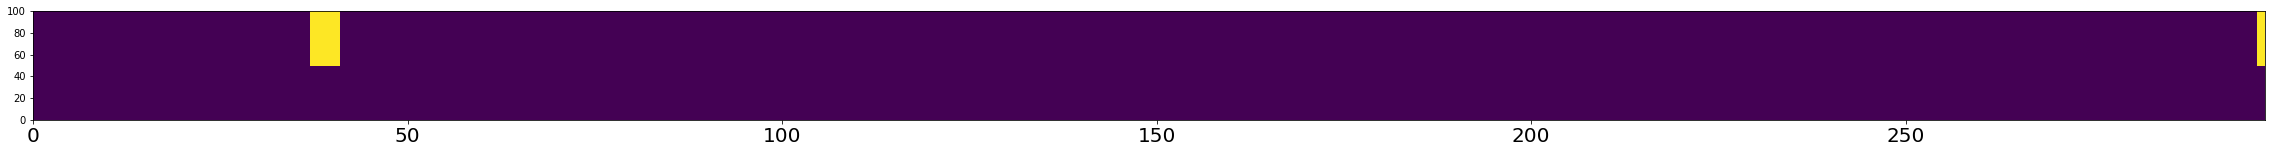

A,P,R:  0.9832214765100671 0.9832214765100671 1.0
Num frames:  (298, 5)
Accuracy:  0.9832214765100671
Person:  1


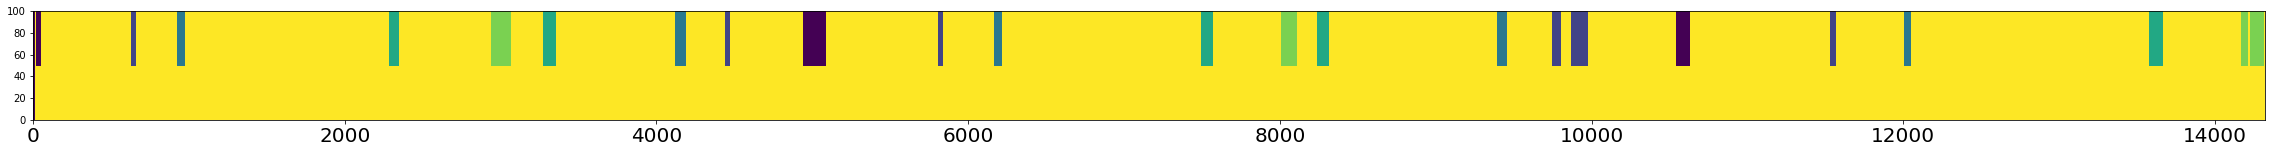

A,P,R:  0.8868794078625795 0.8947368421052632 0.010397553516819572
Num frames:  (19, 2)
Accuracy:  0.8868794078625795
Person:  2


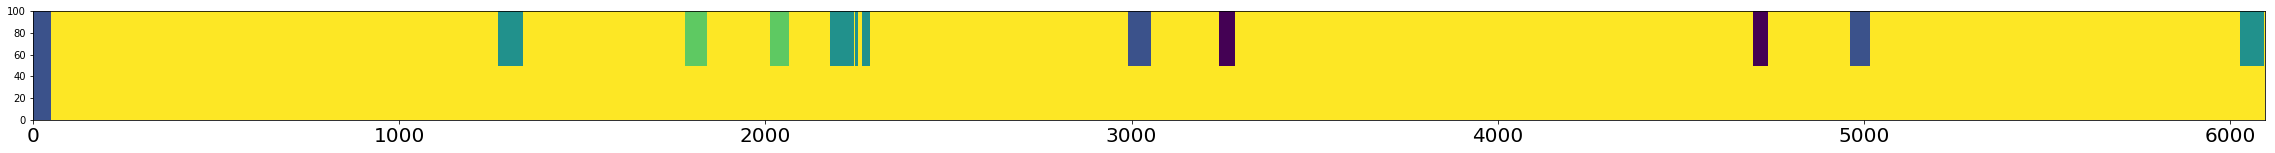

A,P,R:  0.9120734908136483 0.9607843137254902 0.08404802744425385
Num frames:  (51, 2)
Accuracy:  0.9120734908136483
Person:  3


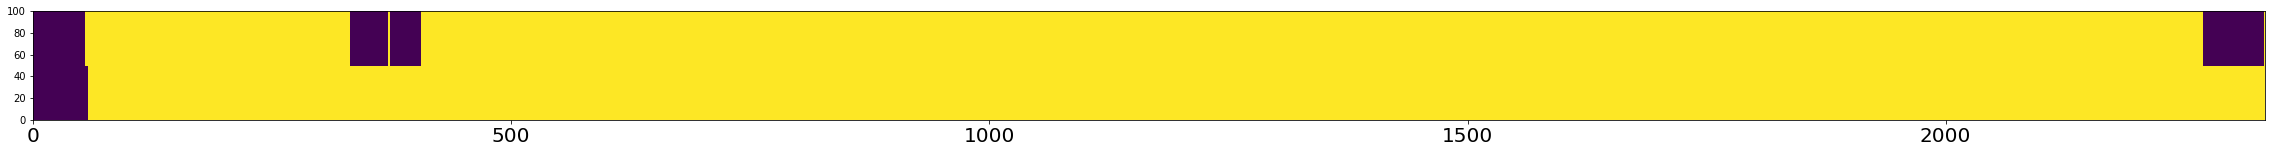

A,P,R:  0.9408740359897172 0.9482758620689655 0.2894736842105263
Num frames:  (58, 3)
Accuracy:  0.9408740359897172
Person:  4


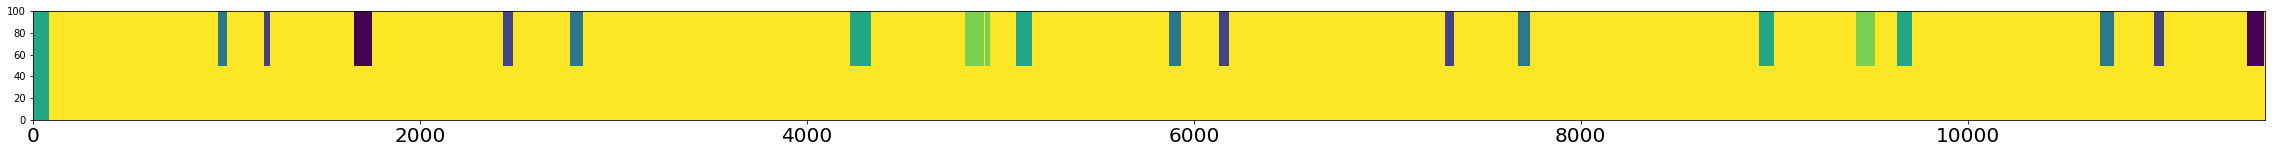

A,P,R:  0.8865389616018029 0.9545454545454546 0.06047516198704104
Num frames:  (88, 4)
Accuracy:  0.8865389616018029
Person:  5


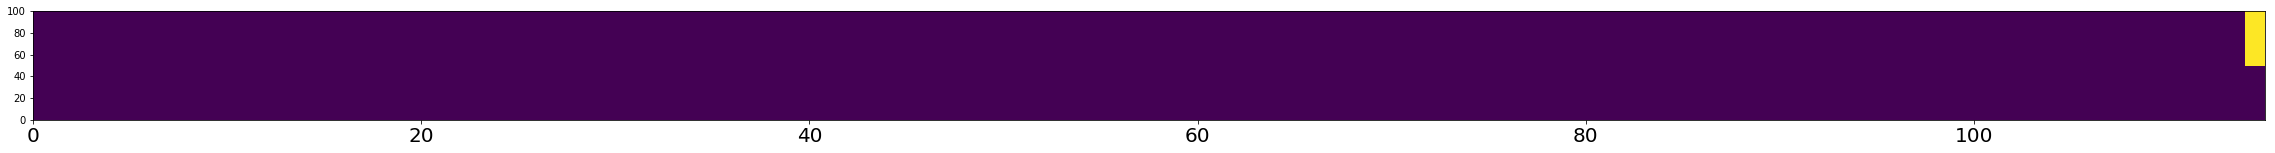

A,P,R:  0.991304347826087 0.991304347826087 1.0
Num frames:  (115, 1)
Accuracy:  0.991304347826087
Person:  6


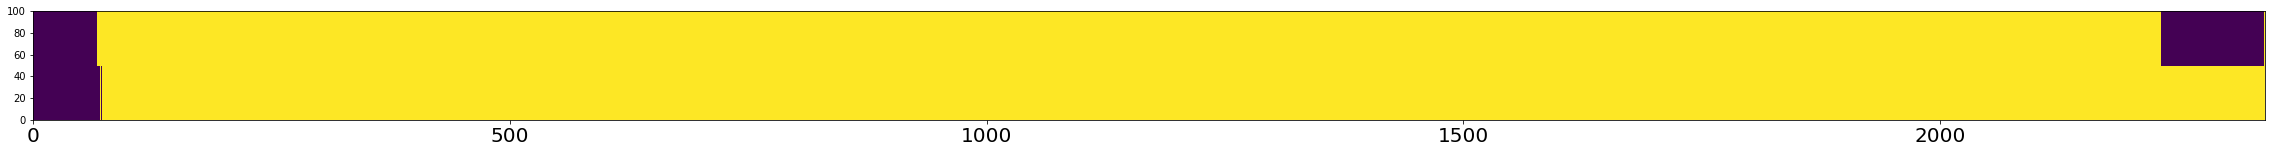

A,P,R:  0.9521571977787271 0.9444444444444444 0.38636363636363635
Num frames:  (72, 4)
Accuracy:  0.9521571977787271
Person:  7


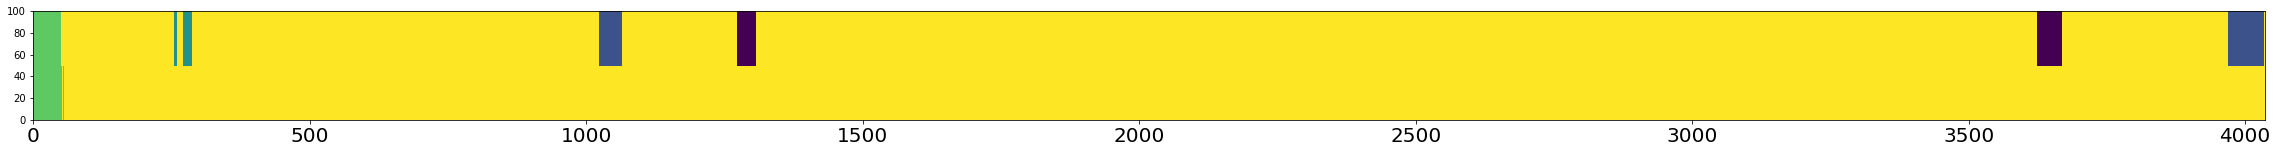

A,P,R:  0.9472249752229931 0.9454545454545454 0.1984732824427481
Num frames:  (55, 3)
Accuracy:  0.9472249752229931
Person:  8


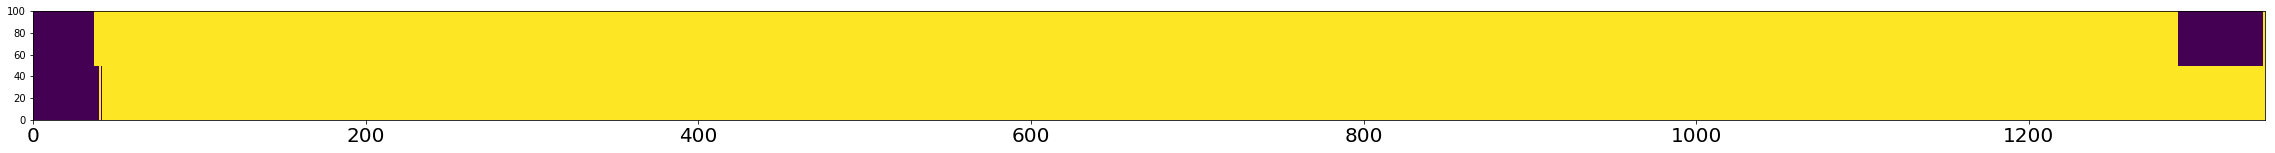

A,P,R:  0.9590163934426229 0.9024390243902439 0.42045454545454547
Num frames:  (41, 4)
Accuracy:  0.9590163934426229
Person:  9


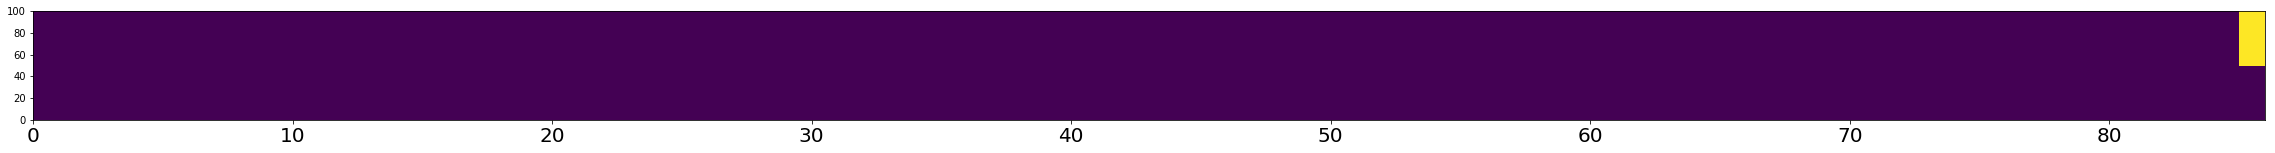

A,P,R:  0.9883720930232558 0.9883720930232558 1.0
Num frames:  (86, 1)
Accuracy:  0.9883720930232558
Person:  10


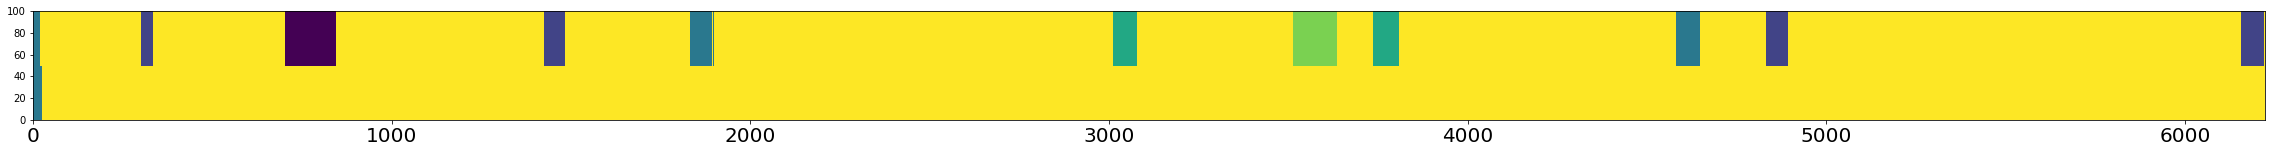

A,P,R:  0.8788365739996786 0.88 0.028460543337645538
Num frames:  (25, 3)
Accuracy:  0.8788365739996786
Person:  11


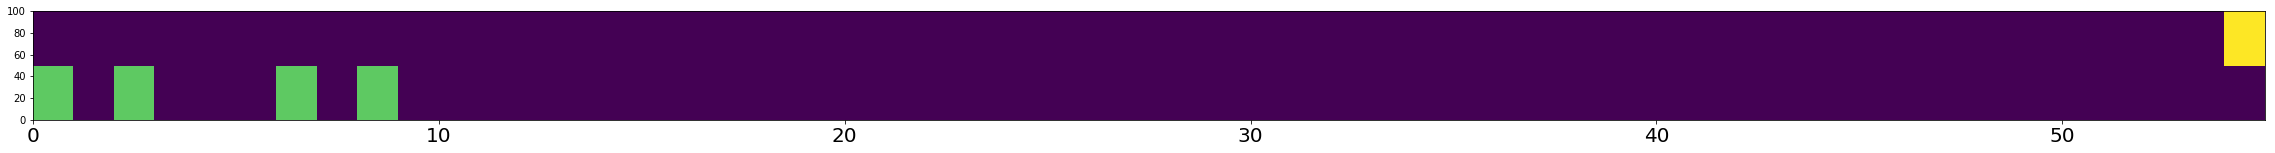

A,P,R:  0.9090909090909091 0.9090909090909091 0.9259259259259259
Num frames:  (55, 1)
Accuracy:  0.9090909090909091
Person:  12


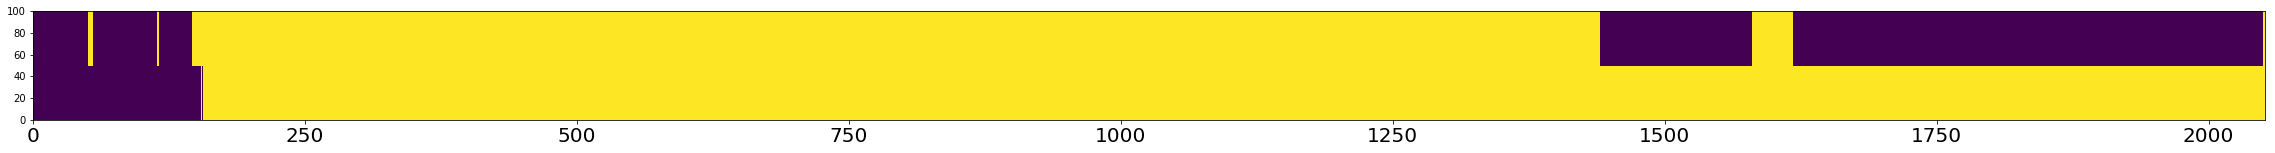

A,P,R:  0.7129629629629629 0.8974358974358975 0.19635343618513323
Num frames:  (156, 16)
Accuracy:  0.7129629629629629
Person:  13


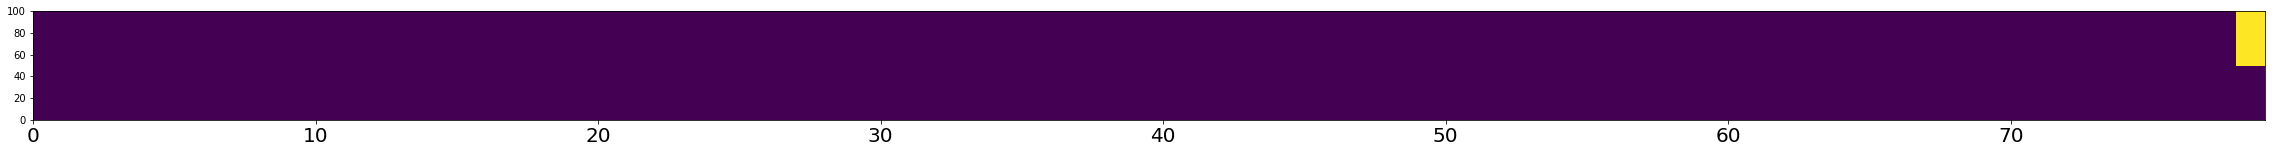

A,P,R:  0.9873417721518988 0.9873417721518988 1.0
Num frames:  (79, 1)
Accuracy:  0.9873417721518988
Person:  14


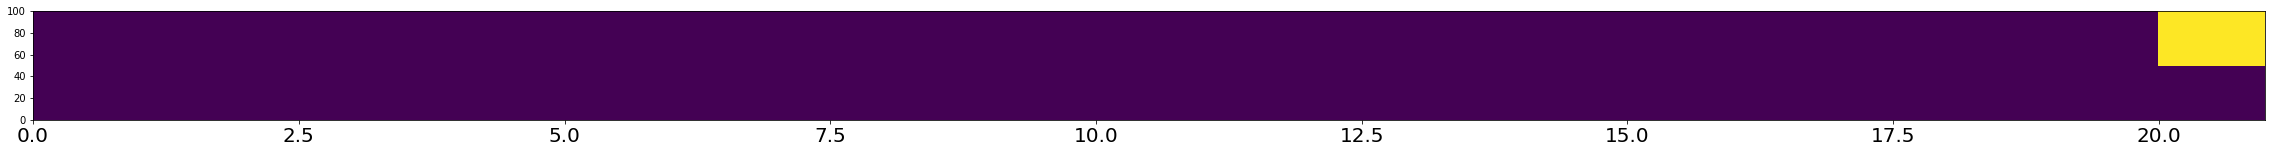

A,P,R:  0.9523809523809523 0.9523809523809523 1.0
Num frames:  (21, 1)
Accuracy:  0.9523809523809523
Person:  15


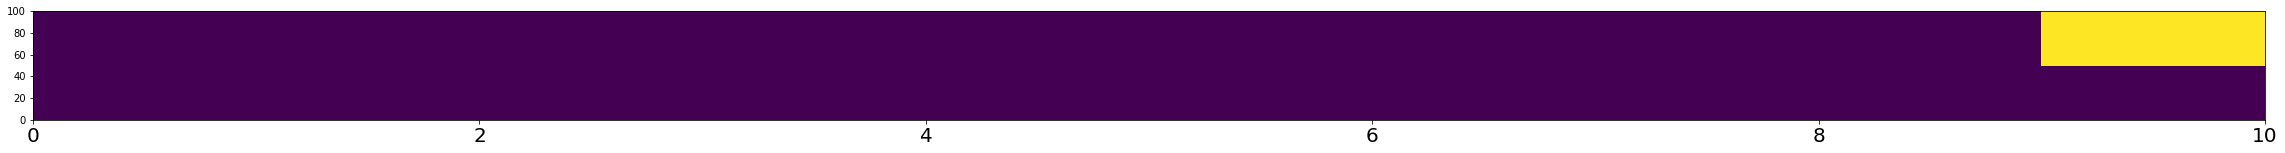

A,P,R:  0.9 0.9 1.0
Num frames:  (10, 1)
Accuracy:  0.9
Person:  16


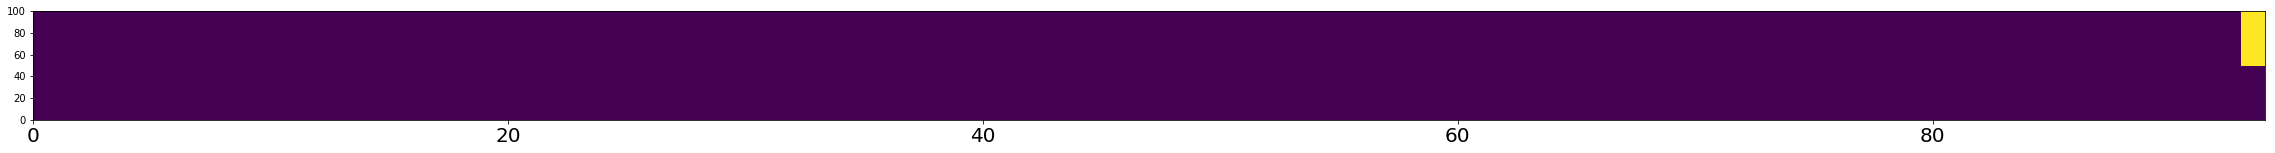

A,P,R:  0.9893617021276596 0.9893617021276596 1.0
Num frames:  (94, 1)
Accuracy:  0.9893617021276596
Person:  17


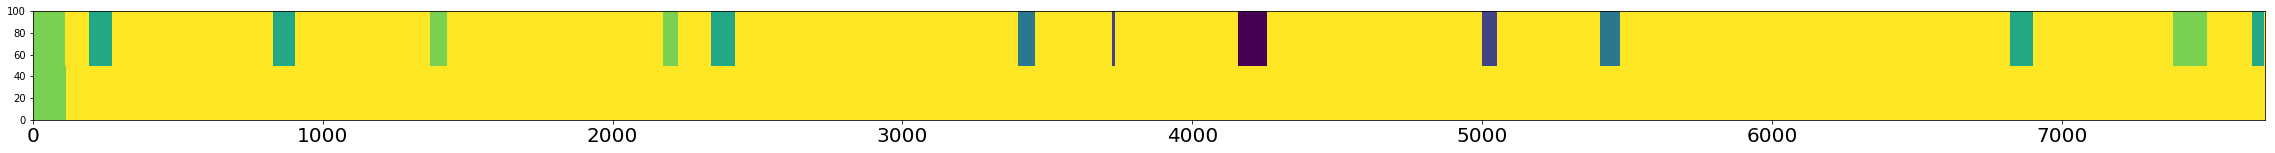

A,P,R:  0.8850947805764736 0.9741379310344828 0.1135678391959799
Num frames:  (116, 3)
Accuracy:  0.8850947805764736
Person:  18


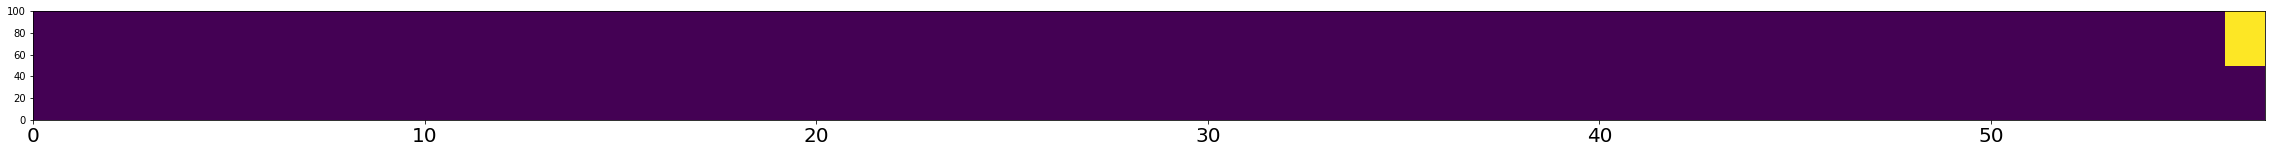

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  19


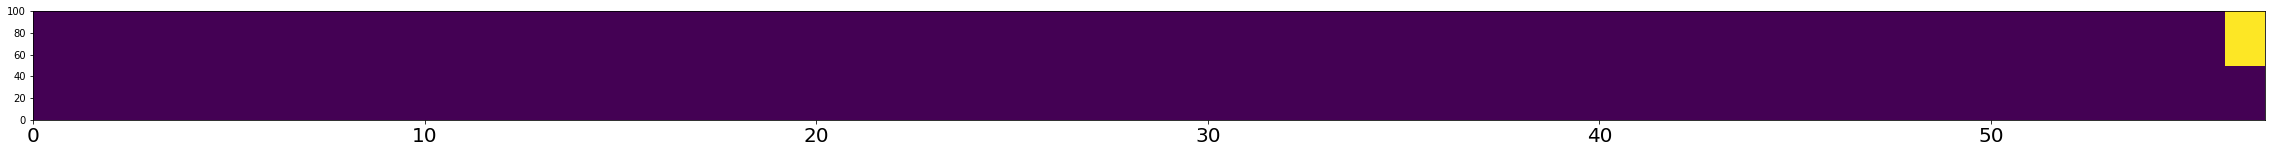

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  20


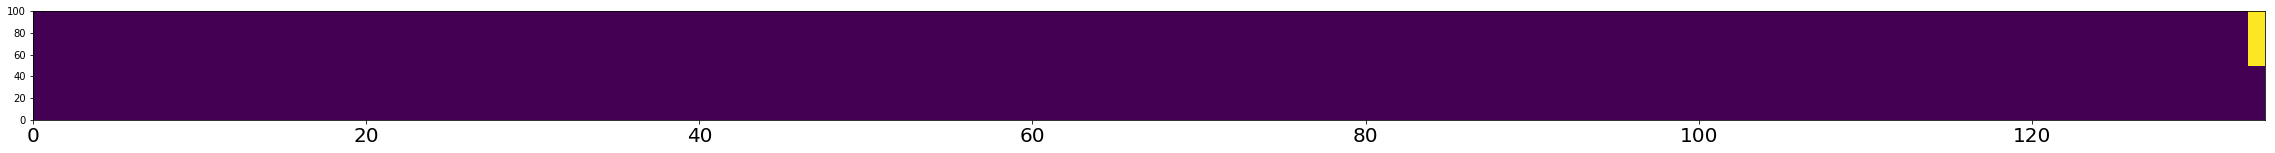

A,P,R:  0.9925373134328358 0.9925373134328358 1.0
Num frames:  (134, 1)
Accuracy:  0.9925373134328358
Person:  21


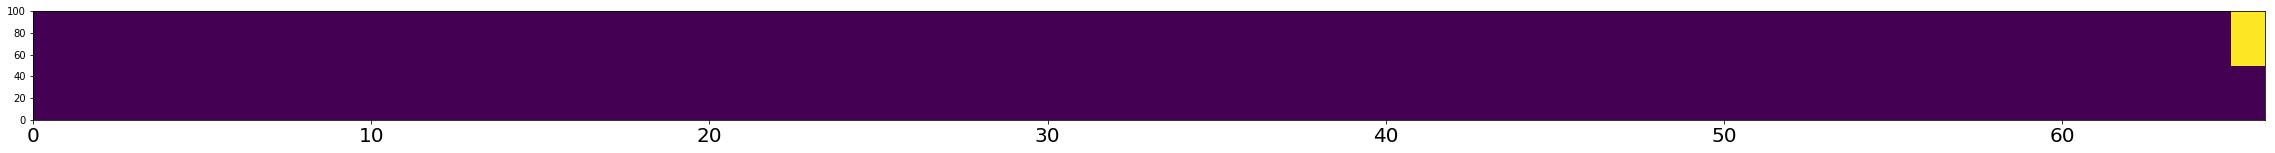

A,P,R:  0.9848484848484849 0.9848484848484849 1.0
Num frames:  (66, 1)
Accuracy:  0.9848484848484849
Person:  22


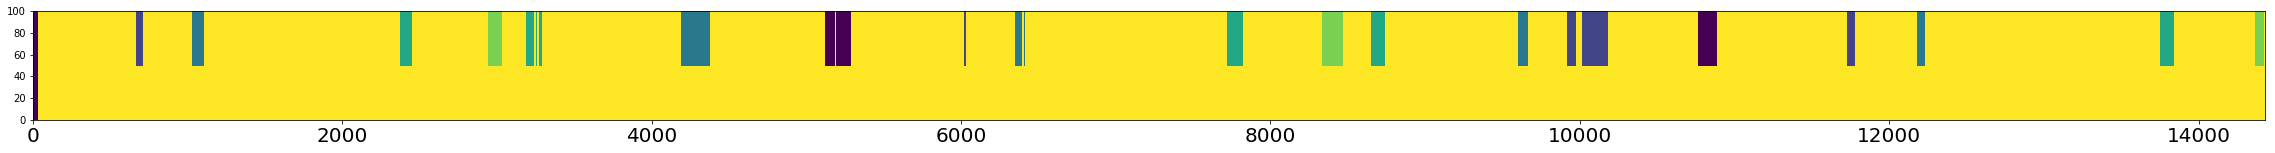

A,P,R:  0.876992376992377 0.9459459459459459 0.019337016574585635
Num frames:  (37, 0)
Accuracy:  0.876992376992377
Person:  23


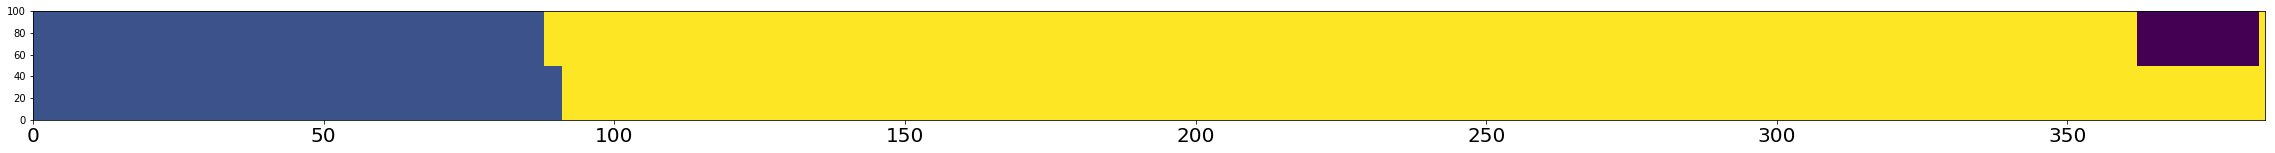

A,P,R:  0.9375 0.967032967032967 0.8073394495412844
Num frames:  (91, 3)
Accuracy:  0.9375
0.934146770389062
Average A,P,R,F, ttr 0.934146770389062 0.9524418566782336 0.6058612542575051 2.875 [3, 47, 23, 7, 41, 1, 3, 13, 3, 1, 23, 1, 9, 1, 1, 1, 1, 27, 1, 1, 1, 1, 57, 3]
1944


In [17]:
policy_net.eval()
req_inc = 0
_,acc = test_func(pTest,iloc='fix',eloc='last', fixLoc=25, isdebug=0, req_inc=req_inc)
tr_acc = 0
A,P,R,F, ttr = [],[],[],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [ ]:
tr_acc = 0
for i in range(5):
    print ('Person: ',i)
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    print (g)
    print (p)
    tr_acc += np.sum(g==p, dtype=np.float)/g.shape[0]
tr_acc/5

In [ ]:
np.log10(1000)

In [ ]:
mcta = []
nfr = []
for i in range(5):
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    mcta.append(afc.compute_MCTA(p,g))
    nfr.append(afc.compute_num_frames(p,g))
print (np.mean(mcta))
print (np.sum(nfr))

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [ ]:
import numpy as np
1/np.log(10)

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])